# Latent Dirichlet Allocation (LDA) - Choosing the Number of Topics

A major challenge with LDA is choosing the correct number of topics. There are a few different measures that are commonly used to judge the quality of an LDA model. 

1. Perplexity - This measures the statistical fit between the topic model and the actual document set. 
2. Topic Coherence - This is a measure of how likely it is for words in the same topic to appear together. For a more in depth description, see [here](http://qpleple.com/topic-coherence-to-evaluate-topic-models/). 

While perplexity technically does a good job of assessing how well your model represents your data, it does not do a good job assessing the interpretability of the topics in your model. For interpretability, topic coherence is much more appropriate. For the purposes of this project, interpretability of the topics is very important, so I will be prioritizing the topic coherence. 

In [1]:
import numpy as np
import pandas as pd
from time import time

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

import nltk
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
import re

from gensim.models import Phrases
from gensim import corpora, models, similarities
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaModel

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from sklearn.model_selection import KFold

### First, I will focus on improving the dictionary for my model
* Incorporate bigrams
* Add more useful stop words
* Filter out extremes (words that are very common)
* Try lemmatizing instead of stemming the words.

In [2]:
data = pd.read_csv('zoc_doc_reviews_Manhattan.csv')

In [3]:
data.drop(['Unnamed: 0','Verification','Overall_Rating','Bedside_Manner_Rating','Wait_Time_Rating'], 
          axis=1, inplace= True)
data.drop_duplicates(inplace=True)
data.dropna(subset=['Review'], inplace=True)
data.reset_index(inplace=True,drop=True)

In [4]:
data.head()

Doctor         Author                    Date  \
0  Dr. Denise Pate            NaN       December 27, 2017   
1  Dr. Denise Pate  by Natalie S.        December 7, 2017   
2  Dr. Denise Pate            NaN  Less than 3 months ago   
3  Dr. Denise Pate            NaN        November 3, 2017   
4  Dr. Denise Pate            NaN        October 16, 2017   

                                              Review  
0  Great experience! The office is beautiful and ...  
1  Dr. Pate was kind, welcoming and made me feel ...  
2  Very thorough but efficient appointment, great...  
3  She was very sweet and efficient. I would high...  
4  Dr. Pate is exactly what you want in a primary...

In [5]:
data.shape

(35873, 4)

First, I will focus on identifying bigrams. 

** Note: While trying this out, I noticed that doctor's names and stop words were commonly identified as bigrams, so I remove them during the tokenizing process, before looking for bigrams.

In [6]:
tokenized_doctors = [[name for name in re.findall('\w+',full_name.lower())] for full_name in data['Doctor'].unique()]
doctor_names_to_remove = []
for full_name in tokenized_doctors:
    for name_part in full_name:
        doctor_names_to_remove.append(name_part)
    
doctor_names_to_remove = list(set(doctor_names_to_remove))

extra_stop_words = ['an']

stoplist = set(nltk.corpus.stopwords.words('english') + list(ENGLISH_STOP_WORDS)
               + ['doctor','dr'] + doctor_names_to_remove + extra_stop_words)

In [7]:
# Define a function to split a review into individual words and keep all the words that are longer than one character.
def get_tokens(review):
    tokens = []
    for word in re.findall('\\w+',review.lower()):
        if (len(word)>1 and word not in stoplist):
            tokens.append(word)
    return(tokens)

In [8]:
data['tokenized_reviews'] = data['Review'].apply(lambda x: get_tokens(x))

In [9]:
# Lemmatize all words in documents.
lemmatizer = WordNetLemmatizer()

data['lemmatized_reviews']=data['tokenized_reviews'].apply(lambda x: [lemmatizer.lemmatize(token) for token in x])

In [10]:
# Compute bigrams.
bigram = Phrases(list(data['tokenized_reviews']),min_count=100)

2018-01-29 15:47:49,898 : INFO : collecting all words and their counts
2018-01-29 15:47:49,900 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2018-01-29 15:47:50,258 : INFO : PROGRESS: at sentence #10000, processed 116730 words and 70548 word types
2018-01-29 15:47:50,611 : INFO : PROGRESS: at sentence #20000, processed 232764 words and 120518 word types
2018-01-29 15:47:50,939 : INFO : PROGRESS: at sentence #30000, processed 353512 words and 167926 word types
2018-01-29 15:47:51,181 : INFO : collected 194232 word types from a corpus of 426678 words (unigram + bigrams) and 35873 sentences
2018-01-29 15:47:51,183 : INFO : using 194232 counts as vocab in Phrases<0 vocab, min_count=100, threshold=10.0, max_vocab_size=40000000>


In [11]:
# find bigrams in the reviews
data['bigrams'] = data['lemmatized_reviews'].apply(lambda x: [b for b in bigram[x] if '_' in b])

/anaconda/lib/python3.6/site-packages/gensim/models/phrases.py:431: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [12]:
data['lemmatized_reviews_with_bigrams'] = np.nan

data['lemmatized_reviews_with_bigrams'] = data['lemmatized_reviews']

for row in range(data.shape[0]):
    for b in data.loc[row,'bigrams']:
        data.loc[row,'lemmatized_reviews_with_bigrams'].append(b)

data.head()

Doctor         Author                    Date  \
0  Dr. Denise Pate            NaN       December 27, 2017   
1  Dr. Denise Pate  by Natalie S.        December 7, 2017   
2  Dr. Denise Pate            NaN  Less than 3 months ago   
3  Dr. Denise Pate            NaN        November 3, 2017   
4  Dr. Denise Pate            NaN        October 16, 2017   

                                              Review  \
0  Great experience! The office is beautiful and ...   
1  Dr. Pate was kind, welcoming and made me feel ...   
2  Very thorough but efficient appointment, great...   
3  She was very sweet and efficient. I would high...   
4  Dr. Pate is exactly what you want in a primary...   

                                   tokenized_reviews  \
0  [great, experience, office, beautiful, easily,...   
1  [kind, welcoming, feel, comfortable, visit, pr...   
2  [thorough, efficient, appointment, great, beds...   
3         [sweet, efficient, highly, recommend, pcp]   
4  [exactly, want, primary, care, physician, took...   

                                  lemmatized_reviews  \
0  [great, experience, office, beautiful, easily,...   
1  [kind, welcoming, feel, comfortable, visit, pr...   
2  [thorough, efficient, appointment, great, beds...   
3  [sweet, efficient, highly, recommend, pcp, hig...   
4  [exactly, want, primary, care, physician, took...   

                          bigrams  \
0                     [feel_ease]   
1              [feel_comfortable]   
2     [bedside_manner, easy_talk]   
3              [highly_recommend]   
4  [primary_care, bedside_manner]   

                     lemmatized_reviews_with_bigrams  
0  [great, experience, office, beautiful, easily,...  
1  [kind, welcoming, feel, comfortable, visit, pr...  
2  [thorough, efficient, appointment, great, beds...  
3  [sweet, efficient, highly, recommend, pcp, hig...  
4  [exactly, want, primary, care, physician, took...

Now that I have all of my reviews tokenized and have included bigrams, I will define a dictionary for my corpus. 

Gensim's dictionary.filter_extremes() makes it easy to exclude words that only appear a few times or appear in too many of the reviews. 

In [13]:
dictionary = corpora.Dictionary(list(data['lemmatized_reviews_with_bigrams']))
len(dictionary)

2018-01-29 15:48:00,859 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-01-29 15:48:01,135 : INFO : adding document #10000 to Dictionary(6430 unique tokens: ['great', 'experience', 'office', 'beautiful', 'easily']...)
2018-01-29 15:48:01,399 : INFO : adding document #20000 to Dictionary(8833 unique tokens: ['great', 'experience', 'office', 'beautiful', 'easily']...)
2018-01-29 15:48:01,674 : INFO : adding document #30000 to Dictionary(10968 unique tokens: ['great', 'experience', 'office', 'beautiful', 'easily']...)
2018-01-29 15:48:01,830 : INFO : built Dictionary(12054 unique tokens: ['great', 'experience', 'office', 'beautiful', 'easily']...) from 35873 documents (total 443449 corpus positions)


12054

In [14]:
dictionary.filter_extremes(no_below=50,no_above=0.5)
len(dictionary)

2018-01-29 15:48:02,711 : INFO : discarding 11100 tokens: [('lobby', 22), ('crazied', 1), ('intern', 8), ('majority', 7), ('cleaned', 7), ('communicative', 41), ('dismiss', 24), ('followup', 36), ('struggled', 18), ('fixed', 19)]...
2018-01-29 15:48:02,714 : INFO : keeping 954 tokens which were in no less than 50 and no more than 17936 (=50.0%) documents
2018-01-29 15:48:02,727 : INFO : resulting dictionary: Dictionary(954 unique tokens: ['great', 'experience', 'office', 'beautiful', 'easily']...)


954

In [15]:
corpus = [dictionary.doc2bow(doc) for doc in list(data['lemmatized_reviews_with_bigrams'])]

### Now that I've cleaned up my data, I will optimize the number of topics for my lda model.

I can use sklearn's KFold method to create 5 test-train splits of my corpus. Next I can train 5 LDA models for each number of topics and calculate the perplexity and topic coherence for each number of topics.

In [16]:
kf = KFold(n_splits=5)

In [18]:
topic_numbers = np.linspace(2,102,11)
log_perplexity_scores=np.zeros([5,11])
bound_perplexity_scores = np.zeros([5,11])
u_mass_coherences_train = np.zeros([5,11])
u_mass_coherences_test = np.zeros([5,11])



for n_topics in topic_numbers:
    count = 0
    for train,test in kf.split(corpus):
        start_time = time()
        
        train_corpus = [corpus[i] for i in train]
        test_corpus = [corpus[i] for i in test]
        
        lda = LdaModel(train_corpus,id2word=dictionary,num_topics=n_topics)
        print('done training')
            
        log_perplexity_scores[count,int((n_topics-2)/10)] = lda.log_perplexity(test_corpus)
        bound_perplexity_scores[count,int((n_topics-2)/10)]=lda.bound(test_corpus)
        
        cm_train = CoherenceModel(model=lda, corpus=train_corpus,dictionary=dictionary, coherence = 'u_mass')
        u_mass_coherences_train[count,int((n_topics-2)/10)]=cm_train.get_coherence()
        
        cm_test = CoherenceModel(model=lda, corpus=test_corpus,dictionary=dictionary, coherence = 'u_mass')
        u_mass_coherences_test[count,int((n_topics-2)/10)]=cm_test.get_coherence()

        count+=1
        print(time()-start_time)
        print('done with perplexity')
        print()

2018-01-29 16:07:13,382 : INFO : using symmetric alpha at 0.5
2018-01-29 16:07:13,384 : INFO : using symmetric eta at 0.0010482180293501049
2018-01-29 16:07:13,386 : INFO : using serial LDA version on this node
2018-01-29 16:07:13,416 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:07:13,418 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-29 16:07:17,661 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:07:17,663 : INFO : topic #0 (0.500): 0.026*"time" + 0.022*"great" + 0.019*"office" + 0.014*"recommend" + 0.014*"wait" + 0.014*"friendly" + 0.013*"patient" + 0.012*"professional" + 0.012*"like" + 0.011*"really"
2018-01-29 16:07:17,665 : INFO : topic #1 (0.500): 0.025*"time" + 0.018*"great" + 0.016*"thorough" + 0.015*

2018-01-29 16:07:50,237 : INFO : topic diff=0.141450, rho=0.301511
2018-01-29 16:07:50,239 : INFO : PROGRESS: pass 0, at document #24000/28698
2018-01-29 16:07:52,326 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:07:52,329 : INFO : topic #0 (0.500): 0.028*"time" + 0.022*"recommend" + 0.016*"office" + 0.016*"highly" + 0.014*"great" + 0.013*"really" + 0.013*"question" + 0.012*"like" + 0.011*"highly_recommend" + 0.011*"appointment"
2018-01-29 16:07:52,331 : INFO : topic #1 (0.500): 0.036*"great" + 0.027*"professional" + 0.023*"thorough" + 0.020*"staff" + 0.018*"friendly" + 0.015*"office" + 0.015*"time" + 0.014*"visit" + 0.014*"care" + 0.014*"manner"
2018-01-29 16:07:52,332 : INFO : topic diff=0.127551, rho=0.288675
2018-01-29 16:07:52,334 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 16:07:54,307 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:07:54,309 : INFO : topic #0 (0.500): 0.030

done training


2018-01-29 16:08:09,804 : INFO : -6.068 per-word bound, 67.1 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-29 16:08:21,172 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:08:21,181 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:08:21,191 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:08:21,200 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:08:21,207 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:08:21,217 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:08:21,227 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:08:21,235 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:08:21,245 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:08:21,254 : INFO : CorpusAccumulator accum

68.19847393035889
done with perplexity



2018-01-29 16:08:25,793 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:08:25,794 : INFO : topic #0 (0.500): 0.022*"office" + 0.019*"time" + 0.018*"nice" + 0.015*"great" + 0.014*"professional" + 0.014*"concern" + 0.013*"thorough" + 0.013*"question" + 0.011*"patient" + 0.011*"really"
2018-01-29 16:08:25,796 : INFO : topic #1 (0.500): 0.028*"great" + 0.021*"time" + 0.018*"professional" + 0.018*"staff" + 0.017*"friendly" + 0.015*"office" + 0.015*"recommend" + 0.012*"patient" + 0.012*"question" + 0.012*"thorough"
2018-01-29 16:08:25,798 : INFO : topic diff=1.073476, rho=1.000000
2018-01-29 16:08:25,799 : INFO : PROGRESS: pass 0, at document #4000/28698
2018-01-29 16:08:29,431 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:08:29,433 : INFO : topic #0 (0.500): 0.025*"time" + 0.019*"office" + 0.016*"nice" + 0.015*"great" + 0.013*"concern" + 0.013*"thorough" + 0.012*"question" + 0.012*"really" + 0.012*"profe

2018-01-29 16:08:56,014 : INFO : topic diff=0.130453, rho=0.288675
2018-01-29 16:08:56,015 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 16:08:57,565 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:08:57,569 : INFO : topic #0 (0.500): 0.036*"time" + 0.018*"office" + 0.015*"wait" + 0.013*"appointment" + 0.013*"took" + 0.012*"question" + 0.011*"nice" + 0.010*"patient" + 0.010*"concern" + 0.009*"visit"
2018-01-29 16:08:57,570 : INFO : topic #1 (0.500): 0.043*"great" + 0.029*"professional" + 0.027*"recommend" + 0.023*"friendly" + 0.023*"staff" + 0.021*"highly" + 0.020*"thorough" + 0.016*"care" + 0.016*"feel" + 0.015*"visit"
2018-01-29 16:08:57,572 : INFO : topic diff=0.128768, rho=0.277350
2018-01-29 16:08:57,573 : INFO : PROGRESS: pass 0, at document #28000/28698
2018-01-29 16:08:59,120 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:08:59,123 : INFO : topic #0 (0.500): 0.035*"time" + 0.

done training


2018-01-29 16:09:11,408 : INFO : -6.037 per-word bound, 65.7 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-29 16:09:24,116 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:09:24,127 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:09:24,139 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:09:24,151 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:09:24,161 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:09:24,172 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:09:24,182 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:09:24,190 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:09:24,200 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:09:24,209 : INFO : CorpusAccumulator accum

62.989030838012695
done with perplexity



2018-01-29 16:09:29,075 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:09:29,077 : INFO : topic #0 (0.500): 0.021*"recommend" + 0.020*"professional" + 0.019*"time" + 0.016*"highly" + 0.015*"great" + 0.014*"patient" + 0.014*"staff" + 0.013*"feel" + 0.013*"office" + 0.012*"highly_recommend"
2018-01-29 16:09:29,079 : INFO : topic #1 (0.500): 0.028*"great" + 0.021*"time" + 0.021*"office" + 0.016*"question" + 0.015*"friendly" + 0.014*"staff" + 0.014*"professional" + 0.013*"thorough" + 0.012*"nice" + 0.012*"visit"
2018-01-29 16:09:29,080 : INFO : topic diff=1.097202, rho=1.000000
2018-01-29 16:09:29,082 : INFO : PROGRESS: pass 0, at document #4000/28698
2018-01-29 16:09:33,249 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:09:33,253 : INFO : topic #0 (0.500): 0.023*"recommend" + 0.020*"professional" + 0.019*"time" + 0.017*"patient" + 0.017*"highly" + 0.016*"great" + 0.013*"care" + 0.013*"highly_recommend"

2018-01-29 16:10:02,914 : INFO : topic #1 (0.500): 0.031*"time" + 0.023*"office" + 0.019*"great" + 0.017*"question" + 0.015*"appointment" + 0.014*"staff" + 0.014*"wait" + 0.014*"visit" + 0.011*"took" + 0.011*"friendly"
2018-01-29 16:10:02,916 : INFO : topic diff=0.131399, rho=0.288675
2018-01-29 16:10:02,918 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 16:10:04,953 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:10:04,958 : INFO : topic #0 (0.500): 0.031*"great" + 0.030*"recommend" + 0.029*"professional" + 0.023*"highly" + 0.021*"thorough" + 0.020*"care" + 0.019*"feel" + 0.017*"patient" + 0.015*"highly_recommend" + 0.015*"excellent"
2018-01-29 16:10:04,960 : INFO : topic #1 (0.500): 0.033*"time" + 0.023*"office" + 0.018*"great" + 0.017*"question" + 0.016*"wait" + 0.015*"appointment" + 0.014*"staff" + 0.013*"visit" + 0.012*"took" + 0.011*"nice"
2018-01-29 16:10:04,962 : INFO : topic diff=0.126868, rho=0.277350
2018-01-29 16:10

done training


2018-01-29 16:10:19,511 : INFO : -6.018 per-word bound, 64.8 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-29 16:10:30,568 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:10:30,577 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:10:30,591 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:10:30,600 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:10:30,610 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:10:30,621 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:10:30,630 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:10:30,641 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:10:30,651 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:10:30,662 : INFO : CorpusAccumulator accum

66.4378616809845
done with perplexity



2018-01-29 16:10:35,443 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:10:35,445 : INFO : topic #0 (0.500): 0.025*"great" + 0.022*"time" + 0.018*"office" + 0.016*"friendly" + 0.015*"professional" + 0.015*"thorough" + 0.015*"recommend" + 0.014*"question" + 0.013*"staff" + 0.012*"patient"
2018-01-29 16:10:35,447 : INFO : topic #1 (0.500): 0.020*"professional" + 0.019*"great" + 0.017*"office" + 0.016*"time" + 0.016*"staff" + 0.015*"good" + 0.013*"helpful" + 0.010*"nice" + 0.010*"patient" + 0.010*"care"
2018-01-29 16:10:35,448 : INFO : topic diff=1.062597, rho=1.000000
2018-01-29 16:10:35,450 : INFO : PROGRESS: pass 0, at document #4000/28699
2018-01-29 16:10:38,998 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:10:39,001 : INFO : topic #0 (0.500): 0.029*"great" + 0.026*"time" + 0.016*"thorough" + 0.016*"friendly" + 0.016*"office" + 0.016*"recommend" + 0.015*"patient" + 0.014*"question" + 0.014*"really"

2018-01-29 16:11:07,712 : INFO : topic diff=0.127176, rho=0.288675
2018-01-29 16:11:07,714 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-29 16:11:09,544 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:11:09,547 : INFO : topic #0 (0.500): 0.037*"great" + 0.029*"time" + 0.024*"recommend" + 0.024*"thorough" + 0.022*"professional" + 0.019*"question" + 0.019*"friendly" + 0.018*"highly" + 0.017*"feel" + 0.016*"patient"
2018-01-29 16:11:09,549 : INFO : topic #1 (0.500): 0.021*"office" + 0.018*"time" + 0.015*"good" + 0.015*"appointment" + 0.013*"staff" + 0.012*"visit" + 0.010*"wait" + 0.009*"nice" + 0.009*"minute" + 0.009*"helpful"
2018-01-29 16:11:09,550 : INFO : topic diff=0.130221, rho=0.277350
2018-01-29 16:11:09,551 : INFO : PROGRESS: pass 0, at document #28000/28699
2018-01-29 16:11:11,308 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:11:11,311 : INFO : topic #0 (0.500): 0.038*"great" + 

done training


2018-01-29 16:11:24,501 : INFO : -6.038 per-word bound, 65.7 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-29 16:11:35,950 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:11:35,959 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:11:35,970 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:11:35,983 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:11:35,992 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:11:36,003 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:11:36,016 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:11:36,025 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:11:36,035 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:11:36,048 : INFO : CorpusAccumulator accum

65.38857126235962
done with perplexity



2018-01-29 16:11:40,967 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:11:40,969 : INFO : topic #0 (0.500): 0.025*"time" + 0.016*"great" + 0.014*"patient" + 0.014*"office" + 0.014*"really" + 0.014*"nice" + 0.013*"recommend" + 0.013*"thorough" + 0.013*"highly" + 0.012*"friendly"
2018-01-29 16:11:40,971 : INFO : topic #1 (0.500): 0.032*"great" + 0.024*"professional" + 0.023*"office" + 0.021*"staff" + 0.015*"question" + 0.015*"time" + 0.015*"friendly" + 0.012*"recommend" + 0.012*"appointment" + 0.012*"thorough"
2018-01-29 16:11:40,973 : INFO : topic diff=1.081697, rho=1.000000
2018-01-29 16:11:40,974 : INFO : PROGRESS: pass 0, at document #4000/28699
2018-01-29 16:11:44,802 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:11:44,805 : INFO : topic #0 (0.500): 0.028*"time" + 0.016*"patient" + 0.016*"really" + 0.014*"great" + 0.013*"visit" + 0.013*"recommend" + 0.013*"thorough" + 0.012*"nice" + 0.012*"highl

2018-01-29 16:12:13,402 : INFO : topic diff=0.145032, rho=0.288675
2018-01-29 16:12:13,404 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-29 16:12:15,285 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:12:15,288 : INFO : topic #0 (0.500): 0.030*"time" + 0.017*"office" + 0.015*"wait" + 0.014*"appointment" + 0.013*"patient" + 0.013*"really" + 0.012*"care" + 0.011*"feel" + 0.010*"visit" + 0.010*"like"
2018-01-29 16:12:15,290 : INFO : topic #1 (0.500): 0.049*"great" + 0.033*"professional" + 0.024*"staff" + 0.023*"friendly" + 0.023*"recommend" + 0.022*"thorough" + 0.019*"question" + 0.016*"office" + 0.016*"highly" + 0.014*"visit"
2018-01-29 16:12:15,292 : INFO : topic diff=0.131622, rho=0.277350
2018-01-29 16:12:15,293 : INFO : PROGRESS: pass 0, at document #28000/28699
2018-01-29 16:12:17,060 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:12:17,063 : INFO : topic #0 (0.500): 0.029*"time" + 0

done training


2018-01-29 16:12:31,421 : INFO : -6.038 per-word bound, 65.7 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-29 16:12:43,174 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:12:43,183 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:12:43,191 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:12:43,200 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:12:43,209 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:12:43,220 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:12:43,227 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:12:43,237 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:12:43,246 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:12:43,256 : INFO : CorpusAccumulator accum

67.24751472473145
done with perplexity



2018-01-29 16:12:47,200 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:12:47,211 : INFO : topic #1 (0.083): 0.024*"really" + 0.020*"nice" + 0.020*"time" + 0.017*"great" + 0.015*"office" + 0.015*"appointment" + 0.013*"helpful" + 0.012*"professional" + 0.012*"thorough" + 0.010*"feel"
2018-01-29 16:12:47,214 : INFO : topic #7 (0.083): 0.026*"office" + 0.015*"minute" + 0.015*"thorough" + 0.014*"highly" + 0.014*"professional" + 0.013*"appointment" + 0.013*"friendly" + 0.013*"recommend" + 0.012*"visit" + 0.012*"good"
2018-01-29 16:12:47,217 : INFO : topic #4 (0.083): 0.029*"office" + 0.023*"professional" + 0.019*"staff" + 0.019*"visit" + 0.016*"attentive" + 0.015*"time" + 0.015*"question" + 0.014*"nice" + 0.014*"knowledgeable" + 0.014*"great"
2018-01-29 16:12:47,219 : INFO : topic #0 (0.083): 0.039*"time" + 0.026*"hour" + 0.022*"thorough" + 0.021*"wait" + 0.020*"professional" + 0.018*"appointment" + 0.015*"great" + 0.015*"helpful" + 0.013*"visit" +

2018-01-29 16:13:03,191 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:13:03,206 : INFO : topic #0 (0.083): 0.081*"wait" + 0.068*"time" + 0.036*"appointment" + 0.032*"long" + 0.026*"minute" + 0.026*"hour" + 0.021*"seen" + 0.018*"great" + 0.015*"nice" + 0.013*"office"
2018-01-29 16:13:03,208 : INFO : topic #8 (0.083): 0.027*"year" + 0.024*"patient" + 0.019*"like" + 0.018*"make" + 0.018*"sure" + 0.017*"going" + 0.015*"really" + 0.013*"feel" + 0.012*"seeing" + 0.012*"new"
2018-01-29 16:13:03,210 : INFO : topic #5 (0.083): 0.095*"great" + 0.068*"professional" + 0.063*"friendly" + 0.041*"staff" + 0.039*"thorough" + 0.036*"efficient" + 0.029*"helpful" + 0.026*"good" + 0.023*"office" + 0.019*"knowledgeable"
2018-01-29 16:13:03,212 : INFO : topic #10 (0.083): 0.055*"visit" + 0.038*"felt" + 0.038*"feel" + 0.036*"like" + 0.034*"comfortable" + 0.022*"great" + 0.022*"concern" + 0.021*"listened" + 0.020*"feel_comfortable" + 0.020*"appointment"
2018-01-29 

2018-01-29 16:13:17,799 : INFO : topic diff=0.214710, rho=0.288675
2018-01-29 16:13:17,801 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 16:13:19,815 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:13:19,829 : INFO : topic #1 (0.083): 0.064*"care" + 0.057*"primary" + 0.043*"primary_care" + 0.041*"really" + 0.035*"physician" + 0.028*"happy" + 0.020*"nice" + 0.020*"awesome" + 0.019*"new" + 0.018*"great"
2018-01-29 16:13:19,831 : INFO : topic #6 (0.083): 0.069*"excellent" + 0.056*"best" + 0.047*"care" + 0.031*"patient" + 0.024*"professional" + 0.023*"health" + 0.022*"extremely" + 0.019*"thorough" + 0.017*"caring" + 0.017*"kind"
2018-01-29 16:13:19,833 : INFO : topic #5 (0.083): 0.100*"great" + 0.070*"professional" + 0.068*"friendly" + 0.061*"staff" + 0.037*"thorough" + 0.036*"helpful" + 0.031*"office" + 0.030*"efficient" + 0.027*"good" + 0.024*"experience"
2018-01-29 16:13:19,834 : INFO : topic #10 (0.083): 0.061*"feel" + 0.057*"

done training


2018-01-29 16:13:36,436 : INFO : -6.304 per-word bound, 79.0 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-29 16:13:48,735 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:13:48,746 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:13:48,760 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:13:48,774 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:13:48,786 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:13:48,801 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:13:48,815 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:13:48,827 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:13:48,839 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:13:48,851 : INFO : CorpusAccumulator accum

65.75348210334778
done with perplexity



2018-01-29 16:13:52,831 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:13:52,839 : INFO : topic #0 (0.083): 0.036*"time" + 0.031*"great" + 0.023*"office" + 0.023*"nice" + 0.016*"friendly" + 0.015*"appointment" + 0.014*"question" + 0.014*"staff" + 0.013*"thorough" + 0.013*"professional"
2018-01-29 16:13:52,842 : INFO : topic #9 (0.083): 0.022*"office" + 0.021*"really" + 0.020*"good" + 0.020*"blood" + 0.018*"great" + 0.018*"concern" + 0.014*"helpful" + 0.014*"staff" + 0.012*"nurse" + 0.012*"friendly"
2018-01-29 16:13:52,843 : INFO : topic #11 (0.083): 0.027*"great" + 0.025*"recommend" + 0.022*"professional" + 0.018*"going" + 0.018*"extremely" + 0.017*"office" + 0.016*"time" + 0.015*"highly" + 0.012*"best" + 0.012*"staff"
2018-01-29 16:13:52,845 : INFO : topic #4 (0.083): 0.045*"great" + 0.028*"staff" + 0.022*"nice" + 0.021*"friendly" + 0.019*"experience" + 0.014*"health" + 0.014*"thorough" + 0.013*"recommend" + 0.013*"highly" + 0.012*"went"
201

2018-01-29 16:14:08,271 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:14:08,287 : INFO : topic #11 (0.083): 0.091*"recommend" + 0.058*"highly" + 0.055*"highly_recommend" + 0.045*"best" + 0.027*"definitely" + 0.021*"definitely_recommend" + 0.020*"professional" + 0.019*"patient" + 0.018*"going" + 0.017*"extremely"
2018-01-29 16:14:08,288 : INFO : topic #0 (0.083): 0.048*"time" + 0.035*"wait" + 0.031*"appointment" + 0.026*"office" + 0.025*"minute" + 0.015*"nice" + 0.015*"seen" + 0.013*"right" + 0.012*"great" + 0.011*"blood"
2018-01-29 16:14:08,290 : INFO : topic #10 (0.083): 0.026*"recommend" + 0.021*"result" + 0.019*"office" + 0.019*"highly" + 0.017*"highly_recommend" + 0.016*"test" + 0.013*"visit" + 0.013*"told" + 0.011*"thorough" + 0.009*"went"
2018-01-29 16:14:08,292 : INFO : topic #5 (0.083): 0.078*"time" + 0.056*"took" + 0.044*"took_time" + 0.036*"feel" + 0.030*"rushed" + 0.023*"thorough" + 0.023*"kind" + 0.023*"question" + 0.019*"feel_ru

2018-01-29 16:14:23,193 : INFO : topic diff=0.210970, rho=0.288675
2018-01-29 16:14:23,195 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 16:14:25,364 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:14:25,378 : INFO : topic #5 (0.083): 0.115*"time" + 0.081*"took" + 0.060*"took_time" + 0.035*"feel" + 0.031*"rushed" + 0.031*"question" + 0.022*"listen" + 0.021*"thorough" + 0.020*"feel_rushed" + 0.017*"concern"
2018-01-29 16:14:25,381 : INFO : topic #10 (0.083): 0.030*"test" + 0.026*"result" + 0.015*"office" + 0.013*"told" + 0.013*"visit" + 0.013*"gave" + 0.011*"medication" + 0.011*"prescription" + 0.011*"went" + 0.011*"follow"
2018-01-29 16:14:25,383 : INFO : topic #7 (0.083): 0.054*"feel" + 0.051*"felt" + 0.050*"comfortable" + 0.038*"talk" + 0.037*"easy" + 0.026*"like" + 0.025*"feel_comfortable" + 0.024*"easy_talk" + 0.023*"make" + 0.017*"really"
2018-01-29 16:14:25,385 : INFO : topic #6 (0.083): 0.068*"manner" + 0.053*"bedside" 

done training


2018-01-29 16:14:41,135 : INFO : -6.304 per-word bound, 79.0 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-29 16:14:54,928 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:14:54,944 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:14:54,962 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:14:54,978 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:14:54,995 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:14:55,013 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:14:55,030 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:14:55,049 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:14:55,064 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:14:55,083 : INFO : CorpusAccumulator accum

66.45046210289001
done with perplexity



2018-01-29 16:14:59,855 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:14:59,867 : INFO : topic #5 (0.083): 0.032*"professional" + 0.028*"thorough" + 0.026*"great" + 0.021*"manner" + 0.016*"bedside" + 0.015*"recommend" + 0.015*"bedside_manner" + 0.014*"excellent" + 0.014*"question" + 0.014*"friendly"
2018-01-29 16:14:59,869 : INFO : topic #9 (0.083): 0.027*"patient" + 0.024*"time" + 0.023*"question" + 0.021*"nice" + 0.015*"wait" + 0.014*"answer" + 0.013*"recommend" + 0.012*"really" + 0.012*"manner" + 0.011*"great"
2018-01-29 16:14:59,871 : INFO : topic #10 (0.083): 0.034*"great" + 0.019*"office" + 0.019*"thorough" + 0.018*"question" + 0.017*"care" + 0.017*"staff" + 0.016*"friendly" + 0.015*"really" + 0.015*"time" + 0.015*"appointment"
2018-01-29 16:14:59,873 : INFO : topic #2 (0.083): 0.050*"professional" + 0.038*"friendly" + 0.027*"great" + 0.017*"time" + 0.015*"recommend" + 0.015*"definitely" + 0.012*"office" + 0.012*"visit" + 0.011*"pcp" +

2018-01-29 16:15:14,498 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 16:15:16,912 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:15:16,933 : INFO : topic #0 (0.083): 0.066*"best" + 0.043*"excellent" + 0.031*"patient" + 0.017*"doctor" + 0.016*"medical" + 0.014*"care" + 0.013*"treatment" + 0.013*"amazing" + 0.013*"visit" + 0.012*"office"
2018-01-29 16:15:16,935 : INFO : topic #10 (0.083): 0.056*"care" + 0.048*"primary" + 0.037*"primary_care" + 0.029*"physician" + 0.024*"physical" + 0.023*"great" + 0.022*"annual" + 0.017*"question" + 0.016*"office" + 0.014*"thorough"
2018-01-29 16:15:16,937 : INFO : topic #4 (0.083): 0.057*"feel" + 0.035*"make" + 0.027*"office" + 0.027*"like" + 0.025*"comfortable" + 0.025*"staff" + 0.024*"nice" + 0.022*"time" + 0.019*"room" + 0.019*"really"
2018-01-29 16:15:16,939 : INFO : topic #7 (0.083): 0.029*"office" + 0.027*"feel" + 0.025*"visit" + 0.024*"comfortable" + 0.023*"concern" + 0.022*"recommend"

2018-01-29 16:15:31,391 : INFO : topic diff=0.217425, rho=0.288675
2018-01-29 16:15:31,393 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 16:15:33,329 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:15:33,342 : INFO : topic #6 (0.083): 0.027*"office" + 0.024*"appointment" + 0.024*"time" + 0.016*"wait" + 0.015*"test" + 0.014*"blood" + 0.014*"minute" + 0.012*"result" + 0.012*"visit" + 0.012*"insurance"
2018-01-29 16:15:33,344 : INFO : topic #10 (0.083): 0.073*"care" + 0.066*"primary" + 0.048*"primary_care" + 0.040*"physician" + 0.032*"physical" + 0.026*"annual" + 0.021*"great" + 0.021*"new" + 0.018*"thorough" + 0.015*"annual_physical"
2018-01-29 16:15:33,346 : INFO : topic #0 (0.083): 0.071*"best" + 0.058*"excellent" + 0.030*"patient" + 0.019*"doctor" + 0.017*"amazing" + 0.017*"treatment" + 0.016*"medical" + 0.014*"care" + 0.013*"year" + 0.011*"new"
2018-01-29 16:15:33,348 : INFO : topic #7 (0.083): 0.038*"visit" + 0.035*"concern

done training


2018-01-29 16:15:48,421 : INFO : -6.292 per-word bound, 78.4 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-29 16:16:02,772 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:16:02,795 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:16:02,815 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:16:02,833 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:16:02,848 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:16:02,864 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:16:02,878 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:16:02,896 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:16:02,913 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:16:02,930 : INFO : CorpusAccumulator accum

67.70922994613647
done with perplexity



2018-01-29 16:16:06,868 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:16:06,877 : INFO : topic #10 (0.083): 0.030*"nice" + 0.019*"staff" + 0.019*"recommend" + 0.016*"friendly" + 0.015*"great" + 0.014*"office" + 0.013*"question" + 0.013*"patient" + 0.013*"thorough" + 0.012*"highly"
2018-01-29 16:16:06,879 : INFO : topic #5 (0.083): 0.025*"time" + 0.021*"office" + 0.020*"question" + 0.019*"great" + 0.019*"patient" + 0.016*"helpful" + 0.016*"friendly" + 0.014*"professional" + 0.013*"concern" + 0.012*"visit"
2018-01-29 16:16:06,880 : INFO : topic #4 (0.083): 0.040*"great" + 0.028*"highly" + 0.020*"staff" + 0.018*"recommend" + 0.018*"visit" + 0.017*"wonderful" + 0.016*"highly_recommend" + 0.013*"care" + 0.012*"thorough" + 0.012*"time"
2018-01-29 16:16:06,882 : INFO : topic #3 (0.083): 0.031*"time" + 0.025*"office" + 0.021*"thorough" + 0.019*"question" + 0.018*"great" + 0.017*"professional" + 0.014*"patient" + 0.014*"appointment" + 0.012*"nice" + 

2018-01-29 16:16:21,004 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:16:21,019 : INFO : topic #8 (0.083): 0.033*"love" + 0.026*"helpful" + 0.021*"great" + 0.016*"patient" + 0.013*"year" + 0.013*"staff" + 0.013*"best" + 0.013*"new" + 0.012*"doctor" + 0.012*"really"
2018-01-29 16:16:21,021 : INFO : topic #10 (0.083): 0.039*"nice" + 0.033*"physical" + 0.024*"minute" + 0.023*"staff" + 0.022*"office" + 0.022*"went" + 0.022*"annual" + 0.016*"awesome" + 0.015*"desk" + 0.014*"annual_physical"
2018-01-29 16:16:21,022 : INFO : topic #7 (0.083): 0.065*"care" + 0.050*"easy" + 0.044*"talk" + 0.042*"primary" + 0.033*"easy_talk" + 0.033*"primary_care" + 0.025*"physician" + 0.021*"good" + 0.020*"patient" + 0.016*"really"
2018-01-29 16:16:21,024 : INFO : topic #0 (0.083): 0.056*"best" + 0.045*"right" + 0.044*"good" + 0.037*"point" + 0.031*"away" + 0.030*"like" + 0.028*"right_away" + 0.019*"straight" + 0.018*"got" + 0.018*"fast"
2018-01-29 16:16:21,025 : INF

2018-01-29 16:16:34,779 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-29 16:16:36,794 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:16:36,807 : INFO : topic #4 (0.083): 0.122*"highly" + 0.109*"recommend" + 0.095*"great" + 0.082*"highly_recommend" + 0.038*"thorough" + 0.035*"caring" + 0.033*"recommended" + 0.030*"professional" + 0.023*"highly_recommended" + 0.016*"personable"
2018-01-29 16:16:36,808 : INFO : topic #0 (0.083): 0.071*"right" + 0.061*"good" + 0.047*"away" + 0.044*"best" + 0.039*"right_away" + 0.036*"point" + 0.028*"like" + 0.021*"seen" + 0.019*"fast" + 0.018*"straight"
2018-01-29 16:16:36,810 : INFO : topic #6 (0.083): 0.088*"feel" + 0.047*"comfortable" + 0.037*"question" + 0.036*"time" + 0.034*"took" + 0.032*"rushed" + 0.032*"feel_comfortable" + 0.028*"took_time" + 0.025*"excellent" + 0.025*"great"
2018-01-29 16:16:36,812 : INFO : topic #7 (0.083): 0.088*"care" + 0.063*"primary" + 0.052*"easy" + 0.046*"primary_car

done training


2018-01-29 16:16:53,889 : INFO : -6.298 per-word bound, 78.7 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-29 16:17:06,393 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:17:06,404 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:17:06,424 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:17:06,437 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:17:06,448 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:17:06,460 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:17:06,472 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:17:06,484 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:17:06,497 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:17:06,509 : INFO : CorpusAccumulator accum

63.485711097717285
done with perplexity



2018-01-29 16:17:10,505 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:17:10,515 : INFO : topic #2 (0.083): 0.040*"office" + 0.027*"professional" + 0.023*"great" + 0.021*"staff" + 0.020*"patient" + 0.017*"friendly" + 0.015*"question" + 0.014*"nice" + 0.013*"concern" + 0.013*"thorough"
2018-01-29 16:17:10,517 : INFO : topic #3 (0.083): 0.030*"friendly" + 0.024*"staff" + 0.024*"time" + 0.020*"professional" + 0.020*"great" + 0.016*"feel" + 0.015*"question" + 0.012*"test" + 0.011*"like" + 0.011*"helpful"
2018-01-29 16:17:10,519 : INFO : topic #11 (0.083): 0.026*"feel" + 0.019*"manner" + 0.019*"time" + 0.018*"really" + 0.017*"bedside" + 0.017*"bedside_manner" + 0.017*"comfortable" + 0.017*"great" + 0.013*"took" + 0.013*"concern"
2018-01-29 16:17:10,521 : INFO : topic #6 (0.083): 0.024*"visit" + 0.021*"recommend" + 0.021*"highly" + 0.018*"professional" + 0.015*"went" + 0.015*"personable" + 0.015*"really" + 0.014*"quick" + 0.013*"highly_recommend" +

2018-01-29 16:17:23,358 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-29 16:17:25,753 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:17:25,767 : INFO : topic #3 (0.083): 0.029*"time" + 0.022*"make" + 0.018*"sure" + 0.018*"test" + 0.016*"insurance" + 0.015*"told" + 0.013*"question" + 0.013*"like" + 0.012*"friendly" + 0.012*"staff"
2018-01-29 16:17:25,768 : INFO : topic #5 (0.083): 0.071*"professional" + 0.064*"recommend" + 0.047*"highly" + 0.040*"highly_recommend" + 0.039*"best" + 0.028*"thorough" + 0.024*"kind" + 0.023*"knowledgeable" + 0.023*"caring" + 0.018*"pleasant"
2018-01-29 16:17:25,770 : INFO : topic #2 (0.083): 0.059*"office" + 0.030*"staff" + 0.022*"physical" + 0.019*"annual" + 0.017*"result" + 0.016*"friendly" + 0.015*"patient" + 0.014*"professional" + 0.014*"blood" + 0.013*"clean"
2018-01-29 16:17:25,772 : INFO : topic #7 (0.083): 0.043*"good" + 0.034*"time" + 0.027*"really" + 0.023*"took" + 0.022*"question" + 0.022*

2018-01-29 16:17:41,057 : INFO : topic diff=0.224397, rho=0.288675
2018-01-29 16:17:41,059 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-29 16:17:43,099 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:17:43,113 : INFO : topic #6 (0.083): 0.062*"quick" + 0.042*"visit" + 0.035*"efficient" + 0.030*"wonderful" + 0.028*"point" + 0.026*"professional" + 0.021*"sense" + 0.020*"thorough" + 0.016*"personable" + 0.016*"funny"
2018-01-29 16:17:43,115 : INFO : topic #0 (0.083): 0.070*"recommended" + 0.064*"highly" + 0.044*"highly_recommended" + 0.028*"time" + 0.023*"patient" + 0.023*"seen" + 0.022*"office" + 0.021*"staff" + 0.018*"recommend" + 0.018*"compassionate"
2018-01-29 16:17:43,116 : INFO : topic #7 (0.083): 0.053*"time" + 0.045*"good" + 0.042*"took" + 0.033*"took_time" + 0.030*"question" + 0.029*"really" + 0.021*"concern" + 0.020*"health" + 0.018*"great" + 0.018*"patient"
2018-01-29 16:17:43,118 : INFO : topic #4 (0.083): 0.101*"care"

done training


2018-01-29 16:17:59,728 : INFO : -6.305 per-word bound, 79.1 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-29 16:18:11,727 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:18:11,738 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:18:11,750 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:18:11,762 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:18:11,773 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:18:11,786 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:18:11,798 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:18:11,813 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:18:11,826 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:18:11,839 : INFO : CorpusAccumulator accum

65.33119773864746
done with perplexity



2018-01-29 16:18:12,580 : INFO : running online (single-pass) LDA training, 22 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:18:12,582 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-29 16:18:15,568 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:18:15,581 : INFO : topic #2 (0.045): 0.028*"time" + 0.028*"professional" + 0.024*"wait" + 0.023*"appointment" + 0.019*"recommend" + 0.018*"office" + 0.015*"staff" + 0.015*"minute" + 0.014*"nice" + 0.012*"visit"
2018-01-29 16:18:15,582 : INFO : topic #17 (0.045): 0.090*"great" + 0.024*"office" + 0.024*"friendly" + 0.023*"professional" + 0.021*"staff" + 0.019*"visit" + 0.018*"thorough" + 0.018*"recommend" + 0.015*"question" + 0.015*"highly"
2018-01-29 16:18:15,584 : INFO : topic #14 (0.045): 0.024*"patient" + 0.023*"friendl

2018-01-29 16:18:28,124 : INFO : topic #3 (0.045): 0.082*"wait" + 0.069*"time" + 0.039*"long" + 0.032*"appointment" + 0.031*"hour" + 0.024*"seen" + 0.022*"great" + 0.021*"amazing" + 0.019*"minute" + 0.019*"really"
2018-01-29 16:18:28,126 : INFO : topic diff=0.325481, rho=0.408248
2018-01-29 16:18:28,127 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 16:18:30,398 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:18:30,421 : INFO : topic #9 (0.045): 0.085*"best" + 0.044*"recommended" + 0.042*"love" + 0.034*"highly_recommended" + 0.033*"awesome" + 0.033*"highly" + 0.033*"caring" + 0.024*"wonderful" + 0.023*"family" + 0.021*"great"
2018-01-29 16:18:30,423 : INFO : topic #7 (0.045): 0.031*"office" + 0.029*"result" + 0.027*"insurance" + 0.022*"went" + 0.022*"prescription" + 0.020*"called" + 0.020*"day" + 0.019*"time" + 0.016*"appointment" + 0.015*"email"
2018-01-29 16:18:30,424 : INFO : topic #1 (0.045): 0.038*"office" + 0.025*"time" +

2018-01-29 16:18:44,847 : INFO : topic #15 (0.045): 0.059*"visit" + 0.046*"kind" + 0.041*"great" + 0.031*"good" + 0.029*"gave" + 0.027*"concern" + 0.024*"thorough" + 0.022*"listened" + 0.020*"patient" + 0.020*"listens"
2018-01-29 16:18:44,849 : INFO : topic diff=0.287129, rho=0.288675
2018-01-29 16:18:44,850 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 16:18:46,936 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:18:46,956 : INFO : topic #14 (0.045): 0.034*"patient" + 0.033*"office" + 0.028*"health" + 0.023*"pcp" + 0.021*"little" + 0.019*"people" + 0.019*"zocdoc" + 0.019*"concerned" + 0.016*"like" + 0.015*"note"
2018-01-29 16:18:46,957 : INFO : topic #1 (0.045): 0.032*"office" + 0.030*"like" + 0.028*"understanding" + 0.027*"really" + 0.026*"felt" + 0.025*"place" + 0.022*"interested" + 0.022*"time" + 0.021*"medical" + 0.017*"treatment"
2018-01-29 16:18:46,959 : INFO : topic #12 (0.045): 0.126*"time" + 0.086*"question" + 0.085*"

done training


2018-01-29 16:19:02,746 : INFO : -6.514 per-word bound, 91.4 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-29 16:19:14,527 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:19:14,541 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:19:14,556 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:19:14,568 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:19:14,580 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:19:14,595 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:19:14,610 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:19:14,624 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:19:14,639 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:19:14,653 : INFO : CorpusAccumulator accum

62.92215013504028
done with perplexity



2018-01-29 16:19:18,741 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:19:18,754 : INFO : topic #17 (0.045): 0.029*"professional" + 0.028*"thorough" + 0.027*"time" + 0.022*"visit" + 0.018*"feel" + 0.015*"recommend" + 0.015*"great" + 0.013*"nurse" + 0.013*"nice" + 0.013*"office"
2018-01-29 16:19:18,755 : INFO : topic #20 (0.045): 0.036*"time" + 0.025*"professional" + 0.023*"question" + 0.018*"concern" + 0.016*"patient" + 0.016*"really" + 0.014*"wait" + 0.014*"friendly" + 0.014*"good" + 0.014*"great"
2018-01-29 16:19:18,757 : INFO : topic #1 (0.045): 0.026*"great" + 0.026*"time" + 0.023*"professional" + 0.018*"office" + 0.017*"thorough" + 0.016*"year" + 0.015*"recommend" + 0.015*"question" + 0.014*"extremely" + 0.013*"concern"
2018-01-29 16:19:18,758 : INFO : topic #13 (0.045): 0.024*"great" + 0.023*"time" + 0.018*"recommend" + 0.017*"like" + 0.016*"patient" + 0.014*"nice" + 0.014*"highly" + 0.014*"appointment" + 0.014*"professional" + 0.014*"g

2018-01-29 16:19:31,018 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 16:19:33,322 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:19:33,345 : INFO : topic #2 (0.045): 0.041*"physical" + 0.025*"exam" + 0.025*"annual" + 0.025*"office" + 0.024*"blood" + 0.017*"annual_physical" + 0.017*"went" + 0.016*"feel" + 0.016*"room" + 0.016*"time"
2018-01-29 16:19:33,347 : INFO : topic #0 (0.045): 0.106*"best" + 0.032*"know" + 0.031*"nice" + 0.028*"knowledgeable" + 0.027*"efficient" + 0.026*"wait" + 0.022*"good" + 0.021*"short" + 0.020*"doctor" + 0.019*"quick"
2018-01-29 16:19:33,348 : INFO : topic #19 (0.045): 0.032*"point" + 0.026*"prescription" + 0.026*"going" + 0.021*"symptom" + 0.021*"understand" + 0.020*"feeling" + 0.017*"straight" + 0.017*"way" + 0.016*"patient" + 0.016*"medication"
2018-01-29 16:19:33,350 : INFO : topic #12 (0.045): 0.033*"medical" + 0.026*"health" + 0.026*"history" + 0.025*"issue" + 0.020*"great" + 0.020*"medical_h

2018-01-29 16:19:48,168 : INFO : topic diff=0.286805, rho=0.288675
2018-01-29 16:19:48,170 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 16:19:50,399 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:19:50,418 : INFO : topic #6 (0.045): 0.129*"recommend" + 0.082*"highly" + 0.071*"highly_recommend" + 0.063*"easy" + 0.053*"talk" + 0.048*"professional" + 0.046*"great" + 0.043*"definitely" + 0.040*"easy_talk" + 0.030*"definitely_recommend"
2018-01-29 16:19:50,420 : INFO : topic #19 (0.045): 0.037*"symptom" + 0.037*"point" + 0.033*"prescription" + 0.032*"medication" + 0.023*"feeling" + 0.020*"understand" + 0.019*"better" + 0.018*"going" + 0.017*"way" + 0.017*"straight"
2018-01-29 16:19:50,422 : INFO : topic #3 (0.045): 0.185*"excellent" + 0.051*"visit" + 0.033*"care" + 0.026*"pleased" + 0.020*"patient" + 0.019*"physician" + 0.019*"thorough" + 0.016*"service" + 0.015*"referred" + 0.015*"quality"
2018-01-29 16:19:50,423 : INFO : topic 

done training


2018-01-29 16:20:07,441 : INFO : -6.486 per-word bound, 89.7 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-29 16:20:20,153 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:20:20,166 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:20:20,180 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:20:20,195 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:20:20,210 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:20:20,225 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:20:20,239 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:20:20,252 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:20:20,266 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:20:20,282 : INFO : CorpusAccumulator accum

65.6791820526123
done with perplexity



2018-01-29 16:20:24,417 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:20:24,433 : INFO : topic #0 (0.045): 0.023*"visit" + 0.022*"appointment" + 0.020*"office" + 0.019*"feel" + 0.017*"great" + 0.017*"professional" + 0.016*"time" + 0.012*"thorough" + 0.012*"question" + 0.012*"easy"
2018-01-29 16:20:24,435 : INFO : topic #1 (0.045): 0.033*"great" + 0.029*"really" + 0.021*"recommend" + 0.019*"good" + 0.019*"highly" + 0.017*"felt" + 0.017*"time" + 0.016*"concern" + 0.015*"office" + 0.014*"appointment"
2018-01-29 16:20:24,437 : INFO : topic #11 (0.045): 0.025*"friendly" + 0.020*"professional" + 0.016*"patient" + 0.015*"question" + 0.014*"great" + 0.013*"time" + 0.012*"staff" + 0.012*"thorough" + 0.011*"make" + 0.011*"really"
2018-01-29 16:20:24,439 : INFO : topic #12 (0.045): 0.033*"professional" + 0.030*"office" + 0.026*"friendly" + 0.022*"helpful" + 0.020*"staff" + 0.020*"recommend" + 0.017*"pleasant" + 0.016*"great" + 0.016*"highly" + 0.015*"f

2018-01-29 16:20:37,105 : INFO : topic diff=0.346072, rho=0.408248
2018-01-29 16:20:37,107 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 16:20:39,619 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:20:39,642 : INFO : topic #12 (0.045): 0.071*"friendly" + 0.059*"professional" + 0.058*"helpful" + 0.048*"staff" + 0.045*"pleasant" + 0.032*"office" + 0.030*"ease" + 0.028*"extremely" + 0.026*"thorough" + 0.025*"experience"
2018-01-29 16:20:39,643 : INFO : topic #0 (0.045): 0.102*"easy" + 0.087*"talk" + 0.068*"easy_talk" + 0.037*"feel" + 0.026*"rushed" + 0.026*"feel_rushed" + 0.023*"visit" + 0.018*"great" + 0.018*"appointment" + 0.015*"pleased"
2018-01-29 16:20:39,645 : INFO : topic #11 (0.045): 0.020*"issue" + 0.019*"patient" + 0.018*"treatment" + 0.017*"option" + 0.016*"concerned" + 0.015*"health" + 0.015*"problem" + 0.014*"medication" + 0.012*"friendly" + 0.010*"open"
2018-01-29 16:20:39,647 : INFO : topic #4 (0.045): 0.087*"nice"

2018-01-29 16:20:55,076 : INFO : topic #17 (0.045): 0.089*"care" + 0.056*"primary" + 0.048*"physician" + 0.044*"recommended" + 0.044*"highly" + 0.041*"primary_care" + 0.032*"patient" + 0.029*"highly_recommended" + 0.024*"caring" + 0.022*"professional"
2018-01-29 16:20:55,078 : INFO : topic diff=0.291313, rho=0.288675
2018-01-29 16:20:55,080 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 16:20:57,430 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:20:57,450 : INFO : topic #20 (0.045): 0.147*"question" + 0.063*"time" + 0.047*"answered" + 0.038*"answer" + 0.037*"took" + 0.036*"concern" + 0.035*"thorough" + 0.027*"took_time" + 0.024*"asked" + 0.018*"ask"
2018-01-29 16:20:57,451 : INFO : topic #4 (0.045): 0.101*"nice" + 0.093*"staff" + 0.078*"office" + 0.058*"efficient" + 0.047*"professional" + 0.046*"friendly" + 0.035*"super" + 0.031*"clean" + 0.029*"great" + 0.021*"wait"
2018-01-29 16:20:57,453 : INFO : topic #11 (0.045): 0.030*"i

done training


2018-01-29 16:21:19,390 : INFO : -6.486 per-word bound, 89.6 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-29 16:21:35,458 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:21:35,471 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:21:35,487 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:21:35,502 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:21:35,518 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:21:35,537 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:21:35,554 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:21:35,571 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:21:35,591 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:21:35,607 : INFO : CorpusAccumulator accum

75.38911724090576
done with perplexity



2018-01-29 16:21:36,575 : INFO : running online (single-pass) LDA training, 22 topics, 1 passes over the supplied corpus of 28699 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:21:36,578 : INFO : PROGRESS: pass 0, at document #2000/28699
2018-01-29 16:21:39,846 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:21:39,857 : INFO : topic #1 (0.045): 0.054*"great" + 0.019*"comfortable" + 0.017*"love" + 0.017*"best" + 0.017*"visit" + 0.016*"feel" + 0.016*"staff" + 0.016*"experience" + 0.014*"result" + 0.013*"thorough"
2018-01-29 16:21:39,859 : INFO : topic #5 (0.045): 0.039*"friendly" + 0.033*"great" + 0.026*"professional" + 0.023*"office" + 0.022*"really" + 0.018*"care" + 0.013*"staff" + 0.012*"experience" + 0.012*"nice" + 0.011*"like"
2018-01-29 16:21:39,861 : INFO : topic #20 (0.045): 0.024*"highly" + 0.024*"recommend" + 0.021*"o

2018-01-29 16:21:53,555 : INFO : topic diff=0.325405, rho=0.408248
2018-01-29 16:21:53,557 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-29 16:21:56,501 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:21:56,525 : INFO : topic #12 (0.045): 0.035*"felt" + 0.033*"office" + 0.029*"like" + 0.029*"question" + 0.024*"friendly" + 0.022*"efficient" + 0.021*"quickly" + 0.021*"felt_like" + 0.021*"answered" + 0.019*"helpful"
2018-01-29 16:21:56,527 : INFO : topic #0 (0.045): 0.037*"time" + 0.022*"minute" + 0.021*"appointment" + 0.019*"room" + 0.018*"waiting" + 0.014*"year" + 0.013*"visit" + 0.012*"prescription" + 0.011*"seeing" + 0.011*"wait"
2018-01-29 16:21:56,528 : INFO : topic #9 (0.045): 0.033*"actually" + 0.021*"say" + 0.019*"going" + 0.018*"asked" + 0.017*"time" + 0.017*"bit" + 0.016*"told" + 0.015*"patient" + 0.013*"number" + 0.012*"gp"
2018-01-29 16:21:56,530 : INFO : topic #19 (0.045): 0.086*"office" + 0.071*"staff" + 0.070*"nice" 

2018-01-29 16:22:11,719 : INFO : topic diff=0.287356, rho=0.288675
2018-01-29 16:22:11,721 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-29 16:22:14,240 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:22:14,259 : INFO : topic #4 (0.045): 0.041*"time" + 0.038*"visit" + 0.036*"happy" + 0.032*"pcp" + 0.028*"took" + 0.027*"thorough" + 0.024*"pleased" + 0.022*"explain" + 0.020*"worth" + 0.019*"took_time"
2018-01-29 16:22:14,260 : INFO : topic #20 (0.045): 0.097*"easy" + 0.089*"talk" + 0.059*"easy_talk" + 0.045*"felt" + 0.033*"comfortable" + 0.031*"felt_comfortable" + 0.024*"recommend" + 0.022*"person" + 0.020*"competent" + 0.018*"great"
2018-01-29 16:22:14,262 : INFO : topic #0 (0.045): 0.030*"time" + 0.022*"room" + 0.021*"appointment" + 0.020*"waiting" + 0.016*"minute" + 0.013*"seeing" + 0.013*"able" + 0.013*"visit" + 0.012*"year" + 0.012*"second"
2018-01-29 16:22:14,263 : INFO : topic #16 (0.045): 0.186*"manner" + 0.144*"bedside" + 

done training


2018-01-29 16:22:31,525 : INFO : -6.501 per-word bound, 90.5 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-29 16:22:44,484 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:22:44,500 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:22:44,517 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:22:44,532 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:22:44,547 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:22:44,564 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:22:44,579 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:22:44,597 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:22:44,612 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:22:44,628 : INFO : CorpusAccumulator accum

68.97394895553589
done with perplexity



2018-01-29 16:22:45,572 : INFO : running online (single-pass) LDA training, 22 topics, 1 passes over the supplied corpus of 28699 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:22:45,578 : INFO : PROGRESS: pass 0, at document #2000/28699
2018-01-29 16:22:49,107 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:22:49,120 : INFO : topic #19 (0.045): 0.021*"great" + 0.020*"feel" + 0.019*"time" + 0.017*"office" + 0.016*"friendly" + 0.014*"nice" + 0.012*"comfortable" + 0.012*"concern" + 0.011*"experience" + 0.010*"good"
2018-01-29 16:22:49,122 : INFO : topic #14 (0.045): 0.031*"professional" + 0.019*"time" + 0.019*"staff" + 0.019*"manner" + 0.017*"bedside_manner" + 0.017*"thorough" + 0.017*"bedside" + 0.014*"easy" + 0.013*"great" + 0.012*"talk"
2018-01-29 16:22:49,124 : INFO : topic #3 (0.045): 0.034*"great" + 0.031*"highly" + 0.027

2018-01-29 16:23:02,163 : INFO : topic #11 (0.045): 0.165*"great" + 0.074*"professional" + 0.031*"friendly" + 0.029*"knowledgeable" + 0.020*"experience" + 0.019*"visit" + 0.016*"appointment" + 0.015*"caring" + 0.013*"gave" + 0.012*"thorough"
2018-01-29 16:23:02,164 : INFO : topic diff=0.337269, rho=0.408248
2018-01-29 16:23:02,167 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-29 16:23:04,829 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:23:04,853 : INFO : topic #4 (0.045): 0.083*"friendly" + 0.063*"staff" + 0.059*"nice" + 0.050*"definitely" + 0.045*"office" + 0.040*"professional" + 0.034*"recommend" + 0.033*"efficient" + 0.032*"great" + 0.031*"quick"
2018-01-29 16:23:04,854 : INFO : topic #16 (0.045): 0.043*"really" + 0.024*"compassionate" + 0.024*"personal" + 0.019*"patient" + 0.017*"office" + 0.017*"billing" + 0.016*"rare" + 0.016*"want" + 0.014*"kind" + 0.014*"care"
2018-01-29 16:23:04,856 : INFO : topic #7 (0.045): 0.061*"p

2018-01-29 16:23:19,762 : INFO : topic #13 (0.045): 0.080*"amazing" + 0.026*"appointment" + 0.025*"person" + 0.021*"trust" + 0.017*"said" + 0.016*"like" + 0.015*"completely" + 0.015*"soon" + 0.014*"fine" + 0.014*"doctor"
2018-01-29 16:23:19,764 : INFO : topic diff=0.291171, rho=0.288675
2018-01-29 16:23:19,766 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-29 16:23:21,959 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:23:21,978 : INFO : topic #11 (0.045): 0.269*"great" + 0.076*"professional" + 0.040*"experience" + 0.030*"knowledgeable" + 0.026*"friendly" + 0.025*"visit" + 0.022*"service" + 0.022*"courteous" + 0.017*"thorough" + 0.016*"staff"
2018-01-29 16:23:21,980 : INFO : topic #12 (0.045): 0.170*"time" + 0.104*"took" + 0.077*"took_time" + 0.047*"take" + 0.046*"concern" + 0.037*"listen" + 0.030*"question" + 0.028*"explain" + 0.025*"really" + 0.017*"thorough"
2018-01-29 16:23:21,982 : INFO : topic #2 (0.045): 0.111*"excellent" +

done training


2018-01-29 16:23:39,260 : INFO : -6.466 per-word bound, 88.4 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-29 16:23:54,243 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:23:54,268 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:23:54,287 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:23:54,310 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:23:54,328 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:23:54,349 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:23:54,367 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:23:54,384 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:23:54,401 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:23:54,421 : INFO : CorpusAccumulator accum

69.98932409286499
done with perplexity



2018-01-29 16:23:55,627 : INFO : running online (single-pass) LDA training, 32 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:23:55,628 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-29 16:23:59,168 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:23:59,186 : INFO : topic #30 (0.031): 0.037*"great" + 0.026*"visit" + 0.026*"nice" + 0.025*"care" + 0.024*"time" + 0.023*"friendly" + 0.023*"staff" + 0.021*"excellent" + 0.020*"professional" + 0.016*"informative"
2018-01-29 16:23:59,188 : INFO : topic #0 (0.031): 0.024*"time" + 0.024*"appointment" + 0.019*"visit" + 0.018*"great" + 0.018*"wait" + 0.017*"seen" + 0.017*"best" + 0.016*"friendly" + 0.015*"patient" + 0.013*"good"
2018-01-29 16:23:59,189 : INFO : topic #27 (0.031): 0.023*"great" + 0.019*"time" + 0.017*"doctor" +

2018-01-29 16:24:13,281 : INFO : topic #24 (0.031): 0.124*"manner" + 0.105*"bedside" + 0.103*"bedside_manner" + 0.094*"excellent" + 0.063*"great" + 0.034*"thorough" + 0.027*"fantastic" + 0.022*"good" + 0.020*"professional" + 0.020*"listener"
2018-01-29 16:24:13,283 : INFO : topic diff=0.323635, rho=0.408248
2018-01-29 16:24:13,285 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 16:24:15,826 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:24:15,861 : INFO : topic #30 (0.031): 0.095*"care" + 0.083*"primary" + 0.064*"primary_care" + 0.059*"physician" + 0.042*"easy" + 0.033*"talk" + 0.030*"easy_talk" + 0.025*"great" + 0.023*"professional" + 0.021*"visit"
2018-01-29 16:24:15,863 : INFO : topic #23 (0.031): 0.183*"highly" + 0.140*"recommend" + 0.134*"highly_recommend" + 0.040*"professional" + 0.031*"recommended" + 0.029*"highly_recommended" + 0.022*"staff" + 0.021*"friendly" + 0.019*"knowledgeable" + 0.018*"kind"
2018-01-29 16:24:15,8

2018-01-29 16:24:32,289 : INFO : topic #26 (0.031): 0.107*"wait" + 0.087*"time" + 0.054*"minute" + 0.049*"long" + 0.047*"appointment" + 0.031*"hour" + 0.022*"seen" + 0.019*"office" + 0.017*"waited" + 0.017*"30"
2018-01-29 16:24:32,291 : INFO : topic #25 (0.031): 0.083*"amazing" + 0.044*"health" + 0.041*"care" + 0.038*"help" + 0.036*"issue" + 0.030*"patient" + 0.027*"provided" + 0.022*"need" + 0.019*"working" + 0.017*"hope"
2018-01-29 16:24:32,294 : INFO : topic diff=0.329188, rho=0.288675
2018-01-29 16:24:32,296 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 16:24:34,612 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:24:34,638 : INFO : topic #14 (0.031): 0.041*"physical" + 0.039*"went" + 0.030*"got" + 0.024*"assistant" + 0.023*"wanted" + 0.022*"examination" + 0.021*"lovely" + 0.020*"blood" + 0.017*"visit" + 0.016*"based"
2018-01-29 16:24:34,640 : INFO : topic #12 (0.031): 0.126*"caring" + 0.093*"professional" + 0.058*"thorough

done training


2018-01-29 16:24:56,842 : INFO : -6.649 per-word bound, 100.3 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-29 16:25:12,197 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:25:12,212 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:25:12,232 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:25:12,246 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:25:12,258 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:25:12,276 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:25:12,299 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:25:12,315 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:25:12,330 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:25:12,344 : INFO : CorpusAccumulator accu

77.77269196510315
done with perplexity



2018-01-29 16:25:13,403 : INFO : running online (single-pass) LDA training, 32 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:25:13,405 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-29 16:25:16,522 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:25:16,538 : INFO : topic #14 (0.031): 0.033*"time" + 0.032*"great" + 0.018*"visit" + 0.018*"office" + 0.017*"recommend" + 0.017*"physician" + 0.015*"care" + 0.014*"highly" + 0.014*"good" + 0.013*"question"
2018-01-29 16:25:16,540 : INFO : topic #31 (0.031): 0.029*"office" + 0.024*"time" + 0.022*"staff" + 0.022*"great" + 0.018*"professional" + 0.016*"primary" + 0.016*"highly" + 0.013*"care" + 0.013*"recommend" + 0.013*"good"
2018-01-29 16:25:16,542 : INFO : topic #12 (0.031): 0.028*"nice" + 0.027*"highly" + 0.027*"recommen

2018-01-29 16:25:30,169 : INFO : topic #4 (0.031): 0.090*"friendly" + 0.060*"helpful" + 0.056*"took" + 0.049*"time" + 0.046*"took_time" + 0.044*"professional" + 0.043*"definitely" + 0.040*"thorough" + 0.037*"great" + 0.036*"staff"
2018-01-29 16:25:30,175 : INFO : topic diff=0.337559, rho=0.408248
2018-01-29 16:25:30,178 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 16:25:32,717 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:25:32,746 : INFO : topic #6 (0.031): 0.040*"insurance" + 0.033*"office" + 0.028*"sure" + 0.022*"want" + 0.021*"make" + 0.020*"pay" + 0.018*"told" + 0.017*"time" + 0.015*"make_sure" + 0.013*"smart"
2018-01-29 16:25:32,748 : INFO : topic #9 (0.031): 0.050*"happy" + 0.033*"appointment" + 0.031*"visit" + 0.031*"minute" + 0.023*"nurse" + 0.022*"pleased" + 0.022*"office" + 0.021*"staff" + 0.017*"came" + 0.017*"nice"
2018-01-29 16:25:32,749 : INFO : topic #21 (0.031): 0.138*"excellent" + 0.074*"pleasant" + 0.050*

2018-01-29 16:25:51,369 : INFO : topic #22 (0.031): 0.124*"patient" + 0.048*"awesome" + 0.044*"care" + 0.040*"caring" + 0.037*"super" + 0.029*"kind" + 0.029*"thank" + 0.028*"truly" + 0.028*"understanding" + 0.026*"amazing"
2018-01-29 16:25:51,370 : INFO : topic #19 (0.031): 0.071*"blood" + 0.050*"exam" + 0.045*"physical" + 0.034*"room" + 0.031*"work" + 0.022*"blood_work" + 0.022*"annual" + 0.019*"specialist" + 0.019*"went" + 0.019*"waiting"
2018-01-29 16:25:51,372 : INFO : topic diff=0.348688, rho=0.288675
2018-01-29 16:25:51,375 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 16:25:54,460 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:25:54,486 : INFO : topic #27 (0.031): 0.057*"lot" + 0.045*"asked" + 0.042*"seeing" + 0.037*"fast" + 0.033*"question" + 0.032*"look" + 0.026*"helped" + 0.024*"help" + 0.023*"time" + 0.022*"forward"
2018-01-29 16:25:54,488 : INFO : topic #14 (0.031): 0.028*"area" + 0.025*"taking" + 0.023*"visit" + 

done training


2018-01-29 16:26:13,957 : INFO : -6.616 per-word bound, 98.1 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-29 16:26:30,082 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:26:30,100 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:26:30,117 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:26:30,134 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:26:30,151 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:26:30,167 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:26:30,185 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:26:30,197 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:26:30,212 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:26:30,226 : INFO : CorpusAccumulator accum

77.90557622909546
done with perplexity



2018-01-29 16:26:31,294 : INFO : running online (single-pass) LDA training, 32 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:26:31,295 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-29 16:26:34,389 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:26:34,403 : INFO : topic #1 (0.031): 0.041*"highly" + 0.041*"friendly" + 0.036*"recommend" + 0.033*"professional" + 0.030*"highly_recommend" + 0.027*"helpful" + 0.023*"time" + 0.020*"excellent" + 0.017*"staff" + 0.016*"office"
2018-01-29 16:26:34,405 : INFO : topic #26 (0.031): 0.029*"thorough" + 0.022*"appointment" + 0.019*"great" + 0.019*"friendly" + 0.019*"personable" + 0.018*"recommend" + 0.016*"staff" + 0.015*"time" + 0.014*"professional" + 0.014*"felt"
2018-01-29 16:26:34,406 : INFO : topic #3 (0.031): 0.040*"office

2018-01-29 16:26:47,099 : INFO : topic #25 (0.031): 0.028*"ask" + 0.025*"office" + 0.023*"busy" + 0.022*"health" + 0.020*"return" + 0.018*"receptionist" + 0.017*"question" + 0.016*"nurse" + 0.015*"staff" + 0.015*"like"
2018-01-29 16:26:47,101 : INFO : topic diff=0.335019, rho=0.408248
2018-01-29 16:26:47,103 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 16:26:49,595 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:26:49,628 : INFO : topic #17 (0.031): 0.102*"felt" + 0.051*"comfortable" + 0.038*"felt_comfortable" + 0.029*"felt_like" + 0.028*"super" + 0.024*"office" + 0.023*"happy" + 0.022*"great" + 0.020*"nice" + 0.019*"like"
2018-01-29 16:26:49,630 : INFO : topic #4 (0.031): 0.023*"time" + 0.022*"appointment" + 0.021*"office" + 0.015*"exactly" + 0.015*"concerned" + 0.015*"told" + 0.014*"paperwork" + 0.014*"like" + 0.013*"minute" + 0.012*"come"
2018-01-29 16:26:49,632 : INFO : topic #31 (0.031): 0.077*"great" + 0.074*"experience

2018-01-29 16:27:06,852 : INFO : topic #13 (0.031): 0.148*"easy" + 0.128*"talk" + 0.091*"easy_talk" + 0.043*"point" + 0.029*"competent" + 0.028*"listener" + 0.024*"great" + 0.021*"trust" + 0.020*"friendly" + 0.019*"knowledge"
2018-01-29 16:27:06,854 : INFO : topic #11 (0.031): 0.069*"medical" + 0.059*"history" + 0.058*"appointment" + 0.036*"time" + 0.035*"medical_history" + 0.020*"zocdoc" + 0.020*"office" + 0.018*"day" + 0.017*"scheduled" + 0.016*"practitioner"
2018-01-29 16:27:06,857 : INFO : topic diff=0.329456, rho=0.288675
2018-01-29 16:27:06,859 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 16:27:09,364 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:27:09,390 : INFO : topic #10 (0.031): 0.094*"efficient" + 0.053*"assistant" + 0.048*"fast" + 0.042*"pleased" + 0.033*"staff" + 0.032*"friendly" + 0.031*"office" + 0.028*"professional" + 0.022*"quickly" + 0.021*"time"
2018-01-29 16:27:09,392 : INFO : topic #14 (0.031): 0.151*"

done training


2018-01-29 16:27:28,781 : INFO : -6.620 per-word bound, 98.4 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-29 16:27:43,197 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:27:43,211 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:27:43,224 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:27:43,237 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:27:43,253 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:27:43,267 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:27:43,283 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:27:43,296 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:27:43,311 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:27:43,326 : INFO : CorpusAccumulator accum

73.11861395835876
done with perplexity



2018-01-29 16:27:44,410 : INFO : running online (single-pass) LDA training, 32 topics, 1 passes over the supplied corpus of 28699 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:27:44,411 : INFO : PROGRESS: pass 0, at document #2000/28699
2018-01-29 16:27:48,385 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:27:48,400 : INFO : topic #29 (0.031): 0.043*"time" + 0.035*"great" + 0.034*"office" + 0.024*"staff" + 0.016*"result" + 0.013*"took" + 0.012*"question" + 0.012*"patient" + 0.012*"thorough" + 0.011*"helpful"
2018-01-29 16:27:48,402 : INFO : topic #19 (0.031): 0.044*"great" + 0.029*"time" + 0.019*"office" + 0.019*"took" + 0.018*"appointment" + 0.017*"visit" + 0.016*"professional" + 0.015*"nice" + 0.015*"experience" + 0.014*"care"
2018-01-29 16:27:48,403 : INFO : topic #14 (0.031): 0.030*"time" + 0.023*"question" + 0.020*"goo

2018-01-29 16:28:02,589 : INFO : topic #6 (0.031): 0.032*"really" + 0.031*"open" + 0.028*"gave" + 0.019*"condition" + 0.018*"make" + 0.017*"symptom" + 0.016*"question" + 0.016*"examination" + 0.016*"asked" + 0.014*"health"
2018-01-29 16:28:02,591 : INFO : topic diff=0.346714, rho=0.408248
2018-01-29 16:28:02,593 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-29 16:28:05,243 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:28:05,275 : INFO : topic #26 (0.031): 0.132*"best" + 0.070*"kind" + 0.042*"recommend" + 0.026*"patient" + 0.022*"helpful" + 0.021*"sweet" + 0.021*"staff" + 0.020*"thorough" + 0.020*"highly" + 0.016*"super"
2018-01-29 16:28:05,277 : INFO : topic #31 (0.031): 0.063*"care" + 0.049*"primary" + 0.042*"patient" + 0.036*"time" + 0.028*"primary_care" + 0.023*"year" + 0.023*"physician" + 0.022*"think" + 0.018*"really" + 0.018*"solution"
2018-01-29 16:28:05,278 : INFO : topic #10 (0.031): 0.060*"recommend" + 0.052*"highly" 

2018-01-29 16:28:22,460 : INFO : topic #3 (0.031): 0.078*"felt" + 0.067*"visit" + 0.060*"wonderful" + 0.051*"comfortable" + 0.048*"warm" + 0.042*"felt_comfortable" + 0.031*"staff" + 0.031*"welcoming" + 0.029*"friendly" + 0.022*"professional"
2018-01-29 16:28:22,463 : INFO : topic #9 (0.031): 0.040*"office" + 0.030*"insurance" + 0.019*"told" + 0.019*"appointment" + 0.018*"receptionist" + 0.016*"today" + 0.015*"staff" + 0.014*"zocdoc" + 0.014*"rude" + 0.013*"unprofessional"
2018-01-29 16:28:22,465 : INFO : topic diff=0.337633, rho=0.288675
2018-01-29 16:28:22,467 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-29 16:28:25,026 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:28:25,050 : INFO : topic #28 (0.031): 0.157*"definitely" + 0.078*"recommend" + 0.061*"definitely_recommend" + 0.054*"knowledgable" + 0.043*"friend" + 0.032*"concern" + 0.029*"addressed" + 0.028*"professional" + 0.027*"family" + 0.027*"great"
2018-01-29 16:28:25,052

done training


2018-01-29 16:28:43,703 : INFO : -6.635 per-word bound, 99.4 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-29 16:28:57,062 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:28:57,076 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:28:57,089 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:28:57,102 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:28:57,116 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:28:57,130 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:28:57,144 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:28:57,164 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:28:57,179 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:28:57,194 : INFO : CorpusAccumulator accum

73.82984018325806
done with perplexity



2018-01-29 16:28:58,257 : INFO : running online (single-pass) LDA training, 32 topics, 1 passes over the supplied corpus of 28699 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:28:58,258 : INFO : PROGRESS: pass 0, at document #2000/28699
2018-01-29 16:29:01,429 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:29:01,450 : INFO : topic #19 (0.031): 0.022*"recommend" + 0.021*"good" + 0.018*"great" + 0.017*"time" + 0.017*"staff" + 0.016*"highly" + 0.015*"knowledgeable" + 0.014*"patient" + 0.014*"helpful" + 0.014*"nice"
2018-01-29 16:29:01,452 : INFO : topic #30 (0.031): 0.034*"professional" + 0.022*"great" + 0.022*"question" + 0.018*"staff" + 0.017*"feel" + 0.017*"helpful" + 0.016*"thorough" + 0.013*"right" + 0.012*"seen" + 0.012*"nice"
2018-01-29 16:29:01,454 : INFO : topic #16 (0.031): 0.027*"time" + 0.023*"question" + 0.022*"ni

2018-01-29 16:29:15,056 : INFO : topic #6 (0.031): 0.069*"love" + 0.055*"time" + 0.039*"take" + 0.033*"listen" + 0.027*"trust" + 0.025*"attention" + 0.018*"willing" + 0.018*"better" + 0.018*"give" + 0.017*"reassuring"
2018-01-29 16:29:15,058 : INFO : topic diff=0.370667, rho=0.408248
2018-01-29 16:29:15,060 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-29 16:29:17,609 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:29:17,642 : INFO : topic #15 (0.031): 0.115*"care" + 0.090*"excellent" + 0.079*"primary" + 0.067*"primary_care" + 0.060*"physician" + 0.019*"competent" + 0.018*"patient" + 0.017*"moved" + 0.017*"thorough" + 0.016*"feel"
2018-01-29 16:29:17,644 : INFO : topic #27 (0.031): 0.105*"good" + 0.077*"nice" + 0.043*"office" + 0.031*"guy" + 0.026*"like" + 0.024*"pretty" + 0.021*"hand" + 0.021*"really" + 0.019*"know" + 0.019*"staff"
2018-01-29 16:29:17,645 : INFO : topic #7 (0.031): 0.055*"blood" + 0.051*"test" + 0.046*"result" +

2018-01-29 16:29:33,229 : INFO : topic #31 (0.031): 0.176*"easy" + 0.130*"talk" + 0.095*"easy_talk" + 0.068*"point" + 0.061*"fantastic" + 0.029*"listened" + 0.028*"quick" + 0.025*"straight" + 0.021*"nice" + 0.015*"recommend"
2018-01-29 16:29:33,231 : INFO : topic diff=0.366613, rho=0.288675
2018-01-29 16:29:33,232 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-29 16:29:35,404 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:29:35,428 : INFO : topic #27 (0.031): 0.160*"good" + 0.108*"nice" + 0.045*"office" + 0.044*"guy" + 0.023*"know" + 0.023*"hand" + 0.022*"pretty" + 0.021*"really" + 0.020*"like" + 0.017*"staff"
2018-01-29 16:29:35,429 : INFO : topic #7 (0.031): 0.091*"test" + 0.070*"result" + 0.060*"blood" + 0.020*"physical" + 0.020*"went" + 0.019*"lab" + 0.015*"office" + 0.014*"honest" + 0.013*"thorough" + 0.012*"concerned"
2018-01-29 16:29:35,431 : INFO : topic #9 (0.031): 0.058*"friend" + 0.050*"family" + 0.042*"thorough" + 0.0

done training


2018-01-29 16:29:53,714 : INFO : -6.601 per-word bound, 97.1 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-29 16:30:07,835 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:30:07,850 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:30:07,865 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:30:07,881 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:30:07,894 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:30:07,909 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:30:07,922 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:30:07,936 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:30:07,950 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:30:07,965 : INFO : CorpusAccumulator accum

70.74922585487366
done with perplexity



2018-01-29 16:30:09,069 : INFO : running online (single-pass) LDA training, 42 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:30:09,070 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-29 16:30:12,443 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:30:12,470 : INFO : topic #2 (0.024): 0.019*"nice" + 0.017*"feel" + 0.017*"day" + 0.017*"office" + 0.016*"patient" + 0.014*"professional" + 0.014*"comfortable" + 0.013*"finally" + 0.013*"excellent" + 0.012*"health"
2018-01-29 16:30:12,471 : INFO : topic #13 (0.024): 0.025*"professional" + 0.025*"time" + 0.015*"nice" + 0.015*"question" + 0.015*"great" + 0.015*"visit" + 0.014*"office" + 0.014*"come" + 0.012*"tell" + 0.010*"doctor"
2018-01-29 16:30:12,473 : INFO : topic #28 (0.024): 0.043*"time" + 0.028*"kind" + 0.023*"nice" 

2018-01-29 16:30:26,522 : INFO : topic #20 (0.024): 0.137*"right" + 0.096*"away" + 0.081*"right_away" + 0.034*"seen" + 0.031*"friend" + 0.021*"appointment" + 0.019*"saw" + 0.015*"family" + 0.015*"time" + 0.014*"recommend"
2018-01-29 16:30:26,523 : INFO : topic diff=0.355541, rho=0.408248
2018-01-29 16:30:26,525 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 16:30:29,040 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:30:29,078 : INFO : topic #14 (0.024): 0.097*"rushed" + 0.090*"efficient" + 0.061*"feel_rushed" + 0.060*"feel" + 0.032*"thorough" + 0.024*"nice" + 0.023*"polite" + 0.021*"super" + 0.019*"really" + 0.017*"quick"
2018-01-29 16:30:29,080 : INFO : topic #37 (0.024): 0.120*"excellent" + 0.041*"health" + 0.031*"issue" + 0.026*"visit" + 0.024*"patient" + 0.021*"far" + 0.020*"professional" + 0.020*"medical" + 0.018*"knowledgeable" + 0.018*"asks"
2018-01-29 16:30:29,082 : INFO : topic #15 (0.024): 0.078*"sure" + 0.067*"make"

2018-01-29 16:30:45,533 : INFO : topic #38 (0.024): 0.202*"best" + 0.078*"question" + 0.069*"answer" + 0.058*"amazing" + 0.036*"doctor" + 0.031*"smart" + 0.029*"recommendation" + 0.023*"seen" + 0.023*"explains" + 0.022*"caring"
2018-01-29 16:30:45,534 : INFO : topic diff=0.383419, rho=0.288675
2018-01-29 16:30:45,536 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 16:30:47,933 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:30:47,962 : INFO : topic #38 (0.024): 0.203*"best" + 0.079*"question" + 0.072*"answer" + 0.067*"amazing" + 0.035*"doctor" + 0.031*"smart" + 0.027*"recommendation" + 0.025*"caring" + 0.022*"seen" + 0.021*"year"
2018-01-29 16:30:47,964 : INFO : topic #33 (0.024): 0.082*"like" + 0.052*"doctor" + 0.040*"nyc" + 0.039*"treated" + 0.029*"gp" + 0.027*"best" + 0.026*"fact" + 0.025*"regular" + 0.025*"perfect" + 0.025*"calm"
2018-01-29 16:30:47,965 : INFO : topic #20 (0.024): 0.213*"right" + 0.125*"away" + 0.099*"right_

done training


2018-01-29 16:31:07,326 : INFO : -6.762 per-word bound, 108.5 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-29 16:31:21,677 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:31:21,692 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:31:21,710 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:31:21,726 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:31:21,741 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:31:21,759 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:31:21,776 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:31:21,790 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:31:21,808 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:31:21,822 : INFO : CorpusAccumulator accu

74.0175268650055
done with perplexity



2018-01-29 16:31:23,091 : INFO : running online (single-pass) LDA training, 42 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:31:23,092 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-29 16:31:26,376 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:31:26,397 : INFO : topic #0 (0.024): 0.038*"thorough" + 0.031*"great" + 0.029*"office" + 0.018*"recommend" + 0.017*"issue" + 0.014*"question" + 0.013*"staff" + 0.013*"health" + 0.012*"knowledgeable" + 0.011*"time"
2018-01-29 16:31:26,399 : INFO : topic #34 (0.024): 0.031*"great" + 0.027*"thorough" + 0.024*"recommend" + 0.019*"wait" + 0.018*"question" + 0.016*"highly" + 0.016*"time" + 0.015*"appointment" + 0.015*"office" + 0.015*"feel"
2018-01-29 16:31:26,400 : INFO : topic #23 (0.024): 0.060*"great" + 0.037*"professional"

2018-01-29 16:31:39,939 : INFO : topic diff=0.369900, rho=0.408248
2018-01-29 16:31:39,941 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 16:31:42,499 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:31:42,541 : INFO : topic #13 (0.024): 0.094*"professional" + 0.085*"definitely" + 0.058*"recommend" + 0.053*"definitely_recommend" + 0.052*"concern" + 0.037*"listened" + 0.028*"addressed" + 0.024*"patient" + 0.024*"thorough" + 0.022*"liked"
2018-01-29 16:31:42,542 : INFO : topic #3 (0.024): 0.107*"pleasant" + 0.050*"year" + 0.049*"fantastic" + 0.044*"visit" + 0.036*"seeing" + 0.035*"thorough" + 0.031*"calm" + 0.026*"annual" + 0.023*"past" + 0.022*"concern"
2018-01-29 16:31:42,544 : INFO : topic #20 (0.024): 0.088*"knowledgeable" + 0.044*"forward" + 0.029*"continue" + 0.029*"kind" + 0.029*"great" + 0.027*"straightforward" + 0.026*"professional" + 0.026*"need" + 0.025*"straight" + 0.023*"communication"
2018-01-29 16:31:42,545 : INFO :

2018-01-29 16:32:00,180 : INFO : topic #36 (0.024): 0.184*"experience" + 0.109*"overall" + 0.083*"great" + 0.063*"courteous" + 0.054*"service" + 0.044*"professional" + 0.038*"good" + 0.036*"staff" + 0.029*"positive" + 0.023*"detailed"
2018-01-29 16:32:00,182 : INFO : topic diff=0.405617, rho=0.288675
2018-01-29 16:32:00,184 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 16:32:03,047 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:32:03,077 : INFO : topic #38 (0.024): 0.220*"easy" + 0.200*"talk" + 0.126*"easy_talk" + 0.025*"perfect" + 0.025*"regular" + 0.017*"confidence" + 0.016*"appointment" + 0.016*"speak" + 0.015*"certainly" + 0.014*"time"
2018-01-29 16:32:03,079 : INFO : topic #0 (0.024): 0.135*"issue" + 0.105*"health" + 0.072*"sure" + 0.060*"make" + 0.042*"make_sure" + 0.034*"concern" + 0.030*"address" + 0.021*"approachable" + 0.020*"thorough" + 0.020*"need"
2018-01-29 16:32:03,080 : INFO : topic #4 (0.024): 0.134*"time" + 

done training


2018-01-29 16:32:23,242 : INFO : -6.753 per-word bound, 107.9 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-29 16:32:37,768 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:32:37,786 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:32:37,806 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:32:37,828 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:32:37,847 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:32:37,869 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:32:37,888 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:32:37,912 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:32:37,932 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:32:37,954 : INFO : CorpusAccumulator accu

76.12709307670593
done with perplexity



2018-01-29 16:32:39,225 : INFO : running online (single-pass) LDA training, 42 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:32:39,227 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-29 16:32:42,920 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:32:42,940 : INFO : topic #24 (0.024): 0.048*"great" + 0.028*"time" + 0.023*"thorough" + 0.019*"nice" + 0.016*"really" + 0.016*"appointment" + 0.015*"care" + 0.013*"visit" + 0.013*"took" + 0.012*"knowledgeable"
2018-01-29 16:32:42,942 : INFO : topic #1 (0.024): 0.055*"great" + 0.031*"professional" + 0.030*"office" + 0.025*"friendly" + 0.022*"efficient" + 0.021*"thorough" + 0.021*"highly" + 0.017*"recommend" + 0.014*"highly_recommend" + 0.014*"manner"
2018-01-29 16:32:42,944 : INFO : topic #26 (0.024): 0.026*"great" + 0.025

2018-01-29 16:32:58,749 : INFO : topic #15 (0.024): 0.080*"take" + 0.075*"time" + 0.054*"concern" + 0.040*"listen" + 0.034*"really" + 0.024*"patient" + 0.023*"appreciate" + 0.020*"time_listen" + 0.020*"seriously" + 0.020*"address"
2018-01-29 16:32:58,751 : INFO : topic diff=0.369882, rho=0.408248
2018-01-29 16:32:58,755 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 16:33:01,531 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:33:01,575 : INFO : topic #31 (0.024): 0.084*"awesome" + 0.050*"minute" + 0.045*"appointment" + 0.043*"15" + 0.029*"really" + 0.029*"enjoyed" + 0.027*"time" + 0.027*"practitioner" + 0.026*"extra" + 0.024*"early"
2018-01-29 16:33:01,581 : INFO : topic #37 (0.024): 0.119*"primary" + 0.118*"care" + 0.090*"primary_care" + 0.072*"physician" + 0.042*"new" + 0.027*"great" + 0.020*"patient" + 0.018*"looking" + 0.015*"friendly" + 0.015*"visit"
2018-01-29 16:33:01,589 : INFO : topic #41 (0.024): 0.055*"care" + 0.041*

2018-01-29 16:33:22,681 : INFO : topic #26 (0.024): 0.097*"concern" + 0.086*"listened" + 0.077*"super" + 0.052*"addressed" + 0.050*"friend" + 0.045*"family" + 0.035*"friendly" + 0.028*"recommend" + 0.027*"helpful" + 0.026*"absolutely"
2018-01-29 16:33:22,683 : INFO : topic diff=0.394778, rho=0.288675
2018-01-29 16:33:22,685 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 16:33:25,584 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:33:25,612 : INFO : topic #18 (0.024): 0.139*"definitely" + 0.106*"amazing" + 0.084*"recommend" + 0.069*"definitely_recommend" + 0.050*"felt" + 0.043*"comfortable" + 0.040*"felt_comfortable" + 0.037*"sweet" + 0.028*"welcoming" + 0.025*"friendly"
2018-01-29 16:33:25,614 : INFO : topic #29 (0.024): 0.095*"hour" + 0.056*"minute" + 0.030*"appointment" + 0.026*"wait" + 0.025*"seen" + 0.024*"waited" + 0.023*"wrong" + 0.022*"office" + 0.020*"half" + 0.020*"45"
2018-01-29 16:33:25,615 : INFO : topic #28 (0.024)

done training


2018-01-29 16:33:45,936 : INFO : -6.745 per-word bound, 107.3 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-29 16:34:00,490 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:34:00,509 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:34:00,525 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:34:00,542 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:34:00,558 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:34:00,576 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:34:00,593 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:34:00,612 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:34:00,630 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:34:00,652 : INFO : CorpusAccumulator accu

82.65389275550842
done with perplexity



2018-01-29 16:34:01,880 : INFO : running online (single-pass) LDA training, 42 topics, 1 passes over the supplied corpus of 28699 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:34:01,882 : INFO : PROGRESS: pass 0, at document #2000/28699
2018-01-29 16:34:05,063 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:34:05,081 : INFO : topic #16 (0.024): 0.053*"great" + 0.039*"friendly" + 0.027*"nice" + 0.026*"time" + 0.023*"care" + 0.021*"staff" + 0.020*"efficient" + 0.019*"appointment" + 0.018*"excellent" + 0.018*"helpful"
2018-01-29 16:34:05,083 : INFO : topic #13 (0.024): 0.025*"appointment" + 0.025*"recommend" + 0.022*"professional" + 0.018*"thorough" + 0.017*"office" + 0.017*"highly" + 0.017*"question" + 0.016*"staff" + 0.014*"like" + 0.013*"highly_recommend"
2018-01-29 16:34:05,084 : INFO : topic #39 (0.024): 0.039*"staff" + 0.

2018-01-29 16:34:19,005 : INFO : topic #21 (0.024): 0.174*"excellent" + 0.069*"comfortable" + 0.050*"feel" + 0.041*"visit" + 0.029*"felt_comfortable" + 0.027*"professional" + 0.027*"feel_comfortable" + 0.026*"felt" + 0.022*"physician" + 0.022*"care"
2018-01-29 16:34:19,007 : INFO : topic diff=0.341332, rho=0.408248
2018-01-29 16:34:19,009 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-29 16:34:21,566 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:34:21,598 : INFO : topic #23 (0.024): 0.051*"room" + 0.040*"waiting" + 0.033*"office" + 0.033*"time" + 0.026*"came" + 0.024*"called" + 0.023*"patient" + 0.022*"day" + 0.020*"waiting_room" + 0.020*"receptionist"
2018-01-29 16:34:21,600 : INFO : topic #25 (0.024): 0.072*"point" + 0.040*"concern" + 0.038*"question" + 0.038*"address" + 0.036*"explained" + 0.028*"future" + 0.025*"time" + 0.024*"straight" + 0.022*"straight_point" + 0.021*"clearly"
2018-01-29 16:34:21,601 : INFO : topic #37 (0.

2018-01-29 16:34:40,446 : INFO : topic #13 (0.024): 0.089*"result" + 0.045*"test" + 0.041*"follow" + 0.038*"appointment" + 0.030*"lab" + 0.028*"day" + 0.028*"clinic" + 0.027*"bad" + 0.022*"week" + 0.022*"called"
2018-01-29 16:34:40,448 : INFO : topic diff=0.365821, rho=0.288675
2018-01-29 16:34:40,450 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-29 16:34:42,948 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:34:42,977 : INFO : topic #38 (0.024): 0.088*"wait" + 0.075*"long" + 0.060*"time" + 0.048*"office" + 0.036*"staff" + 0.027*"appointment" + 0.024*"paperwork" + 0.023*"desk" + 0.017*"little" + 0.017*"seen"
2018-01-29 16:34:42,979 : INFO : topic #21 (0.024): 0.276*"excellent" + 0.087*"comfortable" + 0.086*"felt" + 0.062*"felt_comfortable" + 0.050*"visit" + 0.037*"continue" + 0.023*"professional" + 0.021*"making" + 0.018*"feel" + 0.018*"physician"
2018-01-29 16:34:42,980 : INFO : topic #0 (0.024): 0.275*"best" + 0.082*"super" + 0

done training


2018-01-29 16:35:02,322 : INFO : -6.759 per-word bound, 108.3 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-29 16:35:17,044 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:35:17,059 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:35:17,072 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:35:17,087 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:35:17,101 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:35:17,116 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:35:17,131 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:35:17,146 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:35:17,161 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:35:17,179 : INFO : CorpusAccumulator accu

76.49674487113953
done with perplexity



2018-01-29 16:35:18,374 : INFO : running online (single-pass) LDA training, 42 topics, 1 passes over the supplied corpus of 28699 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:35:18,375 : INFO : PROGRESS: pass 0, at document #2000/28699
2018-01-29 16:35:21,728 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:35:21,748 : INFO : topic #7 (0.024): 0.023*"highly" + 0.020*"nice" + 0.020*"thorough" + 0.019*"question" + 0.018*"recommend" + 0.017*"time" + 0.016*"office" + 0.015*"care" + 0.015*"experience" + 0.013*"highly_recommend"
2018-01-29 16:35:21,750 : INFO : topic #16 (0.024): 0.025*"nice" + 0.019*"time" + 0.018*"like" + 0.017*"highly" + 0.016*"great" + 0.015*"office" + 0.014*"recommend" + 0.014*"care" + 0.012*"question" + 0.012*"patient"
2018-01-29 16:35:21,752 : INFO : topic #33 (0.024): 0.029*"question" + 0.024*"great" + 0.0

2018-01-29 16:35:35,976 : INFO : topic #33 (0.024): 0.082*"question" + 0.056*"answered" + 0.033*"feel" + 0.031*"practitioner" + 0.023*"general" + 0.022*"liked" + 0.020*"comfortable" + 0.019*"nurse" + 0.018*"really" + 0.017*"make"
2018-01-29 16:35:35,978 : INFO : topic diff=0.355874, rho=0.408248
2018-01-29 16:35:35,982 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-29 16:35:38,809 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:35:38,844 : INFO : topic #30 (0.024): 0.109*"right" + 0.077*"away" + 0.065*"right_away" + 0.027*"seen" + 0.023*"like" + 0.019*"saw" + 0.018*"illness" + 0.018*"totally" + 0.018*"accommodating" + 0.018*"wait"
2018-01-29 16:35:38,846 : INFO : topic #38 (0.024): 0.135*"good" + 0.088*"manner" + 0.069*"bedside" + 0.069*"bedside_manner" + 0.060*"great" + 0.057*"visit" + 0.036*"experience" + 0.034*"warm" + 0.027*"professional" + 0.026*"overall"
2018-01-29 16:35:38,847 : INFO : topic #17 (0.024): 0.086*"definitely" 

2018-01-29 16:35:56,948 : INFO : topic #0 (0.024): 0.179*"feel" + 0.136*"comfortable" + 0.100*"feel_comfortable" + 0.099*"make" + 0.022*"making" + 0.018*"like" + 0.016*"great" + 0.015*"uncomfortable" + 0.014*"asking" + 0.014*"wrong"
2018-01-29 16:35:56,949 : INFO : topic diff=0.378124, rho=0.288675
2018-01-29 16:35:56,951 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-29 16:35:59,389 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:35:59,416 : INFO : topic #35 (0.024): 0.124*"pcp" + 0.045*"today" + 0.040*"coming" + 0.034*"office" + 0.030*"reason" + 0.029*"course" + 0.026*"visit" + 0.026*"new" + 0.026*"condescending" + 0.026*"straightforward"
2018-01-29 16:35:59,418 : INFO : topic #23 (0.024): 0.122*"minute" + 0.081*"appointment" + 0.079*"hour" + 0.057*"wait" + 0.051*"waited" + 0.045*"10" + 0.044*"seen" + 0.041*"time" + 0.031*"30" + 0.029*"15"
2018-01-29 16:35:59,420 : INFO : topic #4 (0.024): 0.070*"appointment" + 0.057*"zocdoc" + 

done training


2018-01-29 16:36:18,954 : INFO : -6.720 per-word bound, 105.5 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-29 16:36:33,207 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:36:33,220 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:36:33,234 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:36:33,249 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:36:33,262 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:36:33,279 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:36:33,297 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:36:33,313 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:36:33,329 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:36:33,356 : INFO : CorpusAccumulator accu

76.20827174186707
done with perplexity



2018-01-29 16:36:34,656 : INFO : running online (single-pass) LDA training, 52 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:36:34,657 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-29 16:36:38,055 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:36:38,078 : INFO : topic #40 (0.019): 0.036*"great" + 0.023*"time" + 0.020*"nice" + 0.019*"care" + 0.018*"feel" + 0.016*"manner" + 0.015*"professional" + 0.014*"bedside" + 0.013*"minute" + 0.013*"knowledgeable"
2018-01-29 16:36:38,080 : INFO : topic #36 (0.019): 0.022*"office" + 0.020*"blood" + 0.019*"time" + 0.015*"staff" + 0.013*"nice" + 0.013*"nurse" + 0.012*"minute" + 0.012*"told" + 0.012*"friendly" + 0.011*"good"
2018-01-29 16:36:38,081 : INFO : topic #0 (0.019): 0.111*"great" + 0.027*"office" + 0.018*"recommend" + 0

2018-01-29 16:36:53,339 : INFO : topic #12 (0.019): 0.057*"really" + 0.040*"hand" + 0.036*"appreciate" + 0.034*"nurse" + 0.031*"approach" + 0.030*"health" + 0.030*"better" + 0.026*"actually" + 0.024*"nyc" + 0.022*"best"
2018-01-29 16:36:53,341 : INFO : topic diff=0.351586, rho=0.408248
2018-01-29 16:36:53,343 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 16:36:56,112 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:36:56,156 : INFO : topic #5 (0.019): 0.123*"felt" + 0.095*"comfortable" + 0.068*"felt_comfortable" + 0.031*"plan" + 0.026*"visit" + 0.025*"specialist" + 0.022*"rush" + 0.021*"review" + 0.017*"appointment" + 0.017*"seeing"
2018-01-29 16:36:56,158 : INFO : topic #29 (0.019): 0.158*"feel" + 0.128*"comfortable" + 0.097*"feel_comfortable" + 0.043*"make" + 0.030*"ease" + 0.030*"professional" + 0.027*"taken" + 0.026*"nice" + 0.023*"really" + 0.022*"care"
2018-01-29 16:36:56,160 : INFO : topic #12 (0.019): 0.052*"really" + 0

2018-01-29 16:37:14,133 : INFO : topic #49 (0.019): 0.067*"room" + 0.065*"waiting" + 0.046*"appointment" + 0.033*"day" + 0.029*"time" + 0.027*"waiting_room" + 0.027*"examination" + 0.022*"result" + 0.020*"went" + 0.020*"got"
2018-01-29 16:37:14,135 : INFO : topic diff=0.416417, rho=0.288675
2018-01-29 16:37:14,137 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 16:37:16,783 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:37:16,815 : INFO : topic #34 (0.019): 0.075*"lovely" + 0.065*"life" + 0.059*"area" + 0.058*"patient" + 0.037*"longer" + 0.036*"respect" + 0.035*"totally" + 0.034*"expected" + 0.033*"show" + 0.033*"time"
2018-01-29 16:37:16,817 : INFO : topic #25 (0.019): 0.269*"recommend" + 0.236*"highly" + 0.201*"highly_recommend" + 0.035*"professional" + 0.024*"thorough" + 0.013*"kind" + 0.012*"personable" + 0.011*"patient" + 0.010*"care" + 0.010*"friendly"
2018-01-29 16:37:16,819 : INFO : topic #47 (0.019): 0.152*"work" + 0.0

done training


2018-01-29 16:37:37,168 : INFO : -6.873 per-word bound, 117.2 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-29 16:37:51,995 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:37:52,013 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:37:52,031 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:37:52,047 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:37:52,062 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:37:52,081 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:37:52,099 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:37:52,115 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:37:52,132 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:37:52,147 : INFO : CorpusAccumulator accu

78.97249984741211
done with perplexity



2018-01-29 16:37:53,655 : INFO : running online (single-pass) LDA training, 52 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:37:53,658 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-29 16:37:57,308 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:37:57,329 : INFO : topic #43 (0.019): 0.033*"staff" + 0.032*"great" + 0.024*"friendly" + 0.022*"office" + 0.021*"question" + 0.021*"experience" + 0.018*"patient" + 0.018*"helpful" + 0.017*"thorough" + 0.014*"answered"
2018-01-29 16:37:57,331 : INFO : topic #4 (0.019): 0.061*"professional" + 0.041*"nice" + 0.025*"office" + 0.016*"really" + 0.016*"visit" + 0.015*"bedside_manner" + 0.015*"bedside" + 0.015*"patient" + 0.015*"manner" + 0.013*"question"
2018-01-29 16:37:57,333 : INFO : topic #45 (0.019): 0.032*"highly" + 0.029*

2018-01-29 16:38:12,265 : INFO : topic #13 (0.019): 0.042*"test" + 0.041*"came" + 0.032*"exam" + 0.026*"blood" + 0.020*"room" + 0.019*"said" + 0.017*"exam_room" + 0.017*"place" + 0.016*"ekg" + 0.015*"thought"
2018-01-29 16:38:12,267 : INFO : topic diff=0.331791, rho=0.408248
2018-01-29 16:38:12,269 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 16:38:15,044 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:38:15,087 : INFO : topic #18 (0.019): 0.087*"minute" + 0.051*"time" + 0.049*"appointment" + 0.045*"wait" + 0.037*"office" + 0.036*"waiting" + 0.031*"hour" + 0.025*"seen" + 0.025*"10" + 0.023*"waited"
2018-01-29 16:38:15,089 : INFO : topic #36 (0.019): 0.181*"knowledgeable" + 0.040*"kind" + 0.033*"confident" + 0.029*"professional" + 0.029*"felt" + 0.027*"consultation" + 0.026*"good" + 0.025*"wish" + 0.023*"important" + 0.020*"travel"
2018-01-29 16:38:15,090 : INFO : topic #33 (0.019): 0.146*"nice" + 0.055*"guy" + 0.051*"smart" +

2018-01-29 16:38:34,009 : INFO : topic #21 (0.019): 0.298*"excellent" + 0.094*"thorough" + 0.062*"professional" + 0.034*"kind" + 0.028*"physician" + 0.026*"warm" + 0.024*"visit" + 0.023*"patient" + 0.021*"job" + 0.019*"step"
2018-01-29 16:38:34,011 : INFO : topic diff=0.402677, rho=0.288675
2018-01-29 16:38:34,013 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 16:38:36,686 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:38:36,721 : INFO : topic #20 (0.019): 0.140*"medical" + 0.111*"happy" + 0.105*"history" + 0.053*"medical_history" + 0.042*"time" + 0.022*"family" + 0.019*"complete" + 0.018*"took" + 0.018*"knowledge" + 0.018*"know"
2018-01-29 16:38:36,722 : INFO : topic #2 (0.019): 0.183*"quick" + 0.073*"exactly" + 0.049*"trying" + 0.045*"considerate" + 0.036*"go" + 0.036*"feedback" + 0.033*"little" + 0.033*"smile" + 0.029*"professional" + 0.024*"importantly"
2018-01-29 16:38:36,724 : INFO : topic #38 (0.019): 0.069*"symptom" + 

done training


2018-01-29 16:38:57,834 : INFO : -6.850 per-word bound, 115.3 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-29 16:39:13,461 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:39:13,482 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:39:13,500 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:39:13,518 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:39:13,534 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:39:13,553 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:39:13,567 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:39:13,584 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:39:13,600 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:39:13,616 : INFO : CorpusAccumulator accu

81.41844296455383
done with perplexity



2018-01-29 16:39:15,059 : INFO : running online (single-pass) LDA training, 52 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:39:15,061 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-29 16:39:18,570 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:39:18,589 : INFO : topic #49 (0.019): 0.030*"professional" + 0.024*"doctor" + 0.022*"nice" + 0.022*"time" + 0.021*"best" + 0.020*"friendly" + 0.019*"patient" + 0.018*"love" + 0.018*"attentive" + 0.018*"smart"
2018-01-29 16:39:18,590 : INFO : topic #42 (0.019): 0.028*"recommend" + 0.025*"office" + 0.019*"staff" + 0.019*"highly" + 0.016*"feel" + 0.015*"nice" + 0.014*"point" + 0.014*"best" + 0.014*"professional" + 0.013*"time"
2018-01-29 16:39:18,592 : INFO : topic #3 (0.019): 0.035*"great" + 0.030*"time" + 0.020*"office" + 

2018-01-29 16:39:32,988 : INFO : topic diff=0.343497, rho=0.408248
2018-01-29 16:39:32,990 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 16:39:35,871 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:39:35,911 : INFO : topic #44 (0.019): 0.051*"time" + 0.041*"minute" + 0.034*"appointment" + 0.032*"got" + 0.031*"wait" + 0.027*"office" + 0.019*"went" + 0.018*"told" + 0.016*"insurance" + 0.016*"10"
2018-01-29 16:39:35,912 : INFO : topic #13 (0.019): 0.051*"physical" + 0.049*"annual" + 0.035*"annual_physical" + 0.027*"went" + 0.025*"office" + 0.024*"insurance" + 0.024*"year" + 0.023*"check" + 0.019*"eye" + 0.017*"fine"
2018-01-29 16:39:35,914 : INFO : topic #18 (0.019): 0.048*"people" + 0.042*"better" + 0.037*"return" + 0.032*"sick" + 0.031*"assistant" + 0.029*"going" + 0.023*"working" + 0.022*"receptionist" + 0.020*"review" + 0.020*"insurance"
2018-01-29 16:39:35,916 : INFO : topic #50 (0.019): 0.261*"nice" + 0.057*"thorough" + 0.0

2018-01-29 16:39:53,318 : INFO : topic diff=0.395713, rho=0.288675
2018-01-29 16:39:53,321 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 16:39:56,106 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:39:56,142 : INFO : topic #34 (0.019): 0.174*"wonderful" + 0.093*"new" + 0.062*"staff" + 0.048*"office" + 0.043*"provided" + 0.038*"rude" + 0.033*"york" + 0.033*"new_york" + 0.027*"patient" + 0.025*"explanation"
2018-01-29 16:39:56,144 : INFO : topic #14 (0.019): 0.148*"recommended" + 0.112*"listened" + 0.101*"highly" + 0.094*"highly_recommended" + 0.052*"polite" + 0.049*"concern" + 0.028*"appreciate" + 0.027*"know" + 0.025*"carefully" + 0.023*"professional"
2018-01-29 16:39:56,145 : INFO : topic #50 (0.019): 0.468*"nice" + 0.046*"office" + 0.041*"thorough" + 0.025*"guy" + 0.025*"staff" + 0.023*"seriously" + 0.023*"internist" + 0.022*"clean" + 0.022*"professional" + 0.022*"extra"
2018-01-29 16:39:56,147 : INFO : topic #28 (0.019): 0.

done training


2018-01-29 16:40:16,179 : INFO : -6.876 per-word bound, 117.5 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-29 16:40:30,962 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:40:30,978 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:40:30,995 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:40:31,010 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:40:31,025 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:40:31,041 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:40:31,056 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:40:31,074 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:40:31,090 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:40:31,107 : INFO : CorpusAccumulator accu

77.46826910972595
done with perplexity



2018-01-29 16:40:32,550 : INFO : running online (single-pass) LDA training, 52 topics, 1 passes over the supplied corpus of 28699 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:40:32,552 : INFO : PROGRESS: pass 0, at document #2000/28699
2018-01-29 16:40:36,003 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:40:36,028 : INFO : topic #7 (0.019): 0.032*"friendly" + 0.023*"concern" + 0.023*"care" + 0.021*"thorough" + 0.018*"recommend" + 0.017*"feel" + 0.016*"highly" + 0.015*"office" + 0.015*"patient" + 0.015*"need"
2018-01-29 16:40:36,029 : INFO : topic #8 (0.019): 0.038*"recommend" + 0.033*"professional" + 0.033*"great" + 0.029*"highly" + 0.027*"office" + 0.025*"friendly" + 0.021*"care" + 0.021*"appointment" + 0.020*"staff" + 0.018*"time"
2018-01-29 16:40:36,031 : INFO : topic #21 (0.019): 0.041*"office" + 0.028*"great" + 0.022

2018-01-29 16:40:50,992 : INFO : topic #25 (0.019): 0.110*"love" + 0.069*"year" + 0.055*"absolutely" + 0.042*"funny" + 0.038*"sweet" + 0.036*"diagnosis" + 0.029*"point" + 0.028*"going" + 0.027*"short" + 0.027*"best"
2018-01-29 16:40:50,994 : INFO : topic diff=0.357325, rho=0.408248
2018-01-29 16:40:50,995 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-29 16:40:53,779 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:40:53,818 : INFO : topic #30 (0.019): 0.067*"insurance" + 0.044*"thank" + 0.030*"rush" + 0.029*"prescription" + 0.027*"question" + 0.022*"office" + 0.021*"card" + 0.020*"cover" + 0.020*"situation" + 0.019*"patient"
2018-01-29 16:40:53,819 : INFO : topic #1 (0.019): 0.201*"manner" + 0.161*"bedside" + 0.159*"bedside_manner" + 0.062*"great" + 0.031*"excellent" + 0.018*"thorough" + 0.017*"professional" + 0.016*"knowledgeable" + 0.015*"recommend" + 0.011*"time"
2018-01-29 16:40:53,821 : INFO : topic #27 (0.019): 0.068*"practi

2018-01-29 16:41:11,719 : INFO : topic #13 (0.019): 0.063*"room" + 0.051*"waiting" + 0.043*"office" + 0.035*"exam" + 0.033*"told" + 0.032*"time" + 0.028*"came" + 0.021*"waiting_room" + 0.021*"nurse" + 0.021*"small"
2018-01-29 16:41:11,724 : INFO : topic diff=0.411506, rho=0.288675
2018-01-29 16:41:11,726 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-29 16:41:14,461 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:41:14,495 : INFO : topic #8 (0.019): 0.241*"recommend" + 0.227*"highly" + 0.193*"highly_recommend" + 0.039*"professional" + 0.024*"competent" + 0.024*"great" + 0.021*"thorough" + 0.016*"friendly" + 0.015*"knowledgeable" + 0.014*"kind"
2018-01-29 16:41:14,497 : INFO : topic #22 (0.019): 0.263*"easy" + 0.224*"talk" + 0.144*"easy_talk" + 0.029*"great" + 0.028*"deal" + 0.025*"urgent" + 0.025*"friendly" + 0.019*"going" + 0.015*"professional" + 0.014*"knowledgeable"
2018-01-29 16:41:14,499 : INFO : topic #2 (0.019): 0.109*"heal

done training


2018-01-29 16:41:34,044 : INFO : -6.840 per-word bound, 114.5 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-29 16:41:49,094 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:41:49,111 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:41:49,128 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:41:49,143 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:41:49,157 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:41:49,174 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:41:49,188 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:41:49,204 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:41:49,220 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:41:49,235 : INFO : CorpusAccumulator accu

78.09886074066162
done with perplexity



2018-01-29 16:41:50,639 : INFO : running online (single-pass) LDA training, 52 topics, 1 passes over the supplied corpus of 28699 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:41:50,640 : INFO : PROGRESS: pass 0, at document #2000/28699
2018-01-29 16:41:53,993 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:41:54,015 : INFO : topic #39 (0.019): 0.066*"professional" + 0.030*"staff" + 0.023*"helpful" + 0.020*"nurse" + 0.018*"time" + 0.014*"great" + 0.014*"result" + 0.013*"visit" + 0.013*"recommend" + 0.012*"thorough"
2018-01-29 16:41:54,016 : INFO : topic #7 (0.019): 0.046*"great" + 0.025*"office" + 0.024*"time" + 0.021*"friendly" + 0.020*"patient" + 0.018*"visit" + 0.018*"professional" + 0.016*"staff" + 0.015*"personable" + 0.014*"nice"
2018-01-29 16:41:54,018 : INFO : topic #19 (0.019): 0.020*"friendly" + 0.019*"result" + 0.

2018-01-29 16:42:08,560 : INFO : topic #43 (0.019): 0.099*"comfortable" + 0.068*"felt" + 0.045*"felt_comfortable" + 0.042*"helpful" + 0.041*"friendly" + 0.039*"feel" + 0.035*"warm" + 0.031*"really" + 0.025*"positive" + 0.024*"staff"
2018-01-29 16:42:08,562 : INFO : topic diff=0.370696, rho=0.408248
2018-01-29 16:42:08,564 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-29 16:42:11,346 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:42:11,384 : INFO : topic #0 (0.019): 0.344*"best" + 0.037*"kind" + 0.037*"new" + 0.028*"new_york" + 0.028*"york" + 0.026*"patient" + 0.016*"seen" + 0.016*"year" + 0.015*"network" + 0.013*"care"
2018-01-29 16:42:11,386 : INFO : topic #13 (0.019): 0.069*"assistant" + 0.057*"office" + 0.047*"good" + 0.039*"team" + 0.038*"reception" + 0.034*"overall" + 0.030*"thorough" + 0.029*"healthy" + 0.028*"staff" + 0.027*"spoke"
2018-01-29 16:42:11,387 : INFO : topic #1 (0.019): 0.067*"time" + 0.044*"wait" + 0.044*"lon

2018-01-29 16:42:28,367 : INFO : topic #35 (0.019): 0.091*"problem" + 0.062*"listener" + 0.056*"good" + 0.049*"plan" + 0.044*"life" + 0.041*"recommendation" + 0.040*"helped" + 0.027*"good_listener" + 0.025*"feedback" + 0.021*"health"
2018-01-29 16:42:28,369 : INFO : topic diff=0.423221, rho=0.288675
2018-01-29 16:42:28,371 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-29 16:42:30,896 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:42:30,932 : INFO : topic #10 (0.019): 0.365*"nice" + 0.066*"point" + 0.048*"staff" + 0.042*"guy" + 0.041*"office" + 0.040*"service" + 0.029*"really" + 0.026*"welcoming" + 0.019*"helpful" + 0.017*"job"
2018-01-29 16:42:30,934 : INFO : topic #44 (0.019): 0.151*"love" + 0.143*"knowledgeable" + 0.070*"understanding" + 0.056*"medicine" + 0.056*"concerned" + 0.051*"loved" + 0.035*"wish" + 0.033*"prescribed" + 0.032*"professional" + 0.030*"return"
2018-01-29 16:42:30,936 : INFO : topic #24 (0.019): 0.121*"lot"

done training


2018-01-29 16:42:50,693 : INFO : -6.847 per-word bound, 115.1 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-29 16:43:05,102 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:43:05,115 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:43:05,130 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:43:05,144 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:43:05,159 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:43:05,175 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:43:05,188 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:43:05,206 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:43:05,223 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:43:05,238 : INFO : CorpusAccumulator accu

75.95732808113098
done with perplexity



2018-01-29 16:43:06,666 : INFO : running online (single-pass) LDA training, 62 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:43:06,668 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-29 16:43:10,011 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:43:10,036 : INFO : topic #13 (0.016): 0.028*"patient" + 0.028*"care" + 0.025*"minute" + 0.024*"great" + 0.021*"time" + 0.020*"seen" + 0.019*"visit" + 0.015*"know" + 0.014*"10" + 0.014*"feel"
2018-01-29 16:43:10,038 : INFO : topic #19 (0.016): 0.024*"professional" + 0.023*"care" + 0.021*"office" + 0.021*"best" + 0.018*"patient" + 0.018*"visit" + 0.017*"love" + 0.014*"friendly" + 0.014*"primary" + 0.014*"great"
2018-01-29 16:43:10,039 : INFO : topic #57 (0.016): 0.040*"time" + 0.031*"day" + 0.025*"wait" + 0.022*"seeing" + 0

2018-01-29 16:43:26,452 : INFO : topic diff=0.337691, rho=0.408248
2018-01-29 16:43:26,454 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 16:43:29,265 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:43:29,310 : INFO : topic #25 (0.016): 0.048*"appointment" + 0.044*"fine" + 0.044*"prescription" + 0.031*"time" + 0.031*"second" + 0.030*"office" + 0.027*"hour" + 0.026*"needle" + 0.025*"shot" + 0.024*"called"
2018-01-29 16:43:29,312 : INFO : topic #14 (0.016): 0.153*"helpful" + 0.080*"manner" + 0.070*"bedside" + 0.069*"bedside_manner" + 0.067*"great" + 0.039*"staff" + 0.033*"friendly" + 0.031*"professional" + 0.027*"satisfied" + 0.026*"kind"
2018-01-29 16:43:29,314 : INFO : topic #16 (0.016): 0.056*"symptom" + 0.038*"point" + 0.038*"carefully" + 0.035*"pain" + 0.032*"sent" + 0.029*"left" + 0.025*"emergency" + 0.025*"day" + 0.024*"ray" + 0.024*"receive"
2018-01-29 16:43:29,315 : INFO : topic #49 (0.016): 0.074*"physical" + 0.066*"ann

2018-01-29 16:43:49,945 : INFO : topic #33 (0.016): 0.186*"recommended" + 0.119*"highly" + 0.112*"highly_recommended" + 0.092*"friend" + 0.080*"family" + 0.032*"detailed" + 0.027*"professional" + 0.024*"thorough" + 0.022*"gentle" + 0.021*"explanation"
2018-01-29 16:43:49,947 : INFO : topic diff=0.425930, rho=0.288675
2018-01-29 16:43:49,953 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 16:43:53,075 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:43:53,119 : INFO : topic #23 (0.016): 0.166*"answer" + 0.152*"question" + 0.046*"competent" + 0.036*"situation" + 0.033*"ask" + 0.032*"try" + 0.026*"time" + 0.023*"provider" + 0.022*"worked" + 0.020*"healthcare"
2018-01-29 16:43:53,121 : INFO : topic #16 (0.016): 0.125*"symptom" + 0.079*"point" + 0.050*"pain" + 0.049*"sent" + 0.037*"carefully" + 0.034*"day" + 0.033*"clear" + 0.027*"left" + 0.026*"listened" + 0.023*"following"
2018-01-29 16:43:53,128 : INFO : topic #59 (0.016): 0.121*"m

done training


2018-01-29 16:44:15,344 : INFO : -6.952 per-word bound, 123.8 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-29 16:44:32,249 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:44:32,266 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:44:32,287 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:44:32,307 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:44:32,324 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:44:32,349 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:44:32,373 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:44:32,410 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:44:32,438 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:44:32,469 : INFO : CorpusAccumulator accu

87.45040512084961
done with perplexity



2018-01-29 16:44:34,139 : INFO : running online (single-pass) LDA training, 62 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:44:34,140 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-29 16:44:38,055 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:44:38,081 : INFO : topic #0 (0.016): 0.033*"experience" + 0.023*"great" + 0.019*"question" + 0.019*"office" + 0.019*"wonderful" + 0.016*"manner" + 0.015*"nice" + 0.014*"bedside" + 0.014*"bedside_manner" + 0.014*"care"
2018-01-29 16:44:38,083 : INFO : topic #50 (0.016): 0.038*"staff" + 0.022*"time" + 0.019*"new" + 0.018*"feel" + 0.017*"visit" + 0.015*"patient" + 0.013*"really" + 0.013*"office" + 0.013*"friendly" + 0.013*"thorough"
2018-01-29 16:44:38,084 : INFO : topic #53 (0.016): 0.032*"nice" + 0.024*"time" + 0.021*"reco

2018-01-29 16:44:55,238 : INFO : topic #1 (0.016): 0.182*"recommended" + 0.164*"great" + 0.122*"highly_recommended" + 0.120*"highly" + 0.029*"explains" + 0.026*"professional" + 0.018*"efficient" + 0.011*"friendly" + 0.011*"experience" + 0.011*"say"
2018-01-29 16:44:55,240 : INFO : topic diff=0.348357, rho=0.408248
2018-01-29 16:44:55,242 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 16:44:58,663 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:44:58,716 : INFO : topic #30 (0.016): 0.097*"love" + 0.095*"caring" + 0.074*"guy" + 0.056*"great" + 0.045*"sense" + 0.038*"good" + 0.033*"competent" + 0.030*"humor" + 0.029*"sense_humor" + 0.026*"nice"
2018-01-29 16:44:58,718 : INFO : topic #20 (0.016): 0.174*"manner" + 0.154*"bedside" + 0.152*"bedside_manner" + 0.066*"great" + 0.035*"recommend" + 0.030*"excellent" + 0.028*"highly" + 0.023*"thorough" + 0.022*"highly_recommend" + 0.015*"pcp"
2018-01-29 16:44:58,720 : INFO : topic #24 (0.01

2018-01-29 16:45:20,267 : INFO : topic #44 (0.016): 0.106*"happy" + 0.070*"talking" + 0.047*"thanks" + 0.040*"assistant" + 0.040*"visit" + 0.037*"listening" + 0.036*"extremely" + 0.030*"know" + 0.029*"soon" + 0.027*"despite"
2018-01-29 16:45:20,269 : INFO : topic diff=0.454488, rho=0.288675
2018-01-29 16:45:20,272 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 16:45:23,509 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:45:23,551 : INFO : topic #38 (0.016): 0.204*"visit" + 0.073*"great" + 0.059*"liked" + 0.057*"immediately" + 0.046*"check" + 0.045*"past" + 0.039*"really" + 0.037*"speak" + 0.034*"plan" + 0.034*"enjoyed"
2018-01-29 16:45:23,553 : INFO : topic #39 (0.016): 0.148*"medical" + 0.135*"history" + 0.081*"little" + 0.071*"medical_history" + 0.067*"glad" + 0.025*"explaining" + 0.023*"extra" + 0.022*"painless" + 0.020*"barely" + 0.019*"office"
2018-01-29 16:45:23,554 : INFO : topic #4 (0.016): 0.203*"wait" + 0.116*"time" +

done training


2018-01-29 16:45:45,380 : INFO : -6.921 per-word bound, 121.2 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-29 16:46:06,275 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:46:06,330 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:46:06,359 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:46:06,410 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:46:06,451 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:46:06,496 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:46:06,537 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:46:06,594 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:46:06,638 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:46:06,678 : INFO : CorpusAccumulator accu

94.74131393432617
done with perplexity



2018-01-29 16:46:08,920 : INFO : running online (single-pass) LDA training, 62 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:46:08,922 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-29 16:46:13,479 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:46:13,512 : INFO : topic #33 (0.016): 0.029*"great" + 0.024*"good" + 0.020*"time" + 0.016*"visit" + 0.016*"thing" + 0.015*"office" + 0.015*"like" + 0.014*"staff" + 0.014*"feel" + 0.014*"seen"
2018-01-29 16:46:13,514 : INFO : topic #31 (0.016): 0.025*"visit" + 0.022*"question" + 0.022*"time" + 0.018*"great" + 0.018*"patient" + 0.018*"new" + 0.014*"thorough" + 0.014*"office" + 0.012*"definitely" + 0.012*"health"
2018-01-29 16:46:13,517 : INFO : topic #12 (0.016): 0.026*"office" + 0.026*"recommend" + 0.026*"great" + 0.025*"h

2018-01-29 16:46:30,944 : INFO : topic #46 (0.016): 0.143*"medical" + 0.072*"history" + 0.046*"medical_history" + 0.043*"patient" + 0.042*"knowledge" + 0.032*"detailed" + 0.027*"thorough" + 0.027*"explanation" + 0.026*"really" + 0.020*"old"
2018-01-29 16:46:30,946 : INFO : topic diff=0.356914, rho=0.408248
2018-01-29 16:46:30,948 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 16:46:34,164 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:46:34,214 : INFO : topic #54 (0.016): 0.063*"busy" + 0.042*"gp" + 0.028*"run" + 0.028*"saying" + 0.028*"practitioner" + 0.026*"seriously" + 0.023*"tell" + 0.023*"appointment" + 0.020*"literally" + 0.019*"nurse"
2018-01-29 16:46:34,215 : INFO : topic #24 (0.016): 0.188*"feel" + 0.170*"comfortable" + 0.120*"feel_comfortable" + 0.054*"make" + 0.028*"question" + 0.020*"really" + 0.019*"time" + 0.016*"issue" + 0.016*"great" + 0.013*"visit"
2018-01-29 16:46:34,217 : INFO : topic #41 (0.016): 0.132*"too

2018-01-29 16:46:55,053 : INFO : topic #57 (0.016): 0.103*"forward" + 0.082*"look" + 0.058*"future" + 0.052*"urgent" + 0.051*"straight" + 0.050*"quickly" + 0.046*"returning" + 0.043*"look_forward" + 0.031*"heart" + 0.031*"straight_forward"
2018-01-29 16:46:55,055 : INFO : topic #41 (0.016): 0.204*"took" + 0.177*"time" + 0.146*"took_time" + 0.051*"question" + 0.034*"answer" + 0.027*"listen" + 0.025*"really" + 0.017*"explaining" + 0.015*"great" + 0.015*"thoroughly"
2018-01-29 16:46:55,056 : INFO : topic diff=0.426225, rho=0.288675
2018-01-29 16:46:55,063 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 16:46:57,847 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:46:57,883 : INFO : topic #28 (0.016): 0.149*"listened" + 0.070*"information" + 0.065*"concern" + 0.047*"question" + 0.044*"provided" + 0.040*"family" + 0.037*"asked" + 0.023*"carefully" + 0.022*"month" + 0.021*"thorough"
2018-01-29 16:46:57,884 : INFO : topic #48 (0.016): 0

done training


2018-01-29 16:47:19,605 : INFO : -6.904 per-word bound, 119.7 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-29 16:47:35,752 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:47:35,768 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:47:35,785 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:47:35,802 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:47:35,819 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:47:35,836 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:47:35,852 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:47:35,869 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:47:35,887 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:47:35,910 : INFO : CorpusAccumulator accu

88.66131520271301
done with perplexity



2018-01-29 16:47:37,545 : INFO : running online (single-pass) LDA training, 62 topics, 1 passes over the supplied corpus of 28699 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:47:37,547 : INFO : PROGRESS: pass 0, at document #2000/28699
2018-01-29 16:47:41,153 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:47:41,178 : INFO : topic #32 (0.016): 0.100*"great" + 0.042*"professional" + 0.021*"time" + 0.020*"office" + 0.019*"staff" + 0.016*"patient" + 0.012*"best" + 0.012*"like" + 0.012*"recommend" + 0.011*"think"
2018-01-29 16:47:41,180 : INFO : topic #57 (0.016): 0.031*"blood" + 0.023*"day" + 0.022*"blood_pressure" + 0.022*"nurse" + 0.021*"pressure" + 0.020*"visit" + 0.018*"like" + 0.018*"thorough" + 0.017*"care" + 0.016*"experience"
2018-01-29 16:47:41,182 : INFO : topic #15 (0.016): 0.037*"professional" + 0.036*"care" + 0.02

2018-01-29 16:47:55,851 : INFO : topic diff=0.396154, rho=0.408248
2018-01-29 16:47:55,854 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-29 16:47:59,072 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:47:59,121 : INFO : topic #53 (0.016): 0.066*"sick" + 0.057*"suggestion" + 0.044*"considerate" + 0.035*"easily" + 0.035*"impressed" + 0.031*"gave" + 0.026*"aware" + 0.025*"stuff" + 0.024*"thorough" + 0.023*"health"
2018-01-29 16:47:59,123 : INFO : topic #61 (0.016): 0.033*"think" + 0.032*"office" + 0.026*"given" + 0.023*"money" + 0.022*"hate" + 0.021*"time" + 0.020*"trying" + 0.019*"actual" + 0.019*"blood" + 0.018*"insurance"
2018-01-29 16:47:59,125 : INFO : topic #34 (0.016): 0.100*"fantastic" + 0.038*"exactly" + 0.037*"staff" + 0.034*"appointment" + 0.032*"kind" + 0.024*"matter" + 0.023*"office" + 0.022*"cover" + 0.020*"free" + 0.018*"unfortunately"
2018-01-29 16:47:59,128 : INFO : topic #1 (0.016): 0.069*"professional" + 0.069*"re

2018-01-29 16:48:17,612 : INFO : topic #36 (0.016): 0.452*"good" + 0.054*"listener" + 0.031*"visit" + 0.027*"heard" + 0.026*"mind" + 0.021*"good_listener" + 0.017*"response" + 0.016*"thorough" + 0.015*"use" + 0.014*"decided"
2018-01-29 16:48:17,614 : INFO : topic #17 (0.016): 0.082*"option" + 0.074*"treatment" + 0.044*"try" + 0.040*"line" + 0.040*"antibiotic" + 0.035*"non" + 0.031*"time" + 0.030*"lunch" + 0.030*"judgmental" + 0.029*"spent"
2018-01-29 16:48:17,615 : INFO : topic diff=0.463210, rho=0.288675
2018-01-29 16:48:17,617 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-29 16:48:20,426 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:48:20,460 : INFO : topic #51 (0.016): 0.243*"happy" + 0.085*"caring" + 0.065*"patient" + 0.056*"professional" + 0.047*"today" + 0.038*"visit" + 0.033*"new" + 0.031*"checkup" + 0.024*"standard" + 0.024*"healthy"
2018-01-29 16:48:20,462 : INFO : topic #0 (0.016): 0.303*"question" + 0.182*"answered" 

done training


2018-01-29 16:48:40,312 : INFO : -6.924 per-word bound, 121.4 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-29 16:48:55,380 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:48:55,396 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:48:55,410 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:48:55,425 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:48:55,445 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:48:55,462 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:48:55,477 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:48:55,495 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:48:55,511 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:48:55,528 : INFO : CorpusAccumulator accu

79.6176290512085
done with perplexity



2018-01-29 16:48:57,150 : INFO : running online (single-pass) LDA training, 62 topics, 1 passes over the supplied corpus of 28699 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:48:57,152 : INFO : PROGRESS: pass 0, at document #2000/28699
2018-01-29 16:49:00,630 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:49:00,659 : INFO : topic #33 (0.016): 0.026*"staff" + 0.019*"time" + 0.018*"pleasant" + 0.017*"going" + 0.014*"friendly" + 0.014*"felt" + 0.014*"like" + 0.014*"good" + 0.013*"able" + 0.013*"check"
2018-01-29 16:49:00,661 : INFO : topic #42 (0.016): 0.027*"great" + 0.022*"check" + 0.020*"care" + 0.020*"really" + 0.019*"professional" + 0.017*"time" + 0.017*"staff" + 0.017*"experience" + 0.014*"thorough" + 0.014*"office"
2018-01-29 16:49:00,662 : INFO : topic #27 (0.016): 0.032*"professional" + 0.029*"great" + 0.029*"office"

2018-01-29 16:49:15,319 : INFO : topic #58 (0.016): 0.220*"recommended" + 0.150*"highly" + 0.137*"highly_recommended" + 0.027*"total" + 0.026*"friend" + 0.024*"professional" + 0.022*"time" + 0.020*"staff" + 0.019*"thorough" + 0.018*"relatable"
2018-01-29 16:49:15,323 : INFO : topic diff=0.357177, rho=0.408248
2018-01-29 16:49:15,325 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-29 16:49:18,247 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:49:18,290 : INFO : topic #52 (0.016): 0.207*"great" + 0.082*"staff" + 0.064*"nice" + 0.050*"really" + 0.047*"friendly" + 0.039*"super" + 0.039*"sweet" + 0.035*"guy" + 0.033*"office" + 0.032*"helpful"
2018-01-29 16:49:18,291 : INFO : topic #28 (0.016): 0.049*"hour" + 0.045*"appointment" + 0.042*"people" + 0.042*"office" + 0.041*"waiting" + 0.041*"room" + 0.038*"wait" + 0.037*"schedule" + 0.032*"time" + 0.025*"staff"
2018-01-29 16:49:18,293 : INFO : topic #35 (0.016): 0.066*"blood" + 0.061*"gp" 

2018-01-29 16:49:36,748 : INFO : topic #48 (0.016): 0.224*"definitely" + 0.107*"recommend" + 0.100*"definitely_recommend" + 0.032*"future" + 0.032*"friendly" + 0.031*"exactly" + 0.026*"visit" + 0.024*"great" + 0.024*"earth" + 0.023*"get"
2018-01-29 16:49:36,750 : INFO : topic diff=0.461805, rho=0.288675
2018-01-29 16:49:36,752 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-29 16:49:39,489 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:49:39,522 : INFO : topic #5 (0.016): 0.319*"excellent" + 0.222*"pleasant" + 0.048*"glad" + 0.043*"staff" + 0.028*"sick" + 0.027*"office" + 0.025*"think" + 0.025*"fine" + 0.022*"service" + 0.021*"professional"
2018-01-29 16:49:39,524 : INFO : topic #27 (0.016): 0.065*"thought" + 0.059*"treated" + 0.042*"lady" + 0.037*"reassuring" + 0.028*"office" + 0.028*"giving" + 0.028*"prior" + 0.027*"form" + 0.027*"telling" + 0.026*"diet"
2018-01-29 16:49:39,526 : INFO : topic #22 (0.016): 0.102*"care" + 0.079*"t

done training


2018-01-29 16:50:00,283 : INFO : -6.944 per-word bound, 123.2 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-29 16:50:15,537 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:50:15,551 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:50:15,568 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:50:15,583 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:50:15,598 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:50:15,614 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:50:15,628 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:50:15,643 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:50:15,660 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:50:15,681 : INFO : CorpusAccumulator accu

80.0748519897461
done with perplexity



2018-01-29 16:50:17,324 : INFO : running online (single-pass) LDA training, 72 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:50:17,326 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-29 16:50:20,844 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:50:20,877 : INFO : topic #25 (0.014): 0.076*"wait" + 0.050*"time" + 0.040*"long" + 0.027*"appointment" + 0.027*"professional" + 0.014*"helpful" + 0.014*"nice" + 0.013*"caring" + 0.013*"wonderful" + 0.013*"understand"
2018-01-29 16:50:20,879 : INFO : topic #3 (0.014): 0.033*"friendly" + 0.024*"time" + 0.023*"kind" + 0.022*"easy" + 0.019*"question" + 0.018*"staff" + 0.017*"visit" + 0.017*"highly" + 0.017*"wonderful" + 0.017*"care"
2018-01-29 16:50:20,882 : INFO : topic #54 (0.014): 0.038*"visit" + 0.032*"great" + 0.020*"fri

2018-01-29 16:50:35,940 : INFO : topic diff=0.343339, rho=0.408248
2018-01-29 16:50:35,942 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 16:50:38,822 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:50:38,875 : INFO : topic #23 (0.014): 0.123*"ease" + 0.085*"immediately" + 0.059*"feel" + 0.050*"feel_ease" + 0.046*"thanks" + 0.032*"visiting" + 0.031*"make" + 0.023*"primary" + 0.022*"available" + 0.020*"cool"
2018-01-29 16:50:38,877 : INFO : topic #4 (0.014): 0.157*"efficient" + 0.123*"thorough" + 0.099*"friendly" + 0.086*"quick" + 0.061*"attentive" + 0.059*"professional" + 0.043*"staff" + 0.034*"visit" + 0.031*"personable" + 0.031*"helpful"
2018-01-29 16:50:38,878 : INFO : topic #0 (0.014): 0.085*"minute" + 0.049*"10" + 0.042*"appointment" + 0.038*"little" + 0.035*"seen" + 0.034*"early" + 0.032*"paperwork" + 0.030*"arrived" + 0.030*"15" + 0.027*"min"
2018-01-29 16:50:38,880 : INFO : topic #28 (0.014): 0.133*"rushed" + 0.094*"fee

2018-01-29 16:50:57,948 : INFO : topic #26 (0.014): 0.157*"happy" + 0.069*"concerned" + 0.063*"finally" + 0.052*"prompt" + 0.051*"working" + 0.043*"matter" + 0.043*"fact" + 0.035*"talked" + 0.035*"ok" + 0.030*"health"
2018-01-29 16:50:57,951 : INFO : topic diff=0.451604, rho=0.288675
2018-01-29 16:50:57,953 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 16:51:02,122 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:51:02,162 : INFO : topic #60 (0.014): 0.103*"diagnosis" + 0.100*"treatment" + 0.079*"recommendation" + 0.065*"specialist" + 0.049*"problem" + 0.047*"provided" + 0.044*"needed" + 0.029*"provider" + 0.029*"meeting" + 0.025*"medication"
2018-01-29 16:51:02,164 : INFO : topic #27 (0.014): 0.085*"insurance" + 0.077*"told" + 0.051*"tell" + 0.043*"pay" + 0.036*"tried" + 0.032*"fine" + 0.031*"called" + 0.024*"healthy" + 0.021*"allergy" + 0.021*"expect"
2018-01-29 16:51:02,165 : INFO : topic #47 (0.014): 0.164*"listens" + 0.106

done training


2018-01-29 16:51:24,313 : INFO : -7.027 per-word bound, 130.4 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-29 16:51:39,124 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:51:39,141 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:51:39,165 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:51:39,193 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:51:39,212 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:51:39,238 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:51:39,262 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:51:39,278 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:51:39,298 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:51:39,320 : INFO : CorpusAccumulator accu

83.90181875228882
done with perplexity



2018-01-29 16:51:41,226 : INFO : running online (single-pass) LDA training, 72 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:51:41,228 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-29 16:51:44,703 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:51:44,733 : INFO : topic #56 (0.014): 0.032*"time" + 0.031*"great" + 0.029*"professional" + 0.027*"staff" + 0.023*"thorough" + 0.021*"visit" + 0.016*"knowledgeable" + 0.014*"really" + 0.013*"care" + 0.013*"question"
2018-01-29 16:51:44,734 : INFO : topic #11 (0.014): 0.033*"time" + 0.023*"friendly" + 0.023*"good" + 0.022*"recommend" + 0.022*"efficient" + 0.021*"patient" + 0.019*"question" + 0.018*"staff" + 0.017*"experience" + 0.014*"primary"
2018-01-29 16:51:44,737 : INFO : topic #55 (0.014): 0.026*"recommend" + 0.023*"t

2018-01-29 16:51:59,474 : INFO : topic #24 (0.014): 0.169*"year" + 0.084*"seeing" + 0.072*"fast" + 0.039*"seen" + 0.030*"professional" + 0.029*"lovely" + 0.029*"thorough" + 0.028*"great" + 0.028*"responsive" + 0.026*"physician"
2018-01-29 16:51:59,475 : INFO : topic diff=0.360236, rho=0.408248
2018-01-29 16:51:59,478 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 16:52:02,351 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:52:02,408 : INFO : topic #37 (0.014): 0.178*"quick" + 0.112*"point" + 0.053*"kind" + 0.048*"professional" + 0.043*"get" + 0.032*"prescribed" + 0.031*"visit" + 0.030*"consultation" + 0.026*"saying" + 0.022*"engaging"
2018-01-29 16:52:02,410 : INFO : topic #25 (0.014): 0.309*"best" + 0.047*"nyc" + 0.046*"life" + 0.045*"patient" + 0.039*"willing" + 0.035*"doctor" + 0.032*"year" + 0.022*"suggestion" + 0.021*"mind" + 0.020*"ago"
2018-01-29 16:52:02,412 : INFO : topic #32 (0.014): 0.076*"process" + 0.045*"blood" + 

2018-01-29 16:52:21,410 : INFO : topic #20 (0.014): 0.178*"sure" + 0.106*"make" + 0.098*"understand" + 0.067*"make_sure" + 0.053*"health" + 0.042*"issue" + 0.033*"term" + 0.024*"concern" + 0.023*"prescribe" + 0.022*"line"
2018-01-29 16:52:21,412 : INFO : topic diff=0.470369, rho=0.288675
2018-01-29 16:52:21,414 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 16:52:24,222 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:52:24,261 : INFO : topic #56 (0.014): 0.112*"practice" + 0.084*"place" + 0.078*"finally" + 0.069*"zocdoc" + 0.064*"insurance" + 0.061*"trust" + 0.037*"review" + 0.029*"card" + 0.026*"pcp" + 0.026*"based"
2018-01-29 16:52:24,263 : INFO : topic #64 (0.014): 0.197*"time" + 0.196*"took" + 0.144*"took_time" + 0.076*"listen" + 0.054*"concern" + 0.029*"great" + 0.024*"take" + 0.024*"time_listen" + 0.019*"listened" + 0.019*"really"
2018-01-29 16:52:24,264 : INFO : topic #19 (0.014): 0.074*"like" + 0.043*"treated" + 0.037*"

done training


2018-01-29 16:52:44,738 : INFO : -7.018 per-word bound, 129.6 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-29 16:53:00,070 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:53:00,093 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:53:00,111 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:53:00,132 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:53:00,148 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:53:00,168 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:53:00,183 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:53:00,197 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:53:00,212 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:53:00,226 : INFO : CorpusAccumulator accu

80.78976893424988
done with perplexity



2018-01-29 16:53:01,983 : INFO : running online (single-pass) LDA training, 72 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:53:01,985 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-29 16:53:05,410 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:53:05,435 : INFO : topic #46 (0.014): 0.032*"great" + 0.028*"staff" + 0.023*"like" + 0.021*"question" + 0.019*"recommend" + 0.018*"nice" + 0.016*"professional" + 0.016*"thorough" + 0.014*"highly" + 0.014*"time"
2018-01-29 16:53:05,437 : INFO : topic #37 (0.014): 0.044*"professional" + 0.024*"time" + 0.024*"friendly" + 0.020*"knowledgeable" + 0.020*"question" + 0.020*"took" + 0.019*"office" + 0.017*"appointment" + 0.017*"staff" + 0.017*"listen"
2018-01-29 16:53:05,439 : INFO : topic #63 (0.014): 0.037*"great" + 0.030*"help

2018-01-29 16:53:20,467 : INFO : topic #49 (0.014): 0.146*"listens" + 0.082*"new" + 0.054*"patient" + 0.041*"pcp" + 0.040*"approach" + 0.037*"care" + 0.034*"happy" + 0.027*"york" + 0.027*"new_york" + 0.022*"really"
2018-01-29 16:53:20,469 : INFO : topic diff=0.363837, rho=0.408248
2018-01-29 16:53:20,472 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 16:53:24,547 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:53:24,599 : INFO : topic #53 (0.014): 0.119*"service" + 0.063*"lucky" + 0.062*"life" + 0.049*"professionalism" + 0.034*"consultation" + 0.031*"patient" + 0.030*"grateful" + 0.029*"come" + 0.027*"time" + 0.026*"hope"
2018-01-29 16:53:24,601 : INFO : topic #21 (0.014): 0.058*"help" + 0.048*"sure" + 0.047*"make" + 0.044*"regular" + 0.040*"make_sure" + 0.037*"understand" + 0.032*"rare" + 0.032*"thorough" + 0.028*"professional" + 0.026*"concern"
2018-01-29 16:53:24,603 : INFO : topic #28 (0.014): 0.087*"minute" + 0.048*"appoin

2018-01-29 16:53:44,153 : INFO : topic #6 (0.014): 0.173*"warm" + 0.134*"understanding" + 0.113*"thank" + 0.074*"honest" + 0.058*"earth" + 0.039*"incredible" + 0.038*"thing" + 0.031*"disappointed" + 0.029*"morning" + 0.027*"cool"
2018-01-29 16:53:44,155 : INFO : topic #65 (0.014): 0.251*"need" + 0.140*"person" + 0.092*"competent" + 0.041*"scheduled" + 0.039*"couple" + 0.029*"decision" + 0.029*"time" + 0.029*"comment" + 0.023*"cost" + 0.022*"office"
2018-01-29 16:53:44,157 : INFO : topic diff=0.457570, rho=0.288675
2018-01-29 16:53:44,160 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 16:53:47,099 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:53:47,136 : INFO : topic #14 (0.014): 0.289*"love" + 0.071*"taking" + 0.068*"personality" + 0.065*"probably" + 0.047*"helping" + 0.034*"speaking" + 0.033*"use" + 0.030*"awful" + 0.030*"copay" + 0.023*"disorganized"
2018-01-29 16:53:47,137 : INFO : topic #62 (0.014): 0.137*"think" + 0.129*

done training


2018-01-29 16:54:07,365 : INFO : -6.999 per-word bound, 127.9 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-29 16:54:22,264 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:54:22,282 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:54:22,302 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:54:22,345 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:54:22,375 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:54:22,398 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:54:22,422 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:54:22,451 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:54:22,485 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:54:22,511 : INFO : CorpusAccumulator accu

82.38856291770935
done with perplexity



2018-01-29 16:54:24,383 : INFO : running online (single-pass) LDA training, 72 topics, 1 passes over the supplied corpus of 28699 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:54:24,384 : INFO : PROGRESS: pass 0, at document #2000/28699
2018-01-29 16:54:27,880 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:54:27,911 : INFO : topic #64 (0.014): 0.054*"professional" + 0.042*"really" + 0.042*"great" + 0.036*"time" + 0.024*"thorough" + 0.018*"seen" + 0.018*"easy" + 0.018*"easy_talk" + 0.018*"highly" + 0.018*"information"
2018-01-29 16:54:27,912 : INFO : topic #71 (0.014): 0.029*"thorough" + 0.023*"office" + 0.019*"personable" + 0.018*"great" + 0.017*"recommend" + 0.017*"nice" + 0.016*"really" + 0.015*"question" + 0.015*"extremely" + 0.014*"feel"
2018-01-29 16:54:27,914 : INFO : topic #35 (0.014): 0.037*"recommend" + 0.037*"high

2018-01-29 16:54:42,817 : INFO : topic #11 (0.014): 0.179*"definitely" + 0.100*"definitely_recommend" + 0.091*"recommend" + 0.072*"helpful" + 0.041*"informative" + 0.039*"professional" + 0.034*"friendly" + 0.026*"kind" + 0.021*"going" + 0.021*"thorough"
2018-01-29 16:54:42,821 : INFO : topic diff=0.349032, rho=0.408248
2018-01-29 16:54:42,823 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-29 16:54:45,862 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:54:45,916 : INFO : topic #5 (0.014): 0.171*"felt" + 0.124*"comfortable" + 0.088*"felt_comfortable" + 0.029*"kid" + 0.027*"late" + 0.023*"human" + 0.021*"visit" + 0.021*"great" + 0.020*"patient" + 0.018*"understood"
2018-01-29 16:54:45,919 : INFO : topic #0 (0.014): 0.095*"question" + 0.073*"answered" + 0.068*"sure" + 0.052*"nice" + 0.049*"make" + 0.047*"guy" + 0.045*"smart" + 0.045*"make_sure" + 0.038*"great" + 0.035*"thoroughly"
2018-01-29 16:54:45,922 : INFO : topic #41 (0.014): 0.

2018-01-29 16:55:04,481 : INFO : topic #4 (0.014): 0.093*"office" + 0.086*"liked" + 0.076*"attentive" + 0.071*"small" + 0.061*"friendly" + 0.047*"staff" + 0.045*"thorough" + 0.042*"based" + 0.038*"location" + 0.037*"nice"
2018-01-29 16:55:04,483 : INFO : topic diff=0.470615, rho=0.288675
2018-01-29 16:55:04,484 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-29 16:55:07,300 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:55:07,339 : INFO : topic #45 (0.014): 0.154*"office" + 0.137*"nice" + 0.081*"staff" + 0.072*"clean" + 0.045*"receptionist" + 0.038*"rude" + 0.032*"professional" + 0.030*"place" + 0.029*"wait" + 0.022*"nurse"
2018-01-29 16:55:07,341 : INFO : topic #15 (0.014): 0.196*"year" + 0.085*"worth" + 0.064*"past" + 0.051*"going" + 0.039*"md" + 0.035*"book" + 0.031*"patiently" + 0.030*"doctor" + 0.027*"time" + 0.026*"prior"
2018-01-29 16:55:07,343 : INFO : topic #62 (0.014): 0.218*"amazing" + 0.124*"doc" + 0.119*"love" + 0.071

done training


2018-01-29 16:55:27,531 : INFO : -7.018 per-word bound, 129.6 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-29 16:55:42,347 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:55:42,364 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:55:42,388 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:55:42,411 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:55:42,431 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:55:42,452 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:55:42,470 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:55:42,490 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:55:42,526 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:55:42,547 : INFO : CorpusAccumulator accu

80.05780601501465
done with perplexity



2018-01-29 16:55:44,434 : INFO : running online (single-pass) LDA training, 72 topics, 1 passes over the supplied corpus of 28699 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:55:44,436 : INFO : PROGRESS: pass 0, at document #2000/28699
2018-01-29 16:55:47,966 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:55:47,997 : INFO : topic #1 (0.014): 0.037*"staff" + 0.032*"office" + 0.031*"visit" + 0.027*"nice" + 0.024*"experience" + 0.022*"great" + 0.021*"overall" + 0.018*"question" + 0.016*"like" + 0.015*"nurse"
2018-01-29 16:55:47,998 : INFO : topic #26 (0.014): 0.045*"great" + 0.039*"time" + 0.021*"professional" + 0.016*"office" + 0.014*"really" + 0.013*"issue" + 0.012*"nice" + 0.011*"wait" + 0.011*"feel" + 0.011*"recommend"
2018-01-29 16:55:48,000 : INFO : topic #55 (0.014): 0.024*"time" + 0.021*"appointment" + 0.020*"highly" 

2018-01-29 16:56:03,079 : INFO : topic diff=0.380541, rho=0.408248
2018-01-29 16:56:03,081 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-29 16:56:06,083 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:56:06,132 : INFO : topic #37 (0.014): 0.071*"fast" + 0.051*"making" + 0.047*"friendly" + 0.041*"office" + 0.039*"appointment" + 0.038*"run" + 0.037*"service" + 0.033*"staff" + 0.032*"lot" + 0.032*"great"
2018-01-29 16:56:06,134 : INFO : topic #40 (0.014): 0.104*"doc" + 0.067*"health" + 0.060*"listens" + 0.056*"personable" + 0.055*"great" + 0.047*"city" + 0.040*"genuinely" + 0.035*"care" + 0.033*"interested" + 0.026*"concern"
2018-01-29 16:56:06,135 : INFO : topic #49 (0.014): 0.113*"getting" + 0.105*"listener" + 0.087*"trust" + 0.077*"good" + 0.052*"good_listener" + 0.046*"deal" + 0.035*"great" + 0.031*"thorough" + 0.029*"patient" + 0.027*"course"
2018-01-29 16:56:06,137 : INFO : topic #27 (0.014): 0.053*"zocdoc" + 0.049*"bad" + 0.0

2018-01-29 16:56:24,512 : INFO : topic diff=0.451653, rho=0.288675
2018-01-29 16:56:24,515 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-29 16:56:27,229 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 16:56:27,269 : INFO : topic #33 (0.014): 0.153*"knowledgable" + 0.073*"process" + 0.067*"satisfied" + 0.058*"appreciated" + 0.055*"possible" + 0.052*"honest" + 0.050*"incredibly" + 0.042*"soon" + 0.039*"friendly" + 0.035*"professional"
2018-01-29 16:56:27,271 : INFO : topic #31 (0.014): 0.060*"help" + 0.056*"arrived" + 0.046*"say" + 0.046*"appointment" + 0.043*"situation" + 0.042*"called" + 0.040*"paperwork" + 0.033*"day" + 0.029*"phone" + 0.028*"office"
2018-01-29 16:56:27,272 : INFO : topic #8 (0.014): 0.166*"minute" + 0.092*"10" + 0.061*"15" + 0.053*"early" + 0.049*"appointment" + 0.049*"seen" + 0.049*"min" + 0.042*"20" + 0.033*"time" + 0.029*"45"
2018-01-29 16:56:27,274 : INFO : topic #58 (0.014): 0.167*"physical" + 0.093*"better" 

done training


2018-01-29 16:56:49,963 : INFO : -7.008 per-word bound, 128.7 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-29 16:57:05,486 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:57:05,504 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:57:05,527 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:57:05,551 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:57:05,572 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:57:05,596 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:57:05,615 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:57:05,638 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:57:05,663 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:57:05,681 : INFO : CorpusAccumulator accu

83.08799195289612
done with perplexity



2018-01-29 16:57:07,637 : INFO : running online (single-pass) LDA training, 82 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:57:07,639 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-29 16:57:11,317 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:57:11,350 : INFO : topic #18 (0.012): 0.029*"thorough" + 0.026*"great" + 0.022*"visit" + 0.022*"staff" + 0.021*"time" + 0.021*"question" + 0.016*"office" + 0.016*"work" + 0.016*"feel" + 0.013*"minute"
2018-01-29 16:57:11,353 : INFO : topic #30 (0.012): 0.039*"professional" + 0.028*"recommend" + 0.021*"highly_recommend" + 0.021*"highly" + 0.021*"great" + 0.021*"wait" + 0.019*"time" + 0.019*"definitely" + 0.017*"easy" + 0.017*"helpful"
2018-01-29 16:57:11,355 : INFO : topic #70 (0.012): 0.025*"office" + 0.025*"thorough" + 0

2018-01-29 16:57:28,877 : INFO : topic diff=0.354743, rho=0.408248
2018-01-29 16:57:28,879 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 16:57:32,144 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:57:32,209 : INFO : topic #14 (0.012): 0.065*"prescription" + 0.060*"insurance" + 0.044*"man" + 0.038*"plan" + 0.037*"getting" + 0.029*"pharmacy" + 0.028*"day" + 0.028*"sent" + 0.028*"checked" + 0.024*"time"
2018-01-29 16:57:32,212 : INFO : topic #75 (0.012): 0.145*"primary" + 0.119*"physician" + 0.107*"care" + 0.101*"primary_care" + 0.039*"listener" + 0.038*"good" + 0.028*"think" + 0.027*"good_listener" + 0.020*"work" + 0.016*"health"
2018-01-29 16:57:32,214 : INFO : topic #35 (0.012): 0.120*"pleased" + 0.058*"visit" + 0.051*"provided" + 0.047*"previous" + 0.047*"visiting" + 0.045*"impressed" + 0.041*"record" + 0.039*"considerate" + 0.030*"thorough" + 0.027*"basic"
2018-01-29 16:57:32,216 : INFO : topic #29 (0.012): 0.110*"sense" + 

2018-01-29 16:57:55,364 : INFO : topic diff=0.466558, rho=0.288675
2018-01-29 16:57:55,367 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 16:57:58,994 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:57:59,037 : INFO : topic #14 (0.012): 0.094*"prescription" + 0.080*"plan" + 0.062*"getting" + 0.051*"sent" + 0.051*"insurance" + 0.041*"day" + 0.040*"pharmacy" + 0.033*"man" + 0.030*"checked" + 0.021*"cover"
2018-01-29 16:57:59,039 : INFO : topic #69 (0.012): 0.182*"fantastic" + 0.157*"guy" + 0.114*"recommendation" + 0.076*"step" + 0.062*"truly" + 0.060*"professionalism" + 0.046*"informed" + 0.035*"simple" + 0.028*"business" + 0.025*"good"
2018-01-29 16:57:59,041 : INFO : topic #45 (0.012): 0.247*"good" + 0.127*"answer" + 0.114*"question" + 0.055*"new" + 0.052*"explained" + 0.040*"competent" + 0.033*"york" + 0.032*"new_york" + 0.026*"earth" + 0.022*"clear"
2018-01-29 16:57:59,043 : INFO : topic #80 (0.012): 0.611*"great" + 0.072*"ex

done training


2018-01-29 16:58:22,339 : INFO : -7.084 per-word bound, 135.7 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-29 16:58:38,016 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 16:58:38,033 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 16:58:38,055 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 16:58:38,072 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 16:58:38,086 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 16:58:38,104 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 16:58:38,122 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 16:58:38,138 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 16:58:38,153 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 16:58:38,169 : INFO : CorpusAccumulator accu

92.57471370697021
done with perplexity



2018-01-29 16:58:40,222 : INFO : running online (single-pass) LDA training, 82 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 16:58:40,224 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-29 16:58:44,219 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:58:44,255 : INFO : topic #26 (0.012): 0.065*"good" + 0.054*"efficient" + 0.043*"issue" + 0.029*"visit" + 0.022*"highly" + 0.022*"thorough" + 0.022*"amazing" + 0.022*"feel" + 0.022*"especially" + 0.022*"cause"
2018-01-29 16:58:44,256 : INFO : topic #73 (0.012): 0.038*"patient" + 0.033*"professional" + 0.033*"office" + 0.033*"thorough" + 0.033*"recommend" + 0.022*"terrible" + 0.022*"doctor" + 0.022*"follow" + 0.022*"kind" + 0.017*"amazing"
2018-01-29 16:58:44,258 : INFO : topic #67 (0.012): 0.045*"good" + 0.039*"nurse" + 0.

2018-01-29 16:59:03,609 : INFO : topic diff=0.370126, rho=0.408248
2018-01-29 16:59:03,615 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 16:59:07,417 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:59:07,481 : INFO : topic #75 (0.012): 0.080*"diagnosis" + 0.077*"treatment" + 0.077*"history" + 0.072*"medical" + 0.053*"medical_history" + 0.053*"immediately" + 0.031*"issue" + 0.026*"asked" + 0.024*"course" + 0.020*"non"
2018-01-29 16:59:07,482 : INFO : topic #7 (0.012): 0.162*"professional" + 0.089*"friendly" + 0.067*"polite" + 0.058*"staff" + 0.052*"great" + 0.050*"knowledgeable" + 0.046*"thorough" + 0.035*"incredibly" + 0.033*"office" + 0.026*"timely"
2018-01-29 16:59:07,484 : INFO : topic #31 (0.012): 0.281*"great" + 0.128*"recommended" + 0.091*"highly_recommended" + 0.082*"highly" + 0.050*"visit" + 0.038*"nice" + 0.032*"staff" + 0.025*"stuff" + 0.022*"experience" + 0.017*"office"
2018-01-29 16:59:07,486 : INFO : topic #27 (0.

2018-01-29 16:59:30,921 : INFO : topic #2 (0.012): 0.163*"staff" + 0.136*"friendly" + 0.108*"office" + 0.089*"ease" + 0.079*"nice" + 0.057*"professional" + 0.047*"facility" + 0.035*"feel_ease" + 0.033*"feel" + 0.029*"run"
2018-01-29 16:59:30,923 : INFO : topic diff=0.500479, rho=0.288675
2018-01-29 16:59:30,928 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 16:59:34,654 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 16:59:34,704 : INFO : topic #62 (0.012): 0.121*"practice" + 0.102*"taken" + 0.093*"provided" + 0.085*"condition" + 0.076*"care" + 0.071*"information" + 0.047*"taken_care" + 0.036*"given" + 0.032*"regarding" + 0.023*"medical"
2018-01-29 16:59:34,706 : INFO : topic #7 (0.012): 0.170*"professional" + 0.107*"friendly" + 0.081*"knowledgeable" + 0.070*"incredibly" + 0.066*"polite" + 0.062*"thorough" + 0.062*"staff" + 0.045*"great" + 0.039*"approachable" + 0.032*"small"
2018-01-29 16:59:34,708 : INFO : topic #35 (0.012): 0.2

done training


2018-01-29 16:59:59,125 : INFO : -7.063 per-word bound, 133.7 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-29 17:00:18,881 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 17:00:18,897 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 17:00:18,914 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 17:00:18,931 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 17:00:18,948 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 17:00:18,966 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 17:00:18,983 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 17:00:18,999 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 17:00:19,016 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 17:00:19,035 : INFO : CorpusAccumulator accu

101.01251411437988
done with perplexity



2018-01-29 17:00:21,530 : INFO : running online (single-pass) LDA training, 82 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 17:00:21,531 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-29 17:00:25,878 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 17:00:25,907 : INFO : topic #71 (0.012): 0.033*"office" + 0.026*"nice" + 0.021*"result" + 0.018*"like" + 0.015*"professional" + 0.015*"week" + 0.014*"say" + 0.014*"going" + 0.012*"ease" + 0.012*"recommend"
2018-01-29 17:00:25,909 : INFO : topic #60 (0.012): 0.036*"great" + 0.031*"question" + 0.029*"time" + 0.019*"office" + 0.018*"staff" + 0.017*"took" + 0.015*"friendly" + 0.015*"took_time" + 0.014*"feel" + 0.014*"really"
2018-01-29 17:00:25,911 : INFO : topic #3 (0.012): 0.032*"professional" + 0.029*"manner" + 0.027*"bedside

2018-01-29 17:00:41,966 : INFO : topic #5 (0.012): 0.099*"health" + 0.083*"concern" + 0.078*"recommendation" + 0.057*"day" + 0.050*"great" + 0.034*"carefully" + 0.032*"review" + 0.032*"thorough" + 0.026*"communication" + 0.024*"issue"
2018-01-29 17:00:41,968 : INFO : topic diff=0.367006, rho=0.408248
2018-01-29 17:00:41,970 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 17:00:45,163 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 17:00:45,212 : INFO : topic #53 (0.012): 0.069*"min" + 0.051*"fine" + 0.039*"blood" + 0.033*"assistant" + 0.033*"told" + 0.032*"wait" + 0.027*"got" + 0.026*"doc" + 0.026*"practice" + 0.025*"horrible"
2018-01-29 17:00:45,214 : INFO : topic #75 (0.012): 0.110*"honest" + 0.094*"thoughtful" + 0.059*"asking" + 0.044*"professionalism" + 0.039*"question" + 0.033*"honestly" + 0.030*"suggested" + 0.027*"time" + 0.027*"thorough" + 0.025*"paper"
2018-01-29 17:00:45,215 : INFO : topic #28 (0.012): 0.126*"listens" + 0

2018-01-29 17:01:08,793 : INFO : topic #18 (0.012): 0.133*"facility" + 0.132*"treat" + 0.079*"necessary" + 0.066*"personally" + 0.056*"usually" + 0.042*"time" + 0.038*"mean" + 0.037*"somewhat" + 0.029*"clean" + 0.028*"modern"
2018-01-29 17:01:08,795 : INFO : topic diff=0.495181, rho=0.288675
2018-01-29 17:01:08,801 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 17:01:11,845 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 17:01:11,885 : INFO : topic #66 (0.012): 0.153*"physical" + 0.084*"annual" + 0.059*"addressed" + 0.055*"annual_physical" + 0.052*"work" + 0.040*"concern" + 0.037*"blood" + 0.036*"listening" + 0.034*"went" + 0.033*"blood_work"
2018-01-29 17:01:11,886 : INFO : topic #58 (0.012): 0.124*"assistant" + 0.114*"desk" + 0.062*"genuine" + 0.059*"showed" + 0.057*"set" + 0.041*"hear" + 0.033*"actual" + 0.032*"used" + 0.029*"office" + 0.028*"nurse"
2018-01-29 17:01:11,888 : INFO : topic #78 (0.012): 0.087*"bad" + 0.081*"referr

done training


2018-01-29 17:01:33,226 : INFO : -7.080 per-word bound, 135.3 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-29 17:01:49,463 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 17:01:49,480 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 17:01:49,495 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 17:01:49,512 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 17:01:49,532 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 17:01:49,552 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 17:01:49,568 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 17:01:49,587 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 17:01:49,607 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 17:01:49,625 : INFO : CorpusAccumulator accu

90.40628266334534
done with perplexity



2018-01-29 17:01:51,635 : INFO : running online (single-pass) LDA training, 82 topics, 1 passes over the supplied corpus of 28699 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 17:01:51,636 : INFO : PROGRESS: pass 0, at document #2000/28699
2018-01-29 17:01:55,589 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 17:01:55,618 : INFO : topic #16 (0.012): 0.049*"great" + 0.030*"efficient" + 0.023*"time" + 0.022*"thorough" + 0.021*"office" + 0.018*"appointment" + 0.017*"professional" + 0.017*"quick" + 0.017*"friendly" + 0.016*"visit"
2018-01-29 17:01:55,619 : INFO : topic #11 (0.012): 0.039*"professional" + 0.024*"listened" + 0.022*"really" + 0.018*"concern" + 0.018*"thorough" + 0.017*"felt" + 0.017*"like" + 0.016*"visit" + 0.016*"question" + 0.015*"helpful"
2018-01-29 17:01:55,621 : INFO : topic #63 (0.012): 0.032*"time" + 0.026*"wait"

2018-01-29 17:02:12,732 : INFO : topic diff=0.378689, rho=0.408248
2018-01-29 17:02:12,734 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-29 17:02:16,264 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 17:02:16,314 : INFO : topic #81 (0.012): 0.106*"highly" + 0.105*"warm" + 0.099*"recommend" + 0.086*"highly_recommend" + 0.064*"best" + 0.048*"compassionate" + 0.035*"doctor" + 0.030*"smart" + 0.029*"plan" + 0.029*"demeanor"
2018-01-29 17:02:16,316 : INFO : topic #40 (0.012): 0.080*"time" + 0.068*"liked" + 0.055*"happy" + 0.052*"spent" + 0.052*"really" + 0.042*"confident" + 0.034*"need" + 0.033*"giving" + 0.025*"patient" + 0.024*"worked"
2018-01-29 17:02:16,317 : INFO : topic #24 (0.012): 0.107*"future" + 0.105*"examination" + 0.071*"attitude" + 0.071*"routine" + 0.040*"leaving" + 0.037*"thorough" + 0.036*"definitely" + 0.033*"staff" + 0.030*"internist" + 0.026*"time"
2018-01-29 17:02:16,319 : INFO : topic #58 (0.012): 0.126*"take" + 0.

2018-01-29 17:02:37,854 : INFO : topic diff=0.476535, rho=0.288675
2018-01-29 17:02:37,856 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-29 17:02:40,863 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 17:02:40,903 : INFO : topic #53 (0.012): 0.104*"referred" + 0.100*"little" + 0.080*"personality" + 0.070*"show" + 0.062*"painless" + 0.060*"rushing" + 0.057*"generally" + 0.044*"specialist" + 0.033*"visit" + 0.033*"encountered"
2018-01-29 17:02:40,904 : INFO : topic #33 (0.012): 0.288*"best" + 0.086*"nyc" + 0.064*"fast" + 0.057*"short" + 0.052*"look" + 0.041*"far" + 0.040*"forward" + 0.033*"look_forward" + 0.031*"moved" + 0.027*"visit"
2018-01-29 17:02:40,906 : INFO : topic #78 (0.012): 0.164*"courteous" + 0.125*"bit" + 0.080*"office" + 0.076*"professional" + 0.066*"staff" + 0.053*"convenient" + 0.048*"busy" + 0.035*"shot" + 0.035*"billing" + 0.034*"visit"
2018-01-29 17:02:40,908 : INFO : topic #0 (0.012): 0.261*"recommended" + 0.175*"

done training


2018-01-29 17:03:05,333 : INFO : -7.120 per-word bound, 139.1 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-29 17:03:22,361 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 17:03:22,377 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 17:03:22,393 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 17:03:22,407 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 17:03:22,422 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 17:03:22,440 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 17:03:22,453 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 17:03:22,471 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 17:03:22,495 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 17:03:22,516 : INFO : CorpusAccumulator accu

92.92584180831909
done with perplexity



2018-01-29 17:03:24,541 : INFO : running online (single-pass) LDA training, 82 topics, 1 passes over the supplied corpus of 28699 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 17:03:24,543 : INFO : PROGRESS: pass 0, at document #2000/28699
2018-01-29 17:03:28,437 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 17:03:28,471 : INFO : topic #43 (0.012): 0.025*"appointment" + 0.022*"seen" + 0.020*"kind" + 0.020*"time" + 0.019*"office" + 0.017*"really" + 0.016*"professional" + 0.016*"great" + 0.015*"felt" + 0.014*"approach"
2018-01-29 17:03:28,473 : INFO : topic #66 (0.012): 0.027*"time" + 0.020*"told" + 0.020*"asked" + 0.017*"receptionist" + 0.016*"job" + 0.016*"best" + 0.016*"friendly" + 0.016*"took" + 0.016*"went" + 0.015*"way"
2018-01-29 17:03:28,474 : INFO : topic #60 (0.012): 0.044*"highly" + 0.044*"wonderful" + 0.038*"recommend"

2018-01-29 17:03:45,188 : INFO : topic #43 (0.012): 0.096*"help" + 0.066*"give" + 0.046*"plus" + 0.035*"run" + 0.030*"med" + 0.024*"record" + 0.023*"appointment" + 0.021*"approach" + 0.020*"practice" + 0.018*"lab"
2018-01-29 17:03:45,190 : INFO : topic diff=0.371597, rho=0.408248
2018-01-29 17:03:45,192 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-29 17:03:48,477 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 17:03:48,530 : INFO : topic #17 (0.012): 0.078*"practice" + 0.063*"gave" + 0.053*"usual" + 0.045*"address" + 0.045*"needed" + 0.044*"tell" + 0.032*"medical" + 0.027*"genuinely" + 0.025*"area" + 0.023*"listened"
2018-01-29 17:03:48,532 : INFO : topic #78 (0.012): 0.151*"took" + 0.121*"time" + 0.103*"took_time" + 0.054*"ask" + 0.046*"blood" + 0.045*"question" + 0.022*"explain" + 0.021*"pressure" + 0.021*"work" + 0.018*"blood_pressure"
2018-01-29 17:03:48,534 : INFO : topic #4 (0.012): 0.079*"return" + 0.076*"competent" + 0.075*

2018-01-29 17:04:09,858 : INFO : topic #37 (0.012): 0.293*"felt" + 0.129*"comfortable" + 0.106*"felt_comfortable" + 0.074*"liked" + 0.028*"hear" + 0.027*"diet" + 0.022*"office" + 0.021*"space" + 0.019*"talking" + 0.018*"push"
2018-01-29 17:04:09,861 : INFO : topic diff=0.492485, rho=0.288675
2018-01-29 17:04:09,864 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-29 17:04:12,939 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 17:04:12,980 : INFO : topic #35 (0.012): 0.119*"hour" + 0.048*"waited" + 0.044*"time" + 0.043*"come" + 0.035*"waited_hour" + 0.033*"left" + 0.031*"maybe" + 0.031*"office" + 0.029*"prescription" + 0.029*"day"
2018-01-29 17:04:12,982 : INFO : topic #15 (0.012): 0.143*"assistant" + 0.126*"symptom" + 0.103*"examination" + 0.075*"general" + 0.052*"tried" + 0.040*"medical" + 0.034*"terrible" + 0.032*"100" + 0.029*"okay" + 0.025*"related"
2018-01-29 17:04:12,983 : INFO : topic #41 (0.012): 0.086*"condition" + 0.081*"quit

done training


2018-01-29 17:04:36,795 : INFO : -7.070 per-word bound, 134.4 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-29 17:04:54,360 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 17:04:54,382 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 17:04:54,399 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 17:04:54,418 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 17:04:54,435 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 17:04:54,454 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 17:04:54,472 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 17:04:54,489 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 17:04:54,507 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 17:04:54,524 : INFO : CorpusAccumulator accu

92.00192189216614
done with perplexity



2018-01-29 17:04:56,635 : INFO : running online (single-pass) LDA training, 92 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 17:04:56,637 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-29 17:05:00,623 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 17:05:00,655 : INFO : topic #11 (0.011): 0.029*"time" + 0.029*"professional" + 0.027*"personable" + 0.024*"visit" + 0.023*"really" + 0.021*"like" + 0.017*"attentive" + 0.017*"know" + 0.017*"feel" + 0.016*"definitely"
2018-01-29 17:05:00,656 : INFO : topic #3 (0.011): 0.027*"nice" + 0.027*"office" + 0.021*"visit" + 0.021*"question" + 0.018*"staff" + 0.018*"answer" + 0.016*"happy" + 0.016*"listens" + 0.016*"consultation" + 0.016*"medical"
2018-01-29 17:05:00,658 : INFO : topic #43 (0.011): 0.039*"minute" + 0.025*"time" + 0.021

2018-01-29 17:05:18,464 : INFO : topic #59 (0.011): 0.077*"listen" + 0.060*"time" + 0.060*"taking" + 0.049*"time_listen" + 0.042*"blood" + 0.041*"take" + 0.037*"nurse" + 0.032*"drawn" + 0.030*"blood_drawn" + 0.023*"line"
2018-01-29 17:05:18,467 : INFO : topic diff=0.297068, rho=0.408248
2018-01-29 17:05:18,469 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 17:05:22,016 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 17:05:22,074 : INFO : topic #82 (0.011): 0.063*"felt" + 0.063*"new" + 0.055*"office" + 0.048*"felt_comfortable" + 0.047*"comfortable" + 0.042*"new_york" + 0.042*"york" + 0.038*"ups" + 0.029*"pleasant" + 0.027*"date"
2018-01-29 17:05:22,076 : INFO : topic #48 (0.011): 0.084*"treatment" + 0.060*"medical" + 0.052*"willing" + 0.052*"concern" + 0.039*"condition" + 0.033*"record" + 0.033*"grateful" + 0.031*"step" + 0.028*"excellent" + 0.027*"quickly"
2018-01-29 17:05:22,077 : INFO : topic #60 (0.011): 0.073*"wanted" + 0.072*

2018-01-29 17:05:45,010 : INFO : topic #82 (0.011): 0.222*"new" + 0.073*"york" + 0.071*"new_york" + 0.050*"office" + 0.040*"date" + 0.035*"exceptional" + 0.034*"city" + 0.030*"discussing" + 0.029*"felt" + 0.027*"ups"
2018-01-29 17:05:45,013 : INFO : topic diff=0.454191, rho=0.288675
2018-01-29 17:05:45,016 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 17:05:48,393 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 17:05:48,437 : INFO : topic #26 (0.011): 0.241*"health" + 0.145*"general" + 0.078*"genuine" + 0.067*"practitioner" + 0.057*"concern" + 0.051*"healthy" + 0.042*"year" + 0.029*"write" + 0.026*"patient" + 0.026*"slow"
2018-01-29 17:05:48,439 : INFO : topic #19 (0.011): 0.238*"lot" + 0.127*"service" + 0.072*"positive" + 0.062*"past" + 0.043*"experience" + 0.034*"question" + 0.031*"asked" + 0.028*"time" + 0.028*"really" + 0.024*"spent"
2018-01-29 17:05:48,440 : INFO : topic #49 (0.011): 0.125*"test" + 0.082*"office" + 0.077*"re

done training


2018-01-29 17:06:12,788 : INFO : -7.187 per-word bound, 145.7 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-29 17:06:30,896 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 17:06:30,913 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 17:06:30,938 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 17:06:30,956 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 17:06:30,971 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 17:06:30,990 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 17:06:31,010 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 17:06:31,027 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 17:06:31,049 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 17:06:31,076 : INFO : CorpusAccumulator accu

96.96814918518066
done with perplexity



2018-01-29 17:06:33,640 : INFO : running online (single-pass) LDA training, 92 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 17:06:33,641 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-29 17:06:37,868 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 17:06:37,894 : INFO : topic #7 (0.011): 0.022*"comfortable" + 0.021*"feel" + 0.020*"professional" + 0.016*"feel_comfortable" + 0.016*"quick" + 0.016*"excellent" + 0.016*"best" + 0.016*"explanation" + 0.016*"easy" + 0.016*"time"
2018-01-29 17:06:37,895 : INFO : topic #50 (0.011): 0.057*"professional" + 0.029*"time" + 0.026*"friendly" + 0.026*"thorough" + 0.020*"feel" + 0.020*"bit" + 0.020*"really" + 0.017*"recommend" + 0.017*"question" + 0.016*"going"
2018-01-29 17:06:37,897 : INFO : topic #1 (0.011): 0.029*"question" + 0.025

2018-01-29 17:06:55,533 : INFO : topic #28 (0.011): 0.075*"manner" + 0.072*"great" + 0.063*"seen" + 0.054*"bedside_manner" + 0.054*"bedside" + 0.032*"stay" + 0.031*"wife" + 0.027*"current" + 0.020*"situation" + 0.020*"patient"
2018-01-29 17:06:55,535 : INFO : topic diff=0.341932, rho=0.408248
2018-01-29 17:06:55,537 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 17:06:58,909 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 17:06:58,974 : INFO : topic #54 (0.011): 0.092*"got" + 0.080*"lab" + 0.075*"place" + 0.058*"online" + 0.041*"result" + 0.029*"like" + 0.028*"right" + 0.025*"appointment" + 0.024*"portal" + 0.023*"month"
2018-01-29 17:06:58,976 : INFO : topic #21 (0.011): 0.094*"rushed" + 0.080*"old" + 0.057*"pretty" + 0.057*"feel" + 0.041*"feel_rushed" + 0.040*"star" + 0.029*"thorough" + 0.029*"standard" + 0.026*"checkup" + 0.023*"great"
2018-01-29 17:06:58,977 : INFO : topic #69 (0.011): 0.156*"take" + 0.145*"time" + 0.076*"list

2018-01-29 17:07:20,828 : INFO : topic #9 (0.011): 0.203*"care" + 0.188*"primary" + 0.142*"physician" + 0.135*"primary_care" + 0.032*"continue" + 0.030*"new" + 0.015*"thorough" + 0.015*"patient" + 0.012*"knowledgeable" + 0.012*"personable"
2018-01-29 17:07:20,829 : INFO : topic diff=0.488925, rho=0.288675
2018-01-29 17:07:20,832 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 17:07:24,250 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 17:07:24,293 : INFO : topic #71 (0.011): 0.138*"quickly" + 0.105*"personal" + 0.069*"appt" + 0.062*"situation" + 0.062*"reason" + 0.047*"feeling" + 0.034*"zocdoc" + 0.033*"office" + 0.031*"easily" + 0.030*"refer"
2018-01-29 17:07:24,295 : INFO : topic #3 (0.011): 0.120*"want" + 0.099*"said" + 0.073*"late" + 0.057*"pay" + 0.029*"day" + 0.028*"healthcare" + 0.028*"appointment" + 0.023*"sent" + 0.021*"like" + 0.021*"come"
2018-01-29 17:07:24,298 : INFO : topic #38 (0.011): 0.160*"treatment" + 0.124*"exp

done training


2018-01-29 17:07:48,972 : INFO : -7.124 per-word bound, 139.5 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-29 17:08:06,642 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 17:08:06,661 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 17:08:06,680 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 17:08:06,701 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 17:08:06,725 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 17:08:06,744 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 17:08:06,765 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 17:08:06,783 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 17:08:06,801 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 17:08:06,819 : INFO : CorpusAccumulator accu

95.43885087966919
done with perplexity



2018-01-29 17:08:09,069 : INFO : running online (single-pass) LDA training, 92 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 17:08:09,070 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-29 17:08:13,147 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 17:08:13,185 : INFO : topic #73 (0.011): 0.038*"professional" + 0.032*"efficient" + 0.031*"time" + 0.023*"great" + 0.019*"staff" + 0.019*"able" + 0.018*"patient" + 0.017*"extremely" + 0.016*"need" + 0.015*"appointment"
2018-01-29 17:08:13,187 : INFO : topic #77 (0.011): 0.031*"office" + 0.026*"staff" + 0.023*"great" + 0.022*"recommend" + 0.021*"time" + 0.021*"highly" + 0.019*"nice" + 0.017*"really" + 0.017*"highly_recommend" + 0.016*"right"
2018-01-29 17:08:13,188 : INFO : topic #35 (0.011): 0.035*"question" + 0.030*"time" +

2018-01-29 17:08:30,961 : INFO : topic #37 (0.011): 0.190*"manner" + 0.158*"bedside" + 0.156*"bedside_manner" + 0.029*"great" + 0.024*"good" + 0.024*"patient" + 0.021*"trust" + 0.019*"home" + 0.017*"time" + 0.016*"wonderful"
2018-01-29 17:08:30,962 : INFO : topic diff=0.367524, rho=0.408248
2018-01-29 17:08:30,965 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 17:08:34,521 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 17:08:34,577 : INFO : topic #58 (0.011): 0.142*"attentive" + 0.102*"fantastic" + 0.084*"quick" + 0.057*"staff" + 0.057*"overall" + 0.041*"office" + 0.039*"experience" + 0.032*"visit" + 0.032*"thorough" + 0.030*"good"
2018-01-29 17:08:34,579 : INFO : topic #40 (0.011): 0.113*"follow" + 0.072*"referral" + 0.052*"expected" + 0.048*"procedure" + 0.040*"difficult" + 0.037*"painless" + 0.030*"unnecessary" + 0.027*"nice" + 0.026*"gave" + 0.025*"bright"
2018-01-29 17:08:34,581 : INFO : topic #17 (0.011): 0.432*"best" + 0.0

2018-01-29 17:08:56,573 : INFO : topic #15 (0.011): 0.162*"help" + 0.115*"polite" + 0.079*"understand" + 0.064*"genuinely" + 0.041*"patient" + 0.039*"incredible" + 0.033*"simply" + 0.028*"care" + 0.023*"health" + 0.022*"figure"
2018-01-29 17:08:56,575 : INFO : topic diff=0.497397, rho=0.288675
2018-01-29 17:08:56,577 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 17:08:59,942 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 17:08:59,983 : INFO : topic #84 (0.011): 0.219*"took" + 0.190*"time" + 0.155*"took_time" + 0.108*"amazing" + 0.061*"explain" + 0.030*"listen" + 0.028*"concern" + 0.022*"really" + 0.022*"staff" + 0.018*"thing"
2018-01-29 17:08:59,984 : INFO : topic #23 (0.011): 0.149*"trying" + 0.111*"cold" + 0.105*"coming" + 0.084*"rare" + 0.049*"prescribe" + 0.047*"like" + 0.044*"turned" + 0.036*"notch" + 0.029*"live" + 0.027*"day"
2018-01-29 17:08:59,986 : INFO : topic #7 (0.011): 0.105*"look" + 0.082*"sense" + 0.053*"use" + 0

done training


2018-01-29 17:09:24,095 : INFO : -7.141 per-word bound, 141.1 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-29 17:09:42,400 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 17:09:42,418 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 17:09:42,434 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 17:09:42,453 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 17:09:42,469 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 17:09:42,489 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 17:09:42,504 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 17:09:42,523 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 17:09:42,542 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 17:09:42,562 : INFO : CorpusAccumulator accu

95.74174475669861
done with perplexity



2018-01-29 17:09:44,810 : INFO : running online (single-pass) LDA training, 92 topics, 1 passes over the supplied corpus of 28699 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 17:09:44,812 : INFO : PROGRESS: pass 0, at document #2000/28699
2018-01-29 17:09:48,963 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 17:09:48,998 : INFO : topic #45 (0.011): 0.048*"friendly" + 0.034*"professional" + 0.032*"care" + 0.028*"time" + 0.027*"thorough" + 0.025*"question" + 0.023*"recommend" + 0.018*"great" + 0.016*"easy" + 0.016*"practice"
2018-01-29 17:09:49,000 : INFO : topic #83 (0.011): 0.026*"office" + 0.024*"room" + 0.023*"nurse" + 0.023*"friendly" + 0.020*"manner" + 0.019*"extremely" + 0.019*"thorough" + 0.018*"staff" + 0.015*"professional" + 0.013*"visit"
2018-01-29 17:09:49,001 : INFO : topic #72 (0.011): 0.038*"staff" + 0.019*"issue" +

2018-01-29 17:10:06,456 : INFO : topic #46 (0.011): 0.155*"knowledgable" + 0.107*"give" + 0.093*"fantastic" + 0.085*"incredibly" + 0.060*"simple" + 0.052*"helpful" + 0.048*"listens" + 0.024*"extremely" + 0.021*"thorough" + 0.019*"use"
2018-01-29 17:10:06,460 : INFO : topic diff=0.398017, rho=0.408248
2018-01-29 17:10:06,463 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-29 17:10:10,031 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 17:10:10,089 : INFO : topic #71 (0.011): 0.196*"comfortable" + 0.174*"feel" + 0.143*"feel_comfortable" + 0.061*"pleasant" + 0.032*"great" + 0.021*"staff" + 0.021*"question" + 0.019*"professional" + 0.017*"visit" + 0.017*"nice"
2018-01-29 17:10:10,090 : INFO : topic #77 (0.011): 0.091*"fast" + 0.077*"lovely" + 0.075*"general" + 0.069*"addressed" + 0.047*"checkup" + 0.044*"concern" + 0.041*"staff" + 0.030*"pain" + 0.030*"professional" + 0.029*"desk"
2018-01-29 17:10:10,092 : INFO : topic #81 (0.011): 0.111*

2018-01-29 17:10:32,248 : INFO : topic #77 (0.011): 0.128*"addressed" + 0.112*"fast" + 0.092*"lovely" + 0.084*"general" + 0.081*"concern" + 0.056*"pain" + 0.048*"checkup" + 0.033*"staff" + 0.031*"professional" + 0.028*"ok"
2018-01-29 17:10:32,250 : INFO : topic #38 (0.011): 0.207*"happy" + 0.103*"way" + 0.091*"visit" + 0.077*"making" + 0.050*"went" + 0.036*"hospital" + 0.034*"information" + 0.032*"walk" + 0.028*"line" + 0.025*"visited"
2018-01-29 17:10:32,252 : INFO : topic diff=0.498249, rho=0.288675
2018-01-29 17:10:32,254 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-29 17:10:35,535 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 17:10:35,574 : INFO : topic #79 (0.011): 0.226*"medication" + 0.131*"visiting" + 0.113*"willing" + 0.085*"finding" + 0.062*"throat" + 0.053*"okay" + 0.041*"honestly" + 0.040*"ran" + 0.034*"additionally" + 0.030*"time"
2018-01-29 17:10:35,576 : INFO : topic #29 (0.011): 0.271*"insurance" + 0.078*"thanks" 

done training


2018-01-29 17:10:59,760 : INFO : -7.152 per-word bound, 142.3 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-29 17:11:17,130 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 17:11:17,146 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 17:11:17,168 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 17:11:17,184 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 17:11:17,200 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 17:11:17,218 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 17:11:17,234 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 17:11:17,250 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 17:11:17,268 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 17:11:17,295 : INFO : CorpusAccumulator accu

94.77405381202698
done with perplexity



2018-01-29 17:11:19,563 : INFO : running online (single-pass) LDA training, 92 topics, 1 passes over the supplied corpus of 28699 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 17:11:19,565 : INFO : PROGRESS: pass 0, at document #2000/28699
2018-01-29 17:11:23,647 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 17:11:23,690 : INFO : topic #90 (0.011): 0.037*"experience" + 0.037*"pleasant" + 0.033*"time" + 0.025*"nice" + 0.023*"thorough" + 0.023*"physical" + 0.023*"took" + 0.022*"efficient" + 0.022*"minute" + 0.018*"visit"
2018-01-29 17:11:23,691 : INFO : topic #3 (0.011): 0.038*"great" + 0.034*"time" + 0.025*"check" + 0.025*"thorough" + 0.017*"nice" + 0.017*"professional" + 0.016*"physician" + 0.014*"question" + 0.013*"clean" + 0.013*"nurse"
2018-01-29 17:11:23,693 : INFO : topic #55 (0.011): 0.034*"great" + 0.031*"question" + 0.02

2018-01-29 17:11:41,204 : INFO : topic diff=0.400030, rho=0.408248
2018-01-29 17:11:41,206 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-29 17:11:44,665 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 17:11:44,725 : INFO : topic #7 (0.011): 0.272*"great" + 0.093*"super" + 0.071*"experience" + 0.049*"friendly" + 0.044*"professional" + 0.040*"sense" + 0.037*"nice" + 0.034*"attentive" + 0.032*"humor" + 0.029*"knowledgeable"
2018-01-29 17:11:44,727 : INFO : topic #66 (0.011): 0.131*"cared" + 0.057*"convenient" + 0.049*"helping" + 0.041*"office" + 0.039*"professional" + 0.035*"recommend" + 0.031*"location" + 0.030*"staff" + 0.029*"friendly" + 0.029*"caring"
2018-01-29 17:11:44,730 : INFO : topic #26 (0.011): 0.087*"prescription" + 0.063*"feeling" + 0.050*"left" + 0.044*"hard" + 0.043*"wanted" + 0.043*"pain" + 0.036*"gentle" + 0.024*"surprised" + 0.023*"somewhat" + 0.020*"month"
2018-01-29 17:11:44,734 : INFO : topic #57 (0.011): 0.132*"i

2018-01-29 17:12:05,287 : INFO : topic diff=0.529688, rho=0.288675
2018-01-29 17:12:05,290 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-29 17:12:08,401 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 17:12:08,442 : INFO : topic #71 (0.011): 0.222*"took" + 0.198*"time" + 0.153*"took_time" + 0.065*"explain" + 0.054*"rush" + 0.039*"nyc" + 0.029*"question" + 0.022*"thorough" + 0.015*"working" + 0.014*"thing"
2018-01-29 17:12:08,444 : INFO : topic #7 (0.011): 0.352*"great" + 0.090*"experience" + 0.082*"super" + 0.047*"friendly" + 0.041*"visit" + 0.040*"sense" + 0.037*"staff" + 0.036*"professional" + 0.036*"attentive" + 0.032*"nice"
2018-01-29 17:12:08,445 : INFO : topic #90 (0.011): 0.251*"pleasant" + 0.077*"look" + 0.065*"visit" + 0.061*"concerned" + 0.057*"forward" + 0.046*"lovely" + 0.041*"professional" + 0.041*"experience" + 0.030*"thorough" + 0.029*"staff"
2018-01-29 17:12:08,447 : INFO : topic #49 (0.011): 0.134*"thoughtful" + 0.0

done training


2018-01-29 17:12:34,489 : INFO : -7.090 per-word bound, 136.3 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-29 17:12:51,632 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 17:12:51,648 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 17:12:51,668 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 17:12:51,694 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 17:12:51,720 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 17:12:51,741 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 17:12:51,764 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 17:12:51,783 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 17:12:51,806 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 17:12:51,824 : INFO : CorpusAccumulator accu

94.57826399803162
done with perplexity



2018-01-29 17:12:54,240 : INFO : running online (single-pass) LDA training, 102 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 17:12:54,241 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-29 17:12:58,222 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 17:12:58,275 : INFO : topic #46 (0.010): 0.042*"really" + 0.042*"staff" + 0.042*"nice" + 0.036*"good" + 0.032*"time" + 0.021*"seen" + 0.021*"ok" + 0.021*"feel" + 0.021*"comfortable" + 0.021*"feel_comfortable"
2018-01-29 17:12:58,278 : INFO : topic #18 (0.010): 0.049*"time" + 0.035*"patient" + 0.017*"took" + 0.013*"visit" + 0.013*"friendly" + 0.013*"know" + 0.012*"wait" + 0.012*"felt" + 0.012*"took_time" + 0.009*"nice"
2018-01-29 17:12:58,280 : INFO : topic #42 (0.010): 0.029*"thorough" + 0.022*"caring" + 0.019*"patient" + 0

2018-01-29 17:13:15,811 : INFO : topic diff=0.347101, rho=0.408248
2018-01-29 17:13:15,813 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 17:13:19,383 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 17:13:19,443 : INFO : topic #94 (0.010): 0.144*"ask" + 0.098*"address" + 0.087*"concern" + 0.086*"time" + 0.057*"question" + 0.053*"month" + 0.037*"fact" + 0.031*"visit" + 0.028*"issue" + 0.026*"great"
2018-01-29 17:13:19,445 : INFO : topic #17 (0.010): 0.134*"saw" + 0.133*"rush" + 0.051*"like" + 0.044*"appointment" + 0.043*"rushing" + 0.035*"case" + 0.029*"fully" + 0.027*"doctor" + 0.023*"listened" + 0.022*"visit"
2018-01-29 17:13:19,447 : INFO : topic #35 (0.010): 0.093*"attention" + 0.077*"best" + 0.072*"doctor" + 0.057*"seen" + 0.052*"usual" + 0.047*"response" + 0.034*"year" + 0.029*"testing" + 0.027*"far" + 0.022*"patient"
2018-01-29 17:13:19,449 : INFO : topic #78 (0.010): 0.140*"practice" + 0.086*"wish" + 0.068*"previous" + 0.06

2018-01-29 17:13:44,250 : INFO : topic diff=0.504900, rho=0.288675
2018-01-29 17:13:44,256 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 17:13:48,258 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 17:13:48,304 : INFO : topic #66 (0.010): 0.149*"short" + 0.141*"facility" + 0.073*"staff" + 0.067*"consultation" + 0.048*"clean" + 0.038*"nice" + 0.037*"start" + 0.032*"appropriate" + 0.030*"office" + 0.028*"time"
2018-01-29 17:13:48,305 : INFO : topic #53 (0.010): 0.139*"little" + 0.084*"receptionist" + 0.070*"rude" + 0.061*"office" + 0.052*"busy" + 0.048*"unprofessional" + 0.037*"walk" + 0.032*"nice" + 0.032*"kept" + 0.031*"staff"
2018-01-29 17:13:48,307 : INFO : topic #56 (0.010): 0.194*"continue" + 0.127*"regular" + 0.098*"multiple" + 0.077*"bloodwork" + 0.067*"send" + 0.053*"vaccine" + 0.050*"improve" + 0.040*"visit" + 0.031*"check" + 0.031*"office"
2018-01-29 17:13:48,309 : INFO : topic #18 (0.010): 0.120*"second" + 0.100*"bad" +

done training


2018-01-29 17:14:14,440 : INFO : -7.210 per-word bound, 148.0 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-29 17:14:33,165 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 17:14:33,181 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 17:14:33,200 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 17:14:33,218 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 17:14:33,234 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 17:14:33,253 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 17:14:33,273 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 17:14:33,291 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 17:14:33,306 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 17:14:33,327 : INFO : CorpusAccumulator accu

101.76970505714417
done with perplexity



2018-01-29 17:14:35,989 : INFO : running online (single-pass) LDA training, 102 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 17:14:35,991 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-29 17:14:40,711 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 17:14:40,745 : INFO : topic #25 (0.010): 0.032*"office" + 0.024*"thorough" + 0.021*"appointment" + 0.020*"friendly" + 0.019*"nice" + 0.018*"professional" + 0.016*"staff" + 0.014*"extremely" + 0.014*"great" + 0.013*"know"
2018-01-29 17:14:40,747 : INFO : topic #13 (0.010): 0.039*"time" + 0.029*"office" + 0.027*"good" + 0.022*"took" + 0.020*"result" + 0.017*"week" + 0.014*"got" + 0.013*"doctor" + 0.013*"needed" + 0.010*"sure"
2018-01-29 17:14:40,749 : INFO : topic #70 (0.010): 0.048*"recommend" + 0.040*"highly" + 0.037*"highl

2018-01-29 17:15:06,652 : INFO : topic #17 (0.010): 0.146*"awesome" + 0.090*"super" + 0.077*"practice" + 0.066*"personal" + 0.053*"return" + 0.042*"explanation" + 0.036*"like" + 0.034*"environment" + 0.027*"disorganized" + 0.022*"human"
2018-01-29 17:15:06,658 : INFO : topic diff=0.339285, rho=0.408248
2018-01-29 17:15:06,668 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 17:15:10,857 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 17:15:10,920 : INFO : topic #75 (0.010): 0.507*"excellent" + 0.037*"woman" + 0.035*"professional" + 0.033*"staff" + 0.028*"kind" + 0.024*"thorough" + 0.024*"get" + 0.022*"office" + 0.021*"heart" + 0.020*"visit"
2018-01-29 17:15:10,922 : INFO : topic #16 (0.010): 0.084*"prescription" + 0.080*"told" + 0.066*"examination" + 0.061*"pain" + 0.049*"wanted" + 0.039*"sample" + 0.031*"urine" + 0.029*"end" + 0.029*"ups" + 0.028*"patient"
2018-01-29 17:15:10,924 : INFO : topic #30 (0.010): 0.167*"thought" + 0.060*

2018-01-29 17:15:39,719 : INFO : topic #4 (0.010): 0.109*"manner" + 0.103*"bedside" + 0.102*"bedside_manner" + 0.094*"correct" + 0.081*"great" + 0.079*"thorough" + 0.051*"friendly" + 0.050*"remembers" + 0.038*"professional" + 0.024*"ask"
2018-01-29 17:15:39,722 : INFO : topic diff=0.509549, rho=0.288675
2018-01-29 17:15:39,736 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 17:15:43,560 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 17:15:43,616 : INFO : topic #41 (0.010): 0.153*"feeling" + 0.116*"left" + 0.068*"leave" + 0.061*"nurse" + 0.050*"office" + 0.030*"like" + 0.026*"didnt" + 0.024*"word" + 0.024*"appointment" + 0.024*"fun"
2018-01-29 17:15:43,618 : INFO : topic #26 (0.010): 0.340*"recommended" + 0.218*"highly" + 0.210*"highly_recommended" + 0.035*"professional" + 0.026*"great" + 0.023*"communicate" + 0.019*"thorough" + 0.019*"wife" + 0.017*"head" + 0.012*"staff"
2018-01-29 17:15:43,620 : INFO : topic #30 (0.010): 0.245*"t

done training


2018-01-29 17:16:11,753 : INFO : -7.178 per-word bound, 144.8 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-29 17:16:34,351 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 17:16:34,382 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 17:16:34,409 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 17:16:34,427 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 17:16:34,446 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 17:16:34,485 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 17:16:34,509 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 17:16:34,530 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 17:16:34,552 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 17:16:34,572 : INFO : CorpusAccumulator accu

121.6585750579834
done with perplexity



2018-01-29 17:16:37,714 : INFO : running online (single-pass) LDA training, 102 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 17:16:37,716 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-29 17:16:43,268 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 17:16:43,306 : INFO : topic #69 (0.010): 0.028*"make" + 0.028*"time" + 0.026*"attentive" + 0.025*"care" + 0.023*"listens" + 0.022*"office" + 0.022*"really" + 0.016*"best" + 0.013*"think" + 0.013*"treatment"
2018-01-29 17:16:43,307 : INFO : topic #52 (0.010): 0.026*"visit" + 0.022*"thorough" + 0.021*"recommend" + 0.021*"highly" + 0.021*"time" + 0.019*"great" + 0.018*"manner" + 0.018*"bedside" + 0.018*"bedside_manner" + 0.018*"question"
2018-01-29 17:16:43,309 : INFO : topic #35 (0.010): 0.032*"great" + 0.028*"nice" + 0.025*"

2018-01-29 17:17:05,444 : INFO : topic #51 (0.010): 0.152*"warm" + 0.070*"welcoming" + 0.054*"thanks" + 0.051*"staff" + 0.047*"time" + 0.044*"team" + 0.042*"loved" + 0.041*"took" + 0.034*"friendly" + 0.028*"accommodating"
2018-01-29 17:17:05,447 : INFO : topic diff=0.359914, rho=0.408248
2018-01-29 17:17:05,449 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-29 17:17:09,383 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 17:17:09,444 : INFO : topic #40 (0.010): 0.111*"practitioner" + 0.078*"quickly" + 0.074*"general" + 0.067*"feedback" + 0.048*"provide" + 0.041*"beth" + 0.033*"israel" + 0.032*"spot" + 0.023*"gave" + 0.020*"nurse"
2018-01-29 17:17:09,445 : INFO : topic #23 (0.010): 0.242*"manner" + 0.199*"bedside" + 0.196*"bedside_manner" + 0.089*"great" + 0.046*"knowledgable" + 0.035*"year" + 0.030*"patient" + 0.022*"helpful" + 0.021*"fantastic" + 0.016*"friendly"
2018-01-29 17:17:09,447 : INFO : topic #6 (0.010): 0.141*"getting" + 0.

2018-01-29 17:17:35,199 : INFO : topic #0 (0.010): 0.226*"phone" + 0.137*"email" + 0.096*"call" + 0.075*"speaking" + 0.064*"list" + 0.051*"ensure" + 0.051*"certain" + 0.049*"nearly" + 0.029*"patient" + 0.021*"going"
2018-01-29 17:17:35,202 : INFO : topic diff=0.511207, rho=0.288675
2018-01-29 17:17:35,208 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-29 17:17:38,723 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-29 17:17:38,765 : INFO : topic #37 (0.010): 0.184*"question" + 0.178*"answer" + 0.071*"worth" + 0.052*"listening" + 0.046*"answering" + 0.045*"time" + 0.044*"wish" + 0.028*"expected" + 0.028*"thorough" + 0.027*"relaxed"
2018-01-29 17:17:38,767 : INFO : topic #17 (0.010): 0.482*"best" + 0.089*"taken" + 0.084*"care" + 0.048*"taken_care" + 0.041*"specific" + 0.034*"seen" + 0.026*"course" + 0.024*"doctor" + 0.021*"action" + 0.016*"put"
2018-01-29 17:17:38,769 : INFO : topic #0 (0.010): 0.229*"phone" + 0.135*"email" + 0.096*"call" 

done training


2018-01-29 17:18:04,692 : INFO : -7.142 per-word bound, 141.3 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-29 17:18:22,455 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 17:18:22,478 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 17:18:22,495 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 17:18:22,512 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 17:18:22,529 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 17:18:22,547 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 17:18:22,564 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 17:18:22,585 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 17:18:22,602 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 17:18:22,622 : INFO : CorpusAccumulator accu

107.44128680229187
done with perplexity



2018-01-29 17:18:25,135 : INFO : running online (single-pass) LDA training, 102 topics, 1 passes over the supplied corpus of 28699 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 17:18:25,136 : INFO : PROGRESS: pass 0, at document #2000/28699
2018-01-29 17:18:29,350 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 17:18:29,385 : INFO : topic #14 (0.010): 0.027*"knowledgeable" + 0.026*"visit" + 0.026*"patient" + 0.020*"concern" + 0.020*"question" + 0.020*"physician" + 0.020*"great" + 0.020*"feel" + 0.020*"office" + 0.019*"time"
2018-01-29 17:18:29,386 : INFO : topic #100 (0.010): 0.046*"time" + 0.026*"care" + 0.022*"primary" + 0.017*"friendly" + 0.016*"visit" + 0.016*"office" + 0.016*"concern" + 0.014*"say" + 0.012*"good" + 0.012*"great"
2018-01-29 17:18:29,388 : INFO : topic #53 (0.010): 0.036*"care" + 0.025*"professional" + 0.025*"q

2018-01-29 17:18:47,781 : INFO : topic diff=0.360947, rho=0.408248
2018-01-29 17:18:47,783 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-29 17:18:51,472 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 17:18:51,538 : INFO : topic #52 (0.010): 0.161*"best" + 0.150*"recommended" + 0.107*"highly" + 0.084*"highly_recommended" + 0.079*"take" + 0.057*"time" + 0.046*"listen" + 0.034*"time_listen" + 0.026*"concern" + 0.022*"really"
2018-01-29 17:18:51,540 : INFO : topic #16 (0.010): 0.154*"remembers" + 0.111*"antibiotic" + 0.068*"12" + 0.039*"stay" + 0.030*"went" + 0.025*"visit" + 0.023*"needed" + 0.019*"great" + 0.018*"feel" + 0.017*"like"
2018-01-29 17:18:51,542 : INFO : topic #62 (0.010): 0.076*"spend" + 0.070*"office" + 0.067*"ok" + 0.058*"nice" + 0.053*"travel" + 0.047*"time" + 0.046*"pa" + 0.043*"receptionist" + 0.040*"nurse" + 0.036*"expecting"
2018-01-29 17:18:51,544 : INFO : topic #43 (0.010): 0.119*"wait" + 0.076*"longer" + 0.070*"

2018-01-29 17:19:14,141 : INFO : topic diff=0.499687, rho=0.288675
2018-01-29 17:19:14,144 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-29 17:19:17,633 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 17:19:17,678 : INFO : topic #22 (0.010): 0.157*"quickly" + 0.135*"practice" + 0.117*"follow" + 0.095*"hand" + 0.038*"info" + 0.035*"personally" + 0.034*"opinion" + 0.029*"meet" + 0.022*"got" + 0.021*"patient"
2018-01-29 17:19:17,680 : INFO : topic #36 (0.010): 0.196*"desk" + 0.165*"assistant" + 0.064*"staff" + 0.055*"additional" + 0.052*"office" + 0.043*"medical" + 0.043*"nurse" + 0.029*"ekg" + 0.028*"center" + 0.026*"disorganized"
2018-01-29 17:19:17,681 : INFO : topic #42 (0.010): 0.136*"entire" + 0.094*"compassionate" + 0.065*"enjoyed" + 0.063*"arrived" + 0.052*"paperwork" + 0.048*"internist" + 0.045*"finding" + 0.045*"list" + 0.042*"visit" + 0.041*"office"
2018-01-29 17:19:17,683 : INFO : topic #32 (0.010): 0.246*"love" + 0.146*"ny

done training


2018-01-29 17:19:41,921 : INFO : -7.203 per-word bound, 147.3 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-29 17:20:00,428 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 17:20:00,454 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 17:20:00,477 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 17:20:00,499 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 17:20:00,523 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 17:20:00,544 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 17:20:00,567 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 17:20:00,597 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 17:20:00,620 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 17:20:00,647 : INFO : CorpusAccumulator accu

100.31583499908447
done with perplexity



2018-01-29 17:20:05,523 : INFO : running online (single-pass) LDA training, 102 topics, 1 passes over the supplied corpus of 28699 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-29 17:20:05,524 : INFO : PROGRESS: pass 0, at document #2000/28699
2018-01-29 17:20:10,046 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 17:20:10,081 : INFO : topic #15 (0.010): 0.032*"time" + 0.029*"rushed" + 0.025*"visit" + 0.024*"felt" + 0.020*"patient" + 0.019*"recommend" + 0.019*"kind" + 0.017*"appointment" + 0.015*"feel_rushed" + 0.015*"treatment"
2018-01-29 17:20:10,083 : INFO : topic #66 (0.010): 0.028*"recommend" + 0.021*"year" + 0.021*"professional" + 0.021*"excellent" + 0.021*"friendly" + 0.021*"concern" + 0.021*"efficient" + 0.021*"highly" + 0.014*"pcp" + 0.014*"like"
2018-01-29 17:20:10,085 : INFO : topic #1 (0.010): 0.098*"great" + 0.030*"reall

2018-01-29 17:20:30,937 : INFO : topic diff=0.354413, rho=0.408248
2018-01-29 17:20:30,940 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-29 17:20:35,989 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 17:20:36,079 : INFO : topic #55 (0.010): 0.108*"wait" + 0.099*"polite" + 0.071*"bit" + 0.067*"exam" + 0.059*"longer" + 0.050*"staff" + 0.042*"door" + 0.039*"expected" + 0.032*"hour" + 0.030*"time"
2018-01-29 17:20:36,082 : INFO : topic #71 (0.010): 0.206*"happy" + 0.103*"best" + 0.096*"nyc" + 0.064*"experience" + 0.063*"seen" + 0.052*"doctor" + 0.033*"really" + 0.032*"time" + 0.032*"thorough" + 0.031*"great"
2018-01-29 17:20:36,087 : INFO : topic #83 (0.010): 0.102*"result" + 0.080*"follow" + 0.078*"moved" + 0.064*"week" + 0.046*"visited" + 0.043*"ago" + 0.036*"ups" + 0.035*"office" + 0.032*"received" + 0.027*"medical"
2018-01-29 17:20:36,094 : INFO : topic #77 (0.010): 0.078*"tell" + 0.072*"concerned" + 0.059*"time" + 0.039*"help" + 0

2018-01-29 17:21:02,351 : INFO : topic diff=0.506966, rho=0.288675
2018-01-29 17:21:02,366 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-29 17:21:05,746 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-29 17:21:05,790 : INFO : topic #93 (0.010): 0.217*"patience" + 0.115*"bright" + 0.098*"chart" + 0.085*"chat" + 0.072*"remembers" + 0.036*"friendly" + 0.033*"visit" + 0.031*"staff" + 0.021*"feel" + 0.021*"awesome"
2018-01-29 17:21:05,792 : INFO : topic #10 (0.010): 0.146*"hour" + 0.069*"waited" + 0.053*"wait" + 0.049*"time" + 0.046*"appointment" + 0.044*"office" + 0.044*"worth" + 0.034*"waited_hour" + 0.029*"finally" + 0.028*"patient"
2018-01-29 17:21:05,794 : INFO : topic #4 (0.010): 0.319*"information" + 0.162*"continue" + 0.083*"detail" + 0.049*"dismissive" + 0.037*"search" + 0.028*"safe" + 0.021*"feel" + 0.017*"knowledgeable" + 0.016*"kind" + 0.015*"need"
2018-01-29 17:21:05,796 : INFO : topic #69 (0.010): 0.282*"recommend" + 0.256*"hi

done training


2018-01-29 17:21:29,959 : INFO : -7.162 per-word bound, 143.2 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-29 17:21:47,915 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-29 17:21:47,933 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-29 17:21:47,952 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-29 17:21:47,975 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-29 17:21:47,990 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-29 17:21:48,015 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-29 17:21:48,032 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-29 17:21:48,049 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-29 17:21:48,068 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-29 17:21:48,090 : INFO : CorpusAccumulator accu

105.18102979660034
done with perplexity



Text(0,0.5,'Log Perplexity')

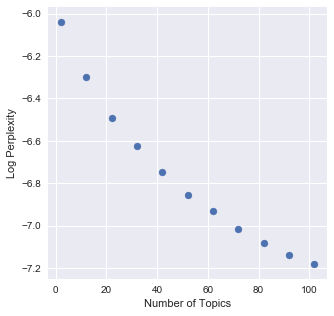

In [24]:
plt.figure(figsize=(5,5))
plt.scatter(x=topic_numbers,y=log_perplexity_scores.mean(axis=0))
plt.xlabel('Number of Topics')
plt.ylabel('Log Perplexity')

Text(0,0.5,'Topic Coherence')

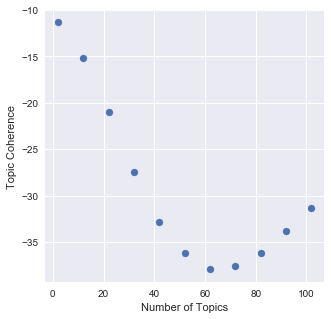

In [30]:
plt.figure(figsize=(5,5))
plt.scatter(x=topic_numbers,y=u_mass_coherences_test.mean(axis=0))
plt.xlabel('Number of Topics')
plt.ylabel('Topic Coherence')

Text(0,0.5,'U_Mass Topic Coherence')

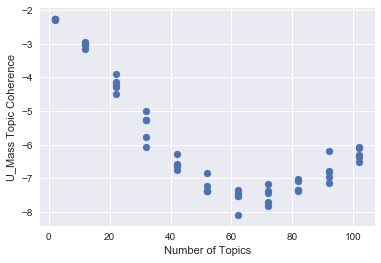

In [32]:
topics_for_plotting=topic_numbers
for i in range(4):
    topics_for_plotting = np.append(topics_for_plotting,topic_numbers)
    
plt.scatter(x=topics_for_plotting,y=u_mass_coherences_test.reshape(55))
plt.xlabel('Number of Topics')
plt.ylabel('U_Mass Topic Coherence')

Text(0,0.5,'Log Perplexity')

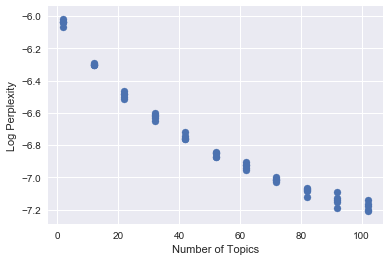

In [34]:
plt.scatter(x=topics_for_plotting,y=log_perplexity_scores.reshape(55))
plt.xlabel('Number of Topics')
plt.ylabel('Log Perplexity')

Text(0,0.5,'U_Mass Topic Coherence')

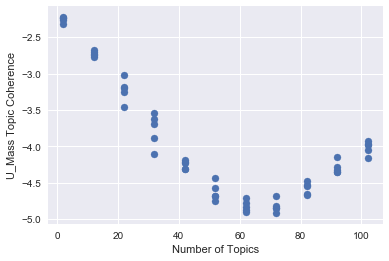

In [35]:
plt.scatter(x=topics_for_plotting,y=u_mass_coherences_train.reshape(55))
plt.xlabel('Number of Topics')
plt.ylabel('U_Mass Topic Coherence')

I'll try this again with higher resolution for the number of topics in the range of 2-20

In [43]:
topic_numbers_highres = np.linspace(2,20,19)
log_perplexity_scores_highres=np.zeros([5,19])
bound_perplexity_scores_highres = np.zeros([5,19])
u_mass_coherences_train_highres = np.zeros([5,19])
u_mass_coherences_test_highres = np.zeros([5,19])



for n_topics in topic_numbers_highres:
    count = 0
    for train,test in kf.split(corpus):
        start_time = time()
        
        train_corpus = [corpus[i] for i in train]
        test_corpus = [corpus[i] for i in test]
        
        lda = LdaModel(train_corpus,id2word=dictionary,num_topics=n_topics)
        print('done training')
            
        log_perplexity_scores_highres[count,int(n_topics-2)] = lda.log_perplexity(test_corpus)
        bound_perplexity_scores_highres[count,int(n_topics-2)]=lda.bound(test_corpus)
        
        cm_train = CoherenceModel(model=lda, corpus=train_corpus,dictionary=dictionary, coherence = 'u_mass')
        u_mass_coherences_train_highres[count,int(n_topics-2)]=cm_train.get_coherence()
        
        cm_test = CoherenceModel(model=lda, corpus=test_corpus,dictionary=dictionary, coherence = 'u_mass')
        u_mass_coherences_test_highres[count,int(n_topics-2)]=cm_test.get_coherence()

        count+=1
        print(time()-start_time)
        print('done with perplexity')
        print()

2018-01-30 12:21:14,127 : INFO : using symmetric alpha at 0.5
2018-01-30 12:21:14,131 : INFO : using symmetric eta at 0.0010482180293501049
2018-01-30 12:21:14,139 : INFO : using serial LDA version on this node
2018-01-30 12:21:14,167 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-30 12:21:14,171 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-30 12:21:18,749 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:21:18,762 : INFO : topic #0 (0.500): 0.027*"time" + 0.027*"great" + 0.018*"office" + 0.017*"professional" + 0.016*"staff" + 0.014*"friendly" + 0.013*"nice" + 0.012*"good" + 0.012*"appointment" + 0.012*"thorough"
2018-01-30 12:21:18,763 : INFO : topic #1 (0.500): 0.023*"time" + 0.018*"visit" + 0.016*"office" + 0.016*

2018-01-30 12:21:49,806 : INFO : PROGRESS: pass 0, at document #24000/28698
2018-01-30 12:21:51,949 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:21:51,951 : INFO : topic #0 (0.500): 0.041*"great" + 0.025*"office" + 0.024*"staff" + 0.023*"time" + 0.021*"professional" + 0.019*"friendly" + 0.019*"nice" + 0.017*"feel" + 0.014*"good" + 0.013*"thorough"
2018-01-30 12:21:51,953 : INFO : topic #1 (0.500): 0.022*"recommend" + 0.022*"time" + 0.017*"patient" + 0.016*"highly" + 0.016*"care" + 0.015*"visit" + 0.013*"thorough" + 0.011*"highly_recommend" + 0.011*"concern" + 0.011*"professional"
2018-01-30 12:21:51,955 : INFO : topic diff=0.119963, rho=0.288675
2018-01-30 12:21:51,960 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 12:21:53,975 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:21:53,977 : INFO : topic #0 (0.500): 0.040*"great" + 0.026*"staff" + 0.026*"office" + 0.025*"time" + 0.021*"p

done training


2018-01-30 12:22:10,770 : INFO : -6.077 per-word bound, 67.5 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-30 12:22:22,480 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:22:22,491 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:22:22,508 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:22:22,537 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:22:22,556 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:22:22,577 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:22:22,600 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:22:22,614 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:22:22,630 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:22:22,645 : INFO : CorpusAccumulator accum

69.05219888687134
done with perplexity



2018-01-30 12:22:27,565 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:22:27,567 : INFO : topic #0 (0.500): 0.022*"time" + 0.019*"professional" + 0.017*"patient" + 0.017*"office" + 0.014*"thorough" + 0.013*"nice" + 0.012*"highly" + 0.012*"question" + 0.012*"recommend" + 0.011*"staff"
2018-01-30 12:22:27,569 : INFO : topic #1 (0.500): 0.036*"great" + 0.019*"office" + 0.018*"time" + 0.018*"friendly" + 0.017*"staff" + 0.014*"professional" + 0.013*"recommend" + 0.013*"question" + 0.012*"feel" + 0.011*"really"
2018-01-30 12:22:27,570 : INFO : topic diff=1.078996, rho=1.000000
2018-01-30 12:22:27,572 : INFO : PROGRESS: pass 0, at document #4000/28698
2018-01-30 12:22:31,068 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:22:31,070 : INFO : topic #0 (0.500): 0.027*"time" + 0.019*"patient" + 0.018*"professional" + 0.016*"thorough" + 0.014*"office" + 0.013*"like" + 0.013*"good" + 0.012*"question" + 0.011*"nic

2018-01-30 12:22:56,771 : INFO : topic diff=0.129779, rho=0.288675
2018-01-30 12:22:56,772 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 12:22:58,386 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:22:58,389 : INFO : topic #0 (0.500): 0.035*"time" + 0.016*"office" + 0.016*"patient" + 0.014*"question" + 0.013*"appointment" + 0.012*"like" + 0.012*"wait" + 0.011*"took" + 0.010*"good" + 0.010*"thorough"
2018-01-30 12:22:58,391 : INFO : topic #1 (0.500): 0.052*"great" + 0.027*"professional" + 0.026*"recommend" + 0.024*"friendly" + 0.024*"staff" + 0.019*"highly" + 0.018*"thorough" + 0.017*"feel" + 0.015*"care" + 0.015*"office"
2018-01-30 12:22:58,392 : INFO : topic diff=0.128791, rho=0.277350
2018-01-30 12:22:58,394 : INFO : PROGRESS: pass 0, at document #28000/28698
2018-01-30 12:22:59,939 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:22:59,942 : INFO : topic #0 (0.500): 0.033*"time" + 0

done training


2018-01-30 12:23:12,116 : INFO : -6.039 per-word bound, 65.8 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-30 12:23:22,960 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:23:22,970 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:23:22,981 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:23:22,992 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:23:23,004 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:23:23,015 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:23:23,025 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:23:23,037 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:23:23,050 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:23:23,060 : INFO : CorpusAccumulator accum

60.358588218688965
done with perplexity



2018-01-30 12:23:28,003 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:23:28,005 : INFO : topic #0 (0.500): 0.031*"time" + 0.019*"office" + 0.017*"professional" + 0.017*"great" + 0.016*"friendly" + 0.014*"recommend" + 0.013*"highly" + 0.013*"staff" + 0.012*"appointment" + 0.011*"question"
2018-01-30 12:23:28,006 : INFO : topic #1 (0.500): 0.029*"great" + 0.016*"office" + 0.016*"professional" + 0.015*"staff" + 0.015*"thorough" + 0.015*"patient" + 0.014*"question" + 0.014*"feel" + 0.012*"nice" + 0.012*"friendly"
2018-01-30 12:23:28,008 : INFO : topic diff=1.084388, rho=1.000000
2018-01-30 12:23:28,010 : INFO : PROGRESS: pass 0, at document #4000/28698
2018-01-30 12:23:31,592 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:23:31,594 : INFO : topic #0 (0.500): 0.035*"time" + 0.016*"great" + 0.016*"professional" + 0.016*"office" + 0.016*"recommend" + 0.015*"friendly" + 0.013*"care" + 0.013*"highly" + 0.01

2018-01-30 12:24:02,343 : INFO : topic diff=0.120349, rho=0.288675
2018-01-30 12:24:02,345 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 12:24:04,499 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:24:04,501 : INFO : topic #0 (0.500): 0.046*"time" + 0.026*"recommend" + 0.020*"highly" + 0.018*"great" + 0.017*"wait" + 0.016*"care" + 0.015*"professional" + 0.014*"took" + 0.014*"patient" + 0.013*"highly_recommend"
2018-01-30 12:24:04,503 : INFO : topic #1 (0.500): 0.028*"great" + 0.020*"office" + 0.019*"staff" + 0.018*"visit" + 0.017*"feel" + 0.015*"professional" + 0.015*"thorough" + 0.014*"question" + 0.013*"nice" + 0.013*"friendly"
2018-01-30 12:24:04,505 : INFO : topic diff=0.121338, rho=0.277350
2018-01-30 12:24:04,507 : INFO : PROGRESS: pass 0, at document #28000/28698
2018-01-30 12:24:06,726 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:24:06,730 : INFO : topic #0 (0.500): 0.046*"

done training


2018-01-30 12:24:20,877 : INFO : -6.063 per-word bound, 66.9 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-30 12:24:33,090 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:24:33,101 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:24:33,112 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:24:33,129 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:24:33,149 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:24:33,166 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:24:33,177 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:24:33,187 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:24:33,202 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:24:33,214 : INFO : CorpusAccumulator accum

70.14282989501953
done with perplexity



2018-01-30 12:24:38,110 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:24:38,112 : INFO : topic #0 (0.500): 0.020*"staff" + 0.020*"office" + 0.020*"great" + 0.014*"highly" + 0.013*"thorough" + 0.013*"time" + 0.012*"professional" + 0.012*"recommend" + 0.012*"friendly" + 0.012*"visit"
2018-01-30 12:24:38,113 : INFO : topic #1 (0.500): 0.029*"time" + 0.027*"great" + 0.021*"professional" + 0.015*"friendly" + 0.015*"patient" + 0.015*"office" + 0.015*"question" + 0.013*"recommend" + 0.012*"really" + 0.011*"thorough"
2018-01-30 12:24:38,115 : INFO : topic diff=1.072265, rho=1.000000
2018-01-30 12:24:38,117 : INFO : PROGRESS: pass 0, at document #4000/28699
2018-01-30 12:24:41,686 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:24:41,688 : INFO : topic #0 (0.500): 0.023*"great" + 0.019*"staff" + 0.018*"office" + 0.015*"visit" + 0.015*"thorough" + 0.014*"highly" + 0.014*"recommend" + 0.013*"friendly" + 0.012*

2018-01-30 12:25:08,999 : INFO : topic diff=0.127559, rho=0.288675
2018-01-30 12:25:09,001 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 12:25:10,604 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:25:10,607 : INFO : topic #0 (0.500): 0.041*"great" + 0.030*"professional" + 0.027*"recommend" + 0.025*"staff" + 0.024*"thorough" + 0.023*"highly" + 0.022*"friendly" + 0.018*"office" + 0.017*"visit" + 0.017*"feel"
2018-01-30 12:25:10,609 : INFO : topic #1 (0.500): 0.037*"time" + 0.015*"question" + 0.014*"office" + 0.014*"patient" + 0.014*"appointment" + 0.013*"wait" + 0.011*"took" + 0.010*"really" + 0.010*"concern" + 0.010*"great"
2018-01-30 12:25:10,610 : INFO : topic diff=0.128868, rho=0.277350
2018-01-30 12:25:10,612 : INFO : PROGRESS: pass 0, at document #28000/28699
2018-01-30 12:25:12,090 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:25:12,093 : INFO : topic #0 (0.500): 0.042*"great"

done training


2018-01-30 12:25:25,377 : INFO : -6.026 per-word bound, 65.2 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-30 12:25:36,119 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:25:36,131 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:25:36,142 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:25:36,158 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:25:36,176 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:25:36,190 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:25:36,203 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:25:36,214 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:25:36,229 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:25:36,241 : INFO : CorpusAccumulator accum

63.03273105621338
done with perplexity



2018-01-30 12:25:41,110 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:25:41,112 : INFO : topic #0 (0.500): 0.024*"time" + 0.022*"professional" + 0.016*"friendly" + 0.016*"staff" + 0.016*"thorough" + 0.014*"great" + 0.014*"office" + 0.013*"nice" + 0.012*"patient" + 0.012*"highly"
2018-01-30 12:25:41,114 : INFO : topic #1 (0.500): 0.030*"great" + 0.021*"office" + 0.017*"time" + 0.016*"question" + 0.014*"recommend" + 0.013*"staff" + 0.012*"professional" + 0.012*"visit" + 0.011*"friendly" + 0.011*"patient"
2018-01-30 12:25:41,116 : INFO : topic diff=1.072886, rho=1.000000
2018-01-30 12:25:41,118 : INFO : PROGRESS: pass 0, at document #4000/28699
2018-01-30 12:25:45,942 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:25:45,944 : INFO : topic #0 (0.500): 0.026*"time" + 0.022*"professional" + 0.017*"thorough" + 0.016*"friendly" + 0.014*"staff" + 0.014*"great" + 0.013*"patient" + 0.013*"nice" + 0.012*"offic

2018-01-30 12:26:17,556 : INFO : topic diff=0.144321, rho=0.288675
2018-01-30 12:26:17,558 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 12:26:19,716 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:26:19,719 : INFO : topic #0 (0.500): 0.023*"office" + 0.022*"time" + 0.015*"staff" + 0.015*"appointment" + 0.015*"nice" + 0.014*"professional" + 0.013*"friendly" + 0.012*"feel" + 0.012*"manner" + 0.011*"like"
2018-01-30 12:26:19,721 : INFO : topic #1 (0.500): 0.041*"great" + 0.023*"time" + 0.022*"recommend" + 0.019*"question" + 0.019*"highly" + 0.019*"care" + 0.018*"professional" + 0.017*"thorough" + 0.016*"visit" + 0.016*"patient"
2018-01-30 12:26:19,722 : INFO : topic diff=0.132048, rho=0.277350
2018-01-30 12:26:19,724 : INFO : PROGRESS: pass 0, at document #28000/28699
2018-01-30 12:26:21,842 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:26:21,845 : INFO : topic #0 (0.500): 0.023*"offi

done training


2018-01-30 12:26:43,964 : INFO : -6.051 per-word bound, 66.3 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-30 12:26:57,974 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:26:57,985 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:26:57,997 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:26:58,014 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:26:58,024 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:26:58,035 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:26:58,046 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:26:58,057 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:26:58,068 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:26:58,080 : INFO : CorpusAccumulator accum

81.91965508460999
done with perplexity



2018-01-30 12:27:03,096 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:27:03,100 : INFO : topic #0 (0.333): 0.022*"time" + 0.021*"friendly" + 0.020*"professional" + 0.015*"staff" + 0.014*"good" + 0.013*"appointment" + 0.012*"office" + 0.012*"helpful" + 0.012*"wait" + 0.011*"visit"
2018-01-30 12:27:03,102 : INFO : topic #1 (0.333): 0.031*"time" + 0.026*"great" + 0.016*"recommend" + 0.016*"professional" + 0.015*"office" + 0.014*"care" + 0.013*"feel" + 0.013*"wait" + 0.012*"appointment" + 0.011*"friendly"
2018-01-30 12:27:03,103 : INFO : topic #2 (0.333): 0.023*"office" + 0.022*"great" + 0.022*"time" + 0.016*"patient" + 0.015*"nice" + 0.014*"visit" + 0.014*"thorough" + 0.013*"really" + 0.012*"wait" + 0.011*"appointment"
2018-01-30 12:27:03,105 : INFO : topic diff=1.244153, rho=1.000000
2018-01-30 12:27:03,107 : INFO : PROGRESS: pass 0, at document #4000/28698
2018-01-30 12:27:06,834 : INFO : merging changes from 2000 documents into a model of 28

2018-01-30 12:27:33,045 : INFO : PROGRESS: pass 0, at document #20000/28698
2018-01-30 12:27:35,710 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:27:35,715 : INFO : topic #0 (0.333): 0.038*"professional" + 0.025*"friendly" + 0.023*"staff" + 0.019*"good" + 0.017*"thorough" + 0.016*"helpful" + 0.016*"best" + 0.014*"time" + 0.014*"office" + 0.013*"visit"
2018-01-30 12:27:35,716 : INFO : topic #1 (0.333): 0.042*"great" + 0.031*"recommend" + 0.030*"time" + 0.026*"feel" + 0.025*"care" + 0.021*"highly" + 0.018*"highly_recommend" + 0.017*"patient" + 0.017*"manner" + 0.016*"question"
2018-01-30 12:27:35,718 : INFO : topic #2 (0.333): 0.029*"office" + 0.021*"time" + 0.021*"great" + 0.017*"nice" + 0.015*"staff" + 0.015*"appointment" + 0.014*"visit" + 0.013*"wait" + 0.012*"experience" + 0.011*"patient"
2018-01-30 12:27:35,719 : INFO : topic diff=0.160416, rho=0.316228
2018-01-30 12:27:35,721 : INFO : PROGRESS: pass 0, at document #22000/28698
2018-01-30

done training


2018-01-30 12:28:04,114 : INFO : -6.107 per-word bound, 68.9 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-30 12:28:17,710 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:28:17,721 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:28:17,733 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:28:17,746 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:28:17,756 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:28:17,767 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:28:17,779 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:28:17,788 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:28:17,799 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:28:17,809 : INFO : CorpusAccumulator accum

79.59864211082458
done with perplexity



2018-01-30 12:28:22,372 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:28:22,375 : INFO : topic #0 (0.333): 0.020*"office" + 0.019*"nice" + 0.017*"professional" + 0.016*"patient" + 0.016*"time" + 0.016*"question" + 0.015*"great" + 0.012*"concern" + 0.012*"really" + 0.011*"visit"
2018-01-30 12:28:22,376 : INFO : topic #1 (0.333): 0.025*"great" + 0.025*"professional" + 0.025*"highly" + 0.025*"recommend" + 0.023*"time" + 0.015*"highly_recommend" + 0.015*"feel" + 0.014*"patient" + 0.013*"friendly" + 0.013*"thorough"
2018-01-30 12:28:22,378 : INFO : topic #2 (0.333): 0.027*"great" + 0.022*"staff" + 0.022*"time" + 0.021*"office" + 0.020*"friendly" + 0.014*"thorough" + 0.013*"experience" + 0.013*"question" + 0.010*"appointment" + 0.010*"like"
2018-01-30 12:28:22,380 : INFO : topic diff=1.272677, rho=1.000000
2018-01-30 12:28:22,382 : INFO : PROGRESS: pass 0, at document #4000/28698
2018-01-30 12:28:25,728 : INFO : merging changes from 2000 documents

2018-01-30 12:28:48,502 : INFO : -6.034 per-word bound, 65.5 perplexity estimate based on a held-out corpus of 2000 documents with 20866 words
2018-01-30 12:28:48,504 : INFO : PROGRESS: pass 0, at document #20000/28698
2018-01-30 12:28:50,664 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:28:50,670 : INFO : topic #0 (0.333): 0.024*"care" + 0.023*"time" + 0.019*"patient" + 0.018*"question" + 0.016*"really" + 0.016*"feel" + 0.015*"like" + 0.014*"took" + 0.014*"concern" + 0.014*"nice"
2018-01-30 12:28:50,671 : INFO : topic #1 (0.333): 0.048*"great" + 0.043*"professional" + 0.042*"recommend" + 0.033*"highly" + 0.024*"thorough" + 0.024*"friendly" + 0.022*"highly_recommend" + 0.021*"time" + 0.020*"excellent" + 0.019*"staff"
2018-01-30 12:28:50,673 : INFO : topic #2 (0.333): 0.030*"office" + 0.023*"time" + 0.020*"staff" + 0.019*"wait" + 0.018*"appointment" + 0.017*"great" + 0.012*"friendly" + 0.012*"visit" + 0.011*"minute" + 0.010*"experience"
2018-

done training


2018-01-30 12:29:13,504 : INFO : -6.065 per-word bound, 66.9 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-30 12:29:25,828 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:29:25,839 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:29:25,848 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:29:25,858 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:29:25,867 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:29:25,879 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:29:25,888 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:29:25,899 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:29:25,910 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:29:25,919 : INFO : CorpusAccumulator accum

68.08591485023499
done with perplexity



2018-01-30 12:29:30,382 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:29:30,385 : INFO : topic #0 (0.333): 0.029*"professional" + 0.023*"friendly" + 0.017*"recommend" + 0.017*"highly" + 0.017*"good" + 0.016*"manner" + 0.015*"great" + 0.014*"time" + 0.013*"bedside" + 0.012*"highly_recommend"
2018-01-30 12:29:30,386 : INFO : topic #1 (0.333): 0.026*"time" + 0.022*"great" + 0.021*"staff" + 0.017*"office" + 0.015*"thorough" + 0.015*"nice" + 0.014*"visit" + 0.014*"friendly" + 0.012*"care" + 0.012*"professional"
2018-01-30 12:29:30,388 : INFO : topic #2 (0.333): 0.031*"great" + 0.024*"office" + 0.017*"question" + 0.015*"professional" + 0.015*"time" + 0.015*"like" + 0.015*"patient" + 0.013*"recommend" + 0.012*"appointment" + 0.012*"really"
2018-01-30 12:29:30,390 : INFO : topic diff=1.270011, rho=1.000000
2018-01-30 12:29:30,391 : INFO : PROGRESS: pass 0, at document #4000/28698
2018-01-30 12:29:33,721 : INFO : merging changes from 2000 documents i

2018-01-30 12:29:56,088 : INFO : -6.034 per-word bound, 65.5 perplexity estimate based on a held-out corpus of 2000 documents with 20866 words
2018-01-30 12:29:56,089 : INFO : PROGRESS: pass 0, at document #20000/28698
2018-01-30 12:29:58,346 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:29:58,351 : INFO : topic #0 (0.333): 0.039*"highly" + 0.039*"recommend" + 0.036*"professional" + 0.032*"great" + 0.027*"highly_recommend" + 0.026*"excellent" + 0.023*"manner" + 0.021*"thorough" + 0.018*"good" + 0.018*"bedside"
2018-01-30 12:29:58,353 : INFO : topic #1 (0.333): 0.034*"staff" + 0.031*"great" + 0.028*"time" + 0.023*"office" + 0.023*"care" + 0.022*"friendly" + 0.020*"visit" + 0.019*"feel" + 0.019*"nice" + 0.018*"professional"
2018-01-30 12:29:58,354 : INFO : topic #2 (0.333): 0.027*"time" + 0.018*"office" + 0.018*"appointment" + 0.015*"question" + 0.014*"like" + 0.014*"wait" + 0.012*"great" + 0.012*"patient" + 0.011*"minute" + 0.010*"test"
2018-

done training


2018-01-30 12:30:23,221 : INFO : -6.061 per-word bound, 66.7 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-30 12:30:36,168 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:30:36,177 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:30:36,187 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:30:36,196 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:30:36,207 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:30:36,217 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:30:36,227 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:30:36,237 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:30:36,247 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:30:36,257 : INFO : CorpusAccumulator accum

70.34286212921143
done with perplexity



2018-01-30 12:30:40,904 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:30:40,907 : INFO : topic #0 (0.333): 0.029*"time" + 0.021*"professional" + 0.020*"office" + 0.015*"feel" + 0.015*"staff" + 0.013*"appointment" + 0.010*"great" + 0.010*"manner" + 0.010*"patient" + 0.010*"question"
2018-01-30 12:30:40,908 : INFO : topic #1 (0.333): 0.032*"great" + 0.020*"nice" + 0.020*"recommend" + 0.019*"friendly" + 0.017*"staff" + 0.016*"office" + 0.016*"thorough" + 0.014*"highly" + 0.013*"patient" + 0.012*"really"
2018-01-30 12:30:40,910 : INFO : topic #2 (0.333): 0.025*"time" + 0.024*"great" + 0.019*"professional" + 0.018*"office" + 0.017*"visit" + 0.017*"question" + 0.015*"friendly" + 0.014*"thorough" + 0.012*"care" + 0.012*"helpful"
2018-01-30 12:30:40,912 : INFO : topic diff=1.276056, rho=1.000000
2018-01-30 12:30:40,914 : INFO : PROGRESS: pass 0, at document #4000/28699
2018-01-30 12:30:44,338 : INFO : merging changes from 2000 documents into a model

2018-01-30 12:31:06,786 : INFO : PROGRESS: pass 0, at document #20000/28699
2018-01-30 12:31:09,086 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:31:09,094 : INFO : topic #0 (0.333): 0.029*"time" + 0.026*"office" + 0.022*"appointment" + 0.021*"wait" + 0.015*"minute" + 0.012*"blood" + 0.011*"like" + 0.010*"staff" + 0.010*"physical" + 0.009*"went"
2018-01-30 12:31:09,096 : INFO : topic #1 (0.333): 0.048*"great" + 0.033*"recommend" + 0.031*"professional" + 0.026*"highly" + 0.024*"friendly" + 0.022*"thorough" + 0.020*"staff" + 0.018*"highly_recommend" + 0.018*"feel" + 0.017*"nice"
2018-01-30 12:31:09,097 : INFO : topic #2 (0.333): 0.037*"time" + 0.029*"question" + 0.023*"visit" + 0.017*"care" + 0.017*"concern" + 0.017*"best" + 0.016*"great" + 0.016*"patient" + 0.015*"took" + 0.014*"professional"
2018-01-30 12:31:09,099 : INFO : topic diff=0.171063, rho=0.316228
2018-01-30 12:31:09,101 : INFO : PROGRESS: pass 0, at document #22000/28699
2018-01-3

done training


2018-01-30 12:31:32,055 : INFO : -6.060 per-word bound, 66.7 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-30 12:31:44,328 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:31:44,337 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:31:44,348 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:31:44,357 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:31:44,366 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:31:44,376 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:31:44,385 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:31:44,396 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:31:44,406 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:31:44,416 : INFO : CorpusAccumulator accum

68.14589381217957
done with perplexity



2018-01-30 12:31:49,126 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:31:49,130 : INFO : topic #0 (0.333): 0.034*"great" + 0.026*"staff" + 0.025*"office" + 0.024*"professional" + 0.017*"friendly" + 0.013*"feel" + 0.013*"like" + 0.012*"nice" + 0.011*"helpful" + 0.011*"visit"
2018-01-30 12:31:49,132 : INFO : topic #1 (0.333): 0.019*"great" + 0.019*"question" + 0.017*"experience" + 0.015*"professional" + 0.014*"office" + 0.014*"appointment" + 0.014*"time" + 0.014*"patient" + 0.013*"thorough" + 0.011*"care"
2018-01-30 12:31:49,133 : INFO : topic #2 (0.333): 0.030*"time" + 0.018*"recommend" + 0.017*"great" + 0.015*"highly" + 0.014*"office" + 0.013*"patient" + 0.013*"question" + 0.013*"thorough" + 0.012*"nice" + 0.012*"friendly"
2018-01-30 12:31:49,135 : INFO : topic diff=1.273885, rho=1.000000
2018-01-30 12:31:49,137 : INFO : PROGRESS: pass 0, at document #4000/28699
2018-01-30 12:31:52,549 : INFO : merging changes from 2000 documents into a mode

2018-01-30 12:32:11,670 : INFO : topic diff=0.167680, rho=0.333333
2018-01-30 12:32:15,359 : INFO : -6.019 per-word bound, 64.8 perplexity estimate based on a held-out corpus of 2000 documents with 21283 words
2018-01-30 12:32:15,360 : INFO : PROGRESS: pass 0, at document #20000/28699
2018-01-30 12:32:17,712 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:32:17,717 : INFO : topic #0 (0.333): 0.053*"great" + 0.043*"professional" + 0.035*"staff" + 0.034*"friendly" + 0.032*"office" + 0.025*"nice" + 0.023*"feel" + 0.021*"efficient" + 0.020*"visit" + 0.019*"thorough"
2018-01-30 12:32:17,718 : INFO : topic #1 (0.333): 0.027*"care" + 0.020*"best" + 0.020*"patient" + 0.017*"question" + 0.017*"excellent" + 0.015*"good" + 0.014*"great" + 0.013*"thorough" + 0.013*"primary" + 0.012*"physician"
2018-01-30 12:32:17,720 : INFO : topic #2 (0.333): 0.040*"time" + 0.025*"recommend" + 0.020*"highly" + 0.015*"highly_recommend" + 0.013*"appointment" + 0.013*"offic

done training


2018-01-30 12:32:41,276 : INFO : -6.099 per-word bound, 68.5 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-30 12:32:54,285 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:32:54,294 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:32:54,304 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:32:54,316 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:32:54,329 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:32:54,339 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:32:54,351 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:32:54,363 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:32:54,372 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:32:54,386 : INFO : CorpusAccumulator accum

69.98655891418457
done with perplexity



2018-01-30 12:32:58,551 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:32:58,554 : INFO : topic #0 (0.250): 0.027*"time" + 0.026*"wait" + 0.022*"office" + 0.019*"great" + 0.016*"appointment" + 0.014*"nice" + 0.013*"visit" + 0.013*"minute" + 0.012*"efficient" + 0.012*"staff"
2018-01-30 12:32:58,556 : INFO : topic #1 (0.250): 0.022*"office" + 0.021*"professional" + 0.017*"thorough" + 0.017*"question" + 0.017*"great" + 0.016*"staff" + 0.015*"friendly" + 0.013*"time" + 0.013*"like" + 0.012*"nice"
2018-01-30 12:32:58,558 : INFO : topic #2 (0.250): 0.031*"great" + 0.020*"time" + 0.020*"recommend" + 0.016*"highly" + 0.015*"professional" + 0.014*"good" + 0.014*"office" + 0.014*"care" + 0.012*"staff" + 0.012*"visit"
2018-01-30 12:32:58,560 : INFO : topic #3 (0.250): 0.043*"time" + 0.020*"friendly" + 0.018*"patient" + 0.016*"appointment" + 0.016*"really" + 0.014*"office" + 0.012*"thorough" + 0.012*"visit" + 0.011*"feel" + 0.011*"professional"
2018-01-3

2018-01-30 12:33:17,366 : INFO : topic #1 (0.250): 0.036*"professional" + 0.030*"great" + 0.030*"question" + 0.027*"staff" + 0.027*"friendly" + 0.026*"thorough" + 0.025*"nice" + 0.024*"office" + 0.016*"helpful" + 0.016*"manner"
2018-01-30 12:33:17,368 : INFO : topic #2 (0.250): 0.047*"great" + 0.042*"recommend" + 0.039*"highly" + 0.027*"highly_recommend" + 0.025*"care" + 0.021*"professional" + 0.019*"excellent" + 0.017*"thorough" + 0.016*"primary" + 0.016*"visit"
2018-01-30 12:33:17,370 : INFO : topic #3 (0.250): 0.052*"time" + 0.021*"patient" + 0.020*"really" + 0.020*"took" + 0.020*"feel" + 0.016*"took_time" + 0.015*"concern" + 0.013*"like" + 0.012*"question" + 0.012*"take"
2018-01-30 12:33:17,372 : INFO : topic diff=0.216267, rho=0.353553
2018-01-30 12:33:17,373 : INFO : PROGRESS: pass 0, at document #18000/28698
2018-01-30 12:33:19,707 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:33:19,715 : INFO : topic #0 (0.250): 0.027*"office" + 0.02

2018-01-30 12:33:36,940 : INFO : topic #1 (0.250): 0.041*"professional" + 0.038*"friendly" + 0.037*"great" + 0.035*"staff" + 0.029*"nice" + 0.028*"office" + 0.027*"thorough" + 0.024*"question" + 0.022*"helpful" + 0.019*"manner"
2018-01-30 12:33:36,941 : INFO : topic #2 (0.250): 0.049*"recommend" + 0.048*"great" + 0.047*"highly" + 0.031*"highly_recommend" + 0.027*"care" + 0.022*"excellent" + 0.021*"professional" + 0.019*"primary" + 0.018*"physician" + 0.018*"thorough"
2018-01-30 12:33:36,943 : INFO : topic #3 (0.250): 0.053*"time" + 0.023*"took" + 0.022*"feel" + 0.021*"patient" + 0.020*"really" + 0.016*"took_time" + 0.016*"concern" + 0.016*"question" + 0.014*"medical" + 0.013*"like"
2018-01-30 12:33:36,945 : INFO : topic diff=0.192541, rho=0.258199


done training


2018-01-30 12:33:49,591 : INFO : -6.094 per-word bound, 68.3 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-30 12:34:03,069 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:34:03,079 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:34:03,092 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:34:03,102 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:34:03,111 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:34:03,122 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:34:03,135 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:34:03,147 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:34:03,162 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:34:03,172 : INFO : CorpusAccumulator accum

68.80463099479675
done with perplexity



2018-01-30 12:34:07,231 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:34:07,234 : INFO : topic #0 (0.250): 0.040*"great" + 0.020*"professional" + 0.015*"friendly" + 0.015*"staff" + 0.015*"office" + 0.013*"feel" + 0.013*"helpful" + 0.013*"question" + 0.012*"highly" + 0.011*"appointment"
2018-01-30 12:34:07,236 : INFO : topic #1 (0.250): 0.021*"friendly" + 0.018*"thorough" + 0.018*"recommend" + 0.017*"office" + 0.017*"professional" + 0.016*"highly" + 0.015*"really" + 0.014*"time" + 0.013*"good" + 0.012*"question"
2018-01-30 12:34:07,238 : INFO : topic #2 (0.250): 0.034*"great" + 0.023*"professional" + 0.022*"thorough" + 0.021*"recommend" + 0.020*"patient" + 0.015*"time" + 0.013*"nice" + 0.013*"concern" + 0.012*"excellent" + 0.012*"manner"
2018-01-30 12:34:07,239 : INFO : topic #3 (0.250): 0.033*"time" + 0.022*"office" + 0.021*"great" + 0.021*"staff" + 0.017*"nice" + 0.014*"question" + 0.013*"patient" + 0.012*"professional" + 0.011*"visit" + 0.

2018-01-30 12:34:24,867 : INFO : topic #0 (0.250): 0.062*"great" + 0.043*"feel" + 0.030*"comfortable" + 0.025*"friendly" + 0.022*"professional" + 0.018*"staff" + 0.018*"make" + 0.017*"helpful" + 0.016*"feel_comfortable" + 0.016*"question"
2018-01-30 12:34:24,868 : INFO : topic #1 (0.250): 0.020*"care" + 0.020*"highly" + 0.019*"recommend" + 0.019*"easy" + 0.017*"best" + 0.017*"question" + 0.016*"friendly" + 0.016*"good" + 0.015*"thorough" + 0.015*"visit"
2018-01-30 12:34:24,870 : INFO : topic #2 (0.250): 0.040*"great" + 0.039*"recommend" + 0.037*"professional" + 0.034*"thorough" + 0.025*"manner" + 0.025*"excellent" + 0.025*"patient" + 0.024*"highly" + 0.021*"bedside" + 0.021*"bedside_manner"
2018-01-30 12:34:24,872 : INFO : topic #3 (0.250): 0.037*"time" + 0.026*"office" + 0.017*"wait" + 0.016*"appointment" + 0.013*"took" + 0.013*"staff" + 0.012*"nice" + 0.012*"visit" + 0.011*"question" + 0.011*"like"
2018-01-30 12:34:24,874 : INFO : topic diff=0.211867, rho=0.353553
2018-01-30 12:34:24

2018-01-30 12:35:45,843 : INFO : merging changes from 698 documents into a model of 28698 documents
2018-01-30 12:35:45,850 : INFO : topic #0 (0.250): 0.064*"great" + 0.051*"feel" + 0.033*"comfortable" + 0.025*"friendly" + 0.023*"staff" + 0.021*"make" + 0.020*"professional" + 0.019*"helpful" + 0.018*"felt" + 0.018*"like"
2018-01-30 12:35:45,853 : INFO : topic #1 (0.250): 0.028*"care" + 0.022*"best" + 0.020*"easy" + 0.017*"primary" + 0.017*"talk" + 0.016*"highly" + 0.016*"recommended" + 0.016*"question" + 0.015*"thorough" + 0.014*"visit"
2018-01-30 12:35:45,855 : INFO : topic #2 (0.250): 0.048*"recommend" + 0.040*"great" + 0.037*"professional" + 0.032*"thorough" + 0.032*"highly" + 0.029*"excellent" + 0.026*"highly_recommend" + 0.025*"manner" + 0.024*"patient" + 0.019*"bedside"
2018-01-30 12:35:45,857 : INFO : topic #3 (0.250): 0.038*"time" + 0.025*"office" + 0.020*"wait" + 0.018*"appointment" + 0.015*"took" + 0.012*"minute" + 0.011*"staff" + 0.010*"visit" + 0.010*"nice" + 0.010*"test"
2

done training


2018-01-30 12:36:00,424 : INFO : -6.116 per-word bound, 69.4 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-30 12:36:14,152 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:36:14,163 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:36:14,178 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:36:14,212 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:36:14,255 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:36:14,284 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:36:14,300 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:36:14,314 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:36:14,328 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:36:14,345 : INFO : CorpusAccumulator accum

131.30077004432678
done with perplexity



2018-01-30 12:36:18,774 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:36:18,778 : INFO : topic #0 (0.250): 0.019*"nice" + 0.017*"visit" + 0.015*"appointment" + 0.014*"like" + 0.013*"time" + 0.012*"nurse" + 0.012*"great" + 0.012*"staff" + 0.011*"patient" + 0.010*"wait"
2018-01-30 12:36:18,780 : INFO : topic #1 (0.250): 0.034*"office" + 0.024*"professional" + 0.020*"time" + 0.018*"patient" + 0.017*"question" + 0.017*"great" + 0.016*"thorough" + 0.016*"staff" + 0.013*"nice" + 0.013*"friendly"
2018-01-30 12:36:18,782 : INFO : topic #2 (0.250): 0.044*"great" + 0.026*"recommend" + 0.022*"highly" + 0.020*"highly_recommend" + 0.018*"friendly" + 0.017*"time" + 0.016*"professional" + 0.015*"good" + 0.014*"staff" + 0.014*"experience"
2018-01-30 12:36:18,784 : INFO : topic #3 (0.250): 0.027*"time" + 0.020*"great" + 0.016*"really" + 0.016*"friendly" + 0.016*"care" + 0.016*"feel" + 0.015*"question" + 0.013*"staff" + 0.012*"recommend" + 0.012*"professional

2018-01-30 12:36:37,108 : INFO : topic #1 (0.250): 0.035*"office" + 0.033*"professional" + 0.032*"staff" + 0.027*"question" + 0.026*"friendly" + 0.023*"helpful" + 0.022*"thorough" + 0.018*"nice" + 0.017*"time" + 0.016*"visit"
2018-01-30 12:36:37,110 : INFO : topic #2 (0.250): 0.075*"great" + 0.057*"recommend" + 0.044*"highly" + 0.036*"highly_recommend" + 0.028*"professional" + 0.028*"excellent" + 0.027*"manner" + 0.023*"bedside" + 0.022*"bedside_manner" + 0.021*"good"
2018-01-30 12:36:37,112 : INFO : topic #3 (0.250): 0.033*"feel" + 0.031*"care" + 0.027*"time" + 0.021*"best" + 0.020*"really" + 0.017*"comfortable" + 0.017*"make" + 0.016*"great" + 0.016*"patient" + 0.015*"primary"
2018-01-30 12:36:37,114 : INFO : topic diff=0.204301, rho=0.353553
2018-01-30 12:36:37,116 : INFO : PROGRESS: pass 0, at document #18000/28698
2018-01-30 12:36:39,384 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:36:39,391 : INFO : topic #0 (0.250): 0.029*"time" + 0.

2018-01-30 12:36:55,698 : INFO : topic #1 (0.250): 0.040*"professional" + 0.039*"staff" + 0.037*"friendly" + 0.036*"office" + 0.028*"helpful" + 0.025*"question" + 0.025*"thorough" + 0.025*"nice" + 0.019*"visit" + 0.016*"efficient"
2018-01-30 12:36:55,700 : INFO : topic #2 (0.250): 0.086*"great" + 0.068*"recommend" + 0.054*"highly" + 0.040*"highly_recommend" + 0.035*"excellent" + 0.031*"manner" + 0.026*"professional" + 0.024*"bedside" + 0.024*"bedside_manner" + 0.023*"thorough"
2018-01-30 12:36:55,702 : INFO : topic #3 (0.250): 0.033*"feel" + 0.032*"time" + 0.030*"care" + 0.020*"best" + 0.019*"really" + 0.019*"comfortable" + 0.017*"patient" + 0.016*"took" + 0.015*"make" + 0.015*"primary"
2018-01-30 12:36:55,704 : INFO : topic diff=0.188850, rho=0.258199


done training


2018-01-30 12:37:07,777 : INFO : -6.083 per-word bound, 67.8 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-30 12:37:20,069 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:37:20,079 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:37:20,094 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:37:20,109 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:37:20,135 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:37:20,174 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:37:20,194 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:37:20,234 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:37:20,278 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:37:20,293 : INFO : CorpusAccumulator accum

65.96300101280212
done with perplexity



2018-01-30 12:37:24,495 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:37:24,499 : INFO : topic #0 (0.250): 0.025*"time" + 0.023*"patient" + 0.021*"great" + 0.018*"good" + 0.018*"thorough" + 0.016*"feel" + 0.013*"visit" + 0.011*"comfortable" + 0.011*"friendly" + 0.011*"care"
2018-01-30 12:37:24,500 : INFO : topic #1 (0.250): 0.025*"great" + 0.020*"time" + 0.018*"office" + 0.018*"staff" + 0.018*"question" + 0.017*"friendly" + 0.016*"professional" + 0.013*"experience" + 0.012*"appointment" + 0.012*"thorough"
2018-01-30 12:37:24,502 : INFO : topic #2 (0.250): 0.036*"professional" + 0.031*"office" + 0.018*"thorough" + 0.018*"great" + 0.018*"staff" + 0.015*"friendly" + 0.015*"time" + 0.013*"nice" + 0.013*"feel" + 0.012*"helpful"
2018-01-30 12:37:24,504 : INFO : topic #3 (0.250): 0.026*"great" + 0.022*"recommend" + 0.021*"time" + 0.020*"really" + 0.017*"nice" + 0.017*"highly" + 0.015*"visit" + 0.015*"excellent" + 0.014*"like" + 0.014*"office"
2018-

2018-01-30 12:37:43,220 : INFO : topic #1 (0.250): 0.025*"time" + 0.020*"appointment" + 0.019*"office" + 0.016*"question" + 0.014*"minute" + 0.011*"wait" + 0.010*"staff" + 0.010*"great" + 0.009*"went" + 0.009*"blood"
2018-01-30 12:37:43,222 : INFO : topic #2 (0.250): 0.057*"professional" + 0.042*"office" + 0.035*"staff" + 0.028*"friendly" + 0.023*"helpful" + 0.022*"thorough" + 0.021*"nice" + 0.021*"great" + 0.016*"visit" + 0.014*"right"
2018-01-30 12:37:43,224 : INFO : topic #3 (0.250): 0.050*"recommend" + 0.048*"great" + 0.036*"highly" + 0.028*"highly_recommend" + 0.027*"time" + 0.024*"excellent" + 0.018*"really" + 0.016*"visit" + 0.014*"question" + 0.014*"manner"
2018-01-30 12:37:43,225 : INFO : topic diff=0.204735, rho=0.353553
2018-01-30 12:37:43,227 : INFO : PROGRESS: pass 0, at document #18000/28699
2018-01-30 12:37:45,624 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:37:45,632 : INFO : topic #0 (0.250): 0.028*"care" + 0.027*"feel" + 0

2018-01-30 12:38:02,243 : INFO : topic #1 (0.250): 0.026*"time" + 0.020*"office" + 0.020*"appointment" + 0.014*"wait" + 0.014*"minute" + 0.011*"test" + 0.011*"question" + 0.010*"blood" + 0.010*"went" + 0.009*"hour"
2018-01-30 12:38:02,245 : INFO : topic #2 (0.250): 0.063*"professional" + 0.054*"staff" + 0.050*"office" + 0.044*"friendly" + 0.031*"great" + 0.029*"helpful" + 0.028*"nice" + 0.025*"thorough" + 0.019*"visit" + 0.018*"efficient"
2018-01-30 12:38:02,248 : INFO : topic #3 (0.250): 0.061*"recommend" + 0.054*"great" + 0.047*"highly" + 0.032*"highly_recommend" + 0.028*"excellent" + 0.026*"time" + 0.021*"manner" + 0.019*"thorough" + 0.017*"question" + 0.017*"bedside"
2018-01-30 12:38:02,249 : INFO : topic diff=0.190549, rho=0.258199


done training


2018-01-30 12:38:16,577 : INFO : -6.109 per-word bound, 69.0 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-30 12:38:31,289 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:38:31,302 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:38:31,314 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:38:31,356 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:38:31,378 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:38:31,399 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:38:31,411 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:38:31,426 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:38:31,441 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:38:31,458 : INFO : CorpusAccumulator accum

71.14695286750793
done with perplexity



2018-01-30 12:38:35,604 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:38:35,608 : INFO : topic #0 (0.250): 0.026*"great" + 0.025*"time" + 0.025*"professional" + 0.018*"question" + 0.018*"recommend" + 0.017*"highly" + 0.016*"appointment" + 0.014*"manner" + 0.013*"thorough" + 0.013*"patient"
2018-01-30 12:38:35,610 : INFO : topic #1 (0.250): 0.026*"time" + 0.019*"professional" + 0.017*"office" + 0.016*"staff" + 0.016*"friendly" + 0.014*"great" + 0.013*"wait" + 0.013*"good" + 0.012*"thorough" + 0.012*"question"
2018-01-30 12:38:35,612 : INFO : topic #2 (0.250): 0.024*"office" + 0.017*"staff" + 0.015*"patient" + 0.013*"went" + 0.012*"kind" + 0.012*"like" + 0.012*"nice" + 0.012*"thorough" + 0.011*"professional" + 0.011*"care"
2018-01-30 12:38:35,613 : INFO : topic #3 (0.250): 0.032*"great" + 0.024*"office" + 0.021*"friendly" + 0.020*"time" + 0.018*"staff" + 0.018*"nice" + 0.018*"feel" + 0.014*"visit" + 0.013*"experience" + 0.013*"recommend"
2018-

2018-01-30 12:38:53,504 : INFO : topic #1 (0.250): 0.048*"time" + 0.030*"wait" + 0.017*"office" + 0.017*"appointment" + 0.016*"good" + 0.016*"minute" + 0.014*"visit" + 0.013*"seen" + 0.012*"staff" + 0.012*"best"
2018-01-30 12:38:53,506 : INFO : topic #2 (0.250): 0.023*"office" + 0.015*"appointment" + 0.014*"went" + 0.014*"blood" + 0.014*"like" + 0.013*"care" + 0.012*"patient" + 0.012*"physical" + 0.012*"room" + 0.011*"visit"
2018-01-30 12:38:53,507 : INFO : topic #3 (0.250): 0.052*"great" + 0.033*"feel" + 0.028*"friendly" + 0.026*"staff" + 0.024*"professional" + 0.024*"nice" + 0.023*"office" + 0.019*"comfortable" + 0.018*"visit" + 0.017*"easy"
2018-01-30 12:38:53,509 : INFO : topic diff=0.203920, rho=0.353553
2018-01-30 12:38:53,510 : INFO : PROGRESS: pass 0, at document #18000/28699
2018-01-30 12:38:56,375 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:38:56,384 : INFO : topic #0 (0.250): 0.034*"recommend" + 0.027*"great" + 0.025*"profession

2018-01-30 12:39:13,767 : INFO : topic #1 (0.250): 0.055*"time" + 0.031*"wait" + 0.020*"appointment" + 0.018*"office" + 0.018*"seen" + 0.015*"minute" + 0.015*"good" + 0.014*"right" + 0.013*"staff" + 0.013*"took"
2018-01-30 12:39:13,771 : INFO : topic #2 (0.250): 0.023*"office" + 0.017*"like" + 0.015*"went" + 0.014*"blood" + 0.013*"physical" + 0.012*"test" + 0.012*"work" + 0.012*"result" + 0.011*"appointment" + 0.011*"care"
2018-01-30 12:39:13,777 : INFO : topic #3 (0.250): 0.056*"great" + 0.037*"friendly" + 0.034*"professional" + 0.032*"feel" + 0.030*"staff" + 0.026*"nice" + 0.023*"office" + 0.022*"comfortable" + 0.021*"visit" + 0.019*"easy"
2018-01-30 12:39:13,779 : INFO : topic diff=0.195493, rho=0.258199


done training


2018-01-30 12:39:28,231 : INFO : -6.106 per-word bound, 68.9 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-30 12:39:41,629 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:39:41,640 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:39:41,650 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:39:41,660 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:39:41,670 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:39:41,681 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:39:41,692 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:39:41,703 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:39:41,715 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:39:41,727 : INFO : CorpusAccumulator accum

70.16015911102295
done with perplexity



2018-01-30 12:39:46,588 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:39:46,596 : INFO : topic #0 (0.200): 0.026*"professional" + 0.018*"office" + 0.017*"recommend" + 0.015*"good" + 0.015*"nice" + 0.015*"experience" + 0.014*"like" + 0.012*"feel" + 0.010*"minute" + 0.010*"appointment"
2018-01-30 12:39:46,598 : INFO : topic #1 (0.200): 0.028*"great" + 0.019*"time" + 0.018*"patient" + 0.018*"staff" + 0.015*"thorough" + 0.014*"manner" + 0.014*"professional" + 0.014*"feel" + 0.012*"comfortable" + 0.012*"took"
2018-01-30 12:39:46,604 : INFO : topic #2 (0.200): 0.024*"great" + 0.021*"friendly" + 0.021*"recommend" + 0.019*"highly" + 0.018*"professional" + 0.018*"visit" + 0.017*"question" + 0.017*"time" + 0.015*"care" + 0.015*"thorough"
2018-01-30 12:39:46,607 : INFO : topic #3 (0.200): 0.040*"time" + 0.020*"office" + 0.020*"great" + 0.019*"wait" + 0.016*"friendly" + 0.014*"visit" + 0.014*"patient" + 0.012*"staff" + 0.012*"minute" + 0.011*"efficient"

2018-01-30 12:40:01,338 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-30 12:40:03,915 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:40:03,924 : INFO : topic #0 (0.200): 0.025*"professional" + 0.023*"good" + 0.019*"right" + 0.017*"like" + 0.017*"office" + 0.017*"nice" + 0.015*"definitely" + 0.014*"recommend" + 0.013*"experience" + 0.013*"question"
2018-01-30 12:40:03,926 : INFO : topic #1 (0.200): 0.068*"great" + 0.040*"feel" + 0.039*"manner" + 0.036*"comfortable" + 0.032*"bedside" + 0.032*"bedside_manner" + 0.020*"feel_comfortable" + 0.018*"patient" + 0.018*"thorough" + 0.015*"make"
2018-01-30 12:40:03,928 : INFO : topic #2 (0.200): 0.041*"highly" + 0.041*"recommend" + 0.036*"professional" + 0.030*"highly_recommend" + 0.029*"thorough" + 0.027*"great" + 0.025*"care" + 0.023*"question" + 0.021*"friendly" + 0.019*"primary"
2018-01-30 12:40:03,930 : INFO : topic #3 (0.200): 0.066*"time" + 0.027*"wait" + 0.026*"office" + 0.024*"grea

2018-01-30 12:40:19,814 : INFO : topic diff=0.163545, rho=0.288675
2018-01-30 12:40:19,819 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 12:40:22,188 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:40:22,196 : INFO : topic #0 (0.200): 0.024*"good" + 0.020*"right" + 0.018*"definitely" + 0.018*"professional" + 0.017*"like" + 0.015*"office" + 0.015*"nice" + 0.013*"question" + 0.013*"recommend" + 0.013*"experience"
2018-01-30 12:40:22,198 : INFO : topic #1 (0.200): 0.075*"great" + 0.049*"feel" + 0.043*"manner" + 0.040*"comfortable" + 0.034*"bedside" + 0.033*"bedside_manner" + 0.019*"really" + 0.019*"feel_comfortable" + 0.019*"make" + 0.017*"thorough"
2018-01-30 12:40:22,200 : INFO : topic #2 (0.200): 0.046*"highly" + 0.046*"recommend" + 0.039*"professional" + 0.031*"highly_recommend" + 0.029*"thorough" + 0.028*"great" + 0.027*"care" + 0.023*"friendly" + 0.021*"primary" + 0.020*"excellent"
2018-01-30 12:40:22,202 : INFO : topic #3 

done training


2018-01-30 12:40:40,095 : INFO : -6.149 per-word bound, 70.9 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-30 12:40:53,733 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:40:53,747 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:40:53,759 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:40:53,771 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:40:53,781 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:40:53,793 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:40:53,807 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:40:53,819 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:40:53,829 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:40:53,840 : INFO : CorpusAccumulator accum

72.13834404945374
done with perplexity



2018-01-30 12:40:57,956 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:40:57,962 : INFO : topic #0 (0.200): 0.030*"great" + 0.024*"time" + 0.019*"professional" + 0.018*"staff" + 0.015*"question" + 0.015*"thorough" + 0.014*"nice" + 0.014*"visit" + 0.013*"manner" + 0.012*"feel"
2018-01-30 12:40:57,964 : INFO : topic #1 (0.200): 0.032*"great" + 0.026*"office" + 0.022*"professional" + 0.019*"patient" + 0.017*"recommend" + 0.017*"staff" + 0.014*"helpful" + 0.014*"time" + 0.014*"friendly" + 0.013*"thorough"
2018-01-30 12:40:57,967 : INFO : topic #2 (0.200): 0.029*"time" + 0.022*"office" + 0.017*"took" + 0.017*"staff" + 0.016*"recommend" + 0.016*"great" + 0.015*"good" + 0.015*"nice" + 0.014*"highly" + 0.012*"care"
2018-01-30 12:40:57,969 : INFO : topic #3 (0.200): 0.027*"time" + 0.018*"great" + 0.017*"office" + 0.017*"really" + 0.017*"question" + 0.016*"good" + 0.016*"friendly" + 0.016*"thorough" + 0.013*"patient" + 0.013*"felt"
2018-01-30 12:40:57,

2018-01-30 12:41:11,929 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-30 12:41:14,328 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:41:14,335 : INFO : topic #0 (0.200): 0.055*"great" + 0.037*"manner" + 0.030*"bedside" + 0.030*"bedside_manner" + 0.029*"time" + 0.024*"thorough" + 0.022*"professional" + 0.017*"question" + 0.016*"visit" + 0.016*"patient"
2018-01-30 12:41:14,337 : INFO : topic #1 (0.200): 0.037*"office" + 0.033*"great" + 0.025*"staff" + 0.021*"wait" + 0.018*"friendly" + 0.018*"professional" + 0.017*"nice" + 0.017*"appointment" + 0.016*"time" + 0.015*"helpful"
2018-01-30 12:41:14,338 : INFO : topic #2 (0.200): 0.041*"time" + 0.026*"took" + 0.019*"office" + 0.018*"took_time" + 0.017*"result" + 0.016*"work" + 0.015*"blood" + 0.015*"excellent" + 0.015*"visit" + 0.013*"question"
2018-01-30 12:41:14,340 : INFO : topic #3 (0.200): 0.026*"care" + 0.025*"time" + 0.025*"good" + 0.021*"felt" + 0.021*"really" + 0.018*"question"

2018-01-30 12:41:31,781 : INFO : topic diff=0.162902, rho=0.288675
2018-01-30 12:41:31,791 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 12:41:34,172 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:41:34,180 : INFO : topic #0 (0.200): 0.076*"great" + 0.042*"manner" + 0.033*"bedside" + 0.032*"bedside_manner" + 0.031*"time" + 0.028*"thorough" + 0.025*"excellent" + 0.022*"professional" + 0.019*"caring" + 0.018*"patient"
2018-01-30 12:41:34,182 : INFO : topic #1 (0.200): 0.037*"office" + 0.027*"staff" + 0.027*"wait" + 0.023*"great" + 0.021*"time" + 0.020*"appointment" + 0.018*"nice" + 0.015*"friendly" + 0.015*"minute" + 0.013*"professional"
2018-01-30 12:41:34,184 : INFO : topic #2 (0.200): 0.044*"time" + 0.032*"took" + 0.022*"took_time" + 0.020*"test" + 0.017*"result" + 0.015*"office" + 0.014*"question" + 0.014*"physical" + 0.014*"blood" + 0.012*"work"
2018-01-30 12:41:34,186 : INFO : topic #3 (0.200): 0.033*"care" + 0.023*"good"

done training


2018-01-30 12:41:52,393 : INFO : -6.163 per-word bound, 71.6 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-30 12:42:06,541 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:42:06,552 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:42:06,563 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:42:06,574 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:42:06,588 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:42:06,602 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:42:06,614 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:42:06,627 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:42:06,639 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:42:06,651 : INFO : CorpusAccumulator accum

72.8740348815918
done with perplexity



2018-01-30 12:42:11,192 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:42:11,199 : INFO : topic #0 (0.200): 0.030*"highly" + 0.027*"recommend" + 0.024*"professional" + 0.021*"friendly" + 0.020*"highly_recommend" + 0.018*"thorough" + 0.017*"great" + 0.014*"nice" + 0.012*"excellent" + 0.012*"time"
2018-01-30 12:42:11,201 : INFO : topic #1 (0.200): 0.023*"great" + 0.023*"time" + 0.017*"professional" + 0.017*"question" + 0.017*"office" + 0.014*"appointment" + 0.013*"nice" + 0.012*"feel" + 0.010*"really" + 0.010*"patient"
2018-01-30 12:42:11,203 : INFO : topic #2 (0.200): 0.026*"staff" + 0.023*"office" + 0.021*"time" + 0.020*"great" + 0.017*"thorough" + 0.017*"concern" + 0.015*"visit" + 0.014*"nice" + 0.013*"friendly" + 0.012*"professional"
2018-01-30 12:42:11,206 : INFO : topic #3 (0.200): 0.032*"office" + 0.021*"time" + 0.020*"patient" + 0.018*"staff" + 0.017*"recommend" + 0.016*"great" + 0.015*"friendly" + 0.014*"professional" + 0.014*"experien

2018-01-30 12:42:24,953 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-30 12:42:27,529 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:42:27,536 : INFO : topic #0 (0.200): 0.061*"recommend" + 0.055*"highly" + 0.044*"professional" + 0.038*"highly_recommend" + 0.027*"thorough" + 0.023*"excellent" + 0.020*"great" + 0.019*"friendly" + 0.016*"recommended" + 0.016*"caring"
2018-01-30 12:42:27,538 : INFO : topic #1 (0.200): 0.037*"time" + 0.027*"appointment" + 0.023*"wait" + 0.020*"minute" + 0.018*"question" + 0.015*"office" + 0.011*"patient" + 0.011*"seen" + 0.011*"hour" + 0.011*"feel"
2018-01-30 12:42:27,539 : INFO : topic #2 (0.200): 0.024*"time" + 0.023*"office" + 0.019*"staff" + 0.019*"like" + 0.017*"visit" + 0.016*"felt" + 0.015*"easy" + 0.014*"talk" + 0.014*"concern" + 0.012*"nice"
2018-01-30 12:42:27,542 : INFO : topic #3 (0.200): 0.032*"care" + 0.031*"office" + 0.028*"staff" + 0.024*"patient" + 0.023*"best" + 0.023*"friendly" + 

2018-01-30 12:42:42,543 : INFO : topic diff=0.161689, rho=0.288675
2018-01-30 12:42:42,544 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 12:42:44,881 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:42:44,888 : INFO : topic #0 (0.200): 0.066*"recommend" + 0.056*"highly" + 0.047*"professional" + 0.037*"highly_recommend" + 0.035*"thorough" + 0.024*"great" + 0.022*"excellent" + 0.020*"friendly" + 0.018*"caring" + 0.017*"recommended"
2018-01-30 12:42:44,890 : INFO : topic #1 (0.200): 0.040*"time" + 0.030*"wait" + 0.027*"appointment" + 0.019*"minute" + 0.016*"office" + 0.015*"question" + 0.014*"hour" + 0.012*"right" + 0.012*"long" + 0.012*"seen"
2018-01-30 12:42:44,892 : INFO : topic #2 (0.200): 0.027*"time" + 0.020*"office" + 0.019*"took" + 0.018*"felt" + 0.017*"like" + 0.015*"visit" + 0.015*"concern" + 0.015*"test" + 0.015*"easy" + 0.014*"talk"
2018-01-30 12:42:44,894 : INFO : topic #3 (0.200): 0.036*"care" + 0.034*"staff" + 0.030

done training


2018-01-30 12:43:02,982 : INFO : -6.152 per-word bound, 71.1 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-30 12:43:16,911 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:43:16,922 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:43:16,937 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:43:16,949 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:43:16,962 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:43:16,974 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:43:16,987 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:43:16,999 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:43:17,011 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:43:17,024 : INFO : CorpusAccumulator accum

70.36511635780334
done with perplexity



2018-01-30 12:43:21,975 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:43:21,982 : INFO : topic #0 (0.200): 0.037*"great" + 0.028*"staff" + 0.022*"office" + 0.015*"nice" + 0.015*"thorough" + 0.015*"time" + 0.015*"friendly" + 0.014*"professional" + 0.014*"good" + 0.012*"helpful"
2018-01-30 12:43:21,983 : INFO : topic #1 (0.200): 0.024*"recommend" + 0.023*"time" + 0.019*"professional" + 0.016*"patient" + 0.016*"friendly" + 0.015*"office" + 0.015*"highly" + 0.015*"really" + 0.014*"great" + 0.013*"feel"
2018-01-30 12:43:21,985 : INFO : topic #2 (0.200): 0.025*"question" + 0.023*"professional" + 0.015*"feel" + 0.014*"great" + 0.013*"thorough" + 0.013*"easy" + 0.012*"talk" + 0.011*"office" + 0.010*"recommend" + 0.010*"visit"
2018-01-30 12:43:21,986 : INFO : topic #3 (0.200): 0.031*"great" + 0.030*"time" + 0.022*"office" + 0.016*"highly" + 0.015*"friendly" + 0.015*"staff" + 0.013*"appointment" + 0.012*"nice" + 0.011*"visit" + 0.011*"wait"
2018-01-30

2018-01-30 12:43:41,711 : INFO : topic #0 (0.200): 0.033*"great" + 0.031*"office" + 0.026*"staff" + 0.018*"good" + 0.017*"nice" + 0.013*"visit" + 0.012*"care" + 0.011*"blood" + 0.011*"friendly" + 0.011*"result"
2018-01-30 12:43:41,714 : INFO : topic #1 (0.200): 0.034*"recommend" + 0.026*"highly" + 0.024*"time" + 0.024*"feel" + 0.022*"patient" + 0.021*"highly_recommend" + 0.020*"care" + 0.020*"really" + 0.017*"great" + 0.016*"comfortable"
2018-01-30 12:43:41,717 : INFO : topic #2 (0.200): 0.034*"easy" + 0.028*"talk" + 0.025*"question" + 0.022*"easy_talk" + 0.019*"professional" + 0.017*"quick" + 0.015*"right" + 0.015*"visit" + 0.013*"feel" + 0.012*"great"
2018-01-30 12:43:41,719 : INFO : topic #3 (0.200): 0.045*"time" + 0.034*"wait" + 0.030*"appointment" + 0.024*"great" + 0.022*"minute" + 0.021*"office" + 0.020*"manner" + 0.019*"bedside" + 0.019*"bedside_manner" + 0.012*"hour"
2018-01-30 12:43:41,721 : INFO : topic #4 (0.200): 0.039*"professional" + 0.033*"thorough" + 0.028*"excellent" +

2018-01-30 12:44:00,517 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:44:00,525 : INFO : topic #0 (0.200): 0.032*"office" + 0.023*"great" + 0.021*"staff" + 0.019*"good" + 0.014*"nice" + 0.014*"test" + 0.014*"blood" + 0.013*"visit" + 0.012*"result" + 0.011*"physical"
2018-01-30 12:44:00,526 : INFO : topic #1 (0.200): 0.036*"recommend" + 0.029*"highly" + 0.028*"feel" + 0.026*"time" + 0.025*"care" + 0.024*"highly_recommend" + 0.023*"patient" + 0.020*"really" + 0.018*"comfortable" + 0.017*"great"
2018-01-30 12:44:00,528 : INFO : topic #2 (0.200): 0.033*"question" + 0.032*"easy" + 0.026*"talk" + 0.025*"right" + 0.018*"easy_talk" + 0.016*"visit" + 0.015*"away" + 0.015*"asked" + 0.015*"quick" + 0.014*"right_away"
2018-01-30 12:44:00,529 : INFO : topic #3 (0.200): 0.052*"time" + 0.047*"wait" + 0.031*"appointment" + 0.027*"manner" + 0.026*"minute" + 0.025*"bedside" + 0.025*"bedside_manner" + 0.024*"great" + 0.019*"office" + 0.017*"long"
2018-01-30 12

done training


2018-01-30 12:44:19,062 : INFO : -6.168 per-word bound, 71.9 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-30 12:44:32,441 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:44:32,453 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:44:32,468 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:44:32,480 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:44:32,494 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:44:32,507 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:44:32,522 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:44:32,535 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:44:32,547 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:44:32,561 : INFO : CorpusAccumulator accum

75.51168704032898
done with perplexity



2018-01-30 12:44:37,776 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:44:37,782 : INFO : topic #0 (0.200): 0.038*"time" + 0.021*"question" + 0.021*"office" + 0.018*"professional" + 0.015*"appointment" + 0.011*"good" + 0.011*"recommend" + 0.011*"nice" + 0.011*"took" + 0.010*"patient"
2018-01-30 12:44:37,784 : INFO : topic #1 (0.200): 0.028*"great" + 0.027*"professional" + 0.021*"staff" + 0.019*"friendly" + 0.016*"patient" + 0.016*"time" + 0.015*"nice" + 0.015*"office" + 0.015*"recommend" + 0.012*"experience"
2018-01-30 12:44:37,786 : INFO : topic #2 (0.200): 0.033*"great" + 0.028*"office" + 0.026*"friendly" + 0.019*"staff" + 0.019*"recommend" + 0.015*"visit" + 0.015*"highly" + 0.015*"thorough" + 0.013*"nice" + 0.013*"feel"
2018-01-30 12:44:37,788 : INFO : topic #3 (0.200): 0.032*"great" + 0.031*"thorough" + 0.018*"time" + 0.016*"question" + 0.015*"feel" + 0.014*"concern" + 0.012*"visit" + 0.012*"really" + 0.012*"good" + 0.012*"manner"
2018-01

2018-01-30 12:44:58,931 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:44:58,940 : INFO : topic #0 (0.200): 0.041*"time" + 0.022*"appointment" + 0.020*"office" + 0.014*"minute" + 0.014*"took" + 0.014*"question" + 0.013*"wait" + 0.011*"patient" + 0.009*"took_time" + 0.009*"visit"
2018-01-30 12:44:58,942 : INFO : topic #1 (0.200): 0.033*"professional" + 0.030*"great" + 0.025*"staff" + 0.024*"friendly" + 0.022*"wait" + 0.020*"nice" + 0.019*"office" + 0.018*"time" + 0.016*"experience" + 0.016*"care"
2018-01-30 12:44:58,943 : INFO : topic #2 (0.200): 0.050*"recommend" + 0.037*"great" + 0.036*"highly" + 0.036*"friendly" + 0.032*"highly_recommend" + 0.029*"staff" + 0.028*"office" + 0.020*"excellent" + 0.019*"professional" + 0.019*"thorough"
2018-01-30 12:44:58,945 : INFO : topic #3 (0.200): 0.047*"great" + 0.033*"feel" + 0.023*"manner" + 0.021*"thorough" + 0.020*"question" + 0.020*"good" + 0.019*"patient" + 0.019*"time" + 0.018*"really" + 0.018*"bed

2018-01-30 12:45:13,669 : INFO : topic diff=0.170813, rho=0.288675
2018-01-30 12:45:13,674 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 12:45:15,755 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:45:15,763 : INFO : topic #0 (0.200): 0.038*"time" + 0.021*"office" + 0.021*"appointment" + 0.017*"took" + 0.012*"minute" + 0.012*"wait" + 0.011*"question" + 0.011*"took_time" + 0.010*"test" + 0.009*"patient"
2018-01-30 12:45:15,765 : INFO : topic #1 (0.200): 0.036*"great" + 0.032*"professional" + 0.032*"staff" + 0.027*"friendly" + 0.026*"nice" + 0.025*"office" + 0.025*"wait" + 0.021*"experience" + 0.020*"time" + 0.018*"visit"
2018-01-30 12:45:15,766 : INFO : topic #2 (0.200): 0.064*"recommend" + 0.045*"highly" + 0.040*"friendly" + 0.039*"great" + 0.038*"highly_recommend" + 0.034*"staff" + 0.032*"professional" + 0.028*"office" + 0.026*"excellent" + 0.025*"thorough"
2018-01-30 12:45:15,768 : INFO : topic #3 (0.200): 0.054*"great" + 0.

done training


2018-01-30 12:45:33,401 : INFO : -6.136 per-word bound, 70.3 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-30 12:45:48,179 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:45:48,192 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:45:48,202 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:45:48,214 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:45:48,228 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:45:48,244 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:45:48,258 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:45:48,272 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:45:48,284 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:45:48,297 : INFO : CorpusAccumulator accum

75.72631192207336
done with perplexity



2018-01-30 12:45:52,724 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:45:52,740 : INFO : topic #1 (0.167): 0.038*"time" + 0.016*"office" + 0.015*"staff" + 0.015*"wait" + 0.014*"recommend" + 0.013*"visit" + 0.013*"appointment" + 0.012*"professional" + 0.012*"great" + 0.011*"minute"
2018-01-30 12:45:52,745 : INFO : topic #0 (0.167): 0.039*"time" + 0.026*"great" + 0.020*"friendly" + 0.017*"professional" + 0.015*"took" + 0.014*"wait" + 0.014*"office" + 0.013*"appointment" + 0.011*"thorough" + 0.011*"visit"
2018-01-30 12:45:52,748 : INFO : topic #2 (0.167): 0.030*"great" + 0.026*"office" + 0.022*"time" + 0.020*"thorough" + 0.019*"friendly" + 0.019*"nice" + 0.017*"professional" + 0.017*"staff" + 0.015*"wait" + 0.015*"really"
2018-01-30 12:45:52,750 : INFO : topic #4 (0.167): 0.022*"recommend" + 0.020*"good" + 0.020*"highly" + 0.018*"time" + 0.018*"patient" + 0.016*"like" + 0.015*"office" + 0.014*"highly_recommend" + 0.014*"appointment" + 0.014*"fr

2018-01-30 12:46:11,284 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:46:11,294 : INFO : topic #1 (0.167): 0.031*"time" + 0.016*"felt" + 0.013*"comfortable" + 0.012*"care" + 0.011*"visit" + 0.010*"know" + 0.010*"appointment" + 0.010*"patient" + 0.009*"wait" + 0.009*"amazing"
2018-01-30 12:46:11,297 : INFO : topic #4 (0.167): 0.063*"recommend" + 0.057*"highly" + 0.040*"highly_recommend" + 0.026*"professional" + 0.024*"care" + 0.021*"patient" + 0.021*"thorough" + 0.020*"primary" + 0.017*"excellent" + 0.016*"staff"
2018-01-30 12:46:11,299 : INFO : topic #3 (0.167): 0.072*"great" + 0.027*"manner" + 0.022*"bedside" + 0.022*"bedside_manner" + 0.020*"thorough" + 0.017*"patient" + 0.017*"like" + 0.017*"really" + 0.016*"concern" + 0.013*"professional"
2018-01-30 12:46:11,302 : INFO : topic #5 (0.167): 0.025*"office" + 0.023*"appointment" + 0.021*"right" + 0.019*"minute" + 0.018*"time" + 0.014*"seen" + 0.014*"blood" + 0.013*"away" + 0.011*"right_away"

2018-01-30 12:46:28,551 : INFO : topic diff=0.171624, rho=0.288675
2018-01-30 12:46:28,553 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 12:46:30,694 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:46:30,705 : INFO : topic #5 (0.167): 0.027*"appointment" + 0.023*"office" + 0.021*"minute" + 0.019*"time" + 0.018*"right" + 0.016*"hour" + 0.014*"seen" + 0.013*"wait" + 0.013*"test" + 0.012*"result"
2018-01-30 12:46:30,711 : INFO : topic #1 (0.167): 0.023*"time" + 0.019*"felt" + 0.016*"like" + 0.013*"care" + 0.012*"patient" + 0.012*"know" + 0.011*"doctor" + 0.010*"comfortable" + 0.010*"issue" + 0.009*"make"
2018-01-30 12:46:30,715 : INFO : topic #2 (0.167): 0.046*"office" + 0.041*"staff" + 0.038*"friendly" + 0.037*"great" + 0.037*"professional" + 0.034*"nice" + 0.031*"visit" + 0.025*"good" + 0.021*"thorough" + 0.019*"helpful"
2018-01-30 12:46:30,718 : INFO : topic #3 (0.167): 0.077*"great" + 0.035*"manner" + 0.028*"bedside" + 0.028*

done training


2018-01-30 12:46:47,458 : INFO : -6.186 per-word bound, 72.8 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-30 12:47:00,021 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:47:00,034 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:47:00,046 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:47:00,058 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:47:00,070 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:47:00,084 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:47:00,096 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:47:00,107 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:47:00,118 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:47:00,130 : INFO : CorpusAccumulator accum

71.8248918056488
done with perplexity



2018-01-30 12:47:04,597 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:47:04,603 : INFO : topic #2 (0.167): 0.028*"great" + 0.023*"recommend" + 0.019*"patient" + 0.017*"highly" + 0.017*"time" + 0.017*"staff" + 0.017*"nice" + 0.015*"professional" + 0.014*"friendly" + 0.013*"highly_recommend"
2018-01-30 12:47:04,605 : INFO : topic #5 (0.167): 0.028*"time" + 0.026*"great" + 0.023*"thorough" + 0.022*"office" + 0.017*"recommend" + 0.017*"question" + 0.014*"professional" + 0.013*"knowledgeable" + 0.012*"highly" + 0.011*"staff"
2018-01-30 12:47:04,607 : INFO : topic #1 (0.167): 0.026*"thorough" + 0.022*"office" + 0.020*"great" + 0.019*"staff" + 0.014*"care" + 0.013*"appointment" + 0.013*"efficient" + 0.013*"time" + 0.012*"friendly" + 0.012*"wait"
2018-01-30 12:47:04,609 : INFO : topic #4 (0.167): 0.028*"time" + 0.027*"visit" + 0.020*"friendly" + 0.019*"professional" + 0.018*"office" + 0.013*"nurse" + 0.012*"comfortable" + 0.011*"thorough" + 0.011*"n

2018-01-30 12:47:20,206 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:47:20,216 : INFO : topic #1 (0.167): 0.038*"wait" + 0.029*"office" + 0.024*"appointment" + 0.023*"staff" + 0.023*"time" + 0.022*"efficient" + 0.019*"thorough" + 0.019*"great" + 0.018*"care" + 0.017*"minute"
2018-01-30 12:47:20,217 : INFO : topic #0 (0.167): 0.040*"feel" + 0.036*"great" + 0.031*"comfortable" + 0.030*"friendly" + 0.029*"staff" + 0.026*"office" + 0.026*"good" + 0.025*"nice" + 0.024*"really" + 0.024*"like"
2018-01-30 12:47:20,219 : INFO : topic #4 (0.167): 0.029*"visit" + 0.021*"office" + 0.021*"time" + 0.019*"blood" + 0.014*"test" + 0.014*"result" + 0.012*"went" + 0.011*"appointment" + 0.011*"minute" + 0.010*"nurse"
2018-01-30 12:47:20,221 : INFO : topic #2 (0.167): 0.056*"recommend" + 0.055*"great" + 0.049*"highly" + 0.035*"highly_recommend" + 0.029*"professional" + 0.028*"manner" + 0.023*"bedside" + 0.023*"excellent" + 0.023*"bedside_manner" + 0.019*"easy"


2018-01-30 12:47:34,838 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 12:47:37,218 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:47:37,228 : INFO : topic #4 (0.167): 0.021*"office" + 0.020*"test" + 0.019*"visit" + 0.017*"blood" + 0.016*"time" + 0.015*"result" + 0.013*"went" + 0.012*"physical" + 0.011*"nurse" + 0.011*"appointment"
2018-01-30 12:47:37,231 : INFO : topic #3 (0.167): 0.028*"best" + 0.024*"time" + 0.019*"care" + 0.019*"patient" + 0.019*"right" + 0.014*"seen" + 0.014*"doctor" + 0.013*"away" + 0.011*"great" + 0.011*"appointment"
2018-01-30 12:47:37,233 : INFO : topic #0 (0.167): 0.046*"feel" + 0.037*"great" + 0.034*"staff" + 0.032*"comfortable" + 0.032*"friendly" + 0.028*"nice" + 0.028*"office" + 0.026*"really" + 0.025*"good" + 0.023*"felt"
2018-01-30 12:47:37,237 : INFO : topic #5 (0.167): 0.057*"time" + 0.039*"question" + 0.036*"thorough" + 0.031*"took" + 0.026*"concern" + 0.025*"took_time" + 0.021*"professional"

done training


2018-01-30 12:47:54,798 : INFO : -6.175 per-word bound, 72.3 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-30 12:48:07,944 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:48:07,958 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:48:07,968 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:48:07,979 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:48:07,989 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:48:08,001 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:48:08,011 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:48:08,023 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:48:08,037 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:48:08,049 : INFO : CorpusAccumulator accum

67.91415405273438
done with perplexity



2018-01-30 12:48:12,064 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:48:12,070 : INFO : topic #4 (0.167): 0.058*"great" + 0.025*"thorough" + 0.021*"staff" + 0.020*"friendly" + 0.015*"feel" + 0.013*"efficient" + 0.013*"office" + 0.012*"concern" + 0.012*"really" + 0.012*"like"
2018-01-30 12:48:12,073 : INFO : topic #2 (0.167): 0.046*"professional" + 0.023*"office" + 0.019*"patient" + 0.016*"great" + 0.015*"thorough" + 0.015*"question" + 0.013*"really" + 0.013*"friendly" + 0.013*"staff" + 0.011*"recommend"
2018-01-30 12:48:12,076 : INFO : topic #1 (0.167): 0.026*"recommend" + 0.025*"highly" + 0.023*"time" + 0.021*"office" + 0.016*"highly_recommend" + 0.014*"question" + 0.013*"friendly" + 0.013*"patient" + 0.012*"thorough" + 0.011*"great"
2018-01-30 12:48:12,078 : INFO : topic #5 (0.167): 0.032*"great" + 0.030*"time" + 0.028*"nice" + 0.021*"office" + 0.018*"experience" + 0.017*"staff" + 0.016*"question" + 0.014*"helpful" + 0.013*"friendly" + 0.

2018-01-30 12:48:25,886 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-30 12:48:28,769 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:48:28,780 : INFO : topic #1 (0.167): 0.058*"recommend" + 0.050*"highly" + 0.034*"highly_recommend" + 0.031*"care" + 0.023*"time" + 0.020*"primary" + 0.018*"patient" + 0.017*"excellent" + 0.017*"professional" + 0.016*"physician"
2018-01-30 12:48:28,781 : INFO : topic #4 (0.167): 0.086*"great" + 0.029*"thorough" + 0.028*"manner" + 0.024*"friendly" + 0.024*"bedside" + 0.024*"bedside_manner" + 0.021*"staff" + 0.021*"feel" + 0.017*"efficient" + 0.015*"really"
2018-01-30 12:48:28,784 : INFO : topic #3 (0.167): 0.024*"appointment" + 0.024*"minute" + 0.016*"wait" + 0.015*"time" + 0.013*"like" + 0.013*"patient" + 0.013*"hour" + 0.011*"day" + 0.011*"room" + 0.011*"waited"
2018-01-30 12:48:28,786 : INFO : topic #0 (0.167): 0.036*"feel" + 0.034*"comfortable" + 0.028*"time" + 0.024*"visit" + 0.020*"talk" + 0.01

2018-01-30 12:48:44,770 : INFO : topic diff=0.168410, rho=0.288675
2018-01-30 12:48:44,772 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 12:48:47,622 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:48:47,631 : INFO : topic #4 (0.167): 0.098*"great" + 0.035*"manner" + 0.031*"thorough" + 0.028*"bedside" + 0.028*"bedside_manner" + 0.026*"staff" + 0.025*"friendly" + 0.022*"good" + 0.019*"professional" + 0.016*"experience"
2018-01-30 12:48:47,633 : INFO : topic #3 (0.167): 0.023*"appointment" + 0.021*"minute" + 0.016*"time" + 0.016*"hour" + 0.013*"wait" + 0.013*"like" + 0.011*"patient" + 0.011*"day" + 0.011*"room" + 0.010*"waiting"
2018-01-30 12:48:47,635 : INFO : topic #5 (0.167): 0.058*"time" + 0.037*"office" + 0.035*"nice" + 0.030*"wait" + 0.028*"staff" + 0.022*"question" + 0.020*"great" + 0.019*"took" + 0.016*"friendly" + 0.015*"long"
2018-01-30 12:48:47,636 : INFO : topic #2 (0.167): 0.032*"professional" + 0.019*"office" + 0.0

done training


2018-01-30 12:49:05,369 : INFO : -6.183 per-word bound, 72.7 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-30 12:49:17,576 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:49:17,586 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:49:17,597 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:49:17,607 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:49:17,616 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:49:17,627 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:49:17,638 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:49:17,649 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:49:17,661 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:49:17,673 : INFO : CorpusAccumulator accum

69.58483004570007
done with perplexity



2018-01-30 12:49:21,382 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:49:21,387 : INFO : topic #2 (0.167): 0.026*"great" + 0.025*"question" + 0.023*"time" + 0.018*"patient" + 0.016*"concern" + 0.013*"thorough" + 0.013*"took" + 0.012*"feel" + 0.010*"helpful" + 0.010*"recommend"
2018-01-30 12:49:21,389 : INFO : topic #0 (0.167): 0.049*"office" + 0.030*"professional" + 0.021*"friendly" + 0.019*"time" + 0.016*"nice" + 0.015*"recommend" + 0.014*"knowledgeable" + 0.014*"highly" + 0.014*"patient" + 0.011*"highly_recommend"
2018-01-30 12:49:21,391 : INFO : topic #3 (0.167): 0.024*"time" + 0.019*"care" + 0.018*"staff" + 0.018*"good" + 0.015*"thorough" + 0.015*"visit" + 0.014*"office" + 0.013*"professional" + 0.013*"patient" + 0.011*"friendly"
2018-01-30 12:49:21,392 : INFO : topic #1 (0.167): 0.044*"great" + 0.027*"staff" + 0.019*"thorough" + 0.019*"friendly" + 0.018*"highly" + 0.018*"recommend" + 0.018*"nice" + 0.018*"professional" + 0.013*"experien

2018-01-30 12:49:36,443 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:49:36,452 : INFO : topic #0 (0.167): 0.052*"office" + 0.024*"time" + 0.021*"appointment" + 0.019*"staff" + 0.017*"wait" + 0.016*"nice" + 0.015*"friendly" + 0.015*"room" + 0.015*"professional" + 0.014*"patient"
2018-01-30 12:49:36,454 : INFO : topic #2 (0.167): 0.050*"question" + 0.031*"time" + 0.026*"took" + 0.023*"concern" + 0.019*"took_time" + 0.017*"great" + 0.016*"right" + 0.016*"answered" + 0.014*"thorough" + 0.013*"listened"
2018-01-30 12:49:36,455 : INFO : topic #5 (0.167): 0.025*"time" + 0.019*"minute" + 0.019*"appointment" + 0.017*"wait" + 0.014*"office" + 0.013*"insurance" + 0.012*"good" + 0.012*"blood" + 0.011*"test" + 0.011*"visit"
2018-01-30 12:49:36,457 : INFO : topic #4 (0.167): 0.041*"time" + 0.032*"like" + 0.030*"feel" + 0.024*"really" + 0.017*"make" + 0.017*"take" + 0.016*"talk" + 0.015*"best" + 0.015*"recommended" + 0.015*"listens"
2018-01-30 12:49:36,45

2018-01-30 12:49:50,546 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 12:49:52,653 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:49:52,664 : INFO : topic #4 (0.167): 0.047*"time" + 0.035*"feel" + 0.034*"like" + 0.027*"really" + 0.023*"take" + 0.019*"make" + 0.018*"talk" + 0.017*"recommended" + 0.016*"best" + 0.016*"easy"
2018-01-30 12:49:52,666 : INFO : topic #1 (0.167): 0.072*"great" + 0.048*"recommend" + 0.043*"professional" + 0.037*"highly" + 0.034*"staff" + 0.030*"friendly" + 0.030*"thorough" + 0.030*"highly_recommend" + 0.027*"manner" + 0.022*"bedside"
2018-01-30 12:49:52,668 : INFO : topic #5 (0.167): 0.021*"time" + 0.018*"appointment" + 0.017*"test" + 0.014*"blood" + 0.014*"minute" + 0.013*"good" + 0.012*"result" + 0.012*"office" + 0.012*"visit" + 0.012*"wait"
2018-01-30 12:49:52,671 : INFO : topic #3 (0.167): 0.065*"care" + 0.034*"primary" + 0.033*"patient" + 0.027*"good" + 0.025*"physician" + 0.024*"primary_care" + 

done training


2018-01-30 12:50:09,365 : INFO : -6.174 per-word bound, 72.2 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-30 12:50:21,459 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:50:21,470 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:50:21,482 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:50:21,495 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:50:21,506 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:50:21,517 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:50:21,528 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:50:21,540 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:50:21,551 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:50:21,562 : INFO : CorpusAccumulator accum

63.89169478416443
done with perplexity



2018-01-30 12:50:25,348 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:50:25,353 : INFO : topic #5 (0.167): 0.045*"great" + 0.030*"professional" + 0.020*"helpful" + 0.019*"office" + 0.017*"friendly" + 0.015*"concern" + 0.014*"staff" + 0.012*"efficient" + 0.012*"nice" + 0.011*"care"
2018-01-30 12:50:25,355 : INFO : topic #3 (0.167): 0.020*"nice" + 0.019*"time" + 0.019*"professional" + 0.018*"recommend" + 0.018*"kind" + 0.017*"office" + 0.016*"question" + 0.015*"highly" + 0.014*"knowledgeable" + 0.014*"excellent"
2018-01-30 12:50:25,357 : INFO : topic #1 (0.167): 0.028*"time" + 0.022*"professional" + 0.021*"office" + 0.018*"patient" + 0.015*"friendly" + 0.015*"staff" + 0.013*"great" + 0.013*"thorough" + 0.012*"question" + 0.011*"best"
2018-01-30 12:50:25,359 : INFO : topic #2 (0.167): 0.028*"time" + 0.022*"office" + 0.015*"really" + 0.014*"staff" + 0.014*"great" + 0.012*"question" + 0.012*"thorough" + 0.012*"experience" + 0.011*"professional" +

2018-01-30 12:50:47,505 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:50:47,539 : INFO : topic #5 (0.167): 0.072*"great" + 0.039*"professional" + 0.031*"friendly" + 0.031*"care" + 0.031*"helpful" + 0.028*"staff" + 0.025*"primary" + 0.023*"office" + 0.019*"visit" + 0.019*"primary_care"
2018-01-30 12:50:47,563 : INFO : topic #0 (0.167): 0.035*"great" + 0.031*"manner" + 0.027*"question" + 0.025*"bedside" + 0.024*"bedside_manner" + 0.022*"feel" + 0.017*"comfortable" + 0.016*"highly" + 0.015*"time" + 0.015*"really"
2018-01-30 12:50:47,566 : INFO : topic #3 (0.167): 0.052*"recommend" + 0.044*"highly" + 0.040*"highly_recommend" + 0.033*"excellent" + 0.031*"kind" + 0.028*"professional" + 0.021*"thorough" + 0.015*"nice" + 0.014*"visit" + 0.013*"attentive"
2018-01-30 12:50:47,573 : INFO : topic #1 (0.167): 0.040*"best" + 0.034*"time" + 0.026*"patient" + 0.024*"talk" + 0.023*"easy" + 0.018*"thorough" + 0.017*"professional" + 0.017*"easy_talk" + 0.017*"

2018-01-30 12:51:03,303 : INFO : topic diff=0.178496, rho=0.288675
2018-01-30 12:51:03,310 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 12:51:06,339 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:51:06,350 : INFO : topic #5 (0.167): 0.085*"great" + 0.047*"professional" + 0.042*"friendly" + 0.041*"staff" + 0.033*"care" + 0.031*"helpful" + 0.029*"office" + 0.025*"primary" + 0.022*"visit" + 0.022*"nice"
2018-01-30 12:51:06,352 : INFO : topic #3 (0.167): 0.075*"recommend" + 0.065*"highly" + 0.056*"highly_recommend" + 0.047*"excellent" + 0.034*"professional" + 0.030*"thorough" + 0.027*"kind" + 0.015*"visit" + 0.015*"knowledgeable" + 0.013*"attentive"
2018-01-30 12:51:06,354 : INFO : topic #0 (0.167): 0.038*"great" + 0.037*"manner" + 0.033*"feel" + 0.031*"question" + 0.029*"bedside" + 0.028*"bedside_manner" + 0.025*"comfortable" + 0.018*"really" + 0.018*"recommended" + 0.014*"highly"
2018-01-30 12:51:06,356 : INFO : topic #4 (0.16

done training


2018-01-30 12:51:26,219 : INFO : -6.175 per-word bound, 72.3 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-30 12:51:43,106 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:51:43,123 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:51:43,148 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:51:43,167 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:51:43,181 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:51:43,196 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:51:43,216 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:51:43,230 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:51:43,249 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:51:43,262 : INFO : CorpusAccumulator accum

81.85218214988708
done with perplexity



2018-01-30 12:51:48,103 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:51:48,118 : INFO : topic #6 (0.143): 0.060*"great" + 0.026*"wait" + 0.026*"appointment" + 0.018*"minute" + 0.015*"time" + 0.014*"question" + 0.013*"seen" + 0.013*"quick" + 0.012*"staff" + 0.012*"efficient"
2018-01-30 12:51:48,120 : INFO : topic #2 (0.143): 0.027*"highly" + 0.020*"recommend" + 0.018*"time" + 0.017*"professional" + 0.016*"excellent" + 0.016*"highly_recommend" + 0.015*"office" + 0.013*"visit" + 0.010*"thorough" + 0.010*"manner"
2018-01-30 12:51:48,123 : INFO : topic #1 (0.143): 0.045*"professional" + 0.019*"friendly" + 0.014*"office" + 0.014*"staff" + 0.014*"great" + 0.014*"really" + 0.011*"care" + 0.010*"felt" + 0.010*"time" + 0.010*"experience"
2018-01-30 12:51:48,124 : INFO : topic #0 (0.143): 0.018*"office" + 0.017*"time" + 0.016*"visit" + 0.015*"question" + 0.013*"nice" + 0.013*"thorough" + 0.012*"staff" + 0.011*"felt" + 0.011*"manner" + 0.011*"patient"


2018-01-30 12:52:05,712 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:52:05,722 : INFO : topic #6 (0.143): 0.114*"great" + 0.036*"wait" + 0.026*"efficient" + 0.025*"time" + 0.024*"appointment" + 0.023*"manner" + 0.020*"minute" + 0.019*"bedside" + 0.019*"bedside_manner" + 0.018*"friendly"
2018-01-30 12:52:05,723 : INFO : topic #1 (0.143): 0.080*"professional" + 0.036*"friendly" + 0.028*"care" + 0.024*"staff" + 0.022*"office" + 0.019*"thorough" + 0.018*"primary" + 0.016*"best" + 0.015*"experience" + 0.015*"primary_care"
2018-01-30 12:52:05,725 : INFO : topic #5 (0.143): 0.043*"feel" + 0.026*"great" + 0.024*"patient" + 0.021*"comfortable" + 0.020*"staff" + 0.020*"nice" + 0.019*"visit" + 0.019*"time" + 0.019*"friendly" + 0.018*"question"
2018-01-30 12:52:05,727 : INFO : topic #4 (0.143): 0.024*"appointment" + 0.017*"office" + 0.016*"time" + 0.015*"blood" + 0.013*"work" + 0.012*"visit" + 0.011*"good" + 0.011*"minute" + 0.010*"nice" + 0.010*"went"

2018-01-30 12:52:20,765 : INFO : topic diff=0.170534, rho=0.288675
2018-01-30 12:52:20,767 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 12:52:22,926 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:52:22,935 : INFO : topic #5 (0.143): 0.050*"feel" + 0.027*"great" + 0.025*"patient" + 0.023*"comfortable" + 0.023*"definitely" + 0.020*"make" + 0.019*"staff" + 0.018*"concern" + 0.018*"recommend" + 0.017*"question"
2018-01-30 12:52:22,937 : INFO : topic #4 (0.143): 0.023*"appointment" + 0.019*"office" + 0.014*"blood" + 0.014*"test" + 0.012*"result" + 0.012*"went" + 0.011*"work" + 0.011*"time" + 0.010*"day" + 0.009*"visit"
2018-01-30 12:52:22,939 : INFO : topic #2 (0.143): 0.077*"highly" + 0.068*"recommend" + 0.051*"highly_recommend" + 0.039*"excellent" + 0.025*"thorough" + 0.024*"manner" + 0.024*"great" + 0.022*"recommended" + 0.021*"professional" + 0.021*"best"
2018-01-30 12:52:22,940 : INFO : topic #1 (0.143): 0.075*"professional"

done training


2018-01-30 12:52:38,433 : INFO : -6.224 per-word bound, 74.8 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-30 12:52:49,968 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:52:49,978 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:52:49,990 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:52:50,019 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:52:50,049 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:52:50,070 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:52:50,095 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:52:50,125 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:52:50,143 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:52:50,155 : INFO : CorpusAccumulator accum

66.86958694458008
done with perplexity



2018-01-30 12:52:53,937 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:52:53,943 : INFO : topic #5 (0.143): 0.035*"highly" + 0.034*"recommend" + 0.029*"highly_recommend" + 0.018*"thorough" + 0.018*"professional" + 0.015*"really" + 0.014*"appointment" + 0.014*"great" + 0.012*"office" + 0.011*"easy"
2018-01-30 12:52:53,944 : INFO : topic #2 (0.143): 0.032*"time" + 0.018*"professional" + 0.016*"feel" + 0.016*"great" + 0.015*"question" + 0.014*"care" + 0.014*"recommend" + 0.014*"patient" + 0.012*"staff" + 0.012*"concern"
2018-01-30 12:52:53,947 : INFO : topic #0 (0.143): 0.033*"friendly" + 0.030*"professional" + 0.022*"office" + 0.022*"thorough" + 0.018*"time" + 0.017*"staff" + 0.017*"question" + 0.015*"great" + 0.013*"really" + 0.013*"nice"
2018-01-30 12:52:53,948 : INFO : topic #4 (0.143): 0.022*"professional" + 0.022*"great" + 0.016*"feel" + 0.016*"nice" + 0.016*"question" + 0.014*"like" + 0.013*"patient" + 0.013*"staff" + 0.013*"thorough" + 0

2018-01-30 12:53:08,223 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:53:08,234 : INFO : topic #6 (0.143): 0.091*"great" + 0.027*"excellent" + 0.025*"patient" + 0.023*"visit" + 0.023*"best" + 0.020*"experience" + 0.019*"recommended" + 0.019*"thorough" + 0.016*"attentive" + 0.015*"kind"
2018-01-30 12:53:08,236 : INFO : topic #0 (0.143): 0.049*"professional" + 0.046*"friendly" + 0.033*"thorough" + 0.030*"great" + 0.030*"staff" + 0.028*"manner" + 0.027*"time" + 0.025*"office" + 0.025*"question" + 0.024*"bedside"
2018-01-30 12:53:08,237 : INFO : topic #1 (0.143): 0.030*"appointment" + 0.021*"office" + 0.021*"minute" + 0.019*"blood" + 0.013*"work" + 0.013*"staff" + 0.011*"time" + 0.010*"told" + 0.010*"seen" + 0.009*"went"
2018-01-30 12:53:08,239 : INFO : topic #4 (0.143): 0.031*"feel" + 0.025*"question" + 0.024*"like" + 0.018*"rushed" + 0.017*"make" + 0.016*"felt" + 0.015*"visit" + 0.014*"great" + 0.014*"attentive" + 0.012*"comfortable"
2018-01-3

2018-01-30 12:53:21,865 : INFO : topic diff=0.177260, rho=0.288675
2018-01-30 12:53:21,867 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 12:53:23,837 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:53:23,849 : INFO : topic #3 (0.143): 0.055*"time" + 0.051*"wait" + 0.039*"office" + 0.024*"nice" + 0.023*"long" + 0.021*"good" + 0.017*"staff" + 0.013*"appointment" + 0.013*"visit" + 0.012*"great"
2018-01-30 12:53:23,851 : INFO : topic #2 (0.143): 0.054*"care" + 0.047*"time" + 0.032*"primary" + 0.026*"feel" + 0.024*"physician" + 0.024*"primary_care" + 0.023*"patient" + 0.023*"take" + 0.015*"concern" + 0.015*"comfortable"
2018-01-30 12:53:23,853 : INFO : topic #0 (0.143): 0.050*"professional" + 0.049*"friendly" + 0.041*"staff" + 0.034*"great" + 0.033*"thorough" + 0.033*"manner" + 0.029*"time" + 0.027*"bedside" + 0.027*"bedside_manner" + 0.026*"office"
2018-01-30 12:53:23,855 : INFO : topic #6 (0.143): 0.087*"great" + 0.029*"best" + 0

done training


2018-01-30 12:53:39,175 : INFO : -6.197 per-word bound, 73.4 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-30 12:53:53,662 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:53:53,682 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:53:53,697 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:53:53,714 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:53:53,727 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:53:53,746 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:53:53,760 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:53:53,778 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:53:53,790 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:53:53,806 : INFO : CorpusAccumulator accum

63.729422092437744
done with perplexity



2018-01-30 12:53:58,467 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:53:58,474 : INFO : topic #5 (0.143): 0.029*"patient" + 0.024*"friendly" + 0.020*"great" + 0.017*"staff" + 0.015*"really" + 0.015*"wait" + 0.014*"manner" + 0.013*"knowledgeable" + 0.012*"talk" + 0.012*"good"
2018-01-30 12:53:58,476 : INFO : topic #4 (0.143): 0.075*"great" + 0.031*"friendly" + 0.019*"knowledgeable" + 0.018*"office" + 0.016*"nice" + 0.016*"staff" + 0.014*"attentive" + 0.014*"question" + 0.013*"helpful" + 0.013*"professional"
2018-01-30 12:53:58,478 : INFO : topic #6 (0.143): 0.022*"office" + 0.021*"professional" + 0.017*"recommend" + 0.015*"really" + 0.015*"great" + 0.014*"thorough" + 0.014*"friendly" + 0.013*"visit" + 0.013*"appointment" + 0.013*"time"
2018-01-30 12:53:58,479 : INFO : topic #1 (0.143): 0.035*"time" + 0.024*"office" + 0.018*"patient" + 0.014*"friendly" + 0.014*"professional" + 0.014*"question" + 0.012*"helpful" + 0.012*"recommend" + 0.010*"hi

2018-01-30 12:54:13,519 : INFO : topic #3 (0.143): 0.038*"feel" + 0.034*"felt" + 0.032*"comfortable" + 0.026*"concern" + 0.021*"great" + 0.021*"thorough" + 0.021*"like" + 0.020*"right" + 0.019*"listened" + 0.018*"professional"
2018-01-30 12:54:13,521 : INFO : topic #1 (0.143): 0.051*"time" + 0.024*"office" + 0.018*"wait" + 0.018*"patient" + 0.015*"appointment" + 0.013*"blood" + 0.012*"work" + 0.011*"insurance" + 0.010*"question" + 0.010*"staff"
2018-01-30 12:54:13,523 : INFO : topic #5 (0.143): 0.038*"easy" + 0.036*"talk" + 0.035*"best" + 0.032*"patient" + 0.030*"year" + 0.026*"easy_talk" + 0.021*"really" + 0.018*"care" + 0.017*"great" + 0.015*"going"
2018-01-30 12:54:13,525 : INFO : topic #6 (0.143): 0.028*"appointment" + 0.021*"minute" + 0.020*"office" + 0.015*"went" + 0.014*"time" + 0.013*"visit" + 0.012*"room" + 0.012*"physical" + 0.010*"waiting" + 0.009*"day"
2018-01-30 12:54:13,527 : INFO : topic #4 (0.143): 0.077*"great" + 0.052*"professional" + 0.046*"friendly" + 0.037*"staff" 

2018-01-30 12:54:29,711 : INFO : topic #6 (0.143): 0.029*"appointment" + 0.023*"minute" + 0.020*"office" + 0.017*"went" + 0.016*"time" + 0.014*"physical" + 0.014*"room" + 0.013*"visit" + 0.013*"hour" + 0.012*"wait"
2018-01-30 12:54:29,713 : INFO : topic #5 (0.143): 0.041*"best" + 0.039*"easy" + 0.036*"patient" + 0.036*"talk" + 0.030*"year" + 0.023*"easy_talk" + 0.022*"really" + 0.018*"care" + 0.018*"great" + 0.017*"doctor"
2018-01-30 12:54:29,714 : INFO : topic #4 (0.143): 0.081*"great" + 0.059*"professional" + 0.051*"staff" + 0.049*"friendly" + 0.033*"thorough" + 0.030*"helpful" + 0.028*"nice" + 0.027*"office" + 0.023*"knowledgeable" + 0.021*"efficient"
2018-01-30 12:54:29,716 : INFO : topic #0 (0.143): 0.049*"care" + 0.042*"good" + 0.039*"primary" + 0.029*"primary_care" + 0.027*"feel" + 0.026*"visit" + 0.024*"excellent" + 0.023*"physician" + 0.021*"office" + 0.018*"new"
2018-01-30 12:54:29,717 : INFO : topic #2 (0.143): 0.060*"time" + 0.051*"recommend" + 0.038*"highly" + 0.035*"manne

done training


2018-01-30 12:54:45,962 : INFO : -6.184 per-word bound, 72.7 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-30 12:54:58,344 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:54:58,359 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:54:58,375 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:54:58,390 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:54:58,403 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:54:58,419 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:54:58,444 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:54:58,459 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:54:58,481 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:54:58,502 : INFO : CorpusAccumulator accum

64.73261189460754
done with perplexity



2018-01-30 12:55:03,057 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:55:03,063 : INFO : topic #0 (0.143): 0.029*"patient" + 0.021*"highly" + 0.019*"question" + 0.016*"recommended" + 0.015*"great" + 0.013*"highly_recommended" + 0.012*"feel" + 0.012*"office" + 0.012*"professional" + 0.012*"time"
2018-01-30 12:55:03,065 : INFO : topic #6 (0.143): 0.034*"time" + 0.022*"recommend" + 0.020*"office" + 0.018*"friendly" + 0.016*"professional" + 0.015*"great" + 0.015*"question" + 0.014*"wait" + 0.013*"took" + 0.012*"patient"
2018-01-30 12:55:03,067 : INFO : topic #1 (0.143): 0.032*"time" + 0.018*"recommend" + 0.018*"nice" + 0.017*"great" + 0.017*"manner" + 0.016*"office" + 0.016*"helpful" + 0.015*"friendly" + 0.014*"professional" + 0.013*"concern"
2018-01-30 12:55:03,070 : INFO : topic #4 (0.143): 0.026*"professional" + 0.019*"great" + 0.017*"time" + 0.017*"appointment" + 0.015*"highly" + 0.015*"friendly" + 0.014*"attentive" + 0.013*"recommend" + 0.0

2018-01-30 12:55:17,295 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-30 12:55:19,757 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:55:19,767 : INFO : topic #5 (0.143): 0.111*"great" + 0.032*"staff" + 0.026*"comfortable" + 0.025*"office" + 0.020*"friendly" + 0.020*"professional" + 0.020*"physical" + 0.018*"experience" + 0.017*"feel" + 0.016*"annual"
2018-01-30 12:55:19,769 : INFO : topic #3 (0.143): 0.033*"visit" + 0.022*"really" + 0.020*"like" + 0.019*"great" + 0.018*"care" + 0.016*"felt" + 0.015*"question" + 0.015*"good" + 0.013*"feel" + 0.011*"thorough"
2018-01-30 12:55:19,770 : INFO : topic #4 (0.143): 0.034*"recommend" + 0.030*"care" + 0.028*"professional" + 0.023*"highly" + 0.020*"easy" + 0.020*"talk" + 0.019*"highly_recommend" + 0.019*"time" + 0.019*"year" + 0.018*"caring"
2018-01-30 12:55:19,772 : INFO : topic #1 (0.143): 0.041*"manner" + 0.033*"bedside" + 0.033*"bedside_manner" + 0.031*"excellent" + 0.026*"time" + 0.02

2018-01-30 12:55:35,559 : INFO : topic diff=0.173264, rho=0.288675
2018-01-30 12:55:35,562 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 12:55:37,706 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:55:37,715 : INFO : topic #0 (0.143): 0.038*"question" + 0.035*"best" + 0.028*"patient" + 0.028*"recommended" + 0.027*"feel" + 0.024*"make" + 0.020*"highly" + 0.017*"highly_recommended" + 0.014*"sure" + 0.014*"listens"
2018-01-30 12:55:37,717 : INFO : topic #1 (0.143): 0.048*"manner" + 0.037*"bedside" + 0.037*"bedside_manner" + 0.033*"excellent" + 0.032*"professional" + 0.032*"thorough" + 0.030*"great" + 0.028*"time" + 0.026*"helpful" + 0.024*"concern"
2018-01-30 12:55:37,718 : INFO : topic #4 (0.143): 0.048*"recommend" + 0.037*"care" + 0.033*"highly" + 0.030*"professional" + 0.028*"highly_recommend" + 0.024*"primary" + 0.022*"caring" + 0.022*"patient" + 0.021*"thorough" + 0.019*"easy"
2018-01-30 12:55:37,720 : INFO : topic #3 (0.143

done training


2018-01-30 12:55:55,393 : INFO : -6.224 per-word bound, 74.8 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-30 12:56:10,229 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:56:10,250 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:56:10,269 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:56:10,292 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:56:10,315 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:56:10,329 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:56:10,340 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:56:10,358 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:56:10,370 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:56:10,384 : INFO : CorpusAccumulator accum

71.6964361667633
done with perplexity



2018-01-30 12:56:14,877 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:56:14,883 : INFO : topic #0 (0.143): 0.031*"professional" + 0.027*"time" + 0.027*"office" + 0.020*"great" + 0.016*"recommend" + 0.014*"appointment" + 0.013*"patient" + 0.013*"question" + 0.011*"friendly" + 0.010*"nice"
2018-01-30 12:56:14,885 : INFO : topic #6 (0.143): 0.028*"time" + 0.024*"staff" + 0.022*"knowledgeable" + 0.019*"professional" + 0.019*"recommend" + 0.018*"feel" + 0.017*"question" + 0.016*"highly" + 0.016*"friendly" + 0.014*"patient"
2018-01-30 12:56:14,886 : INFO : topic #5 (0.143): 0.033*"great" + 0.029*"office" + 0.024*"time" + 0.023*"thorough" + 0.018*"helpful" + 0.016*"visit" + 0.015*"excellent" + 0.014*"care" + 0.014*"professional" + 0.013*"staff"
2018-01-30 12:56:14,888 : INFO : topic #3 (0.143): 0.029*"friendly" + 0.021*"time" + 0.018*"staff" + 0.013*"thorough" + 0.013*"patient" + 0.012*"visit" + 0.012*"appointment" + 0.012*"good" + 0.012*"office" +

2018-01-30 12:56:29,003 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-30 12:56:31,972 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:56:31,982 : INFO : topic #6 (0.143): 0.045*"recommend" + 0.042*"highly" + 0.033*"professional" + 0.029*"highly_recommend" + 0.029*"feel" + 0.025*"time" + 0.021*"knowledgeable" + 0.020*"friendly" + 0.019*"patient" + 0.018*"question"
2018-01-30 12:56:31,984 : INFO : topic #2 (0.143): 0.076*"great" + 0.027*"visit" + 0.019*"nice" + 0.014*"efficient" + 0.012*"quick" + 0.011*"gave" + 0.011*"feel" + 0.011*"advice" + 0.011*"good" + 0.011*"experience"
2018-01-30 12:56:31,985 : INFO : topic #0 (0.143): 0.040*"time" + 0.026*"took" + 0.020*"right" + 0.020*"appointment" + 0.018*"office" + 0.017*"took_time" + 0.016*"professional" + 0.014*"away" + 0.013*"patient" + 0.012*"great"
2018-01-30 12:56:31,988 : INFO : topic #4 (0.143): 0.036*"care" + 0.032*"like" + 0.025*"office" + 0.025*"primary" + 0.024*"felt" + 0.019

2018-01-30 12:56:48,056 : INFO : topic diff=0.179710, rho=0.288675
2018-01-30 12:56:48,058 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 12:56:50,199 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 12:56:50,209 : INFO : topic #0 (0.143): 0.049*"time" + 0.038*"took" + 0.028*"took_time" + 0.027*"right" + 0.019*"question" + 0.018*"away" + 0.015*"result" + 0.015*"appointment" + 0.014*"right_away" + 0.014*"test"
2018-01-30 12:56:50,211 : INFO : topic #6 (0.143): 0.053*"recommend" + 0.048*"highly" + 0.040*"professional" + 0.032*"highly_recommend" + 0.031*"feel" + 0.027*"thorough" + 0.023*"patient" + 0.023*"knowledgeable" + 0.022*"time" + 0.022*"great"
2018-01-30 12:56:50,212 : INFO : topic #4 (0.143): 0.046*"care" + 0.038*"like" + 0.028*"felt" + 0.028*"primary" + 0.021*"primary_care" + 0.021*"office" + 0.018*"physician" + 0.017*"really" + 0.014*"patient" + 0.012*"doctor"
2018-01-30 12:56:50,214 : INFO : topic #2 (0.143): 0.084*"great" 

done training


2018-01-30 12:57:08,968 : INFO : -6.226 per-word bound, 74.8 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-30 12:57:24,397 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:57:24,411 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:57:24,426 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:57:24,440 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:57:24,462 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:57:24,475 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:57:24,492 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:57:24,508 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:57:24,531 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:57:24,556 : INFO : CorpusAccumulator accum

74.37909626960754
done with perplexity



2018-01-30 12:57:29,193 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:57:29,203 : INFO : topic #7 (0.125): 0.052*"great" + 0.027*"time" + 0.016*"really" + 0.015*"office" + 0.013*"patient" + 0.013*"experience" + 0.013*"staff" + 0.013*"wait" + 0.011*"recommend" + 0.011*"took"
2018-01-30 12:57:29,205 : INFO : topic #3 (0.125): 0.026*"appointment" + 0.026*"time" + 0.026*"visit" + 0.023*"office" + 0.021*"staff" + 0.013*"feel" + 0.011*"great" + 0.009*"definitely" + 0.009*"kind" + 0.008*"friendly"
2018-01-30 12:57:29,207 : INFO : topic #2 (0.125): 0.027*"recommend" + 0.025*"great" + 0.021*"time" + 0.015*"professional" + 0.015*"knowledgeable" + 0.014*"took" + 0.013*"friendly" + 0.013*"highly" + 0.012*"personable" + 0.012*"kind"
2018-01-30 12:57:29,209 : INFO : topic #0 (0.125): 0.027*"patient" + 0.020*"good" + 0.017*"visit" + 0.017*"helpful" + 0.016*"wait" + 0.014*"great" + 0.012*"time" + 0.012*"appointment" + 0.011*"question" + 0.011*"staff"
2018-0

2018-01-30 12:57:46,545 : INFO : topic #2 (0.125): 0.065*"recommend" + 0.058*"highly" + 0.042*"highly_recommend" + 0.042*"professional" + 0.028*"great" + 0.027*"knowledgeable" + 0.025*"thorough" + 0.021*"best" + 0.019*"caring" + 0.018*"time"
2018-01-30 12:57:46,548 : INFO : topic #4 (0.125): 0.101*"great" + 0.068*"manner" + 0.056*"bedside" + 0.055*"bedside_manner" + 0.034*"care" + 0.027*"primary" + 0.024*"nice" + 0.023*"primary_care" + 0.019*"good" + 0.019*"visit"
2018-01-30 12:57:46,551 : INFO : topic #7 (0.125): 0.045*"great" + 0.038*"time" + 0.023*"took" + 0.020*"really" + 0.019*"experience" + 0.017*"question" + 0.016*"took_time" + 0.013*"office" + 0.013*"physical" + 0.010*"overall"
2018-01-30 12:57:46,555 : INFO : topic #5 (0.125): 0.039*"office" + 0.029*"blood" + 0.029*"time" + 0.022*"result" + 0.021*"test" + 0.019*"work" + 0.011*"nice" + 0.011*"staff" + 0.011*"visit" + 0.010*"blood_work"
2018-01-30 12:57:46,557 : INFO : topic #3 (0.125): 0.035*"appointment" + 0.024*"time" + 0.023

2018-01-30 12:58:03,970 : INFO : topic #4 (0.125): 0.118*"great" + 0.069*"manner" + 0.054*"bedside" + 0.053*"bedside_manner" + 0.042*"care" + 0.039*"primary" + 0.031*"primary_care" + 0.028*"excellent" + 0.021*"visit" + 0.020*"awesome"
2018-01-30 12:58:03,972 : INFO : topic #1 (0.125): 0.045*"easy" + 0.045*"wait" + 0.043*"time" + 0.039*"talk" + 0.028*"great" + 0.028*"thorough" + 0.027*"easy_talk" + 0.024*"professional" + 0.023*"long" + 0.022*"pleasant"
2018-01-30 12:58:03,973 : INFO : topic #5 (0.125): 0.036*"office" + 0.031*"test" + 0.027*"blood" + 0.024*"result" + 0.019*"time" + 0.016*"work" + 0.013*"exam" + 0.010*"went" + 0.010*"staff" + 0.010*"room"
2018-01-30 12:58:03,975 : INFO : topic #3 (0.125): 0.042*"appointment" + 0.027*"time" + 0.024*"minute" + 0.019*"right" + 0.019*"wait" + 0.018*"office" + 0.016*"seen" + 0.016*"visit" + 0.014*"away" + 0.014*"hour"
2018-01-30 12:58:03,977 : INFO : topic #2 (0.125): 0.079*"recommend" + 0.072*"highly" + 0.048*"highly_recommend" + 0.043*"profe

done training


2018-01-30 12:58:19,429 : INFO : -6.232 per-word bound, 75.2 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-30 12:58:30,712 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:58:30,723 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:58:30,744 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:58:30,766 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:58:30,782 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:58:30,804 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:58:30,823 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:58:30,833 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:58:30,849 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:58:30,863 : INFO : CorpusAccumulator accum

66.16304421424866
done with perplexity



2018-01-30 12:58:34,708 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:58:34,718 : INFO : topic #7 (0.125): 0.029*"great" + 0.025*"office" + 0.018*"really" + 0.018*"professional" + 0.013*"patient" + 0.013*"feel" + 0.013*"experience" + 0.013*"highly" + 0.012*"good" + 0.012*"thorough"
2018-01-30 12:58:34,719 : INFO : topic #2 (0.125): 0.025*"time" + 0.025*"recommend" + 0.021*"office" + 0.020*"great" + 0.019*"question" + 0.017*"highly" + 0.016*"excellent" + 0.016*"friendly" + 0.015*"nice" + 0.014*"feel"
2018-01-30 12:58:34,721 : INFO : topic #5 (0.125): 0.030*"time" + 0.023*"office" + 0.023*"professional" + 0.020*"recommend" + 0.019*"great" + 0.019*"patient" + 0.018*"highly" + 0.015*"highly_recommend" + 0.014*"staff" + 0.013*"thorough"
2018-01-30 12:58:34,723 : INFO : topic #0 (0.125): 0.028*"great" + 0.022*"friendly" + 0.019*"professional" + 0.016*"office" + 0.015*"question" + 0.014*"helpful" + 0.013*"visit" + 0.013*"care" + 0.012*"staff" + 0.0

2018-01-30 12:58:49,184 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:58:49,197 : INFO : topic #7 (0.125): 0.041*"care" + 0.026*"great" + 0.024*"patient" + 0.021*"primary" + 0.021*"year" + 0.019*"best" + 0.018*"really" + 0.016*"primary_care" + 0.014*"physician" + 0.014*"new"
2018-01-30 12:58:49,198 : INFO : topic #1 (0.125): 0.044*"time" + 0.031*"appointment" + 0.026*"right" + 0.021*"wait" + 0.021*"seen" + 0.019*"blood" + 0.019*"office" + 0.017*"away" + 0.016*"work" + 0.016*"visit"
2018-01-30 12:58:49,201 : INFO : topic #0 (0.125): 0.019*"great" + 0.019*"care" + 0.019*"easy" + 0.018*"physical" + 0.016*"visit" + 0.015*"medical" + 0.015*"friendly" + 0.014*"question" + 0.014*"talk" + 0.013*"office"
2018-01-30 12:58:49,204 : INFO : topic #4 (0.125): 0.074*"great" + 0.053*"feel" + 0.040*"manner" + 0.033*"comfortable" + 0.033*"bedside" + 0.032*"bedside_manner" + 0.032*"professional" + 0.025*"thorough" + 0.023*"visit" + 0.022*"feel_comfortable"
201

2018-01-30 12:59:03,424 : INFO : topic diff=0.190934, rho=0.288675
2018-01-30 12:59:03,427 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 12:59:05,494 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:59:05,504 : INFO : topic #7 (0.125): 0.050*"care" + 0.029*"best" + 0.028*"primary" + 0.027*"patient" + 0.024*"great" + 0.021*"primary_care" + 0.021*"year" + 0.018*"physician" + 0.018*"really" + 0.018*"new"
2018-01-30 12:59:05,507 : INFO : topic #6 (0.125): 0.055*"nice" + 0.053*"staff" + 0.048*"friendly" + 0.047*"office" + 0.032*"great" + 0.030*"good" + 0.030*"professional" + 0.028*"felt" + 0.025*"helpful" + 0.025*"efficient"
2018-01-30 12:59:05,509 : INFO : topic #5 (0.125): 0.086*"recommend" + 0.077*"highly" + 0.064*"highly_recommend" + 0.050*"professional" + 0.029*"thorough" + 0.025*"knowledgeable" + 0.025*"patient" + 0.018*"staff" + 0.018*"excellent" + 0.018*"great"
2018-01-30 12:59:05,511 : INFO : topic #3 (0.125): 0.021*"office

done training


2018-01-30 12:59:21,521 : INFO : -6.230 per-word bound, 75.1 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-30 12:59:32,913 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 12:59:32,928 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 12:59:32,941 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 12:59:32,961 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 12:59:32,975 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 12:59:33,000 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 12:59:33,018 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 12:59:33,033 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 12:59:33,047 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 12:59:33,061 : INFO : CorpusAccumulator accum

62.22157001495361
done with perplexity



2018-01-30 12:59:36,798 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:59:36,807 : INFO : topic #0 (0.125): 0.028*"care" + 0.022*"great" + 0.022*"thorough" + 0.017*"like" + 0.015*"friendly" + 0.014*"professional" + 0.013*"visit" + 0.012*"question" + 0.012*"time" + 0.012*"recommend"
2018-01-30 12:59:36,809 : INFO : topic #3 (0.125): 0.050*"great" + 0.034*"time" + 0.016*"office" + 0.015*"experience" + 0.014*"patient" + 0.013*"nice" + 0.012*"appointment" + 0.010*"wait" + 0.010*"question" + 0.010*"went"
2018-01-30 12:59:36,811 : INFO : topic #4 (0.125): 0.022*"question" + 0.020*"great" + 0.019*"thorough" + 0.019*"staff" + 0.017*"nice" + 0.017*"time" + 0.017*"visit" + 0.016*"helpful" + 0.016*"concern" + 0.016*"good"
2018-01-30 12:59:36,812 : INFO : topic #7 (0.125): 0.020*"excellent" + 0.018*"question" + 0.017*"friendly" + 0.015*"really" + 0.013*"good" + 0.013*"concern" + 0.012*"time" + 0.011*"care" + 0.011*"experience" + 0.011*"recommend"
2018-01

2018-01-30 12:59:48,651 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-30 12:59:50,877 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 12:59:50,889 : INFO : topic #0 (0.125): 0.068*"care" + 0.035*"primary" + 0.027*"patient" + 0.027*"primary_care" + 0.026*"great" + 0.023*"physician" + 0.021*"best" + 0.019*"like" + 0.018*"thorough" + 0.016*"doctor"
2018-01-30 12:59:50,891 : INFO : topic #2 (0.125): 0.050*"great" + 0.047*"friendly" + 0.043*"staff" + 0.028*"professional" + 0.025*"nice" + 0.024*"visit" + 0.023*"really" + 0.023*"office" + 0.020*"patient" + 0.016*"like"
2018-01-30 12:59:50,893 : INFO : topic #5 (0.125): 0.059*"feel" + 0.047*"great" + 0.046*"easy" + 0.041*"talk" + 0.031*"easy_talk" + 0.031*"manner" + 0.028*"comfortable" + 0.026*"bedside" + 0.026*"bedside_manner" + 0.022*"make"
2018-01-30 12:59:50,894 : INFO : topic #7 (0.125): 0.033*"excellent" + 0.032*"time" + 0.027*"best" + 0.025*"concern" + 0.023*"question" + 0.021*"reall

2018-01-30 13:00:04,446 : INFO : topic diff=0.179416, rho=0.288675
2018-01-30 13:00:04,448 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 13:00:06,467 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 13:00:06,478 : INFO : topic #5 (0.125): 0.071*"feel" + 0.058*"manner" + 0.050*"bedside" + 0.050*"easy" + 0.050*"great" + 0.050*"bedside_manner" + 0.045*"talk" + 0.034*"comfortable" + 0.030*"easy_talk" + 0.026*"feel_comfortable"
2018-01-30 13:00:06,480 : INFO : topic #7 (0.125): 0.054*"time" + 0.034*"concern" + 0.033*"excellent" + 0.027*"take" + 0.024*"best" + 0.022*"really" + 0.019*"question" + 0.018*"took" + 0.016*"took_time" + 0.015*"listen"
2018-01-30 13:00:06,481 : INFO : topic #3 (0.125): 0.039*"time" + 0.031*"wait" + 0.027*"appointment" + 0.025*"office" + 0.022*"minute" + 0.016*"hour" + 0.013*"long" + 0.012*"waiting" + 0.012*"room" + 0.010*"patient"
2018-01-30 13:00:06,484 : INFO : topic #6 (0.125): 0.021*"time" + 0.018*"took" + 

done training


2018-01-30 13:00:21,900 : INFO : -6.206 per-word bound, 73.8 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-30 13:00:33,295 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 13:00:33,307 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 13:00:33,320 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 13:00:33,337 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 13:00:33,359 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 13:00:33,377 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 13:00:33,391 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 13:00:33,405 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 13:00:33,420 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 13:00:33,435 : INFO : CorpusAccumulator accum

60.39411807060242
done with perplexity



2018-01-30 13:00:37,286 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 13:00:37,294 : INFO : topic #4 (0.125): 0.041*"great" + 0.029*"time" + 0.023*"helpful" + 0.022*"visit" + 0.022*"thorough" + 0.017*"took" + 0.016*"staff" + 0.014*"took_time" + 0.013*"office" + 0.012*"question"
2018-01-30 13:00:37,295 : INFO : topic #5 (0.125): 0.027*"friendly" + 0.024*"time" + 0.023*"office" + 0.023*"professional" + 0.022*"patient" + 0.019*"great" + 0.017*"question" + 0.017*"staff" + 0.016*"visit" + 0.015*"care"
2018-01-30 13:00:37,297 : INFO : topic #1 (0.125): 0.032*"feel" + 0.027*"great" + 0.023*"good" + 0.019*"time" + 0.018*"question" + 0.018*"comfortable" + 0.017*"experience" + 0.017*"professional" + 0.016*"friendly" + 0.014*"concern"
2018-01-30 13:00:37,298 : INFO : topic #0 (0.125): 0.028*"highly" + 0.028*"recommend" + 0.020*"professional" + 0.019*"highly_recommend" + 0.017*"time" + 0.017*"thorough" + 0.016*"really" + 0.014*"like" + 0.013*"office" + 0.0

2018-01-30 13:00:49,269 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-30 13:00:51,504 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 13:00:51,516 : INFO : topic #2 (0.125): 0.036*"office" + 0.034*"time" + 0.030*"wait" + 0.025*"appointment" + 0.020*"minute" + 0.019*"staff" + 0.018*"nice" + 0.014*"waiting" + 0.013*"blood" + 0.013*"room"
2018-01-30 13:00:51,518 : INFO : topic #4 (0.125): 0.063*"great" + 0.055*"time" + 0.037*"took" + 0.034*"best" + 0.029*"took_time" + 0.024*"visit" + 0.022*"really" + 0.021*"thorough" + 0.021*"helpful" + 0.018*"question"
2018-01-30 13:00:51,520 : INFO : topic #7 (0.125): 0.018*"like" + 0.018*"patient" + 0.013*"question" + 0.013*"office" + 0.012*"time" + 0.012*"visit" + 0.012*"appointment" + 0.011*"good" + 0.010*"bit" + 0.010*"felt"
2018-01-30 13:00:51,523 : INFO : topic #6 (0.125): 0.057*"manner" + 0.052*"great" + 0.047*"bedside" + 0.046*"bedside_manner" + 0.026*"efficient" + 0.022*"thorough" + 0.022*"s

2018-01-30 13:01:05,136 : INFO : topic #2 (0.125): 0.038*"office" + 0.034*"wait" + 0.034*"time" + 0.025*"appointment" + 0.021*"minute" + 0.017*"staff" + 0.017*"blood" + 0.016*"nice" + 0.014*"physical" + 0.012*"long"
2018-01-30 13:01:05,138 : INFO : topic diff=0.184057, rho=0.288675
2018-01-30 13:01:05,140 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 13:01:07,078 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 13:01:07,089 : INFO : topic #1 (0.125): 0.072*"feel" + 0.048*"comfortable" + 0.037*"question" + 0.033*"concern" + 0.030*"professional" + 0.029*"good" + 0.025*"make" + 0.024*"feel_comfortable" + 0.021*"felt" + 0.021*"rushed"
2018-01-30 13:01:07,091 : INFO : topic #3 (0.125): 0.054*"care" + 0.039*"primary" + 0.031*"excellent" + 0.029*"easy" + 0.028*"physician" + 0.028*"primary_care" + 0.025*"patient" + 0.023*"talk" + 0.021*"great" + 0.019*"new"
2018-01-30 13:01:07,093 : INFO : topic #5 (0.125): 0.030*"friendly" + 0.028*"staff

done training


2018-01-30 13:01:22,093 : INFO : -6.222 per-word bound, 74.7 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-30 13:01:33,438 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 13:01:33,450 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 13:01:33,464 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 13:01:33,483 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 13:01:33,498 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 13:01:33,521 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 13:01:33,537 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 13:01:33,551 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 13:01:33,565 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 13:01:33,580 : INFO : CorpusAccumulator accum

60.1019766330719
done with perplexity



2018-01-30 13:01:37,285 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 13:01:37,293 : INFO : topic #3 (0.125): 0.027*"professional" + 0.027*"great" + 0.022*"staff" + 0.021*"question" + 0.019*"time" + 0.017*"appointment" + 0.017*"friendly" + 0.015*"recommend" + 0.014*"highly" + 0.013*"visit"
2018-01-30 13:01:37,294 : INFO : topic #4 (0.125): 0.037*"great" + 0.024*"office" + 0.021*"thorough" + 0.020*"staff" + 0.014*"professional" + 0.014*"excellent" + 0.014*"nice" + 0.014*"time" + 0.013*"like" + 0.013*"question"
2018-01-30 13:01:37,296 : INFO : topic #7 (0.125): 0.032*"really" + 0.027*"time" + 0.020*"took" + 0.020*"great" + 0.017*"office" + 0.015*"test" + 0.015*"question" + 0.013*"thorough" + 0.013*"experience" + 0.013*"friendly"
2018-01-30 13:01:37,297 : INFO : topic #5 (0.125): 0.030*"time" + 0.026*"office" + 0.021*"patient" + 0.021*"recommend" + 0.021*"professional" + 0.015*"staff" + 0.014*"highly" + 0.013*"wait" + 0.011*"efficient" + 0.011*"ne

2018-01-30 13:01:51,680 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 13:01:51,691 : INFO : topic #3 (0.125): 0.043*"professional" + 0.042*"question" + 0.033*"friendly" + 0.025*"great" + 0.025*"staff" + 0.023*"visit" + 0.020*"answered" + 0.019*"knowledgeable" + 0.017*"efficient" + 0.017*"ease"
2018-01-30 13:01:51,692 : INFO : topic #5 (0.125): 0.038*"time" + 0.034*"wait" + 0.030*"office" + 0.026*"minute" + 0.025*"appointment" + 0.019*"patient" + 0.016*"hour" + 0.016*"waiting" + 0.016*"room" + 0.012*"staff"
2018-01-30 13:01:51,694 : INFO : topic #2 (0.125): 0.037*"time" + 0.030*"best" + 0.030*"professional" + 0.028*"kind" + 0.024*"office" + 0.023*"great" + 0.017*"amazing" + 0.017*"seen" + 0.016*"awesome" + 0.015*"caring"
2018-01-30 13:01:51,696 : INFO : topic #1 (0.125): 0.031*"patient" + 0.024*"easy" + 0.024*"talk" + 0.022*"time" + 0.021*"great" + 0.021*"care" + 0.021*"really" + 0.017*"easy_talk" + 0.015*"take" + 0.015*"listens"
2018-01-30 13:0

2018-01-30 13:02:05,277 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 13:02:07,280 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 13:02:07,293 : INFO : topic #3 (0.125): 0.057*"professional" + 0.044*"friendly" + 0.043*"question" + 0.034*"staff" + 0.028*"great" + 0.026*"visit" + 0.023*"efficient" + 0.022*"answered" + 0.019*"office" + 0.019*"right"
2018-01-30 13:02:07,295 : INFO : topic #7 (0.125): 0.045*"time" + 0.038*"took" + 0.027*"test" + 0.026*"took_time" + 0.021*"result" + 0.019*"question" + 0.016*"really" + 0.013*"concern" + 0.013*"asked" + 0.012*"blood"
2018-01-30 13:02:07,297 : INFO : topic #2 (0.125): 0.037*"best" + 0.032*"time" + 0.029*"professional" + 0.027*"great" + 0.026*"office" + 0.026*"kind" + 0.025*"amazing" + 0.023*"awesome" + 0.018*"doc" + 0.018*"nice"
2018-01-30 13:02:07,299 : INFO : topic #4 (0.125): 0.091*"great" + 0.052*"manner" + 0.043*"excellent" + 0.042*"bedside" + 0.041*"bedside_manner" + 0.035*"care" +

done training


2018-01-30 13:02:22,644 : INFO : -6.219 per-word bound, 74.5 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-30 13:02:34,313 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 13:02:34,325 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 13:02:34,337 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 13:02:34,357 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 13:02:34,377 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 13:02:34,393 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 13:02:34,406 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 13:02:34,425 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 13:02:34,443 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 13:02:34,461 : INFO : CorpusAccumulator accum

60.91552519798279
done with perplexity



2018-01-30 13:02:38,186 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 13:02:38,193 : INFO : topic #2 (0.111): 0.037*"time" + 0.026*"great" + 0.022*"friendly" + 0.014*"office" + 0.013*"nice" + 0.013*"recommend" + 0.012*"medical" + 0.010*"minute" + 0.010*"thorough" + 0.009*"took"
2018-01-30 13:02:38,195 : INFO : topic #4 (0.111): 0.035*"friendly" + 0.022*"staff" + 0.022*"time" + 0.020*"thorough" + 0.019*"like" + 0.016*"office" + 0.015*"recommend" + 0.014*"took" + 0.014*"great" + 0.014*"patient"
2018-01-30 13:02:38,197 : INFO : topic #5 (0.111): 0.027*"great" + 0.025*"time" + 0.019*"recommend" + 0.019*"wait" + 0.019*"professional" + 0.018*"really" + 0.016*"highly" + 0.015*"helpful" + 0.014*"nice" + 0.014*"appointment"
2018-01-30 13:02:38,198 : INFO : topic #3 (0.111): 0.031*"time" + 0.025*"office" + 0.024*"visit" + 0.014*"great" + 0.013*"hour" + 0.013*"thorough" + 0.013*"wait" + 0.012*"appointment" + 0.012*"care" + 0.012*"like"
2018-01-30 13:02:38

2018-01-30 13:02:52,470 : INFO : topic #5 (0.111): 0.028*"easy" + 0.026*"great" + 0.025*"nice" + 0.024*"felt" + 0.021*"really" + 0.018*"talk" + 0.018*"office" + 0.017*"work" + 0.017*"like" + 0.016*"blood"
2018-01-30 13:02:52,472 : INFO : topic #3 (0.111): 0.036*"care" + 0.026*"primary" + 0.024*"visit" + 0.022*"office" + 0.020*"primary_care" + 0.019*"time" + 0.016*"like" + 0.015*"physician" + 0.014*"feel" + 0.013*"new"
2018-01-30 13:02:52,474 : INFO : topic #7 (0.111): 0.051*"time" + 0.043*"wait" + 0.034*"appointment" + 0.030*"minute" + 0.025*"office" + 0.017*"staff" + 0.016*"waiting" + 0.016*"room" + 0.015*"long" + 0.015*"seen"
2018-01-30 13:02:52,476 : INFO : topic #8 (0.111): 0.093*"highly" + 0.082*"recommend" + 0.066*"highly_recommend" + 0.033*"professional" + 0.025*"recommended" + 0.024*"thorough" + 0.022*"caring" + 0.021*"question" + 0.021*"knowledgeable" + 0.017*"patient"
2018-01-30 13:02:52,478 : INFO : topic #1 (0.111): 0.044*"best" + 0.024*"care" + 0.023*"great" + 0.022*"defin

2018-01-30 13:03:05,941 : INFO : topic diff=0.190986, rho=0.288675
2018-01-30 13:03:05,943 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 13:03:07,840 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 13:03:07,851 : INFO : topic #2 (0.111): 0.028*"test" + 0.023*"result" + 0.019*"medical" + 0.018*"physical" + 0.018*"went" + 0.017*"time" + 0.016*"insurance" + 0.015*"blood" + 0.015*"office" + 0.014*"history"
2018-01-30 13:03:07,852 : INFO : topic #4 (0.111): 0.070*"time" + 0.048*"question" + 0.036*"took" + 0.036*"concern" + 0.030*"took_time" + 0.024*"thorough" + 0.023*"feel" + 0.023*"friendly" + 0.020*"take" + 0.018*"patient"
2018-01-30 13:03:07,854 : INFO : topic #8 (0.111): 0.116*"highly" + 0.105*"recommend" + 0.077*"highly_recommend" + 0.035*"recommended" + 0.034*"professional" + 0.031*"thorough" + 0.027*"caring" + 0.023*"highly_recommended" + 0.023*"knowledgeable" + 0.022*"excellent"
2018-01-30 13:03:07,856 : INFO : topic #6 (0.111

done training


2018-01-30 13:03:22,806 : INFO : -6.248 per-word bound, 76.0 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-30 13:03:33,895 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 13:03:33,905 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 13:03:33,919 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 13:03:33,942 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 13:03:33,966 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 13:03:33,984 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 13:03:33,999 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 13:03:34,013 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 13:03:34,029 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 13:03:34,046 : INFO : CorpusAccumulator accum

59.59159207344055
done with perplexity



2018-01-30 13:03:37,820 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 13:03:37,827 : INFO : topic #4 (0.111): 0.030*"time" + 0.019*"office" + 0.018*"friendly" + 0.015*"professional" + 0.015*"question" + 0.015*"great" + 0.013*"thorough" + 0.012*"manner" + 0.011*"knowledgeable" + 0.011*"patient"
2018-01-30 13:03:37,829 : INFO : topic #5 (0.111): 0.036*"great" + 0.022*"time" + 0.017*"thorough" + 0.017*"professional" + 0.017*"concern" + 0.015*"patient" + 0.013*"question" + 0.013*"feel" + 0.013*"office" + 0.012*"manner"
2018-01-30 13:03:37,830 : INFO : topic #2 (0.111): 0.045*"visit" + 0.020*"great" + 0.018*"feel" + 0.018*"time" + 0.017*"professional" + 0.016*"recommend" + 0.013*"highly" + 0.013*"comfortable" + 0.012*"thorough" + 0.012*"appointment"
2018-01-30 13:03:37,832 : INFO : topic #7 (0.111): 0.030*"office" + 0.026*"time" + 0.026*"nice" + 0.020*"great" + 0.018*"professional" + 0.016*"staff" + 0.012*"highly" + 0.012*"recommend" + 0.012*"thorou

2018-01-30 13:03:52,137 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 13:03:52,149 : INFO : topic #2 (0.111): 0.054*"visit" + 0.047*"recommend" + 0.045*"highly" + 0.042*"highly_recommend" + 0.023*"feel" + 0.023*"best" + 0.019*"thorough" + 0.019*"professional" + 0.016*"patient" + 0.016*"comfortable"
2018-01-30 13:03:52,151 : INFO : topic #0 (0.111): 0.062*"time" + 0.046*"took" + 0.033*"took_time" + 0.020*"appointment" + 0.017*"office" + 0.017*"love" + 0.015*"seen" + 0.015*"amazing" + 0.014*"visit" + 0.012*"feel"
2018-01-30 13:03:52,153 : INFO : topic #7 (0.111): 0.038*"office" + 0.032*"blood" + 0.019*"physical" + 0.018*"result" + 0.018*"test" + 0.016*"nice" + 0.015*"work" + 0.015*"time" + 0.015*"went" + 0.012*"visit"
2018-01-30 13:03:52,155 : INFO : topic #8 (0.111): 0.084*"great" + 0.042*"professional" + 0.024*"staff" + 0.023*"friendly" + 0.020*"kind" + 0.020*"knowledgeable" + 0.019*"personable" + 0.019*"thorough" + 0.019*"patient" + 0.018*"rea

2018-01-30 13:04:06,022 : INFO : topic diff=0.185893, rho=0.288675
2018-01-30 13:04:06,023 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 13:04:08,073 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 13:04:08,084 : INFO : topic #4 (0.111): 0.040*"time" + 0.026*"appointment" + 0.016*"patient" + 0.013*"sure" + 0.013*"question" + 0.011*"hour" + 0.011*"day" + 0.011*"make" + 0.010*"like" + 0.010*"office"
2018-01-30 13:04:08,085 : INFO : topic #8 (0.111): 0.091*"great" + 0.039*"professional" + 0.031*"staff" + 0.027*"knowledgeable" + 0.026*"friendly" + 0.025*"easy" + 0.024*"kind" + 0.022*"thorough" + 0.021*"talk" + 0.021*"helpful"
2018-01-30 13:04:08,087 : INFO : topic #0 (0.111): 0.093*"time" + 0.075*"took" + 0.051*"took_time" + 0.017*"love" + 0.016*"amazing" + 0.015*"explain" + 0.014*"know" + 0.013*"appointment" + 0.013*"doctor" + 0.012*"office"
2018-01-30 13:04:08,089 : INFO : topic #1 (0.111): 0.079*"question" + 0.042*"professional" +

done training


2018-01-30 13:04:23,647 : INFO : -6.263 per-word bound, 76.8 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-30 13:04:35,375 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 13:04:35,385 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 13:04:35,397 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 13:04:35,416 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 13:04:35,438 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 13:04:35,454 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 13:04:35,467 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 13:04:35,480 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 13:04:35,495 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 13:04:35,510 : INFO : CorpusAccumulator accum

61.444092988967896
done with perplexity



2018-01-30 13:04:39,277 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 13:04:39,285 : INFO : topic #3 (0.111): 0.035*"recommend" + 0.031*"highly" + 0.027*"time" + 0.026*"highly_recommend" + 0.022*"thorough" + 0.020*"question" + 0.018*"professional" + 0.014*"great" + 0.014*"visit" + 0.012*"answered"
2018-01-30 13:04:39,287 : INFO : topic #8 (0.111): 0.020*"time" + 0.019*"professional" + 0.018*"question" + 0.017*"friendly" + 0.017*"office" + 0.017*"nice" + 0.012*"thorough" + 0.012*"experience" + 0.012*"visit" + 0.012*"really"
2018-01-30 13:04:39,289 : INFO : topic #0 (0.111): 0.027*"friendly" + 0.024*"great" + 0.024*"thorough" + 0.024*"professional" + 0.019*"question" + 0.018*"visit" + 0.018*"time" + 0.017*"good" + 0.015*"office" + 0.014*"efficient"
2018-01-30 13:04:39,290 : INFO : topic #7 (0.111): 0.029*"staff" + 0.028*"office" + 0.022*"highly" + 0.019*"great" + 0.019*"recommend" + 0.017*"time" + 0.016*"professional" + 0.015*"experience" + 0.014

2018-01-30 13:04:51,041 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-30 13:04:53,181 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 13:04:53,193 : INFO : topic #2 (0.111): 0.034*"time" + 0.026*"appointment" + 0.021*"wait" + 0.021*"office" + 0.020*"minute" + 0.012*"patient" + 0.012*"hour" + 0.011*"blood" + 0.011*"room" + 0.011*"waiting"
2018-01-30 13:04:53,195 : INFO : topic #5 (0.111): 0.038*"care" + 0.035*"great" + 0.034*"primary" + 0.026*"primary_care" + 0.020*"right" + 0.018*"time" + 0.018*"physician" + 0.016*"informative" + 0.015*"point" + 0.014*"away"
2018-01-30 13:04:53,198 : INFO : topic #7 (0.111): 0.058*"staff" + 0.053*"office" + 0.029*"kind" + 0.026*"experience" + 0.021*"great" + 0.020*"professional" + 0.020*"helpful" + 0.017*"nice" + 0.017*"friendly" + 0.013*"time"
2018-01-30 13:04:53,200 : INFO : topic #6 (0.111): 0.059*"feel" + 0.050*"comfortable" + 0.038*"best" + 0.026*"feel_comfortable" + 0.023*"nice" + 0.022*"great

2018-01-30 13:05:06,319 : INFO : topic diff=0.197870, rho=0.288675
2018-01-30 13:05:06,321 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 13:05:08,203 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 13:05:08,214 : INFO : topic #6 (0.111): 0.069*"feel" + 0.058*"comfortable" + 0.037*"best" + 0.033*"felt" + 0.027*"feel_comfortable" + 0.024*"like" + 0.024*"nice" + 0.022*"really" + 0.020*"make" + 0.020*"care"
2018-01-30 13:05:08,216 : INFO : topic #5 (0.111): 0.050*"care" + 0.046*"primary" + 0.033*"primary_care" + 0.029*"right" + 0.025*"physician" + 0.024*"great" + 0.021*"away" + 0.017*"right_away" + 0.014*"visit" + 0.013*"point"
2018-01-30 13:05:08,218 : INFO : topic #3 (0.111): 0.131*"recommend" + 0.112*"highly" + 0.092*"highly_recommend" + 0.034*"caring" + 0.031*"professional" + 0.027*"thorough" + 0.021*"great" + 0.016*"time" + 0.016*"amazing" + 0.016*"kind"
2018-01-30 13:05:08,220 : INFO : topic #0 (0.111): 0.070*"professional" + 0

done training


2018-01-30 13:05:23,020 : INFO : -6.221 per-word bound, 74.6 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-30 13:05:34,181 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 13:05:34,192 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 13:05:34,204 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 13:05:34,221 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 13:05:34,243 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 13:05:34,267 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 13:05:34,284 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 13:05:34,300 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 13:05:34,312 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 13:05:34,329 : INFO : CorpusAccumulator accum

58.81470990180969
done with perplexity



2018-01-30 13:05:38,112 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 13:05:38,120 : INFO : topic #8 (0.111): 0.022*"great" + 0.020*"feel" + 0.016*"good" + 0.016*"highly" + 0.015*"office" + 0.015*"question" + 0.014*"experience" + 0.013*"time" + 0.013*"recommend" + 0.012*"comfortable"
2018-01-30 13:05:38,121 : INFO : topic #6 (0.111): 0.030*"great" + 0.026*"recommend" + 0.019*"professional" + 0.018*"nice" + 0.018*"highly" + 0.016*"visit" + 0.015*"highly_recommend" + 0.013*"time" + 0.012*"appointment" + 0.012*"patient"
2018-01-30 13:05:38,123 : INFO : topic #5 (0.111): 0.041*"great" + 0.033*"nice" + 0.026*"office" + 0.025*"staff" + 0.017*"question" + 0.017*"time" + 0.014*"appointment" + 0.013*"really" + 0.013*"professional" + 0.013*"care"
2018-01-30 13:05:38,125 : INFO : topic #1 (0.111): 0.031*"great" + 0.023*"office" + 0.020*"time" + 0.020*"staff" + 0.018*"thorough" + 0.015*"visit" + 0.014*"really" + 0.013*"friendly" + 0.013*"professional" + 0.

2018-01-30 13:05:52,767 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 13:05:52,780 : INFO : topic #8 (0.111): 0.023*"minute" + 0.022*"wait" + 0.021*"time" + 0.020*"blood" + 0.018*"appointment" + 0.017*"office" + 0.015*"room" + 0.015*"waiting" + 0.013*"feel" + 0.013*"test"
2018-01-30 13:05:52,783 : INFO : topic #5 (0.111): 0.077*"great" + 0.048*"nice" + 0.030*"easy" + 0.028*"staff" + 0.027*"office" + 0.026*"make" + 0.025*"talk" + 0.024*"really" + 0.021*"easy_talk" + 0.018*"question"
2018-01-30 13:05:52,786 : INFO : topic #6 (0.111): 0.081*"recommend" + 0.074*"highly" + 0.063*"highly_recommend" + 0.028*"great" + 0.027*"professional" + 0.018*"caring" + 0.014*"patient" + 0.014*"thorough" + 0.013*"personable" + 0.012*"visit"
2018-01-30 13:05:52,788 : INFO : topic #2 (0.111): 0.060*"time" + 0.026*"question" + 0.023*"patient" + 0.019*"appointment" + 0.018*"feel" + 0.015*"rushed" + 0.015*"like" + 0.014*"take" + 0.014*"wait" + 0.013*"recommended"
2018-0

2018-01-30 13:06:07,023 : INFO : topic diff=0.193919, rho=0.288675
2018-01-30 13:06:07,024 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 13:06:09,102 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 13:06:09,114 : INFO : topic #0 (0.111): 0.037*"office" + 0.020*"insurance" + 0.019*"best" + 0.015*"doctor" + 0.015*"appointment" + 0.014*"patient" + 0.014*"amazing" + 0.014*"like" + 0.013*"staff" + 0.012*"day"
2018-01-30 13:06:09,115 : INFO : topic #6 (0.111): 0.111*"recommend" + 0.110*"highly" + 0.083*"highly_recommend" + 0.031*"professional" + 0.026*"great" + 0.025*"caring" + 0.023*"thorough" + 0.015*"patient" + 0.012*"kind" + 0.011*"amazing"
2018-01-30 13:06:09,117 : INFO : topic #5 (0.111): 0.096*"great" + 0.059*"nice" + 0.037*"staff" + 0.032*"easy" + 0.028*"office" + 0.026*"talk" + 0.025*"feel" + 0.024*"really" + 0.022*"make" + 0.021*"friendly"
2018-01-30 13:06:09,120 : INFO : topic #8 (0.111): 0.025*"wait" + 0.024*"minute" + 0.02

done training


2018-01-30 13:06:24,744 : INFO : -6.266 per-word bound, 76.9 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-30 13:06:36,682 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 13:06:36,693 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 13:06:36,705 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 13:06:36,726 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 13:06:36,749 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 13:06:36,766 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 13:06:36,778 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 13:06:36,824 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 13:06:36,838 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 13:06:36,857 : INFO : CorpusAccumulator accum

62.519232988357544
done with perplexity



2018-01-30 13:06:40,607 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 13:06:40,615 : INFO : topic #5 (0.111): 0.030*"recommend" + 0.028*"highly" + 0.027*"nice" + 0.025*"highly_recommend" + 0.025*"staff" + 0.024*"office" + 0.019*"good" + 0.015*"time" + 0.015*"helpful" + 0.014*"excellent"
2018-01-30 13:06:40,616 : INFO : topic #0 (0.111): 0.022*"time" + 0.019*"feel" + 0.018*"recommend" + 0.016*"great" + 0.015*"patient" + 0.014*"appointment" + 0.014*"really" + 0.014*"concern" + 0.014*"friendly" + 0.014*"wonderful"
2018-01-30 13:06:40,618 : INFO : topic #2 (0.111): 0.031*"office" + 0.024*"time" + 0.023*"great" + 0.017*"wait" + 0.013*"recommend" + 0.013*"patient" + 0.012*"staff" + 0.012*"care" + 0.011*"physician" + 0.011*"nice"
2018-01-30 13:06:40,619 : INFO : topic #8 (0.111): 0.039*"professional" + 0.021*"office" + 0.021*"time" + 0.018*"question" + 0.017*"friendly" + 0.017*"great" + 0.015*"feel" + 0.012*"good" + 0.012*"helpful" + 0.012*"comfortabl

2018-01-30 13:06:52,671 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-30 13:06:54,977 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 13:06:54,989 : INFO : topic #5 (0.111): 0.075*"recommend" + 0.066*"highly" + 0.057*"highly_recommend" + 0.041*"manner" + 0.035*"bedside" + 0.035*"bedside_manner" + 0.035*"nice" + 0.035*"great" + 0.034*"staff" + 0.033*"excellent"
2018-01-30 13:06:54,991 : INFO : topic #7 (0.111): 0.037*"feel" + 0.035*"time" + 0.026*"took" + 0.024*"comfortable" + 0.021*"make" + 0.021*"took_time" + 0.020*"office" + 0.020*"visit" + 0.019*"question" + 0.016*"feel_comfortable"
2018-01-30 13:06:54,993 : INFO : topic #6 (0.111): 0.046*"talk" + 0.044*"easy" + 0.034*"easy_talk" + 0.032*"recommended" + 0.022*"highly" + 0.020*"highly_recommended" + 0.019*"awesome" + 0.016*"love" + 0.015*"blood" + 0.010*"friendly"
2018-01-30 13:06:54,995 : INFO : topic #8 (0.111): 0.027*"like" + 0.027*"professional" + 0.024*"felt" + 0.020*"best" +

2018-01-30 13:07:08,938 : INFO : topic diff=0.196449, rho=0.288675
2018-01-30 13:07:08,940 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 13:07:10,896 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 13:07:10,907 : INFO : topic #3 (0.111): 0.058*"great" + 0.032*"question" + 0.027*"right" + 0.027*"visit" + 0.022*"thorough" + 0.019*"concern" + 0.018*"away" + 0.016*"answered" + 0.016*"professional" + 0.016*"right_away"
2018-01-30 13:07:10,908 : INFO : topic #5 (0.111): 0.082*"recommend" + 0.070*"highly" + 0.056*"highly_recommend" + 0.051*"great" + 0.048*"manner" + 0.040*"bedside" + 0.039*"bedside_manner" + 0.035*"staff" + 0.035*"excellent" + 0.035*"nice"
2018-01-30 13:07:10,910 : INFO : topic #1 (0.111): 0.067*"professional" + 0.053*"great" + 0.042*"thorough" + 0.040*"friendly" + 0.031*"efficient" + 0.030*"staff" + 0.027*"experience" + 0.024*"caring" + 0.023*"kind" + 0.021*"knowledgeable"
2018-01-30 13:07:10,913 : INFO : topic #6 (0.1

done training


2018-01-30 13:07:26,648 : INFO : -6.270 per-word bound, 77.2 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-30 13:07:38,605 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 13:07:38,615 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 13:07:38,627 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 13:07:38,646 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 13:07:38,670 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 13:07:38,689 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 13:07:38,702 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 13:07:38,718 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 13:07:38,734 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 13:07:38,751 : INFO : CorpusAccumulator accum

61.90599489212036
done with perplexity



2018-01-30 13:07:42,496 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 13:07:42,504 : INFO : topic #4 (0.100): 0.032*"office" + 0.026*"professional" + 0.023*"friendly" + 0.022*"time" + 0.016*"great" + 0.015*"good" + 0.014*"really" + 0.014*"wait" + 0.013*"like" + 0.011*"patient"
2018-01-30 13:07:42,505 : INFO : topic #7 (0.100): 0.031*"visit" + 0.026*"time" + 0.022*"recommend" + 0.021*"highly" + 0.019*"staff" + 0.015*"appointment" + 0.014*"great" + 0.014*"good" + 0.013*"professional" + 0.013*"highly_recommend"
2018-01-30 13:07:42,507 : INFO : topic #9 (0.100): 0.025*"professional" + 0.020*"feel" + 0.019*"time" + 0.016*"appointment" + 0.015*"patient" + 0.014*"minute" + 0.013*"recommend" + 0.012*"helpful" + 0.012*"great" + 0.011*"thorough"
2018-01-30 13:07:42,509 : INFO : topic #1 (0.100): 0.025*"good" + 0.021*"patient" + 0.021*"nice" + 0.020*"time" + 0.019*"thorough" + 0.016*"knowledgeable" + 0.014*"question" + 0.014*"wait" + 0.010*"helpful" + 0.0

2018-01-30 13:07:56,627 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 13:07:56,640 : INFO : topic #9 (0.100): 0.062*"feel" + 0.032*"time" + 0.026*"rushed" + 0.023*"concern" + 0.023*"like" + 0.022*"patient" + 0.020*"comfortable" + 0.019*"make" + 0.017*"professional" + 0.016*"take"
2018-01-30 13:07:56,642 : INFO : topic #0 (0.100): 0.029*"appointment" + 0.017*"minute" + 0.016*"time" + 0.016*"office" + 0.015*"blood" + 0.014*"result" + 0.014*"went" + 0.012*"test" + 0.010*"told" + 0.010*"work"
2018-01-30 13:07:56,645 : INFO : topic #4 (0.100): 0.047*"easy" + 0.034*"talk" + 0.031*"professional" + 0.028*"office" + 0.027*"easy_talk" + 0.024*"friendly" + 0.023*"like" + 0.020*"great" + 0.018*"really" + 0.015*"year"
2018-01-30 13:07:56,647 : INFO : topic #7 (0.100): 0.073*"highly" + 0.065*"recommend" + 0.051*"highly_recommend" + 0.048*"manner" + 0.041*"bedside" + 0.041*"bedside_manner" + 0.037*"great" + 0.030*"excellent" + 0.024*"thorough" + 0.024*"profes

2018-01-30 13:08:10,349 : INFO : topic diff=0.197698, rho=0.288675
2018-01-30 13:08:10,351 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 13:08:12,340 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 13:08:12,354 : INFO : topic #1 (0.100): 0.060*"good" + 0.049*"question" + 0.039*"caring" + 0.032*"thorough" + 0.030*"patient" + 0.027*"professional" + 0.027*"knowledgeable" + 0.017*"answer" + 0.017*"extremely" + 0.017*"kind"
2018-01-30 13:08:12,356 : INFO : topic #7 (0.100): 0.097*"highly" + 0.084*"recommend" + 0.065*"highly_recommend" + 0.056*"manner" + 0.045*"bedside" + 0.045*"bedside_manner" + 0.042*"great" + 0.038*"excellent" + 0.027*"recommended" + 0.026*"professional"
2018-01-30 13:08:12,358 : INFO : topic #8 (0.100): 0.084*"wait" + 0.076*"time" + 0.032*"long" + 0.029*"office" + 0.029*"minute" + 0.029*"appointment" + 0.028*"great" + 0.021*"waiting" + 0.021*"hour" + 0.016*"room"
2018-01-30 13:08:12,360 : INFO : topic #5 (0.100): 0

done training


2018-01-30 13:08:28,076 : INFO : -6.253 per-word bound, 76.3 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-30 13:38:36,463 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 13:38:36,476 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 13:38:36,493 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 13:38:36,508 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 13:38:36,522 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 13:38:36,539 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 13:38:36,556 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 13:38:36,570 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 13:38:36,584 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 13:38:36,598 : INFO : CorpusAccumulator accum

1857.8820469379425
done with perplexity



2018-01-30 13:51:11,165 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 13:51:11,179 : INFO : topic #5 (0.100): 0.057*"great" + 0.021*"extremely" + 0.019*"thorough" + 0.017*"nice" + 0.016*"staff" + 0.014*"patient" + 0.013*"love" + 0.012*"professional" + 0.011*"highly" + 0.010*"question"
2018-01-30 13:51:11,182 : INFO : topic #9 (0.100): 0.035*"office" + 0.029*"time" + 0.018*"great" + 0.018*"highly" + 0.015*"recommend" + 0.015*"staff" + 0.012*"highly_recommend" + 0.011*"patient" + 0.011*"question" + 0.011*"visit"
2018-01-30 13:51:11,185 : INFO : topic #0 (0.100): 0.032*"time" + 0.016*"thorough" + 0.016*"appointment" + 0.015*"professional" + 0.015*"staff" + 0.015*"great" + 0.014*"question" + 0.014*"wait" + 0.013*"friendly" + 0.013*"medical"
2018-01-30 13:51:11,187 : INFO : topic #3 (0.100): 0.028*"recommend" + 0.026*"highly" + 0.024*"staff" + 0.017*"office" + 0.016*"highly_recommend" + 0.016*"thorough" + 0.015*"professional" + 0.014*"time" + 0.014*

2018-01-30 13:51:28,445 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-30 13:51:31,375 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 13:51:31,390 : INFO : topic #4 (0.100): 0.047*"like" + 0.021*"really" + 0.020*"blood" + 0.019*"felt" + 0.014*"office" + 0.014*"visit" + 0.013*"felt_like" + 0.013*"good" + 0.013*"time" + 0.013*"went"
2018-01-30 13:51:31,392 : INFO : topic #5 (0.100): 0.142*"great" + 0.046*"thorough" + 0.024*"experience" + 0.023*"attentive" + 0.021*"love" + 0.020*"nice" + 0.019*"staff" + 0.019*"wonderful" + 0.019*"informative" + 0.018*"professional"
2018-01-30 13:51:31,394 : INFO : topic #6 (0.100): 0.062*"manner" + 0.055*"bedside" + 0.054*"bedside_manner" + 0.043*"great" + 0.037*"best" + 0.028*"patient" + 0.026*"recommend" + 0.019*"time" + 0.017*"take" + 0.015*"highly"
2018-01-30 13:51:31,396 : INFO : topic #8 (0.100): 0.053*"care" + 0.041*"primary" + 0.036*"feel" + 0.034*"comfortable" + 0.032*"primary_care" + 0.021*"v

2018-01-30 13:51:49,899 : INFO : topic diff=0.198197, rho=0.288675
2018-01-30 13:51:49,901 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 13:51:52,194 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 13:51:52,211 : INFO : topic #7 (0.100): 0.089*"professional" + 0.068*"staff" + 0.067*"friendly" + 0.046*"office" + 0.041*"helpful" + 0.038*"nice" + 0.020*"efficient" + 0.018*"kind" + 0.017*"thorough" + 0.015*"clean"
2018-01-30 13:51:52,213 : INFO : topic #9 (0.100): 0.049*"office" + 0.036*"right" + 0.028*"away" + 0.023*"right_away" + 0.021*"time" + 0.015*"staff" + 0.013*"seen" + 0.012*"awesome" + 0.012*"result" + 0.011*"saw"
2018-01-30 13:51:52,215 : INFO : topic #6 (0.100): 0.071*"manner" + 0.056*"bedside" + 0.055*"bedside_manner" + 0.047*"best" + 0.040*"great" + 0.034*"patient" + 0.030*"time" + 0.028*"take" + 0.018*"listens" + 0.016*"excellent"
2018-01-30 13:51:52,219 : INFO : topic #4 (0.100): 0.042*"like" + 0.021*"really" + 0.019*"

done training


2018-01-30 13:52:13,467 : INFO : -6.268 per-word bound, 77.1 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-30 13:52:29,763 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 13:52:29,780 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 13:52:29,802 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 13:52:29,818 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 13:52:29,836 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 13:52:29,857 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 13:52:29,878 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 13:52:29,896 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 13:52:29,913 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 13:52:29,929 : INFO : CorpusAccumulator accum

833.3252689838409
done with perplexity



2018-01-30 13:52:34,427 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 13:52:34,436 : INFO : topic #8 (0.100): 0.027*"visit" + 0.025*"professional" + 0.020*"friendly" + 0.018*"time" + 0.017*"office" + 0.016*"great" + 0.014*"manner" + 0.013*"highly" + 0.012*"thorough" + 0.011*"recommended"
2018-01-30 13:52:34,438 : INFO : topic #9 (0.100): 0.020*"helpful" + 0.020*"professional" + 0.019*"patient" + 0.017*"really" + 0.015*"friendly" + 0.014*"nice" + 0.014*"kind" + 0.014*"staff" + 0.013*"great" + 0.013*"best"
2018-01-30 13:52:34,440 : INFO : topic #4 (0.100): 0.029*"patient" + 0.027*"great" + 0.025*"office" + 0.024*"professional" + 0.020*"highly" + 0.017*"recommend" + 0.016*"thorough" + 0.015*"care" + 0.015*"kind" + 0.015*"time"
2018-01-30 13:52:34,441 : INFO : topic #6 (0.100): 0.060*"great" + 0.021*"office" + 0.020*"experience" + 0.019*"staff" + 0.019*"nice" + 0.015*"friendly" + 0.011*"good" + 0.011*"new" + 0.011*"visit" + 0.010*"patient"
2018-01-

2018-01-30 13:52:51,546 : INFO : topic #1 (0.100): 0.056*"feel" + 0.043*"manner" + 0.035*"great" + 0.035*"bedside" + 0.035*"bedside_manner" + 0.032*"comfortable" + 0.023*"rushed" + 0.023*"feel_comfortable" + 0.021*"thorough" + 0.017*"like"
2018-01-30 13:52:51,548 : INFO : topic #6 (0.100): 0.068*"great" + 0.043*"office" + 0.032*"staff" + 0.028*"experience" + 0.018*"result" + 0.018*"nice" + 0.018*"blood" + 0.016*"good" + 0.013*"friendly" + 0.013*"visit"
2018-01-30 13:52:51,551 : INFO : topic #2 (0.100): 0.035*"care" + 0.034*"year" + 0.033*"recommended" + 0.027*"highly" + 0.021*"best" + 0.021*"health" + 0.018*"highly_recommended" + 0.017*"feel" + 0.016*"primary" + 0.015*"awesome"
2018-01-30 13:52:51,554 : INFO : topic #0 (0.100): 0.038*"care" + 0.038*"nice" + 0.033*"easy" + 0.030*"talk" + 0.025*"patient" + 0.024*"primary" + 0.023*"easy_talk" + 0.022*"really" + 0.020*"primary_care" + 0.016*"friendly"
2018-01-30 13:52:51,556 : INFO : topic #3 (0.100): 0.034*"time" + 0.023*"appointment" + 0

2018-01-30 13:53:09,354 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 13:53:09,369 : INFO : topic #0 (0.100): 0.048*"care" + 0.041*"easy" + 0.037*"talk" + 0.034*"nice" + 0.034*"primary" + 0.026*"primary_care" + 0.026*"easy_talk" + 0.024*"really" + 0.024*"new" + 0.022*"patient"
2018-01-30 13:53:09,371 : INFO : topic #5 (0.100): 0.072*"time" + 0.050*"took" + 0.048*"question" + 0.032*"took_time" + 0.017*"physical" + 0.017*"answer" + 0.016*"thorough" + 0.014*"visit" + 0.013*"appointment" + 0.013*"answered"
2018-01-30 13:53:09,373 : INFO : topic #8 (0.100): 0.077*"wait" + 0.055*"time" + 0.033*"visit" + 0.033*"minute" + 0.031*"long" + 0.030*"hour" + 0.029*"appointment" + 0.023*"great" + 0.021*"waiting" + 0.021*"seen"
2018-01-30 13:53:09,375 : INFO : topic #3 (0.100): 0.025*"time" + 0.022*"appointment" + 0.017*"office" + 0.013*"sure" + 0.012*"went" + 0.012*"like" + 0.012*"day" + 0.012*"make" + 0.010*"told" + 0.009*"patient"
2018-01-30 13:53:09,377 : I

done training


2018-01-30 13:53:32,922 : INFO : -6.270 per-word bound, 77.2 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-30 13:53:50,805 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 13:53:50,829 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 13:53:50,853 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 13:53:50,872 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 13:53:50,895 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 13:53:50,920 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 13:53:50,947 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 13:53:50,973 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 13:53:51,010 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 13:53:51,048 : INFO : CorpusAccumulator accum

81.27030801773071
done with perplexity



2018-01-30 13:53:57,944 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 13:53:57,960 : INFO : topic #3 (0.100): 0.046*"recommend" + 0.037*"highly" + 0.032*"highly_recommend" + 0.020*"professional" + 0.019*"patient" + 0.018*"thorough" + 0.017*"office" + 0.014*"good" + 0.012*"new" + 0.011*"kind"
2018-01-30 13:53:57,962 : INFO : topic #7 (0.100): 0.025*"office" + 0.023*"time" + 0.021*"patient" + 0.015*"nice" + 0.013*"staff" + 0.012*"excellent" + 0.011*"pcp" + 0.011*"new" + 0.011*"wait" + 0.010*"manner"
2018-01-30 13:53:57,965 : INFO : topic #8 (0.100): 0.024*"time" + 0.023*"professional" + 0.022*"experience" + 0.017*"friendly" + 0.013*"highly" + 0.013*"great" + 0.012*"nice" + 0.012*"recommend" + 0.012*"good" + 0.011*"comfortable"
2018-01-30 13:53:57,967 : INFO : topic #4 (0.100): 0.030*"time" + 0.021*"like" + 0.019*"professional" + 0.018*"really" + 0.018*"good" + 0.016*"care" + 0.013*"thorough" + 0.013*"nurse" + 0.012*"friendly" + 0.011*"concern"
20

2018-01-30 13:54:16,949 : INFO : topic #2 (0.100): 0.048*"time" + 0.044*"question" + 0.029*"took" + 0.029*"really" + 0.028*"concern" + 0.024*"took_time" + 0.021*"great" + 0.019*"health" + 0.016*"take" + 0.015*"issue"
2018-01-30 13:54:16,951 : INFO : topic #0 (0.100): 0.035*"time" + 0.030*"wait" + 0.028*"appointment" + 0.026*"minute" + 0.024*"office" + 0.015*"room" + 0.015*"waiting" + 0.014*"hour" + 0.014*"blood" + 0.011*"visit"
2018-01-30 13:54:16,953 : INFO : topic #6 (0.100): 0.067*"staff" + 0.064*"office" + 0.050*"friendly" + 0.038*"great" + 0.034*"nice" + 0.027*"experience" + 0.027*"helpful" + 0.022*"efficient" + 0.020*"good" + 0.019*"professional"
2018-01-30 13:54:16,955 : INFO : topic #1 (0.100): 0.042*"professional" + 0.040*"kind" + 0.021*"helpful" + 0.019*"knowledgeable" + 0.018*"nice" + 0.016*"test" + 0.014*"explain" + 0.013*"thing" + 0.012*"quick" + 0.011*"result"
2018-01-30 13:54:16,957 : INFO : topic #5 (0.100): 0.095*"great" + 0.042*"manner" + 0.036*"bedside" + 0.035*"beds

2018-01-30 13:54:34,933 : INFO : topic diff=0.193642, rho=0.288675
2018-01-30 13:54:34,939 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 13:54:37,693 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 13:54:37,705 : INFO : topic #6 (0.100): 0.080*"staff" + 0.069*"office" + 0.055*"friendly" + 0.050*"great" + 0.040*"nice" + 0.031*"experience" + 0.030*"professional" + 0.027*"helpful" + 0.024*"efficient" + 0.024*"good"
2018-01-30 13:54:37,708 : INFO : topic #9 (0.100): 0.091*"feel" + 0.052*"comfortable" + 0.048*"question" + 0.039*"make" + 0.031*"feel_comfortable" + 0.029*"excellent" + 0.027*"rushed" + 0.024*"thorough" + 0.024*"answered" + 0.022*"time"
2018-01-30 13:54:37,710 : INFO : topic #2 (0.100): 0.069*"time" + 0.050*"question" + 0.038*"concern" + 0.038*"took" + 0.031*"took_time" + 0.027*"really" + 0.022*"take" + 0.020*"great" + 0.020*"listened" + 0.016*"health"
2018-01-30 13:54:37,713 : INFO : topic #0 (0.100): 0.034*"time" + 0.03

done training


2018-01-30 13:54:57,306 : INFO : -6.265 per-word bound, 76.9 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-30 13:55:14,999 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 13:55:15,017 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 13:55:15,035 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 13:55:15,053 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 13:55:15,069 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 13:55:15,086 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 13:55:15,100 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 13:55:15,114 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 13:55:15,127 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 13:55:15,140 : INFO : CorpusAccumulator accum

84.03123092651367
done with perplexity



2018-01-30 13:55:20,934 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 13:55:20,944 : INFO : topic #3 (0.100): 0.027*"great" + 0.022*"time" + 0.018*"office" + 0.018*"really" + 0.017*"friendly" + 0.017*"care" + 0.016*"knowledgeable" + 0.013*"comfortable" + 0.013*"thorough" + 0.013*"excellent"
2018-01-30 13:55:20,946 : INFO : topic #7 (0.100): 0.019*"office" + 0.019*"great" + 0.018*"professional" + 0.017*"visit" + 0.016*"highly" + 0.015*"time" + 0.013*"recommend" + 0.013*"thorough" + 0.012*"feel" + 0.012*"staff"
2018-01-30 13:55:20,948 : INFO : topic #8 (0.100): 0.031*"great" + 0.023*"feel" + 0.020*"question" + 0.018*"staff" + 0.016*"professional" + 0.016*"friendly" + 0.016*"like" + 0.015*"visit" + 0.014*"helpful" + 0.013*"really"
2018-01-30 13:55:20,952 : INFO : topic #4 (0.100): 0.027*"time" + 0.024*"staff" + 0.020*"office" + 0.020*"visit" + 0.019*"patient" + 0.017*"great" + 0.016*"thorough" + 0.014*"friendly" + 0.013*"nice" + 0.012*"question"
2

2018-01-30 13:55:41,677 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 13:55:41,691 : INFO : topic #3 (0.100): 0.046*"best" + 0.035*"excellent" + 0.026*"really" + 0.024*"time" + 0.024*"care" + 0.021*"medical" + 0.020*"patient" + 0.016*"family" + 0.014*"great" + 0.013*"history"
2018-01-30 13:55:41,693 : INFO : topic #9 (0.100): 0.039*"talk" + 0.035*"easy" + 0.029*"easy_talk" + 0.028*"patient" + 0.027*"definitely" + 0.027*"recommend" + 0.020*"annual" + 0.019*"physical" + 0.018*"definitely_recommend" + 0.014*"friendly"
2018-01-30 13:55:41,694 : INFO : topic #5 (0.100): 0.108*"recommend" + 0.094*"highly" + 0.080*"highly_recommend" + 0.028*"wonderful" + 0.017*"professional" + 0.016*"office" + 0.016*"time" + 0.016*"great" + 0.014*"thorough" + 0.014*"quick"
2018-01-30 13:55:41,696 : INFO : topic #6 (0.100): 0.036*"appointment" + 0.033*"wait" + 0.027*"office" + 0.027*"recommended" + 0.024*"nice" + 0.022*"hour" + 0.020*"seen" + 0.019*"minute" + 0.018*"hi

2018-01-30 13:56:00,796 : INFO : topic diff=0.200523, rho=0.288675
2018-01-30 13:56:00,802 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 13:56:03,628 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 13:56:03,643 : INFO : topic #8 (0.100): 0.075*"feel" + 0.049*"question" + 0.040*"comfortable" + 0.031*"make" + 0.025*"feel_comfortable" + 0.025*"answered" + 0.022*"rushed" + 0.021*"like" + 0.020*"great" + 0.018*"really"
2018-01-30 13:56:03,645 : INFO : topic #1 (0.100): 0.088*"great" + 0.078*"professional" + 0.051*"friendly" + 0.046*"staff" + 0.040*"thorough" + 0.030*"helpful" + 0.029*"kind" + 0.025*"knowledgeable" + 0.021*"efficient" + 0.021*"office"
2018-01-30 13:56:03,646 : INFO : topic #3 (0.100): 0.048*"best" + 0.040*"excellent" + 0.037*"care" + 0.029*"medical" + 0.029*"patient" + 0.026*"really" + 0.023*"time" + 0.017*"history" + 0.015*"family" + 0.014*"concern"
2018-01-30 13:56:03,649 : INFO : topic #0 (0.100): 0.066*"manner" + 0

done training


2018-01-30 13:56:25,944 : INFO : -6.292 per-word bound, 78.3 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-30 13:56:41,612 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 13:56:41,624 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 13:56:41,639 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 13:56:41,653 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 13:56:41,666 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 13:56:41,679 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 13:56:41,692 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 13:56:41,708 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 13:56:41,722 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 13:56:41,736 : INFO : CorpusAccumulator accum

86.48736310005188
done with perplexity



2018-01-30 13:56:46,487 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 13:56:46,495 : INFO : topic #9 (0.091): 0.022*"great" + 0.017*"friendly" + 0.017*"staff" + 0.015*"office" + 0.014*"seen" + 0.014*"like" + 0.013*"knowledgeable" + 0.013*"took" + 0.013*"recommend" + 0.012*"professional"
2018-01-30 13:56:46,497 : INFO : topic #7 (0.091): 0.054*"great" + 0.029*"time" + 0.018*"visit" + 0.017*"staff" + 0.016*"patient" + 0.016*"wait" + 0.015*"appointment" + 0.014*"knowledgeable" + 0.013*"recommend" + 0.012*"kind"
2018-01-30 13:56:46,499 : INFO : topic #2 (0.091): 0.022*"recommend" + 0.021*"time" + 0.020*"professional" + 0.018*"great" + 0.018*"office" + 0.017*"like" + 0.016*"nice" + 0.012*"highly" + 0.012*"wait" + 0.010*"visit"
2018-01-30 13:56:46,501 : INFO : topic #8 (0.091): 0.034*"time" + 0.023*"great" + 0.019*"office" + 0.018*"appointment" + 0.017*"visit" + 0.015*"patient" + 0.015*"friendly" + 0.013*"professional" + 0.013*"wait" + 0.012*"questio

2018-01-30 13:57:04,582 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 13:57:04,600 : INFO : topic #7 (0.091): 0.150*"great" + 0.032*"visit" + 0.029*"recommended" + 0.026*"time" + 0.023*"highly" + 0.022*"experience" + 0.021*"staff" + 0.020*"highly_recommended" + 0.018*"professional" + 0.017*"friendly"
2018-01-30 13:57:04,603 : INFO : topic #3 (0.091): 0.041*"easy" + 0.032*"talk" + 0.027*"office" + 0.026*"easy_talk" + 0.025*"nice" + 0.024*"felt" + 0.022*"kind" + 0.022*"patient" + 0.021*"comfortable" + 0.018*"know"
2018-01-30 13:57:04,604 : INFO : topic #5 (0.091): 0.043*"time" + 0.039*"wait" + 0.022*"visit" + 0.022*"office" + 0.017*"professional" + 0.014*"long" + 0.012*"staff" + 0.012*"day" + 0.011*"minute" + 0.011*"care"
2018-01-30 13:57:04,606 : INFO : topic #1 (0.091): 0.054*"recommend" + 0.048*"manner" + 0.047*"highly" + 0.041*"bedside" + 0.041*"highly_recommend" + 0.041*"bedside_manner" + 0.040*"excellent" + 0.040*"thorough" + 0.037*"care" +

2018-01-30 13:57:22,832 : INFO : topic diff=0.204196, rho=0.288675
2018-01-30 13:57:22,834 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 13:57:25,271 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 13:57:25,283 : INFO : topic #0 (0.091): 0.038*"time" + 0.035*"best" + 0.033*"take" + 0.027*"helpful" + 0.026*"really" + 0.021*"professional" + 0.020*"friendly" + 0.019*"patient" + 0.019*"attentive" + 0.018*"concern"
2018-01-30 13:57:25,285 : INFO : topic #4 (0.091): 0.028*"office" + 0.026*"test" + 0.023*"blood" + 0.021*"physical" + 0.019*"went" + 0.018*"result" + 0.015*"appointment" + 0.014*"work" + 0.013*"annual" + 0.012*"insurance"
2018-01-30 13:57:25,287 : INFO : topic #2 (0.091): 0.035*"minute" + 0.026*"recommend" + 0.024*"appointment" + 0.023*"definitely" + 0.018*"time" + 0.018*"wait" + 0.017*"definitely_recommend" + 0.014*"office" + 0.013*"nice" + 0.012*"10"
2018-01-30 13:57:25,289 : INFO : topic #10 (0.091): 0.075*"feel" + 0.053

done training


2018-01-30 13:57:45,670 : INFO : -6.332 per-word bound, 80.5 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-30 13:58:00,216 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 13:58:00,230 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 13:58:00,242 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 13:58:00,254 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 13:58:00,265 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 13:58:00,279 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 13:58:00,293 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 13:58:00,306 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 13:58:00,318 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 13:58:00,330 : INFO : CorpusAccumulator accum

78.53652095794678
done with perplexity



2018-01-30 13:58:04,318 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 13:58:04,326 : INFO : topic #7 (0.091): 0.038*"great" + 0.025*"time" + 0.021*"highly" + 0.020*"helpful" + 0.020*"office" + 0.019*"staff" + 0.017*"question" + 0.016*"professional" + 0.015*"took" + 0.015*"recommend"
2018-01-30 13:58:04,328 : INFO : topic #10 (0.091): 0.036*"office" + 0.028*"time" + 0.025*"recommend" + 0.014*"highly" + 0.013*"nice" + 0.013*"appointment" + 0.012*"definitely" + 0.012*"great" + 0.012*"friendly" + 0.011*"highly_recommend"
2018-01-30 13:58:04,329 : INFO : topic #4 (0.091): 0.029*"recommend" + 0.025*"great" + 0.025*"highly" + 0.024*"professional" + 0.020*"friendly" + 0.018*"concern" + 0.017*"question" + 0.016*"nice" + 0.015*"highly_recommend" + 0.015*"wait"
2018-01-30 13:58:04,331 : INFO : topic #6 (0.091): 0.030*"office" + 0.024*"time" + 0.022*"nice" + 0.022*"great" + 0.017*"good" + 0.014*"bedside" + 0.014*"friendly" + 0.014*"manner" + 0.013*"bedside

2018-01-30 13:58:17,913 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-30 13:58:20,382 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 13:58:20,397 : INFO : topic #2 (0.091): 0.095*"highly" + 0.070*"recommend" + 0.062*"highly_recommend" + 0.062*"professional" + 0.042*"excellent" + 0.029*"recommended" + 0.026*"visit" + 0.026*"knowledgeable" + 0.023*"caring" + 0.022*"highly_recommended"
2018-01-30 13:58:20,399 : INFO : topic #10 (0.091): 0.046*"office" + 0.034*"time" + 0.031*"wait" + 0.027*"appointment" + 0.018*"staff" + 0.017*"minute" + 0.015*"hour" + 0.014*"waiting" + 0.014*"nice" + 0.013*"room"
2018-01-30 13:58:20,401 : INFO : topic #7 (0.091): 0.064*"time" + 0.045*"took" + 0.037*"question" + 0.037*"took_time" + 0.028*"great" + 0.022*"patient" + 0.021*"helpful" + 0.021*"answer" + 0.019*"amazing" + 0.018*"concern"
2018-01-30 13:58:20,403 : INFO : topic #4 (0.091): 0.061*"recommend" + 0.052*"professional" + 0.047*"great" + 0.036*"frie

2018-01-30 13:58:37,323 : INFO : topic diff=0.206404, rho=0.288675
2018-01-30 13:58:37,325 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 13:58:39,542 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 13:58:39,556 : INFO : topic #5 (0.091): 0.045*"question" + 0.019*"answered" + 0.018*"asked" + 0.017*"visit" + 0.015*"really" + 0.013*"forward" + 0.012*"listened" + 0.012*"gave" + 0.012*"test" + 0.010*"concern"
2018-01-30 13:58:39,558 : INFO : topic #8 (0.091): 0.090*"care" + 0.055*"primary" + 0.045*"patient" + 0.040*"primary_care" + 0.040*"physician" + 0.030*"year" + 0.023*"new" + 0.017*"happy" + 0.015*"best" + 0.014*"wonderful"
2018-01-30 13:58:39,559 : INFO : topic #3 (0.091): 0.099*"great" + 0.062*"feel" + 0.055*"comfortable" + 0.028*"feel_comfortable" + 0.026*"staff" + 0.025*"really" + 0.023*"best" + 0.022*"make" + 0.020*"felt" + 0.019*"friendly"
2018-01-30 13:58:39,561 : INFO : topic #0 (0.091): 0.032*"visit" + 0.031*"office" + 0.

done training


2018-01-30 13:58:55,924 : INFO : -6.281 per-word bound, 77.7 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-30 13:59:08,693 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 13:59:08,706 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 13:59:08,720 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 13:59:08,732 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 13:59:08,744 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 13:59:08,758 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 13:59:08,771 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 13:59:08,783 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 13:59:08,797 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 13:59:08,808 : INFO : CorpusAccumulator accum

68.54654383659363
done with perplexity



2018-01-30 13:59:13,023 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 13:59:13,034 : INFO : topic #4 (0.091): 0.027*"great" + 0.023*"friendly" + 0.021*"highly" + 0.020*"visit" + 0.020*"attentive" + 0.019*"like" + 0.019*"best" + 0.017*"thorough" + 0.017*"recommend" + 0.014*"professional"
2018-01-30 13:59:13,036 : INFO : topic #0 (0.091): 0.041*"time" + 0.020*"great" + 0.017*"concern" + 0.017*"staff" + 0.017*"appointment" + 0.016*"office" + 0.015*"question" + 0.015*"good" + 0.014*"friendly" + 0.012*"knowledgeable"
2018-01-30 13:59:13,038 : INFO : topic #7 (0.091): 0.024*"patient" + 0.023*"good" + 0.021*"feel" + 0.017*"experience" + 0.015*"recommend" + 0.013*"staff" + 0.013*"comfortable" + 0.012*"office" + 0.012*"great" + 0.011*"question"
2018-01-30 13:59:13,040 : INFO : topic #6 (0.091): 0.028*"professional" + 0.026*"office" + 0.024*"time" + 0.019*"recommend" + 0.018*"patient" + 0.018*"friendly" + 0.018*"visit" + 0.016*"good" + 0.015*"highly" + 0

2018-01-30 13:59:28,878 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 13:59:28,892 : INFO : topic #7 (0.091): 0.058*"feel" + 0.054*"good" + 0.030*"make" + 0.023*"patient" + 0.019*"rushed" + 0.019*"question" + 0.016*"ease" + 0.015*"comfortable" + 0.015*"feel_rushed" + 0.015*"experience"
2018-01-30 13:59:28,894 : INFO : topic #3 (0.091): 0.020*"right" + 0.019*"like" + 0.019*"insurance" + 0.018*"felt" + 0.015*"away" + 0.014*"time" + 0.012*"right_away" + 0.012*"patient" + 0.012*"really" + 0.011*"office"
2018-01-30 13:59:28,896 : INFO : topic #5 (0.091): 0.062*"professional" + 0.034*"kind" + 0.032*"thorough" + 0.031*"love" + 0.028*"caring" + 0.028*"knowledgeable" + 0.020*"best" + 0.019*"time" + 0.019*"awesome" + 0.017*"going"
2018-01-30 13:59:28,897 : INFO : topic #1 (0.091): 0.129*"great" + 0.050*"manner" + 0.041*"bedside" + 0.041*"bedside_manner" + 0.025*"time" + 0.019*"took" + 0.018*"question" + 0.017*"took_time" + 0.017*"recommend" + 0.015*"care

2018-01-30 13:59:43,940 : INFO : topic diff=0.202867, rho=0.288675
2018-01-30 13:59:43,942 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 13:59:45,958 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 13:59:45,970 : INFO : topic #6 (0.091): 0.064*"care" + 0.040*"primary" + 0.034*"time" + 0.033*"patient" + 0.031*"physician" + 0.031*"primary_care" + 0.028*"take" + 0.014*"year" + 0.013*"visit" + 0.013*"thorough"
2018-01-30 13:59:45,972 : INFO : topic #8 (0.091): 0.070*"office" + 0.065*"excellent" + 0.062*"staff" + 0.020*"nice" + 0.018*"great" + 0.017*"service" + 0.017*"time" + 0.014*"professional" + 0.014*"desk" + 0.014*"experience"
2018-01-30 13:59:45,973 : INFO : topic #10 (0.091): 0.111*"recommend" + 0.098*"highly" + 0.087*"highly_recommend" + 0.028*"professional" + 0.026*"really" + 0.024*"great" + 0.015*"thorough" + 0.014*"staff" + 0.013*"visit" + 0.013*"felt"
2018-01-30 13:59:45,975 : INFO : topic #7 (0.091): 0.074*"feel" + 0.065*

done training


2018-01-30 14:00:01,425 : INFO : -6.295 per-word bound, 78.5 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-30 14:00:12,894 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 14:00:12,905 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 14:00:12,918 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 14:00:12,929 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 14:00:12,940 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 14:00:12,951 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 14:00:12,963 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 14:00:12,975 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 14:00:12,988 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 14:00:13,002 : INFO : CorpusAccumulator accum

64.0779938697815
done with perplexity



2018-01-30 14:00:16,586 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:00:16,594 : INFO : topic #7 (0.091): 0.021*"professional" + 0.020*"time" + 0.019*"care" + 0.017*"thorough" + 0.017*"really" + 0.016*"office" + 0.015*"like" + 0.014*"primary" + 0.013*"visit" + 0.013*"patient"
2018-01-30 14:00:16,595 : INFO : topic #1 (0.091): 0.036*"time" + 0.034*"professional" + 0.028*"great" + 0.021*"staff" + 0.021*"appointment" + 0.015*"recommend" + 0.014*"question" + 0.013*"patient" + 0.011*"comfortable" + 0.011*"took"
2018-01-30 14:00:16,597 : INFO : topic #9 (0.091): 0.037*"time" + 0.025*"friendly" + 0.022*"professional" + 0.018*"took" + 0.017*"great" + 0.017*"helpful" + 0.017*"wait" + 0.014*"appointment" + 0.013*"kind" + 0.011*"patient"
2018-01-30 14:00:16,598 : INFO : topic #4 (0.091): 0.027*"great" + 0.026*"thorough" + 0.020*"patient" + 0.019*"office" + 0.018*"visit" + 0.016*"new" + 0.016*"professional" + 0.015*"nice" + 0.014*"time" + 0.014*"knowle

2018-01-30 14:00:31,923 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:00:31,937 : INFO : topic #3 (0.091): 0.050*"friendly" + 0.048*"staff" + 0.043*"professional" + 0.040*"efficient" + 0.032*"office" + 0.029*"recommended" + 0.027*"great" + 0.024*"highly" + 0.017*"highly_recommended" + 0.017*"thorough"
2018-01-30 14:00:31,939 : INFO : topic #5 (0.091): 0.032*"time" + 0.022*"great" + 0.020*"nice" + 0.019*"really" + 0.019*"nurse" + 0.017*"wait" + 0.016*"office" + 0.016*"gave" + 0.014*"staff" + 0.013*"desk"
2018-01-30 14:00:31,940 : INFO : topic #0 (0.091): 0.076*"office" + 0.024*"nice" + 0.019*"staff" + 0.017*"time" + 0.014*"need" + 0.013*"test" + 0.012*"appointment" + 0.011*"good" + 0.010*"clean" + 0.010*"experience"
2018-01-30 14:00:31,942 : INFO : topic #7 (0.091): 0.059*"care" + 0.035*"primary" + 0.025*"primary_care" + 0.022*"easy" + 0.021*"physician" + 0.020*"talk" + 0.020*"patient" + 0.018*"easy_talk" + 0.018*"really" + 0.018*"like"
2018-

2018-01-30 14:00:46,016 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 14:00:48,044 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:00:48,056 : INFO : topic #7 (0.091): 0.077*"care" + 0.042*"primary" + 0.030*"primary_care" + 0.027*"physician" + 0.025*"patient" + 0.024*"easy" + 0.022*"talk" + 0.020*"health" + 0.018*"easy_talk" + 0.016*"really"
2018-01-30 14:00:48,058 : INFO : topic #1 (0.091): 0.104*"time" + 0.042*"took" + 0.040*"take" + 0.039*"took_time" + 0.039*"question" + 0.032*"best" + 0.030*"concern" + 0.025*"answer" + 0.023*"patient" + 0.020*"listen"
2018-01-30 14:00:48,059 : INFO : topic #9 (0.091): 0.089*"wait" + 0.084*"time" + 0.047*"long" + 0.037*"great" + 0.025*"helpful" + 0.023*"friendly" + 0.023*"patient" + 0.022*"took" + 0.019*"wonderful" + 0.019*"year"
2018-01-30 14:00:48,061 : INFO : topic #8 (0.091): 0.100*"recommend" + 0.066*"excellent" + 0.062*"highly" + 0.053*"highly_recommend" + 0.046*"thorough" + 0.037*"pr

done training


2018-01-30 14:04:25,924 : INFO : -6.315 per-word bound, 79.6 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-30 14:04:39,325 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 14:04:39,348 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 14:04:39,376 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 14:04:39,456 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 14:04:39,484 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 14:04:39,502 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 14:04:39,532 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 14:04:39,579 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 14:04:39,599 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 14:04:39,621 : INFO : CorpusAccumulator accum

266.983332157135
done with perplexity



2018-01-30 14:04:43,957 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:04:43,965 : INFO : topic #7 (0.091): 0.025*"great" + 0.022*"office" + 0.019*"time" + 0.015*"staff" + 0.013*"patient" + 0.011*"result" + 0.010*"thorough" + 0.010*"concern" + 0.010*"doctor" + 0.009*"blood"
2018-01-30 14:04:43,967 : INFO : topic #2 (0.091): 0.028*"great" + 0.025*"time" + 0.019*"recommend" + 0.017*"highly" + 0.017*"nice" + 0.015*"visit" + 0.014*"like" + 0.014*"staff" + 0.013*"professional" + 0.013*"experience"
2018-01-30 14:04:43,969 : INFO : topic #9 (0.091): 0.032*"great" + 0.028*"patient" + 0.026*"office" + 0.021*"friendly" + 0.017*"staff" + 0.015*"thorough" + 0.015*"new" + 0.014*"helpful" + 0.013*"concern" + 0.013*"time"
2018-01-30 14:04:43,971 : INFO : topic #5 (0.091): 0.028*"office" + 0.020*"professional" + 0.018*"staff" + 0.017*"great" + 0.017*"friendly" + 0.017*"question" + 0.014*"feel" + 0.013*"visit" + 0.013*"comfortable" + 0.012*"helpful"
2018-01-3

2018-01-30 14:04:58,527 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:04:58,543 : INFO : topic #6 (0.091): 0.096*"recommend" + 0.069*"highly" + 0.059*"highly_recommend" + 0.040*"great" + 0.033*"professional" + 0.024*"easy" + 0.020*"definitely" + 0.018*"talk" + 0.017*"definitely_recommend" + 0.015*"easy_talk"
2018-01-30 14:04:58,545 : INFO : topic #7 (0.091): 0.023*"office" + 0.019*"result" + 0.019*"blood" + 0.018*"room" + 0.017*"test" + 0.016*"time" + 0.013*"patient" + 0.013*"appointment" + 0.012*"work" + 0.011*"waiting"
2018-01-30 14:04:58,548 : INFO : topic #9 (0.091): 0.038*"patient" + 0.033*"office" + 0.026*"great" + 0.025*"staff" + 0.022*"new" + 0.020*"helpful" + 0.016*"friendly" + 0.015*"pcp" + 0.015*"thorough" + 0.014*"kind"
2018-01-30 14:04:58,551 : INFO : topic #3 (0.091): 0.081*"time" + 0.048*"question" + 0.031*"wait" + 0.028*"took" + 0.026*"really" + 0.023*"took_time" + 0.019*"take" + 0.017*"concern" + 0.015*"patient" + 0.015*"gre

2018-01-30 14:05:12,529 : INFO : topic diff=0.220960, rho=0.288675
2018-01-30 14:05:12,531 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 14:05:14,509 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:05:14,523 : INFO : topic #6 (0.091): 0.133*"recommend" + 0.087*"highly" + 0.074*"highly_recommend" + 0.035*"great" + 0.034*"professional" + 0.032*"easy" + 0.027*"definitely" + 0.023*"talk" + 0.022*"definitely_recommend" + 0.019*"easy_talk"
2018-01-30 14:05:14,525 : INFO : topic #9 (0.091): 0.035*"office" + 0.035*"patient" + 0.028*"new" + 0.025*"great" + 0.024*"staff" + 0.018*"pcp" + 0.018*"awesome" + 0.015*"visit" + 0.014*"experience" + 0.014*"thorough"
2018-01-30 14:05:14,527 : INFO : topic #0 (0.091): 0.043*"appointment" + 0.038*"time" + 0.034*"minute" + 0.033*"wait" + 0.022*"seen" + 0.021*"office" + 0.020*"right" + 0.017*"hour" + 0.017*"away" + 0.014*"right_away"
2018-01-30 14:05:14,529 : INFO : topic #5 (0.091): 0.060*"comfortab

done training


2018-01-30 14:05:30,167 : INFO : -6.274 per-word bound, 77.4 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-30 14:05:42,276 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 14:05:42,288 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 14:05:42,302 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 14:05:42,319 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 14:05:42,339 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 14:05:42,354 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 14:05:42,366 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 14:05:42,382 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 14:05:42,397 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 14:05:42,415 : INFO : CorpusAccumulator accum

62.57623600959778
done with perplexity



2018-01-30 14:05:46,396 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:05:46,405 : INFO : topic #10 (0.083): 0.029*"great" + 0.028*"recommend" + 0.026*"really" + 0.023*"highly" + 0.022*"professional" + 0.020*"highly_recommend" + 0.017*"friendly" + 0.016*"patient" + 0.016*"office" + 0.015*"kind"
2018-01-30 14:05:46,406 : INFO : topic #9 (0.083): 0.027*"time" + 0.021*"visit" + 0.020*"patient" + 0.018*"wait" + 0.017*"appointment" + 0.017*"recommend" + 0.016*"great" + 0.012*"nice" + 0.012*"took" + 0.011*"minute"
2018-01-30 14:05:46,408 : INFO : topic #11 (0.083): 0.027*"professional" + 0.021*"wait" + 0.020*"appointment" + 0.019*"staff" + 0.014*"highly" + 0.014*"office" + 0.014*"visit" + 0.014*"time" + 0.013*"thorough" + 0.013*"recommend"
2018-01-30 14:05:46,410 : INFO : topic #6 (0.083): 0.027*"office" + 0.023*"friendly" + 0.023*"time" + 0.019*"great" + 0.017*"staff" + 0.015*"professional" + 0.015*"appointment" + 0.014*"manner" + 0.013*"wait" + 0

2018-01-30 14:05:58,773 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-30 14:06:00,975 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:06:00,994 : INFO : topic #9 (0.083): 0.050*"time" + 0.034*"appointment" + 0.025*"wait" + 0.022*"minute" + 0.017*"visit" + 0.015*"patient" + 0.015*"took" + 0.014*"room" + 0.014*"waiting" + 0.013*"great"
2018-01-30 14:06:00,996 : INFO : topic #8 (0.083): 0.055*"wait" + 0.050*"time" + 0.041*"office" + 0.022*"long" + 0.019*"staff" + 0.014*"concern" + 0.014*"check" + 0.012*"professional" + 0.012*"minute" + 0.011*"visit"
2018-01-30 14:06:00,998 : INFO : topic #5 (0.083): 0.028*"seen" + 0.028*"amazing" + 0.022*"right" + 0.022*"appointment" + 0.020*"minute" + 0.019*"office" + 0.019*"away" + 0.018*"staff" + 0.016*"time" + 0.015*"right_away"
2018-01-30 14:06:01,001 : INFO : topic #10 (0.083): 0.089*"recommend" + 0.082*"highly" + 0.069*"highly_recommend" + 0.054*"great" + 0.036*"professional" + 0.032*"excelle

2018-01-30 14:06:14,739 : INFO : topic diff=0.199902, rho=0.288675
2018-01-30 14:06:14,741 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 14:06:16,752 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:06:16,766 : INFO : topic #3 (0.083): 0.095*"great" + 0.070*"care" + 0.047*"primary" + 0.034*"primary_care" + 0.028*"physician" + 0.026*"time" + 0.019*"really" + 0.018*"experience" + 0.017*"year" + 0.016*"feel"
2018-01-30 14:06:16,767 : INFO : topic #0 (0.083): 0.084*"best" + 0.043*"physical" + 0.033*"doctor" + 0.033*"annual" + 0.021*"went" + 0.020*"annual_physical" + 0.020*"year" + 0.020*"nyc" + 0.015*"thorough" + 0.014*"exam"
2018-01-30 14:06:16,770 : INFO : topic #2 (0.083): 0.066*"question" + 0.061*"feel" + 0.059*"comfortable" + 0.043*"friendly" + 0.030*"thorough" + 0.029*"professional" + 0.028*"feel_comfortable" + 0.028*"felt" + 0.027*"answered" + 0.023*"staff"
2018-01-30 14:06:16,772 : INFO : topic #4 (0.083): 0.027*"like" + 0.

done training


2018-01-30 14:06:31,843 : INFO : -6.333 per-word bound, 80.6 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-30 14:06:43,714 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 14:06:43,727 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 14:06:43,741 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 14:06:43,753 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 14:06:43,764 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 14:06:43,776 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 14:06:43,789 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 14:06:43,800 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 14:06:43,812 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 14:06:43,824 : INFO : CorpusAccumulator accum

61.265488147735596
done with perplexity



2018-01-30 14:06:47,492 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:06:47,501 : INFO : topic #4 (0.083): 0.025*"time" + 0.018*"office" + 0.018*"question" + 0.016*"nice" + 0.014*"staff" + 0.014*"recommend" + 0.013*"thorough" + 0.013*"visit" + 0.013*"excellent" + 0.011*"great"
2018-01-30 14:06:47,503 : INFO : topic #2 (0.083): 0.025*"time" + 0.021*"good" + 0.020*"question" + 0.015*"nice" + 0.014*"thorough" + 0.014*"really" + 0.014*"efficient" + 0.012*"patient" + 0.012*"professional" + 0.012*"concern"
2018-01-30 14:06:47,505 : INFO : topic #11 (0.083): 0.023*"patient" + 0.023*"knowledgeable" + 0.018*"question" + 0.017*"nice" + 0.014*"time" + 0.012*"care" + 0.012*"going" + 0.011*"appointment" + 0.011*"excellent" + 0.010*"really"
2018-01-30 14:06:47,506 : INFO : topic #3 (0.083): 0.032*"time" + 0.018*"friendly" + 0.017*"wait" + 0.017*"appointment" + 0.016*"office" + 0.014*"great" + 0.012*"thorough" + 0.011*"like" + 0.011*"staff" + 0.011*"really

2018-01-30 14:06:59,098 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-30 14:07:01,201 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:07:01,218 : INFO : topic #0 (0.083): 0.051*"easy" + 0.047*"time" + 0.039*"talk" + 0.035*"wait" + 0.028*"easy_talk" + 0.027*"office" + 0.024*"friendly" + 0.021*"great" + 0.017*"staff" + 0.014*"pleasant"
2018-01-30 14:07:01,219 : INFO : topic #3 (0.083): 0.036*"time" + 0.030*"wait" + 0.030*"appointment" + 0.024*"minute" + 0.020*"office" + 0.017*"like" + 0.015*"blood" + 0.014*"work" + 0.012*"felt" + 0.011*"result"
2018-01-30 14:07:01,221 : INFO : topic #4 (0.083): 0.045*"excellent" + 0.029*"time" + 0.029*"question" + 0.023*"took" + 0.021*"visit" + 0.020*"office" + 0.017*"took_time" + 0.016*"thorough" + 0.015*"nice" + 0.014*"informative"
2018-01-30 14:07:01,222 : INFO : topic #7 (0.083): 0.059*"manner" + 0.055*"bedside" + 0.054*"bedside_manner" + 0.031*"right" + 0.025*"office" + 0.024*"away" + 0.022*"r

2018-01-30 14:07:14,623 : INFO : topic diff=0.218941, rho=0.288675
2018-01-30 14:07:14,624 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 14:20:33,109 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:20:33,133 : INFO : topic #6 (0.083): 0.083*"time" + 0.035*"take" + 0.033*"took" + 0.029*"took_time" + 0.025*"really" + 0.023*"concern" + 0.023*"patient" + 0.019*"question" + 0.019*"listen" + 0.014*"explain"
2018-01-30 14:20:33,136 : INFO : topic #2 (0.083): 0.056*"good" + 0.043*"question" + 0.026*"asked" + 0.019*"lot" + 0.018*"time" + 0.018*"gave" + 0.014*"concern" + 0.013*"listened" + 0.012*"thorough" + 0.012*"nice"
2018-01-30 14:20:33,138 : INFO : topic #1 (0.083): 0.139*"feel" + 0.074*"comfortable" + 0.043*"feel_comfortable" + 0.042*"rushed" + 0.035*"great" + 0.030*"make" + 0.027*"feel_rushed" + 0.020*"professional" + 0.019*"friendly" + 0.019*"ease"
2018-01-30 14:20:33,140 : INFO : topic #5 (0.083): 0.036*"visit" + 0.029*"super" 

done training


2018-01-30 14:20:49,114 : INFO : -6.312 per-word bound, 79.5 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-30 14:21:06,487 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 14:21:06,583 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 14:21:06,624 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 14:21:06,651 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 14:21:06,685 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 14:21:06,714 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 14:21:06,731 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 14:21:06,757 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 14:21:06,782 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 14:21:06,799 : INFO : CorpusAccumulator accum

865.1572380065918
done with perplexity



2018-01-30 14:21:09,961 : INFO : running online (single-pass) LDA training, 12 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-30 14:21:09,964 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-30 14:21:15,645 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:21:15,656 : INFO : topic #1 (0.083): 0.032*"great" + 0.026*"office" + 0.022*"time" + 0.021*"staff" + 0.018*"thorough" + 0.018*"experience" + 0.014*"nice" + 0.013*"friendly" + 0.013*"visit" + 0.012*"comfortable"
2018-01-30 14:21:15,658 : INFO : topic #4 (0.083): 0.025*"great" + 0.023*"time" + 0.018*"feel" + 0.017*"care" + 0.017*"question" + 0.017*"concern" + 0.014*"staff" + 0.014*"friendly" + 0.013*"took" + 0.013*"comfortable"
2018-01-30 14:21:15,659 : INFO : topic #10 (0.083): 0.018*"time" + 0.015*"friendly" + 0.015*"grea

2018-01-30 14:21:28,856 : INFO : topic #2 (0.083): 0.058*"manner" + 0.049*"bedside" + 0.049*"bedside_manner" + 0.032*"recommended" + 0.032*"highly" + 0.029*"great" + 0.024*"wonderful" + 0.024*"feel" + 0.023*"highly_recommended" + 0.020*"knowledgeable"
2018-01-30 14:21:28,858 : INFO : topic diff=0.311267, rho=0.408248
2018-01-30 14:21:28,861 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-30 14:21:31,432 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:21:31,448 : INFO : topic #2 (0.083): 0.068*"manner" + 0.057*"bedside" + 0.057*"bedside_manner" + 0.031*"great" + 0.031*"recommended" + 0.029*"wonderful" + 0.028*"highly" + 0.025*"feel" + 0.023*"ease" + 0.022*"kind"
2018-01-30 14:21:31,450 : INFO : topic #1 (0.083): 0.033*"time" + 0.030*"office" + 0.028*"appointment" + 0.026*"wait" + 0.021*"minute" + 0.014*"hour" + 0.013*"staff" + 0.012*"room" + 0.012*"waiting" + 0.012*"great"
2018-01-30 14:21:31,451 : INFO : topic #5 (0.083): 0.141*"re

2018-01-30 14:21:46,211 : INFO : topic #2 (0.083): 0.095*"manner" + 0.074*"bedside" + 0.073*"bedside_manner" + 0.046*"recommended" + 0.037*"highly" + 0.036*"great" + 0.032*"wonderful" + 0.031*"highly_recommended" + 0.026*"feel" + 0.024*"ease"
2018-01-30 14:21:46,213 : INFO : topic #5 (0.083): 0.190*"recommend" + 0.120*"highly" + 0.106*"highly_recommend" + 0.035*"definitely" + 0.032*"definitely_recommend" + 0.027*"professional" + 0.022*"great" + 0.018*"thorough" + 0.014*"physical" + 0.012*"annual"
2018-01-30 14:21:46,214 : INFO : topic diff=0.219775, rho=0.288675
2018-01-30 14:21:46,216 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 14:21:48,388 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:21:48,401 : INFO : topic #0 (0.083): 0.075*"question" + 0.048*"time" + 0.037*"took" + 0.028*"answered" + 0.023*"answer" + 0.022*"took_time" + 0.018*"nurse" + 0.017*"office" + 0.015*"friendly" + 0.014*"rushed"
2018-01-30 14:21:48,403 : INFO 

done training


2018-01-30 14:22:05,668 : INFO : -6.304 per-word bound, 79.0 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-30 14:22:18,544 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 14:22:18,557 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 14:22:18,572 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 14:22:18,586 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 14:22:18,598 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 14:22:18,617 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 14:22:18,634 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 14:22:18,647 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 14:22:18,660 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 14:22:18,675 : INFO : CorpusAccumulator accum

69.70321083068848
done with perplexity



2018-01-30 14:22:22,736 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:22:22,745 : INFO : topic #4 (0.083): 0.019*"time" + 0.019*"care" + 0.019*"recommend" + 0.015*"patient" + 0.014*"thorough" + 0.014*"great" + 0.013*"professional" + 0.013*"highly" + 0.012*"friendly" + 0.012*"visit"
2018-01-30 14:22:22,746 : INFO : topic #11 (0.083): 0.043*"professional" + 0.032*"recommend" + 0.025*"highly" + 0.025*"nice" + 0.022*"wait" + 0.020*"staff" + 0.019*"visit" + 0.018*"highly_recommend" + 0.018*"office" + 0.015*"knowledgeable"
2018-01-30 14:22:22,748 : INFO : topic #3 (0.083): 0.039*"time" + 0.022*"great" + 0.021*"thorough" + 0.019*"nice" + 0.015*"professional" + 0.013*"question" + 0.013*"appointment" + 0.012*"knowledgeable" + 0.012*"highly" + 0.012*"recommend"
2018-01-30 14:22:22,750 : INFO : topic #10 (0.083): 0.028*"great" + 0.025*"friendly" + 0.025*"professional" + 0.022*"time" + 0.021*"feel" + 0.020*"staff" + 0.018*"office" + 0.014*"really" + 0.0

2018-01-30 14:22:38,664 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:22:38,679 : INFO : topic #8 (0.083): 0.031*"feel" + 0.029*"thorough" + 0.027*"comfortable" + 0.025*"concern" + 0.022*"felt" + 0.022*"attentive" + 0.021*"time" + 0.018*"ease" + 0.017*"office" + 0.017*"extremely"
2018-01-30 14:22:38,681 : INFO : topic #3 (0.083): 0.065*"time" + 0.040*"appointment" + 0.038*"wait" + 0.021*"hour" + 0.017*"long" + 0.013*"minute" + 0.012*"excellent" + 0.011*"great" + 0.010*"nice" + 0.010*"office"
2018-01-30 14:22:38,682 : INFO : topic #1 (0.083): 0.028*"office" + 0.026*"blood" + 0.024*"minute" + 0.020*"physical" + 0.015*"appointment" + 0.014*"time" + 0.012*"like" + 0.012*"annual" + 0.011*"really" + 0.011*"room"
2018-01-30 14:22:38,684 : INFO : topic #10 (0.083): 0.062*"feel" + 0.035*"great" + 0.035*"comfortable" + 0.029*"friendly" + 0.027*"feel_comfortable" + 0.025*"professional" + 0.023*"staff" + 0.023*"make" + 0.022*"quick" + 0.022*"love"
2018-

2018-01-30 14:22:53,478 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 14:22:55,689 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:22:55,705 : INFO : topic #1 (0.083): 0.030*"office" + 0.029*"blood" + 0.027*"minute" + 0.025*"physical" + 0.016*"nurse" + 0.015*"appointment" + 0.014*"work" + 0.014*"annual" + 0.013*"room" + 0.013*"like"
2018-01-30 14:22:55,706 : INFO : topic #0 (0.083): 0.064*"staff" + 0.046*"friendly" + 0.044*"helpful" + 0.040*"great" + 0.036*"office" + 0.036*"experience" + 0.017*"visit" + 0.017*"desk" + 0.016*"nice" + 0.016*"efficient"
2018-01-30 14:22:55,708 : INFO : topic #3 (0.083): 0.078*"time" + 0.061*"wait" + 0.040*"appointment" + 0.029*"long" + 0.026*"hour" + 0.015*"minute" + 0.014*"seen" + 0.011*"nice" + 0.010*"patient" + 0.010*"great"
2018-01-30 14:22:55,710 : INFO : topic #4 (0.083): 0.081*"care" + 0.044*"primary" + 0.031*"physician" + 0.031*"primary_care" + 0.026*"patient" + 0.024*"best" + 0.018*"year

done training


2018-01-30 14:23:12,015 : INFO : -6.325 per-word bound, 80.2 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-30 14:23:24,266 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 14:23:24,278 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 14:23:24,291 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 14:23:24,302 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 14:23:24,313 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 14:23:24,326 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 14:23:24,337 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 14:23:24,351 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 14:23:24,362 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 14:23:24,377 : INFO : CorpusAccumulator accum

65.70981097221375
done with perplexity



2018-01-30 14:23:28,200 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:23:28,209 : INFO : topic #8 (0.083): 0.023*"like" + 0.019*"friendly" + 0.019*"great" + 0.017*"visit" + 0.017*"feel" + 0.016*"staff" + 0.016*"recommend" + 0.015*"office" + 0.014*"time" + 0.013*"comfortable"
2018-01-30 14:23:28,210 : INFO : topic #3 (0.083): 0.039*"time" + 0.026*"great" + 0.022*"appointment" + 0.022*"office" + 0.020*"professional" + 0.017*"question" + 0.012*"thorough" + 0.010*"took" + 0.010*"recommend" + 0.010*"patient"
2018-01-30 14:23:28,211 : INFO : topic #6 (0.083): 0.021*"friendly" + 0.018*"office" + 0.018*"question" + 0.018*"highly" + 0.017*"excellent" + 0.016*"check" + 0.016*"thorough" + 0.015*"recommend" + 0.015*"highly_recommend" + 0.014*"great"
2018-01-30 14:23:28,213 : INFO : topic #9 (0.083): 0.035*"professional" + 0.026*"office" + 0.020*"time" + 0.020*"good" + 0.018*"great" + 0.014*"highly" + 0.013*"staff" + 0.013*"thorough" + 0.012*"nice" + 0.0

2018-01-30 14:23:40,540 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-30 14:23:42,880 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:23:42,895 : INFO : topic #1 (0.083): 0.133*"great" + 0.061*"professional" + 0.035*"office" + 0.034*"experience" + 0.030*"friendly" + 0.025*"staff" + 0.022*"point" + 0.017*"good" + 0.016*"thorough" + 0.015*"straight"
2018-01-30 14:23:42,897 : INFO : topic #5 (0.083): 0.058*"manner" + 0.051*"bedside" + 0.050*"bedside_manner" + 0.029*"office" + 0.025*"great" + 0.023*"question" + 0.021*"patient" + 0.017*"rushed" + 0.016*"time" + 0.016*"feel"
2018-01-30 14:23:42,898 : INFO : topic #4 (0.083): 0.042*"question" + 0.031*"felt" + 0.023*"comfortable" + 0.022*"feel" + 0.018*"medical" + 0.015*"asked" + 0.015*"history" + 0.015*"answered" + 0.014*"patient" + 0.014*"felt_comfortable"
2018-01-30 14:23:42,900 : INFO : topic #3 (0.083): 0.047*"time" + 0.040*"appointment" + 0.020*"office" + 0.019*"minute" + 0.015*"wa

2018-01-30 14:23:57,188 : INFO : topic diff=0.219283, rho=0.288675
2018-01-30 14:23:57,190 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 14:23:59,173 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:23:59,186 : INFO : topic #3 (0.083): 0.036*"appointment" + 0.031*"time" + 0.022*"office" + 0.017*"blood" + 0.015*"test" + 0.015*"result" + 0.015*"work" + 0.014*"minute" + 0.013*"day" + 0.012*"told"
2018-01-30 14:23:59,188 : INFO : topic #2 (0.083): 0.085*"care" + 0.047*"primary" + 0.042*"feel" + 0.041*"physician" + 0.035*"primary_care" + 0.032*"comfortable" + 0.025*"feel_comfortable" + 0.022*"highly" + 0.022*"recommended" + 0.020*"patient"
2018-01-30 14:23:59,189 : INFO : topic #1 (0.083): 0.163*"great" + 0.072*"professional" + 0.048*"experience" + 0.044*"office" + 0.041*"friendly" + 0.035*"staff" + 0.021*"thorough" + 0.019*"point" + 0.019*"good" + 0.018*"nice"
2018-01-30 14:23:59,191 : INFO : topic #6 (0.083): 0.064*"excellent" + 0

done training


2018-01-30 14:24:15,411 : INFO : -6.301 per-word bound, 78.8 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-30 14:24:27,846 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 14:24:27,858 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 14:24:27,869 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 14:24:27,881 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 14:24:27,893 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 14:24:27,905 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 14:24:27,918 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 14:24:27,930 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 14:24:27,943 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 14:24:27,954 : INFO : CorpusAccumulator accum

63.56340980529785
done with perplexity



2018-01-30 14:24:31,758 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:24:31,767 : INFO : topic #11 (0.077): 0.029*"time" + 0.024*"visit" + 0.019*"took" + 0.015*"question" + 0.015*"great" + 0.014*"took_time" + 0.013*"office" + 0.013*"really" + 0.012*"medical" + 0.011*"thorough"
2018-01-30 14:24:31,769 : INFO : topic #4 (0.077): 0.042*"great" + 0.025*"thorough" + 0.017*"patient" + 0.017*"appointment" + 0.014*"going" + 0.014*"staff" + 0.013*"question" + 0.012*"office" + 0.011*"nice" + 0.010*"quick"
2018-01-30 14:24:31,771 : INFO : topic #8 (0.077): 0.035*"time" + 0.023*"office" + 0.020*"like" + 0.016*"patient" + 0.012*"blood" + 0.011*"feel" + 0.010*"friendly" + 0.010*"minute" + 0.010*"appointment" + 0.010*"recommend"
2018-01-30 14:24:31,773 : INFO : topic #1 (0.077): 0.027*"thorough" + 0.020*"recommend" + 0.019*"feel" + 0.017*"highly" + 0.017*"care" + 0.016*"patient" + 0.015*"professional" + 0.014*"staff" + 0.013*"time" + 0.013*"question"
2018-

2018-01-30 14:24:46,991 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:24:47,007 : INFO : topic #8 (0.077): 0.032*"blood" + 0.022*"like" + 0.020*"test" + 0.020*"time" + 0.019*"office" + 0.018*"result" + 0.017*"physical" + 0.016*"work" + 0.013*"went" + 0.013*"check"
2018-01-30 14:24:47,009 : INFO : topic #4 (0.077): 0.045*"right" + 0.033*"great" + 0.030*"away" + 0.026*"easy" + 0.026*"right_away" + 0.022*"question" + 0.021*"talk" + 0.019*"point" + 0.018*"easy_talk" + 0.016*"concern"
2018-01-30 14:24:47,010 : INFO : topic #6 (0.077): 0.037*"efficient" + 0.024*"concern" + 0.023*"patient" + 0.023*"caring" + 0.022*"thorough" + 0.021*"forward" + 0.019*"quick" + 0.016*"professional" + 0.016*"friend" + 0.015*"recommend"
2018-01-30 14:24:47,012 : INFO : topic #0 (0.077): 0.032*"care" + 0.031*"minute" + 0.030*"appointment" + 0.026*"primary" + 0.022*"primary_care" + 0.020*"seen" + 0.018*"time" + 0.018*"physician" + 0.016*"great" + 0.014*"office"
2018-01-

2018-01-30 14:25:01,716 : INFO : topic diff=0.228897, rho=0.288675
2018-01-30 14:25:01,717 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 14:25:03,801 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:25:03,815 : INFO : topic #11 (0.077): 0.075*"time" + 0.072*"took" + 0.052*"took_time" + 0.043*"question" + 0.025*"concern" + 0.025*"medical" + 0.023*"history" + 0.018*"really" + 0.017*"answer" + 0.016*"visit"
2018-01-30 14:25:03,817 : INFO : topic #12 (0.077): 0.134*"time" + 0.067*"wait" + 0.045*"take" + 0.030*"long" + 0.025*"patient" + 0.025*"great" + 0.024*"question" + 0.017*"thorough" + 0.014*"really" + 0.014*"good"
2018-01-30 14:25:03,818 : INFO : topic #9 (0.077): 0.052*"office" + 0.022*"staff" + 0.019*"insurance" + 0.016*"appointment" + 0.012*"experience" + 0.011*"time" + 0.010*"doctor" + 0.010*"practice" + 0.009*"day" + 0.009*"desk"
2018-01-30 14:25:03,820 : INFO : topic #7 (0.077): 0.044*"wait" + 0.035*"time" + 0.035*"office

done training


2018-01-30 14:25:19,816 : INFO : -6.343 per-word bound, 81.2 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-30 14:25:31,665 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 14:25:31,676 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 14:25:31,690 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 14:25:31,705 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 14:25:31,718 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 14:25:31,739 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 14:25:31,753 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 14:25:31,767 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 14:25:31,780 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 14:25:31,791 : INFO : CorpusAccumulator accum

63.87619876861572
done with perplexity



2018-01-30 14:25:35,635 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:25:35,647 : INFO : topic #0 (0.077): 0.039*"great" + 0.026*"time" + 0.016*"question" + 0.015*"visit" + 0.014*"feel" + 0.013*"manner" + 0.013*"concern" + 0.012*"professional" + 0.012*"recommend" + 0.012*"experience"
2018-01-30 14:25:35,648 : INFO : topic #3 (0.077): 0.026*"time" + 0.025*"office" + 0.019*"staff" + 0.016*"experience" + 0.015*"nurse" + 0.011*"question" + 0.011*"efficient" + 0.011*"appointment" + 0.011*"highly" + 0.011*"recommend"
2018-01-30 14:25:35,649 : INFO : topic #9 (0.077): 0.033*"question" + 0.028*"recommend" + 0.026*"patient" + 0.025*"friendly" + 0.024*"highly" + 0.021*"highly_recommend" + 0.019*"nice" + 0.019*"great" + 0.017*"professional" + 0.017*"time"
2018-01-30 14:25:35,651 : INFO : topic #1 (0.077): 0.042*"professional" + 0.038*"office" + 0.023*"recommend" + 0.022*"great" + 0.022*"like" + 0.022*"thorough" + 0.021*"highly" + 0.017*"highly_recommen

2018-01-30 14:25:50,338 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:25:50,355 : INFO : topic #1 (0.077): 0.096*"professional" + 0.056*"thorough" + 0.052*"office" + 0.036*"recommend" + 0.034*"staff" + 0.031*"friendly" + 0.029*"pleasant" + 0.029*"personable" + 0.024*"efficient" + 0.022*"highly"
2018-01-30 14:25:50,357 : INFO : topic #11 (0.077): 0.033*"easy" + 0.030*"recommended" + 0.030*"highly" + 0.028*"knowledgeable" + 0.028*"professional" + 0.027*"talk" + 0.027*"friendly" + 0.023*"easy_talk" + 0.022*"recommend" + 0.022*"definitely"
2018-01-30 14:25:50,358 : INFO : topic #8 (0.077): 0.046*"time" + 0.020*"like" + 0.016*"appointment" + 0.015*"concern" + 0.015*"need" + 0.013*"make" + 0.013*"good" + 0.011*"feel" + 0.011*"attention" + 0.011*"patient"
2018-01-30 14:25:50,360 : INFO : topic #10 (0.077): 0.062*"nice" + 0.056*"great" + 0.046*"helpful" + 0.045*"excellent" + 0.042*"staff" + 0.035*"friendly" + 0.032*"wait" + 0.027*"professional" + 0.

2018-01-30 14:26:09,919 : INFO : topic diff=0.218685, rho=0.288675
2018-01-30 14:26:09,926 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 14:26:12,619 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:26:12,637 : INFO : topic #1 (0.077): 0.099*"professional" + 0.056*"thorough" + 0.053*"staff" + 0.051*"office" + 0.038*"friendly" + 0.034*"personable" + 0.034*"pleasant" + 0.031*"kind" + 0.027*"recommend" + 0.025*"efficient"
2018-01-30 14:26:12,639 : INFO : topic #5 (0.077): 0.157*"great" + 0.092*"manner" + 0.075*"bedside" + 0.074*"bedside_manner" + 0.071*"best" + 0.031*"love" + 0.023*"experience" + 0.019*"year" + 0.018*"thorough" + 0.013*"nyc"
2018-01-30 14:26:12,640 : INFO : topic #9 (0.077): 0.095*"recommend" + 0.089*"highly" + 0.078*"highly_recommend" + 0.063*"question" + 0.046*"time" + 0.039*"take" + 0.032*"patient" + 0.024*"answered" + 0.022*"great" + 0.021*"concern"
2018-01-30 14:26:12,642 : INFO : topic #8 (0.077): 0.032*"tim

done training


2018-01-30 14:26:31,893 : INFO : -6.321 per-word bound, 80.0 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-30 14:26:47,437 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 14:26:47,456 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 14:26:47,473 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 14:26:47,496 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 14:26:47,514 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 14:26:47,533 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 14:26:47,552 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 14:26:47,568 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 14:26:47,600 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 14:26:47,616 : INFO : CorpusAccumulator accum

75.98532485961914
done with perplexity



2018-01-30 14:26:48,567 : INFO : running online (single-pass) LDA training, 13 topics, 1 passes over the supplied corpus of 28698 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2018-01-30 14:26:48,569 : INFO : PROGRESS: pass 0, at document #2000/28698
2018-01-30 14:26:52,656 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:26:52,670 : INFO : topic #0 (0.077): 0.074*"great" + 0.020*"time" + 0.016*"experience" + 0.015*"feel" + 0.015*"excellent" + 0.014*"care" + 0.013*"wait" + 0.013*"friendly" + 0.012*"staff" + 0.012*"physician"
2018-01-30 14:26:52,671 : INFO : topic #8 (0.077): 0.036*"office" + 0.026*"time" + 0.021*"recommend" + 0.019*"friendly" + 0.015*"patient" + 0.013*"great" + 0.013*"definitely" + 0.012*"going" + 0.011*"nice" + 0.011*"highly"
2018-01-30 14:26:52,673 : INFO : topic #3 (0.077): 0.032*"thorough" + 0.029*"great" + 0.019*"mann

2018-01-30 14:27:10,772 : INFO : topic #6 (0.077): 0.056*"friendly" + 0.048*"office" + 0.045*"nice" + 0.044*"staff" + 0.038*"helpful" + 0.037*"best" + 0.034*"professional" + 0.030*"really" + 0.023*"super" + 0.018*"thorough"
2018-01-30 14:27:10,774 : INFO : topic diff=0.314616, rho=0.408248
2018-01-30 14:27:10,778 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-30 14:27:13,214 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:27:13,233 : INFO : topic #7 (0.077): 0.059*"time" + 0.052*"wait" + 0.042*"appointment" + 0.035*"minute" + 0.024*"office" + 0.020*"hour" + 0.019*"long" + 0.018*"waiting" + 0.016*"staff" + 0.015*"great"
2018-01-30 14:27:13,236 : INFO : topic #6 (0.077): 0.061*"friendly" + 0.052*"staff" + 0.049*"office" + 0.048*"nice" + 0.044*"helpful" + 0.038*"professional" + 0.032*"best" + 0.029*"really" + 0.024*"super" + 0.021*"thorough"
2018-01-30 14:27:13,238 : INFO : topic #5 (0.077): 0.046*"question" + 0.025*"result" + 0.023*

2018-01-30 14:27:29,841 : INFO : topic #9 (0.077): 0.051*"easy" + 0.046*"medical" + 0.046*"talk" + 0.033*"easy_talk" + 0.025*"history" + 0.024*"visit" + 0.019*"time" + 0.018*"thorough" + 0.018*"concern" + 0.018*"professional"
2018-01-30 14:27:29,842 : INFO : topic diff=0.219624, rho=0.288675
2018-01-30 14:27:29,848 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 14:27:31,961 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:27:31,974 : INFO : topic #2 (0.077): 0.050*"took" + 0.047*"time" + 0.047*"right" + 0.038*"took_time" + 0.030*"away" + 0.024*"right_away" + 0.018*"seen" + 0.015*"needed" + 0.014*"office" + 0.013*"professional"
2018-01-30 14:27:31,976 : INFO : topic #1 (0.077): 0.064*"felt" + 0.050*"like" + 0.041*"feel" + 0.038*"comfortable" + 0.027*"time" + 0.021*"really" + 0.016*"rushed" + 0.016*"awesome" + 0.016*"felt_like" + 0.015*"felt_comfortable"
2018-01-30 14:27:31,978 : INFO : topic #9 (0.077): 0.054*"easy" + 0.047*"talk

done training


2018-01-30 14:27:49,044 : INFO : -6.353 per-word bound, 81.8 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-30 14:28:02,210 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 14:28:02,221 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 14:28:02,234 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 14:28:02,247 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 14:28:02,260 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 14:28:02,272 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 14:28:02,296 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 14:28:02,313 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 14:28:02,327 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 14:28:02,340 : INFO : CorpusAccumulator accum

74.55833792686462
done with perplexity



2018-01-30 14:28:07,365 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:28:07,382 : INFO : topic #6 (0.077): 0.032*"time" + 0.032*"professional" + 0.028*"great" + 0.024*"friendly" + 0.020*"office" + 0.020*"staff" + 0.016*"nice" + 0.014*"patient" + 0.012*"really" + 0.011*"question"
2018-01-30 14:28:07,385 : INFO : topic #8 (0.077): 0.029*"time" + 0.027*"visit" + 0.025*"office" + 0.015*"recommend" + 0.014*"patient" + 0.012*"question" + 0.012*"good" + 0.011*"comfortable" + 0.011*"professional" + 0.010*"care"
2018-01-30 14:28:07,387 : INFO : topic #12 (0.077): 0.022*"feel" + 0.022*"office" + 0.020*"recommend" + 0.016*"great" + 0.016*"thorough" + 0.016*"time" + 0.016*"really" + 0.015*"question" + 0.014*"patient" + 0.013*"friendly"
2018-01-30 14:28:07,390 : INFO : topic #0 (0.077): 0.035*"great" + 0.026*"time" + 0.023*"feel" + 0.023*"helpful" + 0.023*"visit" + 0.019*"friendly" + 0.019*"staff" + 0.016*"care" + 0.015*"comfortable" + 0.014*"primary"
20

2018-01-30 14:28:22,722 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:28:22,737 : INFO : topic #6 (0.077): 0.040*"time" + 0.021*"room" + 0.019*"office" + 0.019*"waiting" + 0.018*"staff" + 0.018*"nurse" + 0.017*"wait" + 0.017*"blood" + 0.016*"physical" + 0.016*"friendly"
2018-01-30 14:28:22,739 : INFO : topic #5 (0.077): 0.047*"time" + 0.031*"appointment" + 0.017*"wait" + 0.016*"good" + 0.015*"long" + 0.012*"spent" + 0.012*"office" + 0.012*"medical" + 0.010*"felt" + 0.010*"listener"
2018-01-30 14:28:22,741 : INFO : topic #8 (0.077): 0.049*"visit" + 0.032*"time" + 0.027*"like" + 0.024*"felt" + 0.021*"really" + 0.021*"question" + 0.017*"patient" + 0.016*"office" + 0.015*"doctor" + 0.015*"good"
2018-01-30 14:28:22,742 : INFO : topic #3 (0.077): 0.045*"office" + 0.043*"wait" + 0.036*"minute" + 0.035*"appointment" + 0.025*"nice" + 0.023*"time" + 0.020*"staff" + 0.019*"great" + 0.018*"hour" + 0.015*"30"
2018-01-30 14:28:22,744 : INFO : topic #9 (0.

2018-01-30 14:28:36,945 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 14:28:39,040 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:28:39,054 : INFO : topic #10 (0.077): 0.072*"easy" + 0.070*"friendly" + 0.063*"staff" + 0.060*"talk" + 0.040*"easy_talk" + 0.039*"office" + 0.035*"professional" + 0.024*"helpful" + 0.023*"nice" + 0.017*"time"
2018-01-30 14:28:39,055 : INFO : topic #12 (0.077): 0.033*"test" + 0.029*"result" + 0.018*"question" + 0.017*"feel" + 0.016*"time" + 0.015*"rushed" + 0.014*"office" + 0.014*"asked" + 0.012*"blood" + 0.012*"took"
2018-01-30 14:28:39,057 : INFO : topic #6 (0.077): 0.036*"time" + 0.024*"nurse" + 0.023*"office" + 0.022*"room" + 0.022*"blood" + 0.022*"physical" + 0.020*"waiting" + 0.016*"annual" + 0.015*"wait" + 0.014*"staff"
2018-01-30 14:28:39,059 : INFO : topic #3 (0.077): 0.057*"wait" + 0.047*"office" + 0.041*"minute" + 0.038*"appointment" + 0.034*"time" + 0.028*"nice" + 0.025*"hour" + 0.023*"s

done training


2018-01-30 14:28:56,468 : INFO : -6.346 per-word bound, 81.3 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-30 14:29:10,452 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 14:29:10,466 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 14:29:10,484 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 14:29:10,500 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 14:29:10,516 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 14:29:10,532 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 14:29:10,545 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 14:29:10,559 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 14:29:10,583 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 14:29:10,597 : INFO : CorpusAccumulator accum

68.33681917190552
done with perplexity



2018-01-30 14:29:14,598 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:29:14,608 : INFO : topic #5 (0.077): 0.040*"office" + 0.035*"great" + 0.029*"professional" + 0.022*"time" + 0.021*"thorough" + 0.018*"staff" + 0.017*"nice" + 0.015*"manner" + 0.014*"question" + 0.014*"good"
2018-01-30 14:29:14,609 : INFO : topic #7 (0.077): 0.050*"great" + 0.025*"staff" + 0.024*"recommend" + 0.018*"professional" + 0.017*"feel" + 0.017*"thorough" + 0.017*"time" + 0.015*"highly" + 0.014*"helpful" + 0.014*"visit"
2018-01-30 14:29:14,611 : INFO : topic #9 (0.077): 0.034*"time" + 0.017*"feel" + 0.014*"great" + 0.014*"really" + 0.013*"comfortable" + 0.013*"staff" + 0.012*"professional" + 0.012*"question" + 0.012*"visit" + 0.011*"manner"
2018-01-30 14:29:14,612 : INFO : topic #2 (0.077): 0.032*"time" + 0.020*"professional" + 0.020*"office" + 0.018*"highly" + 0.017*"excellent" + 0.017*"great" + 0.015*"staff" + 0.014*"recommend" + 0.013*"friendly" + 0.012*"nice"
20

2018-01-30 14:29:29,178 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:29:29,193 : INFO : topic #7 (0.077): 0.090*"great" + 0.037*"thorough" + 0.036*"helpful" + 0.035*"recommend" + 0.034*"kind" + 0.034*"professional" + 0.030*"friendly" + 0.025*"informative" + 0.024*"caring" + 0.021*"visit"
2018-01-30 14:29:29,195 : INFO : topic #11 (0.077): 0.047*"easy" + 0.045*"talk" + 0.033*"like" + 0.033*"easy_talk" + 0.026*"really" + 0.021*"going" + 0.017*"best" + 0.017*"make" + 0.017*"felt" + 0.012*"felt_like"
2018-01-30 14:29:29,197 : INFO : topic #3 (0.077): 0.022*"blood" + 0.021*"physical" + 0.020*"result" + 0.020*"test" + 0.020*"went" + 0.017*"time" + 0.016*"office" + 0.016*"annual" + 0.015*"quick" + 0.013*"insurance"
2018-01-30 14:29:29,198 : INFO : topic #8 (0.077): 0.039*"appointment" + 0.028*"time" + 0.027*"office" + 0.025*"waiting" + 0.024*"room" + 0.024*"minute" + 0.019*"great" + 0.018*"hour" + 0.014*"new" + 0.013*"wait"
2018-01-30 14:29:29,200

2018-01-30 14:29:43,085 : INFO : topic diff=0.227748, rho=0.288675
2018-01-30 14:29:43,087 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 14:29:45,174 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:29:45,190 : INFO : topic #9 (0.077): 0.084*"time" + 0.062*"took" + 0.048*"took_time" + 0.038*"right" + 0.034*"question" + 0.026*"away" + 0.023*"listen" + 0.023*"concern" + 0.022*"right_away" + 0.015*"answer"
2018-01-30 14:29:45,192 : INFO : topic #5 (0.077): 0.080*"manner" + 0.070*"office" + 0.063*"bedside" + 0.062*"bedside_manner" + 0.061*"great" + 0.048*"staff" + 0.026*"friendly" + 0.025*"clean" + 0.023*"professional" + 0.018*"excellent"
2018-01-30 14:29:45,194 : INFO : topic #10 (0.077): 0.096*"highly" + 0.074*"recommend" + 0.066*"care" + 0.064*"highly_recommend" + 0.043*"primary" + 0.035*"physician" + 0.033*"primary_care" + 0.030*"recommended" + 0.028*"professional" + 0.025*"great"
2018-01-30 14:29:45,196 : INFO : topic #3 (0.07

done training


2018-01-30 14:30:01,216 : INFO : -6.330 per-word bound, 80.4 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-30 14:30:13,316 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 14:30:13,327 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 14:30:13,342 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 14:30:13,353 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 14:30:13,366 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 14:30:13,379 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 14:30:13,390 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 14:30:13,409 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 14:30:13,421 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 14:30:13,436 : INFO : CorpusAccumulator accum

62.72613978385925
done with perplexity



2018-01-30 14:30:17,198 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:30:17,209 : INFO : topic #10 (0.071): 0.026*"time" + 0.020*"professional" + 0.020*"friendly" + 0.017*"recommend" + 0.016*"office" + 0.016*"great" + 0.015*"receptionist" + 0.015*"day" + 0.012*"appointment" + 0.011*"patient"
2018-01-30 14:30:17,210 : INFO : topic #5 (0.071): 0.026*"great" + 0.024*"time" + 0.024*"appointment" + 0.018*"feel" + 0.017*"wait" + 0.014*"easy" + 0.013*"good" + 0.012*"comfortable" + 0.012*"minute" + 0.011*"thorough"
2018-01-30 14:30:17,212 : INFO : topic #13 (0.071): 0.036*"time" + 0.020*"care" + 0.018*"office" + 0.017*"feel" + 0.016*"question" + 0.016*"thorough" + 0.013*"patient" + 0.013*"really" + 0.012*"nice" + 0.012*"wait"
2018-01-30 14:30:17,214 : INFO : topic #3 (0.071): 0.036*"great" + 0.029*"office" + 0.020*"thorough" + 0.018*"really" + 0.015*"time" + 0.014*"definitely" + 0.013*"experience" + 0.012*"recommend" + 0.012*"good" + 0.011*"nice"
20

2018-01-30 14:30:32,341 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:30:32,357 : INFO : topic #9 (0.071): 0.025*"blood" + 0.025*"office" + 0.023*"work" + 0.022*"result" + 0.019*"time" + 0.016*"test" + 0.015*"told" + 0.012*"blood_work" + 0.011*"visit" + 0.011*"insurance"
2018-01-30 14:30:32,358 : INFO : topic #7 (0.071): 0.135*"great" + 0.096*"manner" + 0.081*"bedside" + 0.079*"bedside_manner" + 0.027*"staff" + 0.018*"office" + 0.018*"friendly" + 0.015*"excellent" + 0.015*"nice" + 0.013*"nurse"
2018-01-30 14:30:32,360 : INFO : topic #3 (0.071): 0.049*"great" + 0.036*"experience" + 0.035*"definitely" + 0.029*"really" + 0.026*"nice" + 0.023*"thorough" + 0.023*"good" + 0.023*"office" + 0.023*"definitely_recommend" + 0.022*"recommend"
2018-01-30 14:30:32,361 : INFO : topic #12 (0.071): 0.038*"minute" + 0.033*"appointment" + 0.027*"like" + 0.026*"time" + 0.021*"office" + 0.016*"wait" + 0.015*"seen" + 0.013*"waited" + 0.013*"patient" + 0.013*"10"


2018-01-30 14:30:46,714 : INFO : topic diff=0.223978, rho=0.288675
2018-01-30 14:30:46,716 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 14:30:48,854 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:30:48,868 : INFO : topic #13 (0.071): 0.107*"time" + 0.053*"took" + 0.044*"question" + 0.042*"took_time" + 0.032*"take" + 0.026*"concern" + 0.022*"patient" + 0.020*"really" + 0.018*"listen" + 0.018*"thorough"
2018-01-30 14:30:48,870 : INFO : topic #5 (0.071): 0.088*"best" + 0.073*"easy" + 0.067*"talk" + 0.043*"easy_talk" + 0.030*"doctor" + 0.029*"awesome" + 0.024*"great" + 0.022*"nyc" + 0.019*"really" + 0.018*"listens"
2018-01-30 14:30:48,872 : INFO : topic #12 (0.071): 0.041*"minute" + 0.040*"appointment" + 0.031*"time" + 0.024*"like" + 0.023*"hour" + 0.021*"office" + 0.020*"wait" + 0.018*"room" + 0.017*"seen" + 0.016*"waited"
2018-01-30 14:30:48,873 : INFO : topic #10 (0.071): 0.041*"know" + 0.030*"person" + 0.022*"day" + 0.017*"g

done training


2018-01-30 14:31:04,904 : INFO : -6.352 per-word bound, 81.7 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-30 14:31:17,186 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 14:31:17,198 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 14:31:17,214 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 14:31:17,227 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 14:31:17,241 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 14:31:17,255 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 14:31:17,269 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 14:31:17,280 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 14:31:17,297 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 14:31:17,311 : INFO : CorpusAccumulator accum

63.90246510505676
done with perplexity



2018-01-30 14:31:21,065 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:31:21,075 : INFO : topic #6 (0.071): 0.038*"time" + 0.033*"professional" + 0.019*"office" + 0.016*"patient" + 0.015*"visit" + 0.013*"friendly" + 0.013*"thorough" + 0.013*"recommend" + 0.012*"highly" + 0.011*"appointment"
2018-01-30 14:31:21,077 : INFO : topic #4 (0.071): 0.035*"highly" + 0.031*"recommend" + 0.024*"highly_recommend" + 0.019*"comfortable" + 0.017*"great" + 0.017*"professional" + 0.016*"question" + 0.015*"office" + 0.014*"nice" + 0.014*"feel"
2018-01-30 14:31:21,078 : INFO : topic #3 (0.071): 0.021*"professional" + 0.020*"thorough" + 0.019*"feel" + 0.017*"good" + 0.016*"really" + 0.015*"great" + 0.014*"experience" + 0.014*"highly" + 0.013*"concern" + 0.012*"question"
2018-01-30 14:31:21,080 : INFO : topic #10 (0.071): 0.079*"great" + 0.019*"time" + 0.018*"office" + 0.018*"appointment" + 0.015*"visit" + 0.015*"friendly" + 0.013*"nice" + 0.013*"question" + 0.01

2018-01-30 14:31:33,207 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-30 14:31:35,439 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:31:35,456 : INFO : topic #9 (0.071): 0.060*"nice" + 0.058*"office" + 0.048*"professional" + 0.043*"wait" + 0.038*"minute" + 0.026*"friendly" + 0.025*"staff" + 0.022*"quick" + 0.022*"appointment" + 0.019*"clean"
2018-01-30 14:31:35,458 : INFO : topic #11 (0.071): 0.055*"care" + 0.039*"primary" + 0.035*"excellent" + 0.031*"physician" + 0.030*"primary_care" + 0.025*"professional" + 0.024*"friendly" + 0.023*"knowledgeable" + 0.023*"recommend" + 0.020*"definitely"
2018-01-30 14:31:35,459 : INFO : topic #0 (0.071): 0.026*"feel" + 0.022*"question" + 0.022*"great" + 0.021*"concern" + 0.017*"asked" + 0.017*"ease" + 0.016*"gave" + 0.015*"listened" + 0.014*"point" + 0.013*"thorough"
2018-01-30 14:31:35,461 : INFO : topic #2 (0.071): 0.058*"felt" + 0.028*"like" + 0.026*"comfortable" + 0.026*"friendly" + 0.019*

2018-01-30 14:31:50,172 : INFO : topic diff=0.232403, rho=0.288675
2018-01-30 14:31:50,174 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 14:31:52,269 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:31:52,285 : INFO : topic #1 (0.071): 0.051*"attentive" + 0.049*"really" + 0.031*"helpful" + 0.029*"awesome" + 0.028*"patient" + 0.025*"concern" + 0.022*"kind" + 0.020*"caring" + 0.016*"help" + 0.016*"time"
2018-01-30 14:31:52,286 : INFO : topic #2 (0.071): 0.077*"felt" + 0.037*"like" + 0.030*"comfortable" + 0.023*"really" + 0.021*"listened" + 0.020*"friendly" + 0.020*"feel" + 0.019*"visit" + 0.019*"felt_like" + 0.018*"felt_comfortable"
2018-01-30 14:31:52,288 : INFO : topic #3 (0.071): 0.055*"thorough" + 0.051*"pleasant" + 0.038*"professional" + 0.035*"good" + 0.026*"sense" + 0.022*"efficient" + 0.021*"experience" + 0.018*"thoughtful" + 0.017*"humor" + 0.016*"sense_humor"
2018-01-30 14:31:52,289 : INFO : topic #13 (0.071): 0.027*"of

done training


2018-01-30 14:32:08,255 : INFO : -6.375 per-word bound, 83.0 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-30 14:32:20,481 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 14:32:20,495 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 14:32:20,511 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 14:32:20,533 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 14:32:20,556 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 14:32:20,574 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 14:32:20,591 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 14:32:20,608 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 14:32:20,625 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 14:32:20,641 : INFO : CorpusAccumulator accum

63.451651096343994
done with perplexity



2018-01-30 14:32:25,219 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:32:25,229 : INFO : topic #8 (0.071): 0.027*"office" + 0.023*"staff" + 0.021*"visit" + 0.018*"great" + 0.016*"professional" + 0.015*"appointment" + 0.014*"wait" + 0.014*"time" + 0.013*"highly" + 0.013*"friendly"
2018-01-30 14:32:25,230 : INFO : topic #6 (0.071): 0.036*"time" + 0.021*"nice" + 0.020*"recommend" + 0.015*"highly" + 0.014*"good" + 0.014*"feel" + 0.014*"great" + 0.013*"care" + 0.013*"staff" + 0.013*"question"
2018-01-30 14:32:25,232 : INFO : topic #10 (0.071): 0.021*"great" + 0.021*"feel" + 0.018*"nice" + 0.017*"friendly" + 0.015*"thorough" + 0.014*"question" + 0.013*"comfortable" + 0.013*"time" + 0.013*"felt" + 0.013*"office"
2018-01-30 14:32:25,235 : INFO : topic #5 (0.071): 0.031*"office" + 0.024*"friendly" + 0.021*"professional" + 0.021*"great" + 0.018*"time" + 0.016*"like" + 0.015*"question" + 0.013*"helpful" + 0.013*"patient" + 0.012*"attentive"
2018-01-30 

2018-01-30 14:32:39,484 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-30 14:32:41,843 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:32:41,859 : INFO : topic #5 (0.071): 0.057*"best" + 0.035*"helpful" + 0.029*"like" + 0.028*"office" + 0.026*"friendly" + 0.025*"wonderful" + 0.023*"kind" + 0.018*"staff" + 0.018*"patient" + 0.017*"professional"
2018-01-30 14:32:41,861 : INFO : topic #0 (0.071): 0.058*"manner" + 0.051*"bedside" + 0.051*"bedside_manner" + 0.042*"question" + 0.032*"professional" + 0.032*"great" + 0.025*"thorough" + 0.022*"caring" + 0.020*"knowledgeable" + 0.016*"pleasant"
2018-01-30 14:32:41,862 : INFO : topic #1 (0.071): 0.054*"great" + 0.044*"thorough" + 0.041*"definitely" + 0.039*"recommend" + 0.038*"friendly" + 0.027*"staff" + 0.024*"definitely_recommend" + 0.023*"love" + 0.022*"knowledgeable" + 0.019*"quick"
2018-01-30 14:32:41,864 : INFO : topic #4 (0.071): 0.025*"physical" + 0.022*"time" + 0.021*"annual" + 0.02

2018-01-30 14:32:56,960 : INFO : topic diff=0.237519, rho=0.288675
2018-01-30 14:32:56,961 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 14:32:59,014 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:32:59,028 : INFO : topic #7 (0.071): 0.091*"recommend" + 0.081*"highly" + 0.073*"highly_recommend" + 0.062*"care" + 0.050*"primary" + 0.038*"primary_care" + 0.031*"physician" + 0.022*"great" + 0.017*"professional" + 0.017*"right"
2018-01-30 14:32:59,030 : INFO : topic #11 (0.071): 0.061*"excellent" + 0.045*"staff" + 0.044*"good" + 0.038*"professional" + 0.033*"medical" + 0.031*"visit" + 0.026*"office" + 0.026*"friendly" + 0.024*"experience" + 0.023*"history"
2018-01-30 14:32:59,031 : INFO : topic #10 (0.071): 0.099*"feel" + 0.074*"comfortable" + 0.043*"felt" + 0.035*"feel_comfortable" + 0.030*"make" + 0.025*"ease" + 0.021*"really" + 0.019*"care" + 0.018*"like" + 0.016*"felt_comfortable"
2018-01-30 14:32:59,033 : INFO : topic #12 (0.

done training


2018-01-30 14:33:14,672 : INFO : -6.348 per-word bound, 81.5 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-30 14:33:26,570 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 14:33:26,582 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 14:33:26,595 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 14:33:26,606 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 14:33:26,618 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 14:33:26,630 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 14:33:26,643 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 14:33:26,656 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 14:33:26,668 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 14:33:26,680 : INFO : CorpusAccumulator accum

65.92017006874084
done with perplexity



2018-01-30 14:33:30,405 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:33:30,416 : INFO : topic #13 (0.071): 0.025*"recommend" + 0.025*"highly" + 0.016*"great" + 0.015*"time" + 0.015*"manner" + 0.015*"comfortable" + 0.014*"good" + 0.014*"highly_recommend" + 0.014*"felt" + 0.014*"bedside"
2018-01-30 14:33:30,417 : INFO : topic #2 (0.071): 0.034*"time" + 0.030*"question" + 0.021*"helpful" + 0.020*"nice" + 0.019*"professional" + 0.016*"office" + 0.013*"concern" + 0.013*"friendly" + 0.013*"answer" + 0.013*"staff"
2018-01-30 14:33:30,419 : INFO : topic #6 (0.071): 0.038*"great" + 0.029*"time" + 0.023*"professional" + 0.021*"nice" + 0.018*"staff" + 0.014*"wait" + 0.013*"good" + 0.013*"visit" + 0.013*"physician" + 0.012*"thorough"
2018-01-30 14:33:30,421 : INFO : topic #3 (0.071): 0.044*"professional" + 0.026*"friendly" + 0.023*"thorough" + 0.020*"staff" + 0.019*"kind" + 0.018*"great" + 0.017*"manner" + 0.017*"best" + 0.015*"attentive" + 0.015*"high

2018-01-30 14:33:42,256 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-30 14:33:44,479 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:33:44,503 : INFO : topic #5 (0.071): 0.161*"great" + 0.021*"like" + 0.019*"patient" + 0.017*"office" + 0.015*"experience" + 0.014*"guy" + 0.014*"really" + 0.014*"nice" + 0.012*"listens" + 0.011*"explains"
2018-01-30 14:33:44,506 : INFO : topic #10 (0.071): 0.111*"recommend" + 0.090*"highly" + 0.084*"highly_recommend" + 0.031*"easy" + 0.028*"talk" + 0.024*"professional" + 0.024*"right" + 0.024*"easy_talk" + 0.022*"quick" + 0.020*"great"
2018-01-30 14:33:44,508 : INFO : topic #6 (0.071): 0.047*"care" + 0.044*"primary" + 0.037*"great" + 0.035*"wait" + 0.033*"primary_care" + 0.032*"physician" + 0.031*"time" + 0.021*"long" + 0.021*"nice" + 0.020*"visit"
2018-01-30 14:33:44,511 : INFO : topic #11 (0.071): 0.036*"time" + 0.021*"love" + 0.014*"advice" + 0.013*"appointment" + 0.013*"say" + 0.013*"problem" +

2018-01-30 14:33:58,334 : INFO : topic diff=0.230835, rho=0.288675
2018-01-30 14:33:58,336 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 14:34:00,364 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:34:00,379 : INFO : topic #5 (0.071): 0.210*"great" + 0.032*"experience" + 0.022*"really" + 0.021*"guy" + 0.020*"nice" + 0.017*"patient" + 0.015*"visit" + 0.015*"listens" + 0.014*"like" + 0.014*"office"
2018-01-30 14:34:00,381 : INFO : topic #7 (0.071): 0.036*"care" + 0.017*"patient" + 0.016*"concern" + 0.015*"sense" + 0.015*"rush" + 0.015*"want" + 0.015*"think" + 0.015*"pleased" + 0.015*"health" + 0.015*"feeling"
2018-01-30 14:34:00,382 : INFO : topic #13 (0.071): 0.128*"manner" + 0.106*"bedside" + 0.104*"bedside_manner" + 0.051*"great" + 0.042*"felt" + 0.029*"awesome" + 0.027*"comfortable" + 0.024*"felt_comfortable" + 0.016*"excellent" + 0.015*"wonderful"
2018-01-30 14:34:00,384 : INFO : topic #6 (0.071): 0.070*"care" + 0.063*"prim

done training


2018-01-30 14:34:15,712 : INFO : -6.360 per-word bound, 82.1 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-30 14:34:27,243 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 14:34:27,255 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 14:34:27,268 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 14:34:27,280 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 14:34:27,292 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 14:34:27,305 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 14:34:27,316 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 14:34:27,329 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 14:34:27,341 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 14:34:27,357 : INFO : CorpusAccumulator accum

60.68634510040283
done with perplexity



2018-01-30 14:34:31,115 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:34:31,124 : INFO : topic #0 (0.071): 0.033*"recommend" + 0.025*"time" + 0.023*"great" + 0.020*"appointment" + 0.019*"patient" + 0.018*"question" + 0.016*"thorough" + 0.014*"highly" + 0.014*"friendly" + 0.014*"concern"
2018-01-30 14:34:31,126 : INFO : topic #4 (0.071): 0.026*"professional" + 0.023*"great" + 0.020*"staff" + 0.020*"question" + 0.015*"office" + 0.013*"like" + 0.012*"personable" + 0.012*"time" + 0.010*"friendly" + 0.010*"year"
2018-01-30 14:34:31,127 : INFO : topic #3 (0.071): 0.021*"office" + 0.019*"like" + 0.017*"thorough" + 0.016*"care" + 0.015*"staff" + 0.014*"friendly" + 0.014*"patient" + 0.013*"experience" + 0.012*"great" + 0.012*"new"
2018-01-30 14:34:31,129 : INFO : topic #10 (0.071): 0.028*"time" + 0.024*"question" + 0.016*"friendly" + 0.015*"helpful" + 0.014*"care" + 0.014*"excellent" + 0.013*"professional" + 0.013*"patient" + 0.013*"really" + 0.012*"

2018-01-30 14:34:43,171 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-30 14:34:45,474 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:34:45,492 : INFO : topic #2 (0.071): 0.027*"patient" + 0.020*"thing" + 0.018*"time" + 0.016*"listens" + 0.016*"told" + 0.014*"like" + 0.014*"doctor" + 0.014*"insurance" + 0.013*"office" + 0.012*"need"
2018-01-30 14:34:45,494 : INFO : topic #11 (0.071): 0.047*"feel" + 0.034*"visit" + 0.030*"efficient" + 0.027*"friendly" + 0.027*"question" + 0.027*"professional" + 0.024*"fantastic" + 0.024*"rushed" + 0.024*"thorough" + 0.022*"quick"
2018-01-30 14:34:45,495 : INFO : topic #13 (0.071): 0.076*"office" + 0.052*"staff" + 0.025*"friendly" + 0.019*"nice" + 0.018*"physical" + 0.017*"great" + 0.017*"annual" + 0.016*"clean" + 0.015*"professional" + 0.014*"appointment"
2018-01-30 14:34:45,497 : INFO : topic #12 (0.071): 0.097*"manner" + 0.081*"bedside" + 0.080*"bedside_manner" + 0.045*"great" + 0.042*"time" + 0

2018-01-30 14:34:59,822 : INFO : topic diff=0.230082, rho=0.288675
2018-01-30 14:34:59,824 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 14:35:02,094 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:35:02,111 : INFO : topic #9 (0.071): 0.059*"recommended" + 0.043*"highly" + 0.038*"highly_recommended" + 0.023*"medical" + 0.021*"staff" + 0.019*"professional" + 0.019*"blood" + 0.018*"office" + 0.017*"nurse" + 0.016*"friendly"
2018-01-30 14:35:02,113 : INFO : topic #13 (0.071): 0.099*"office" + 0.068*"staff" + 0.032*"friendly" + 0.023*"nice" + 0.023*"clean" + 0.020*"great" + 0.018*"physical" + 0.017*"service" + 0.016*"professional" + 0.015*"visit"
2018-01-30 14:35:02,114 : INFO : topic #3 (0.071): 0.094*"care" + 0.069*"primary" + 0.055*"physician" + 0.053*"primary_care" + 0.019*"new" + 0.019*"happy" + 0.018*"patient" + 0.017*"extremely" + 0.016*"thorough" + 0.016*"glad"
2018-01-30 14:35:02,118 : INFO : topic #5 (0.071): 0.038*"resu

done training


2018-01-30 14:35:19,187 : INFO : -6.358 per-word bound, 82.0 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-30 14:35:31,824 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 14:35:31,836 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 14:35:31,849 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 14:35:31,862 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 14:35:31,876 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 14:35:31,890 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 14:35:31,903 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 14:35:31,917 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 14:35:31,930 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 14:35:31,944 : INFO : CorpusAccumulator accum

64.5764672756195
done with perplexity



2018-01-30 14:35:35,667 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:35:35,676 : INFO : topic #1 (0.067): 0.028*"time" + 0.026*"appointment" + 0.025*"office" + 0.022*"nice" + 0.017*"recommend" + 0.015*"friendly" + 0.012*"staff" + 0.011*"great" + 0.011*"patient" + 0.010*"make"
2018-01-30 14:35:35,678 : INFO : topic #9 (0.067): 0.039*"great" + 0.035*"time" + 0.026*"recommend" + 0.022*"highly" + 0.017*"office" + 0.017*"minute" + 0.015*"highly_recommend" + 0.014*"wait" + 0.013*"feel" + 0.012*"care"
2018-01-30 14:35:35,679 : INFO : topic #6 (0.067): 0.032*"professional" + 0.028*"thorough" + 0.027*"friendly" + 0.014*"personable" + 0.013*"patient" + 0.013*"blood" + 0.013*"time" + 0.012*"office" + 0.012*"excellent" + 0.012*"question"
2018-01-30 14:35:35,681 : INFO : topic #5 (0.067): 0.032*"time" + 0.018*"professional" + 0.016*"manner" + 0.016*"seen" + 0.015*"care" + 0.014*"appointment" + 0.014*"great" + 0.012*"bedside" + 0.012*"good" + 0.012*"beds

2018-01-30 14:35:47,780 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-30 14:35:50,197 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:35:50,214 : INFO : topic #3 (0.067): 0.062*"like" + 0.057*"felt" + 0.028*"feel" + 0.022*"felt_like" + 0.018*"insurance" + 0.017*"comfortable" + 0.015*"office" + 0.012*"really" + 0.012*"rushed" + 0.011*"felt_comfortable"
2018-01-30 14:35:50,216 : INFO : topic #0 (0.067): 0.039*"time" + 0.028*"physical" + 0.027*"blood" + 0.026*"office" + 0.025*"waiting" + 0.025*"work" + 0.022*"room" + 0.020*"know" + 0.020*"went" + 0.020*"really"
2018-01-30 14:35:50,217 : INFO : topic #2 (0.067): 0.064*"visit" + 0.050*"question" + 0.039*"great" + 0.032*"efficient" + 0.032*"answered" + 0.028*"thorough" + 0.026*"friendly" + 0.024*"quick" + 0.021*"attentive" + 0.020*"staff"
2018-01-30 14:35:50,219 : INFO : topic #10 (0.067): 0.039*"patient" + 0.036*"thorough" + 0.022*"professional" + 0.019*"glad" + 0.016*"took" + 0.016*"

2018-01-30 14:36:04,074 : INFO : topic diff=0.237553, rho=0.288675
2018-01-30 14:36:04,076 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 14:36:06,125 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:36:06,143 : INFO : topic #7 (0.067): 0.032*"minute" + 0.026*"office" + 0.017*"appointment" + 0.015*"staff" + 0.015*"care" + 0.013*"time" + 0.013*"15" + 0.012*"year" + 0.012*"seen" + 0.012*"patient"
2018-01-30 14:36:06,146 : INFO : topic #0 (0.067): 0.037*"time" + 0.036*"physical" + 0.034*"waiting" + 0.034*"room" + 0.026*"annual" + 0.025*"went" + 0.024*"blood" + 0.023*"work" + 0.022*"wait" + 0.022*"office"
2018-01-30 14:36:06,147 : INFO : topic #12 (0.067): 0.055*"easy" + 0.052*"wait" + 0.047*"talk" + 0.042*"great" + 0.039*"appointment" + 0.037*"right" + 0.034*"time" + 0.032*"friendly" + 0.032*"easy_talk" + 0.031*"away"
2018-01-30 14:36:06,150 : INFO : topic #14 (0.067): 0.075*"feel" + 0.072*"comfortable" + 0.052*"excellent" + 0.048*

done training


2018-01-30 14:36:22,797 : INFO : -6.381 per-word bound, 83.3 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-30 14:36:36,159 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 14:36:36,171 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 14:36:36,188 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 14:36:36,204 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 14:36:36,216 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 14:36:36,229 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 14:36:36,242 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 14:36:36,254 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 14:36:36,266 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 14:36:36,278 : INFO : CorpusAccumulator accum

64.44412517547607
done with perplexity



2018-01-30 14:36:41,020 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:36:41,030 : INFO : topic #3 (0.067): 0.032*"professional" + 0.029*"staff" + 0.025*"patient" + 0.023*"office" + 0.020*"friendly" + 0.016*"good" + 0.014*"physician" + 0.014*"nice" + 0.014*"really" + 0.013*"result"
2018-01-30 14:36:41,032 : INFO : topic #13 (0.067): 0.032*"office" + 0.030*"time" + 0.015*"thorough" + 0.015*"professional" + 0.014*"staff" + 0.014*"comfortable" + 0.013*"question" + 0.013*"easy" + 0.013*"talk" + 0.012*"friendly"
2018-01-30 14:36:41,033 : INFO : topic #14 (0.067): 0.030*"professional" + 0.028*"time" + 0.027*"friendly" + 0.022*"office" + 0.017*"good" + 0.017*"thorough" + 0.016*"comfortable" + 0.015*"recommend" + 0.014*"feel" + 0.013*"highly"
2018-01-30 14:36:41,035 : INFO : topic #5 (0.067): 0.028*"time" + 0.019*"really" + 0.019*"took" + 0.017*"great" + 0.014*"appointment" + 0.014*"thorough" + 0.014*"feel" + 0.014*"office" + 0.013*"comfortable" + 0.

2018-01-30 14:36:55,717 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-30 14:36:57,963 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:36:57,983 : INFO : topic #7 (0.067): 0.057*"time" + 0.043*"take" + 0.034*"recommended" + 0.032*"patient" + 0.026*"highly_recommended" + 0.025*"highly" + 0.024*"office" + 0.023*"great" + 0.021*"friendly" + 0.018*"listen"
2018-01-30 14:36:57,984 : INFO : topic #3 (0.067): 0.044*"office" + 0.036*"staff" + 0.033*"friendly" + 0.030*"good" + 0.027*"professional" + 0.027*"patient" + 0.025*"result" + 0.017*"year" + 0.017*"love" + 0.016*"quick"
2018-01-30 14:36:57,986 : INFO : topic #4 (0.067): 0.094*"feel" + 0.046*"make" + 0.044*"comfortable" + 0.036*"feel_comfortable" + 0.027*"rushed" + 0.019*"like" + 0.019*"feel_rushed" + 0.018*"visit" + 0.017*"appointment" + 0.014*"question"
2018-01-30 14:36:57,988 : INFO : topic #11 (0.067): 0.038*"care" + 0.031*"primary" + 0.025*"blood" + 0.025*"primary_care" + 0.018*

2018-01-30 14:37:13,169 : INFO : topic diff=0.244578, rho=0.288675
2018-01-30 14:37:13,171 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 14:37:15,410 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:37:15,430 : INFO : topic #13 (0.067): 0.096*"easy" + 0.085*"talk" + 0.054*"easy_talk" + 0.026*"office" + 0.023*"time" + 0.023*"friendly" + 0.018*"efficient" + 0.017*"new" + 0.016*"competent" + 0.015*"great"
2018-01-30 14:37:15,431 : INFO : topic #12 (0.067): 0.077*"wait" + 0.051*"time" + 0.038*"minute" + 0.034*"hour" + 0.032*"appointment" + 0.027*"long" + 0.020*"waited" + 0.019*"room" + 0.018*"waiting" + 0.017*"office"
2018-01-30 14:37:15,433 : INFO : topic #14 (0.067): 0.074*"professional" + 0.047*"felt" + 0.042*"good" + 0.040*"caring" + 0.037*"care" + 0.035*"comfortable" + 0.029*"friendly" + 0.029*"thorough" + 0.022*"felt_comfortable" + 0.021*"kind"
2018-01-30 14:37:15,435 : INFO : topic #3 (0.067): 0.051*"office" + 0.046*"staff" 

done training


2018-01-30 14:37:32,994 : INFO : -6.373 per-word bound, 82.9 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-30 14:37:45,303 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 14:37:45,315 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 14:37:45,326 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 14:37:45,338 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 14:37:45,350 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 14:37:45,363 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 14:37:45,378 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 14:37:45,390 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 14:37:45,402 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 14:37:45,415 : INFO : CorpusAccumulator accum

69.05841088294983
done with perplexity



2018-01-30 14:37:49,248 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:37:49,258 : INFO : topic #13 (0.067): 0.043*"highly" + 0.030*"recommend" + 0.028*"highly_recommend" + 0.023*"office" + 0.018*"friendly" + 0.016*"time" + 0.016*"really" + 0.016*"thorough" + 0.016*"visit" + 0.013*"helpful"
2018-01-30 14:37:49,259 : INFO : topic #3 (0.067): 0.023*"really" + 0.021*"time" + 0.020*"visit" + 0.019*"recommend" + 0.016*"question" + 0.015*"great" + 0.014*"professional" + 0.014*"friendly" + 0.014*"manner" + 0.013*"care"
2018-01-30 14:37:49,261 : INFO : topic #11 (0.067): 0.032*"great" + 0.030*"time" + 0.021*"patient" + 0.019*"nice" + 0.018*"office" + 0.017*"thorough" + 0.014*"staff" + 0.013*"helpful" + 0.012*"visit" + 0.011*"went"
2018-01-30 14:37:49,262 : INFO : topic #9 (0.067): 0.033*"professional" + 0.022*"recommend" + 0.021*"time" + 0.018*"friendly" + 0.018*"staff" + 0.018*"great" + 0.016*"highly" + 0.014*"office" + 0.014*"question" + 0.013*"new

2018-01-30 14:38:00,910 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-30 14:38:06,408 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:38:06,434 : INFO : topic #0 (0.067): 0.101*"feel" + 0.089*"comfortable" + 0.044*"feel_comfortable" + 0.036*"make" + 0.036*"felt" + 0.025*"great" + 0.023*"ease" + 0.020*"felt_comfortable" + 0.017*"visit" + 0.013*"fantastic"
2018-01-30 14:38:06,438 : INFO : topic #14 (0.067): 0.091*"great" + 0.070*"staff" + 0.056*"friendly" + 0.046*"helpful" + 0.043*"office" + 0.040*"definitely" + 0.031*"professional" + 0.024*"nice" + 0.023*"recommend" + 0.021*"definitely_recommend"
2018-01-30 14:38:06,439 : INFO : topic #10 (0.067): 0.077*"care" + 0.070*"primary" + 0.053*"primary_care" + 0.042*"physician" + 0.033*"quick" + 0.027*"professional" + 0.027*"medical" + 0.022*"history" + 0.020*"knowledgeable" + 0.019*"efficient"
2018-01-30 14:38:06,441 : INFO : topic #3 (0.067): 0.074*"best" + 0.042*"really" + 0.037*"carin

2018-01-30 14:38:20,365 : INFO : topic diff=0.227824, rho=0.288675
2018-01-30 14:38:20,366 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 14:38:22,329 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:38:22,344 : INFO : topic #14 (0.067): 0.092*"great" + 0.080*"staff" + 0.063*"friendly" + 0.052*"professional" + 0.047*"office" + 0.044*"helpful" + 0.035*"definitely" + 0.033*"nice" + 0.025*"thorough" + 0.023*"recommend"
2018-01-30 14:38:22,346 : INFO : topic #11 (0.067): 0.065*"wait" + 0.061*"time" + 0.044*"minute" + 0.042*"appointment" + 0.033*"hour" + 0.025*"long" + 0.020*"waiting" + 0.019*"office" + 0.019*"seen" + 0.018*"waited"
2018-01-30 14:38:22,348 : INFO : topic #2 (0.067): 0.043*"test" + 0.038*"office" + 0.034*"blood" + 0.029*"result" + 0.015*"nurse" + 0.015*"physical" + 0.013*"annual" + 0.012*"insurance" + 0.011*"work" + 0.011*"check"
2018-01-30 14:38:22,349 : INFO : topic #13 (0.067): 0.161*"highly" + 0.138*"recommend" + 

done training


2018-01-30 14:38:38,330 : INFO : -6.353 per-word bound, 81.8 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-30 14:38:50,322 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 14:38:50,336 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 14:38:50,350 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 14:38:50,362 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 14:38:50,376 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 14:38:50,390 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 14:38:50,401 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 14:38:50,414 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 14:38:50,428 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 14:38:50,441 : INFO : CorpusAccumulator accum

65.0368959903717
done with perplexity



2018-01-30 14:38:54,395 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:38:54,405 : INFO : topic #8 (0.067): 0.020*"professional" + 0.018*"thorough" + 0.018*"great" + 0.014*"visit" + 0.014*"recommend" + 0.013*"time" + 0.013*"staff" + 0.013*"issue" + 0.013*"care" + 0.013*"nice"
2018-01-30 14:38:54,406 : INFO : topic #12 (0.067): 0.022*"time" + 0.021*"great" + 0.018*"professional" + 0.018*"question" + 0.017*"nice" + 0.017*"friendly" + 0.016*"really" + 0.016*"feel" + 0.015*"experience" + 0.014*"comfortable"
2018-01-30 14:38:54,408 : INFO : topic #13 (0.067): 0.040*"office" + 0.029*"professional" + 0.026*"great" + 0.024*"friendly" + 0.020*"really" + 0.018*"staff" + 0.014*"amazing" + 0.012*"talk" + 0.012*"excellent" + 0.011*"experience"
2018-01-30 14:38:54,409 : INFO : topic #14 (0.067): 0.042*"great" + 0.021*"time" + 0.020*"office" + 0.019*"efficient" + 0.017*"staff" + 0.016*"visit" + 0.015*"patient" + 0.013*"feel" + 0.013*"highly" + 0.012*"recomm

2018-01-30 14:39:09,599 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:39:09,616 : INFO : topic #7 (0.067): 0.031*"great" + 0.025*"staff" + 0.023*"office" + 0.020*"good" + 0.018*"nice" + 0.017*"patient" + 0.015*"question" + 0.014*"pcp" + 0.013*"thoughtful" + 0.013*"visit"
2018-01-30 14:39:09,618 : INFO : topic #12 (0.067): 0.047*"felt" + 0.034*"feel" + 0.034*"comfortable" + 0.033*"like" + 0.033*"nice" + 0.028*"really" + 0.017*"great" + 0.015*"professional" + 0.015*"make" + 0.015*"patient"
2018-01-30 14:39:09,619 : INFO : topic #11 (0.067): 0.069*"good" + 0.038*"wonderful" + 0.022*"point" + 0.020*"great" + 0.019*"awesome" + 0.014*"visit" + 0.014*"professional" + 0.013*"life" + 0.012*"manner" + 0.012*"patient"
2018-01-30 14:39:09,621 : INFO : topic #5 (0.067): 0.052*"question" + 0.031*"physical" + 0.027*"time" + 0.024*"annual" + 0.020*"ask" + 0.018*"new" + 0.018*"thorough" + 0.017*"patient" + 0.016*"nice" + 0.015*"annual_physical"
2018-01-30 14

2018-01-30 14:39:25,448 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:39:25,463 : INFO : topic #7 (0.067): 0.027*"great" + 0.026*"pcp" + 0.024*"office" + 0.021*"staff" + 0.018*"good" + 0.017*"feeling" + 0.016*"thoughtful" + 0.015*"sense" + 0.015*"patient" + 0.014*"visit"
2018-01-30 14:39:25,474 : INFO : topic #11 (0.067): 0.100*"good" + 0.032*"wonderful" + 0.031*"awesome" + 0.031*"point" + 0.023*"visit" + 0.019*"experience" + 0.016*"listening" + 0.014*"life" + 0.014*"great" + 0.012*"professional"
2018-01-30 14:39:25,476 : INFO : topic #0 (0.067): 0.100*"care" + 0.073*"primary" + 0.052*"primary_care" + 0.047*"physician" + 0.023*"forward" + 0.020*"looking" + 0.018*"patient" + 0.018*"year" + 0.014*"help" + 0.012*"visit"
2018-01-30 14:39:25,479 : INFO : topic #6 (0.067): 0.159*"recommend" + 0.103*"highly" + 0.090*"highly_recommend" + 0.044*"thorough" + 0.040*"definitely" + 0.038*"professional" + 0.028*"caring" + 0.028*"definitely_recommend" + 0.

done training


2018-01-30 14:39:40,911 : INFO : -6.374 per-word bound, 82.9 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-30 14:39:52,511 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 14:39:52,524 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 14:39:52,536 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 14:39:52,547 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 14:39:52,560 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 14:39:52,573 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 14:39:52,585 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 14:39:52,597 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 14:39:52,610 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 14:39:52,624 : INFO : CorpusAccumulator accum

62.14187002182007
done with perplexity



2018-01-30 14:39:56,377 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:39:56,387 : INFO : topic #11 (0.067): 0.036*"great" + 0.025*"time" + 0.020*"feel" + 0.014*"patient" + 0.014*"really" + 0.013*"question" + 0.013*"professional" + 0.013*"staff" + 0.013*"comfortable" + 0.012*"knowledgeable"
2018-01-30 14:39:56,388 : INFO : topic #8 (0.067): 0.021*"recommend" + 0.019*"highly" + 0.019*"excellent" + 0.017*"great" + 0.017*"care" + 0.016*"appointment" + 0.014*"visit" + 0.014*"professional" + 0.014*"highly_recommend" + 0.013*"really"
2018-01-30 14:39:56,390 : INFO : topic #5 (0.067): 0.067*"great" + 0.018*"kind" + 0.017*"office" + 0.016*"friendly" + 0.015*"professional" + 0.014*"attentive" + 0.013*"appointment" + 0.012*"time" + 0.011*"definitely" + 0.011*"experience"
2018-01-30 14:39:56,392 : INFO : topic #2 (0.067): 0.027*"time" + 0.018*"good" + 0.017*"professional" + 0.017*"feel" + 0.016*"staff" + 0.016*"visit" + 0.016*"great" + 0.014*"friendly" 

2018-01-30 14:40:08,589 : INFO : topic diff=0.309670, rho=0.408248
2018-01-30 14:40:08,591 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-30 14:40:10,894 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:40:10,912 : INFO : topic #3 (0.067): 0.048*"wait" + 0.033*"time" + 0.025*"annual" + 0.023*"physical" + 0.023*"long" + 0.019*"appointment" + 0.017*"office" + 0.015*"annual_physical" + 0.015*"question" + 0.013*"check"
2018-01-30 14:40:10,913 : INFO : topic #12 (0.067): 0.055*"time" + 0.052*"question" + 0.037*"took" + 0.034*"took_time" + 0.029*"felt" + 0.028*"concern" + 0.021*"comfortable" + 0.019*"felt_comfortable" + 0.017*"answer" + 0.016*"patient"
2018-01-30 14:40:10,915 : INFO : topic #6 (0.067): 0.038*"staff" + 0.033*"office" + 0.027*"pleasant" + 0.026*"patient" + 0.020*"nice" + 0.019*"like" + 0.019*"experience" + 0.018*"friendly" + 0.017*"feel" + 0.015*"professional"
2018-01-30 14:40:10,917 : INFO : topic #1 (0.067): 0.055*"manne

2018-01-30 14:40:24,792 : INFO : topic #6 (0.067): 0.036*"staff" + 0.032*"office" + 0.029*"pleasant" + 0.025*"patient" + 0.022*"experience" + 0.020*"like" + 0.017*"visit" + 0.015*"friendly" + 0.013*"concern" + 0.013*"nice"
2018-01-30 14:40:24,793 : INFO : topic diff=0.240514, rho=0.288675
2018-01-30 14:40:24,795 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 14:40:26,834 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 14:40:26,848 : INFO : topic #9 (0.067): 0.038*"time" + 0.031*"minute" + 0.030*"appointment" + 0.027*"office" + 0.027*"test" + 0.022*"result" + 0.020*"hour" + 0.019*"wait" + 0.018*"waiting" + 0.017*"blood"
2018-01-30 14:40:26,850 : INFO : topic #12 (0.067): 0.089*"time" + 0.073*"question" + 0.059*"took" + 0.048*"took_time" + 0.040*"concern" + 0.025*"answer" + 0.024*"felt" + 0.022*"answered" + 0.020*"listen" + 0.019*"explain"
2018-01-30 14:40:26,852 : INFO : topic #6 (0.067): 0.036*"staff" + 0.032*"office" + 0.028*"ple

done training


2018-01-30 14:40:42,990 : INFO : -6.374 per-word bound, 82.9 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-30 14:40:55,608 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 14:40:55,621 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 14:40:55,633 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 14:40:55,643 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 14:40:55,656 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 14:40:55,670 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 14:40:55,682 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 14:40:55,694 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 14:40:55,707 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 14:40:55,722 : INFO : CorpusAccumulator accum

63.07898306846619
done with perplexity



2018-01-30 14:40:59,539 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:40:59,551 : INFO : topic #4 (0.062): 0.035*"time" + 0.031*"great" + 0.019*"good" + 0.017*"office" + 0.016*"thorough" + 0.014*"took" + 0.012*"manner" + 0.012*"nice" + 0.011*"felt" + 0.010*"really"
2018-01-30 14:40:59,552 : INFO : topic #9 (0.062): 0.037*"time" + 0.019*"wait" + 0.017*"professional" + 0.016*"great" + 0.016*"staff" + 0.014*"appointment" + 0.014*"good" + 0.013*"friendly" + 0.011*"office" + 0.011*"patient"
2018-01-30 14:40:59,554 : INFO : topic #1 (0.062): 0.023*"office" + 0.020*"feel" + 0.019*"staff" + 0.019*"great" + 0.017*"time" + 0.013*"friendly" + 0.013*"recommend" + 0.012*"appointment" + 0.012*"helpful" + 0.011*"definitely"
2018-01-30 14:40:59,556 : INFO : topic #12 (0.062): 0.023*"time" + 0.022*"great" + 0.018*"friendly" + 0.017*"thorough" + 0.015*"professional" + 0.015*"office" + 0.012*"patient" + 0.012*"good" + 0.010*"pcp" + 0.010*"super"
2018-01-30 14:

2018-01-30 14:41:11,731 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-30 14:41:13,937 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:41:13,956 : INFO : topic #9 (0.062): 0.052*"time" + 0.041*"wait" + 0.025*"staff" + 0.022*"long" + 0.017*"great" + 0.017*"office" + 0.016*"able" + 0.016*"good" + 0.014*"little" + 0.012*"patient"
2018-01-30 14:41:13,958 : INFO : topic #13 (0.062): 0.040*"blood" + 0.031*"office" + 0.023*"result" + 0.021*"work" + 0.020*"test" + 0.020*"staff" + 0.019*"time" + 0.018*"recommend" + 0.015*"love" + 0.014*"blood_work"
2018-01-30 14:41:13,959 : INFO : topic #0 (0.062): 0.033*"efficient" + 0.029*"forward" + 0.028*"point" + 0.026*"great" + 0.025*"doc" + 0.023*"fantastic" + 0.023*"make" + 0.023*"professional" + 0.019*"straight" + 0.019*"sure"
2018-01-30 14:41:13,961 : INFO : topic #6 (0.062): 0.072*"time" + 0.053*"took" + 0.042*"took_time" + 0.029*"question" + 0.028*"really" + 0.026*"listens" + 0.020*"answer" + 0

2018-01-30 14:41:27,478 : INFO : topic diff=0.247481, rho=0.288675
2018-01-30 14:41:27,480 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 14:41:29,528 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:41:29,544 : INFO : topic #15 (0.062): 0.080*"question" + 0.036*"answered" + 0.036*"concern" + 0.026*"listened" + 0.019*"asked" + 0.017*"visit" + 0.016*"addressed" + 0.016*"great" + 0.016*"gave" + 0.014*"care"
2018-01-30 14:41:29,546 : INFO : topic #1 (0.062): 0.040*"rushed" + 0.038*"feel" + 0.023*"feel_rushed" + 0.023*"insurance" + 0.022*"physical" + 0.020*"office" + 0.017*"annual" + 0.015*"like" + 0.014*"make" + 0.011*"annual_physical"
2018-01-30 14:41:29,548 : INFO : topic #3 (0.062): 0.053*"room" + 0.042*"exam" + 0.041*"waiting" + 0.033*"visit" + 0.027*"time" + 0.018*"office" + 0.018*"waiting_room" + 0.016*"physical" + 0.014*"today" + 0.013*"staff"
2018-01-30 14:41:29,550 : INFO : topic #10 (0.062): 0.072*"professional" + 0.068*"

done training


2018-01-30 14:41:44,769 : INFO : -6.402 per-word bound, 84.6 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-30 14:41:56,108 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 14:41:56,121 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 14:41:56,135 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 14:41:56,148 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 14:41:56,160 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 14:41:56,178 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 14:41:56,193 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 14:41:56,205 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 14:41:56,218 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 14:41:56,229 : INFO : CorpusAccumulator accum

60.512022972106934
done with perplexity



2018-01-30 14:42:00,055 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:42:00,064 : INFO : topic #1 (0.062): 0.032*"professional" + 0.019*"time" + 0.019*"friendly" + 0.019*"highly" + 0.016*"great" + 0.015*"question" + 0.015*"knowledgeable" + 0.014*"staff" + 0.012*"wonderful" + 0.012*"patient"
2018-01-30 14:42:00,066 : INFO : topic #9 (0.062): 0.034*"office" + 0.025*"time" + 0.023*"staff" + 0.016*"professional" + 0.015*"patient" + 0.013*"like" + 0.011*"nice" + 0.011*"took" + 0.011*"feel" + 0.011*"question"
2018-01-30 14:42:00,068 : INFO : topic #7 (0.062): 0.027*"great" + 0.019*"office" + 0.018*"nice" + 0.017*"really" + 0.017*"time" + 0.017*"highly" + 0.016*"recommend" + 0.014*"thorough" + 0.014*"knowledgeable" + 0.013*"question"
2018-01-30 14:42:00,069 : INFO : topic #5 (0.062): 0.027*"nice" + 0.025*"great" + 0.022*"staff" + 0.020*"professional" + 0.020*"thorough" + 0.018*"office" + 0.012*"visit" + 0.012*"time" + 0.012*"medical" + 0.012*"pleas

2018-01-30 14:42:14,214 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:42:14,234 : INFO : topic #15 (0.062): 0.165*"great" + 0.044*"helpful" + 0.035*"recommend" + 0.034*"definitely" + 0.030*"experience" + 0.030*"professional" + 0.029*"amazing" + 0.027*"friendly" + 0.025*"visit" + 0.024*"quick"
2018-01-30 14:42:14,235 : INFO : topic #8 (0.062): 0.117*"manner" + 0.093*"bedside" + 0.092*"bedside_manner" + 0.053*"great" + 0.035*"thorough" + 0.024*"patient" + 0.019*"time" + 0.018*"excellent" + 0.018*"question" + 0.017*"recommend"
2018-01-30 14:42:14,237 : INFO : topic #14 (0.062): 0.084*"time" + 0.066*"wait" + 0.027*"friendly" + 0.026*"take" + 0.018*"minute" + 0.016*"make" + 0.016*"listen" + 0.015*"great" + 0.015*"physical" + 0.015*"appointment"
2018-01-30 14:42:14,239 : INFO : topic #11 (0.062): 0.076*"care" + 0.056*"primary" + 0.043*"primary_care" + 0.041*"physician" + 0.027*"listens" + 0.020*"recommend" + 0.020*"patient" + 0.020*"year" + 0.018*

2018-01-30 14:42:28,171 : INFO : topic diff=0.259356, rho=0.288675
2018-01-30 14:42:28,173 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 14:42:30,233 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:42:30,248 : INFO : topic #10 (0.062): 0.055*"question" + 0.026*"really" + 0.025*"answered" + 0.018*"kind" + 0.017*"like" + 0.016*"information" + 0.015*"ask" + 0.014*"lot" + 0.014*"make" + 0.013*"asked"
2018-01-30 14:42:30,250 : INFO : topic #0 (0.062): 0.075*"feel" + 0.071*"good" + 0.062*"comfortable" + 0.059*"professional" + 0.041*"feel_comfortable" + 0.033*"visit" + 0.033*"question" + 0.022*"caring" + 0.021*"thorough" + 0.018*"concern"
2018-01-30 14:42:30,252 : INFO : topic #3 (0.062): 0.049*"staff" + 0.043*"office" + 0.039*"awesome" + 0.036*"professional" + 0.036*"love" + 0.034*"kind" + 0.033*"thorough" + 0.025*"polite" + 0.022*"knowledgeable" + 0.020*"helpful"
2018-01-30 14:42:30,253 : INFO : topic #11 (0.062): 0.101*"care" + 0.

done training


2018-01-30 14:42:46,209 : INFO : -6.382 per-word bound, 83.4 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-30 14:42:58,549 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 14:42:58,561 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 14:42:58,574 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 14:42:58,585 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 14:42:58,597 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 14:42:58,611 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 14:42:58,623 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 14:42:58,635 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 14:42:58,648 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 14:42:58,659 : INFO : CorpusAccumulator accum

62.42827486991882
done with perplexity



2018-01-30 14:43:02,594 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:43:02,605 : INFO : topic #9 (0.062): 0.019*"office" + 0.018*"recommend" + 0.018*"highly" + 0.016*"professional" + 0.015*"visit" + 0.014*"question" + 0.014*"time" + 0.014*"staff" + 0.013*"patient" + 0.012*"good"
2018-01-30 14:43:02,606 : INFO : topic #14 (0.062): 0.043*"time" + 0.043*"professional" + 0.020*"great" + 0.016*"appointment" + 0.014*"concern" + 0.013*"highly" + 0.013*"recommend" + 0.013*"staff" + 0.012*"recommended" + 0.012*"know"
2018-01-30 14:43:02,608 : INFO : topic #10 (0.062): 0.030*"office" + 0.024*"question" + 0.022*"professional" + 0.021*"really" + 0.021*"time" + 0.019*"good" + 0.018*"friendly" + 0.017*"great" + 0.016*"staff" + 0.015*"feel"
2018-01-30 14:43:02,610 : INFO : topic #12 (0.062): 0.020*"visit" + 0.017*"office" + 0.015*"time" + 0.014*"thorough" + 0.014*"feel" + 0.014*"patient" + 0.014*"nice" + 0.013*"room" + 0.012*"experience" + 0.012*"concern"

2018-01-30 14:43:14,857 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-30 14:43:17,044 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:43:17,064 : INFO : topic #3 (0.062): 0.060*"professional" + 0.056*"easy" + 0.049*"talk" + 0.044*"definitely" + 0.041*"easy_talk" + 0.041*"great" + 0.039*"recommend" + 0.029*"personable" + 0.027*"knowledgeable" + 0.027*"definitely_recommend"
2018-01-30 14:43:17,065 : INFO : topic #15 (0.062): 0.077*"best" + 0.046*"great" + 0.043*"manner" + 0.038*"bedside" + 0.038*"bedside_manner" + 0.035*"listens" + 0.029*"love" + 0.027*"year" + 0.024*"patient" + 0.019*"take"
2018-01-30 14:43:17,067 : INFO : topic #6 (0.062): 0.051*"great" + 0.041*"friendly" + 0.041*"felt" + 0.033*"really" + 0.031*"visit" + 0.028*"comfortable" + 0.028*"staff" + 0.022*"professional" + 0.020*"helpful" + 0.019*"experience"
2018-01-30 14:43:17,068 : INFO : topic #13 (0.062): 0.058*"feel" + 0.038*"comfortable" + 0.031*"feel_comfortable" 

2018-01-30 14:53:38,088 : INFO : topic diff=0.235338, rho=0.288675
2018-01-30 14:53:38,090 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 14:53:40,179 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 14:53:40,196 : INFO : topic #11 (0.062): 0.104*"wait" + 0.085*"time" + 0.052*"great" + 0.046*"long" + 0.039*"appointment" + 0.028*"minute" + 0.024*"hour" + 0.021*"office" + 0.020*"work" + 0.018*"seen"
2018-01-30 14:53:40,197 : INFO : topic #12 (0.062): 0.026*"appointment" + 0.025*"minute" + 0.024*"room" + 0.023*"blood" + 0.023*"office" + 0.022*"test" + 0.021*"result" + 0.020*"waiting" + 0.016*"nurse" + 0.014*"time"
2018-01-30 14:53:40,199 : INFO : topic #10 (0.062): 0.080*"question" + 0.071*"good" + 0.045*"answered" + 0.042*"feel" + 0.035*"rushed" + 0.026*"like" + 0.022*"feel_rushed" + 0.018*"felt" + 0.018*"office" + 0.016*"thorough"
2018-01-30 14:53:40,200 : INFO : topic #7 (0.062): 0.118*"time" + 0.083*"took" + 0.058*"took_time" + 0.

done training


2018-01-30 15:00:00,676 : INFO : -6.377 per-word bound, 83.1 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-30 15:00:14,947 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 15:00:14,960 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 15:00:14,977 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 15:00:14,993 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 15:00:15,017 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 15:00:15,036 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 15:00:15,055 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 15:00:15,071 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 15:00:15,089 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 15:00:15,108 : INFO : CorpusAccumulator accum

1036.5521612167358
done with perplexity



2018-01-30 15:00:19,235 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:00:19,248 : INFO : topic #12 (0.062): 0.025*"thorough" + 0.021*"time" + 0.018*"patient" + 0.018*"good" + 0.016*"appointment" + 0.015*"question" + 0.012*"highly" + 0.011*"issue" + 0.011*"took" + 0.011*"recommend"
2018-01-30 15:00:19,249 : INFO : topic #14 (0.062): 0.034*"friendly" + 0.031*"office" + 0.030*"time" + 0.027*"staff" + 0.025*"professional" + 0.017*"great" + 0.016*"really" + 0.015*"like" + 0.014*"felt" + 0.013*"good"
2018-01-30 15:00:19,251 : INFO : topic #1 (0.062): 0.019*"time" + 0.018*"professional" + 0.017*"wait" + 0.017*"nice" + 0.015*"staff" + 0.013*"great" + 0.013*"care" + 0.013*"appointment" + 0.012*"office" + 0.011*"feel"
2018-01-30 15:00:19,253 : INFO : topic #6 (0.062): 0.037*"time" + 0.024*"question" + 0.021*"nice" + 0.021*"patient" + 0.019*"great" + 0.016*"really" + 0.015*"good" + 0.015*"professional" + 0.014*"office" + 0.014*"visit"
2018-01-30 15:00:

2018-01-30 15:00:34,350 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:00:34,369 : INFO : topic #10 (0.062): 0.180*"great" + 0.075*"manner" + 0.065*"bedside" + 0.064*"bedside_manner" + 0.026*"professional" + 0.025*"experience" + 0.021*"personable" + 0.021*"excellent" + 0.019*"knowledgeable" + 0.018*"care"
2018-01-30 15:00:34,371 : INFO : topic #9 (0.062): 0.036*"time" + 0.035*"office" + 0.027*"appointment" + 0.022*"minute" + 0.018*"wait" + 0.014*"staff" + 0.014*"bit" + 0.014*"great" + 0.013*"nice" + 0.012*"care"
2018-01-30 15:00:34,372 : INFO : topic #5 (0.062): 0.067*"definitely" + 0.042*"recommend" + 0.041*"definitely_recommend" + 0.028*"great" + 0.025*"love" + 0.024*"efficient" + 0.019*"thorough" + 0.019*"visit" + 0.017*"time" + 0.017*"family"
2018-01-30 15:00:34,374 : INFO : topic #1 (0.062): 0.034*"minute" + 0.031*"wait" + 0.029*"appointment" + 0.029*"time" + 0.017*"told" + 0.015*"test" + 0.015*"asked" + 0.012*"new" + 0.012*"hour" + 0.01

2018-01-30 15:00:49,013 : INFO : topic diff=0.247169, rho=0.288675
2018-01-30 15:00:49,015 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 15:00:51,336 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:00:51,351 : INFO : topic #6 (0.062): 0.119*"time" + 0.058*"question" + 0.057*"took" + 0.045*"took_time" + 0.039*"take" + 0.033*"concern" + 0.030*"answer" + 0.029*"really" + 0.028*"patient" + 0.020*"listen"
2018-01-30 15:00:51,353 : INFO : topic #12 (0.062): 0.086*"good" + 0.021*"gave" + 0.020*"concerned" + 0.017*"information" + 0.017*"patient" + 0.016*"needed" + 0.016*"help" + 0.016*"issue" + 0.015*"insurance" + 0.014*"trust"
2018-01-30 15:00:51,354 : INFO : topic #7 (0.062): 0.067*"best" + 0.051*"like" + 0.031*"make" + 0.028*"felt" + 0.025*"year" + 0.024*"sure" + 0.024*"patient" + 0.023*"doctor" + 0.021*"really" + 0.020*"health"
2018-01-30 15:00:51,356 : INFO : topic #5 (0.062): 0.093*"definitely" + 0.051*"recommend" + 0.040*"defin

done training


2018-01-30 15:01:12,257 : INFO : -6.400 per-word bound, 84.5 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-30 15:01:24,851 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 15:01:24,865 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 15:01:24,880 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 15:01:24,901 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 15:01:24,924 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 15:01:24,956 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 15:01:24,978 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 15:01:25,008 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 15:01:25,035 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 15:01:25,058 : INFO : CorpusAccumulator accum

70.04114103317261
done with perplexity



2018-01-30 15:01:29,298 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:01:29,311 : INFO : topic #3 (0.062): 0.030*"nice" + 0.026*"time" + 0.022*"professional" + 0.019*"staff" + 0.016*"patient" + 0.016*"recommend" + 0.014*"best" + 0.014*"good" + 0.013*"love" + 0.010*"great"
2018-01-30 15:01:29,313 : INFO : topic #11 (0.062): 0.027*"office" + 0.026*"professional" + 0.025*"great" + 0.022*"time" + 0.022*"recommend" + 0.019*"patient" + 0.019*"staff" + 0.018*"highly" + 0.015*"thorough" + 0.013*"highly_recommend"
2018-01-30 15:01:29,315 : INFO : topic #1 (0.062): 0.032*"great" + 0.021*"time" + 0.020*"office" + 0.019*"visit" + 0.018*"recommend" + 0.017*"professional" + 0.016*"highly" + 0.015*"staff" + 0.014*"really" + 0.013*"feel"
2018-01-30 15:01:29,318 : INFO : topic #5 (0.062): 0.019*"appointment" + 0.019*"thorough" + 0.018*"time" + 0.017*"professional" + 0.017*"office" + 0.016*"visit" + 0.015*"feel" + 0.014*"manner" + 0.013*"question" + 0.012*"fr

2018-01-30 15:01:44,115 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:01:44,133 : INFO : topic #1 (0.062): 0.033*"visit" + 0.028*"primary" + 0.026*"care" + 0.023*"great" + 0.020*"primary_care" + 0.017*"really" + 0.015*"make" + 0.014*"office" + 0.012*"physician" + 0.011*"time"
2018-01-30 15:01:44,135 : INFO : topic #9 (0.062): 0.112*"time" + 0.068*"took" + 0.048*"took_time" + 0.039*"question" + 0.032*"wait" + 0.017*"answer" + 0.016*"great" + 0.015*"long" + 0.012*"concern" + 0.012*"office"
2018-01-30 15:01:44,137 : INFO : topic #0 (0.062): 0.046*"concern" + 0.042*"care" + 0.023*"primary" + 0.021*"patient" + 0.021*"physician" + 0.019*"listened" + 0.019*"friendly" + 0.018*"primary_care" + 0.016*"time" + 0.015*"staff"
2018-01-30 15:01:44,139 : INFO : topic #6 (0.062): 0.031*"patient" + 0.029*"awesome" + 0.026*"sure" + 0.026*"really" + 0.024*"make" + 0.022*"question" + 0.020*"like" + 0.018*"time" + 0.015*"make_sure" + 0.015*"attentive"
2018-01-30 

2018-01-30 15:01:58,648 : INFO : topic diff=0.241214, rho=0.288675
2018-01-30 15:01:58,650 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 15:02:00,685 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:02:00,701 : INFO : topic #15 (0.062): 0.117*"manner" + 0.094*"bedside" + 0.093*"bedside_manner" + 0.053*"great" + 0.051*"right" + 0.043*"away" + 0.037*"right_away" + 0.020*"excellent" + 0.015*"new" + 0.014*"seen"
2018-01-30 15:02:00,702 : INFO : topic #8 (0.062): 0.045*"test" + 0.034*"physical" + 0.029*"result" + 0.029*"blood" + 0.022*"office" + 0.020*"annual" + 0.014*"went" + 0.013*"annual_physical" + 0.013*"like" + 0.013*"check"
2018-01-30 15:02:00,705 : INFO : topic #1 (0.062): 0.036*"care" + 0.034*"visit" + 0.030*"primary" + 0.021*"happy" + 0.021*"primary_care" + 0.019*"great" + 0.017*"really" + 0.015*"new" + 0.014*"physician" + 0.013*"office"
2018-01-30 15:02:00,707 : INFO : topic #9 (0.062): 0.148*"time" + 0.092*"took" + 0.063

done training


2018-01-30 15:02:16,838 : INFO : -6.379 per-word bound, 83.2 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-30 15:02:29,123 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 15:02:29,134 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 15:02:29,154 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 15:02:29,177 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 15:02:29,203 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 15:02:29,224 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 15:02:29,241 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 15:02:29,258 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 15:02:29,275 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 15:02:29,293 : INFO : CorpusAccumulator accum

64.1715989112854
done with perplexity



2018-01-30 15:02:33,166 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:02:33,178 : INFO : topic #2 (0.059): 0.036*"time" + 0.036*"office" + 0.021*"great" + 0.018*"took" + 0.012*"prescription" + 0.012*"excellent" + 0.012*"recommend" + 0.011*"knowledgeable" + 0.011*"comfortable" + 0.010*"feel"
2018-01-30 15:02:33,180 : INFO : topic #16 (0.059): 0.026*"great" + 0.020*"recommend" + 0.020*"nice" + 0.017*"professional" + 0.017*"patient" + 0.015*"highly" + 0.015*"attentive" + 0.015*"wonderful" + 0.014*"staff" + 0.014*"good"
2018-01-30 15:02:33,181 : INFO : topic #6 (0.059): 0.022*"good" + 0.016*"friendly" + 0.015*"staff" + 0.014*"feel" + 0.014*"office" + 0.013*"recommend" + 0.013*"knowledgeable" + 0.013*"question" + 0.013*"really" + 0.011*"concern"
2018-01-30 15:02:33,183 : INFO : topic #10 (0.059): 0.027*"time" + 0.024*"great" + 0.020*"wait" + 0.019*"good" + 0.018*"thorough" + 0.017*"visit" + 0.017*"appointment" + 0.014*"staff" + 0.012*"care" + 0.0

2018-01-30 15:02:47,541 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:02:47,560 : INFO : topic #7 (0.059): 0.022*"help" + 0.020*"office" + 0.017*"going" + 0.017*"appointment" + 0.016*"like" + 0.015*"feeling" + 0.015*"time" + 0.015*"day" + 0.014*"better" + 0.014*"nice"
2018-01-30 15:02:47,562 : INFO : topic #14 (0.059): 0.059*"feel" + 0.045*"time" + 0.042*"comfortable" + 0.038*"patient" + 0.035*"feel_comfortable" + 0.033*"take" + 0.027*"concern" + 0.024*"great" + 0.023*"recommend" + 0.022*"make"
2018-01-30 15:02:47,564 : INFO : topic #10 (0.059): 0.064*"good" + 0.034*"visit" + 0.033*"wait" + 0.030*"time" + 0.029*"great" + 0.022*"long" + 0.017*"thorough" + 0.016*"experience" + 0.015*"short" + 0.015*"doc"
2018-01-30 15:02:47,566 : INFO : topic #12 (0.059): 0.039*"appointment" + 0.038*"wait" + 0.037*"time" + 0.035*"minute" + 0.020*"office" + 0.020*"hour" + 0.013*"work" + 0.012*"waiting" + 0.012*"result" + 0.012*"seen"
2018-01-30 15:02:47,569 : I

2018-01-30 15:03:01,937 : INFO : topic diff=0.247891, rho=0.288675
2018-01-30 15:03:01,939 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 15:03:04,005 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:03:04,024 : INFO : topic #0 (0.059): 0.061*"recommended" + 0.048*"right" + 0.044*"pleasant" + 0.040*"away" + 0.039*"highly_recommended" + 0.037*"highly" + 0.034*"right_away" + 0.031*"professional" + 0.028*"visit" + 0.022*"great"
2018-01-30 15:03:04,026 : INFO : topic #13 (0.059): 0.100*"recommend" + 0.068*"highly" + 0.057*"highly_recommend" + 0.050*"excellent" + 0.048*"nice" + 0.048*"professional" + 0.039*"great" + 0.036*"thorough" + 0.031*"definitely" + 0.028*"staff"
2018-01-30 15:03:04,028 : INFO : topic #2 (0.059): 0.042*"office" + 0.039*"test" + 0.033*"felt" + 0.031*"insurance" + 0.022*"result" + 0.021*"felt_comfortable" + 0.020*"prescription" + 0.020*"comfortable" + 0.012*"pay" + 0.012*"sent"
2018-01-30 15:03:04,031 : INFO : to

done training


2018-01-30 15:03:19,642 : INFO : -6.422 per-word bound, 85.8 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-30 15:03:31,327 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 15:03:31,338 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 15:03:31,353 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 15:03:31,371 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 15:03:31,393 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 15:03:31,414 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 15:03:31,433 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 15:03:31,449 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 15:03:31,467 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 15:03:31,486 : INFO : CorpusAccumulator accum

62.19386005401611
done with perplexity



2018-01-30 15:03:35,398 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:03:35,411 : INFO : topic #15 (0.059): 0.033*"professional" + 0.025*"time" + 0.022*"great" + 0.021*"patient" + 0.021*"appointment" + 0.018*"highly" + 0.017*"thorough" + 0.013*"feel" + 0.013*"comfortable" + 0.012*"manner"
2018-01-30 15:03:35,413 : INFO : topic #2 (0.059): 0.020*"nice" + 0.019*"office" + 0.017*"good" + 0.017*"professional" + 0.016*"staff" + 0.014*"thorough" + 0.013*"great" + 0.013*"really" + 0.011*"test" + 0.011*"new"
2018-01-30 15:03:35,415 : INFO : topic #11 (0.059): 0.031*"patient" + 0.030*"great" + 0.030*"professional" + 0.020*"time" + 0.019*"care" + 0.017*"thorough" + 0.016*"concern" + 0.015*"knowledgeable" + 0.014*"kind" + 0.013*"new"
2018-01-30 15:03:35,417 : INFO : topic #1 (0.059): 0.037*"nice" + 0.035*"office" + 0.023*"time" + 0.023*"great" + 0.021*"really" + 0.021*"question" + 0.018*"good" + 0.014*"helpful" + 0.013*"professional" + 0.013*"experienc

2018-01-30 15:03:47,223 : INFO : topic diff=0.317267, rho=0.408248
2018-01-30 15:03:47,225 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-30 15:03:49,433 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:03:49,454 : INFO : topic #11 (0.059): 0.067*"care" + 0.057*"patient" + 0.035*"primary" + 0.029*"kind" + 0.027*"primary_care" + 0.026*"best" + 0.025*"knowledgeable" + 0.022*"physician" + 0.022*"professional" + 0.020*"thorough"
2018-01-30 15:03:49,455 : INFO : topic #1 (0.059): 0.124*"nice" + 0.051*"office" + 0.039*"great" + 0.027*"staff" + 0.026*"love" + 0.026*"professional" + 0.026*"really" + 0.024*"guy" + 0.022*"helpful" + 0.021*"good"
2018-01-30 15:03:49,457 : INFO : topic #0 (0.059): 0.043*"blood" + 0.031*"test" + 0.030*"physical" + 0.027*"result" + 0.023*"went" + 0.018*"annual" + 0.017*"office" + 0.013*"check" + 0.013*"time" + 0.012*"annual_physical"
2018-01-30 15:03:49,460 : INFO : topic #3 (0.059): 0.059*"feel" + 0.041*"comfor

2018-01-30 15:04:03,188 : INFO : topic diff=0.262939, rho=0.288675
2018-01-30 15:04:03,189 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 15:04:05,159 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:04:05,177 : INFO : topic #12 (0.059): 0.044*"office" + 0.041*"right" + 0.033*"staff" + 0.030*"away" + 0.026*"right_away" + 0.023*"medical" + 0.023*"care" + 0.022*"history" + 0.017*"time" + 0.016*"friendly"
2018-01-30 15:04:05,179 : INFO : topic #14 (0.059): 0.047*"listened" + 0.041*"awesome" + 0.039*"pleasant" + 0.037*"concern" + 0.030*"treatment" + 0.022*"thorough" + 0.021*"diagnosis" + 0.019*"professional" + 0.018*"visit" + 0.017*"explained"
2018-01-30 15:04:05,180 : INFO : topic #8 (0.059): 0.063*"like" + 0.039*"felt" + 0.023*"felt_like" + 0.019*"appointment" + 0.019*"worth" + 0.018*"straight" + 0.017*"point" + 0.015*"sent" + 0.014*"honest" + 0.013*"got"
2018-01-30 15:04:05,182 : INFO : topic #0 (0.059): 0.044*"test" + 0.034*"blo

done training


2018-01-30 15:04:20,885 : INFO : -6.413 per-word bound, 85.2 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-30 15:04:32,678 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 15:04:32,691 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 15:04:32,708 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 15:04:32,733 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 15:04:32,750 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 15:04:32,767 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 15:04:32,783 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 15:04:32,797 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 15:04:32,810 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 15:04:32,827 : INFO : CorpusAccumulator accum

61.35616993904114
done with perplexity



2018-01-30 15:04:36,788 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:04:36,799 : INFO : topic #16 (0.059): 0.066*"great" + 0.025*"staff" + 0.023*"time" + 0.022*"question" + 0.017*"thorough" + 0.017*"good" + 0.016*"nice" + 0.016*"experience" + 0.016*"helpful" + 0.014*"feel"
2018-01-30 15:04:36,801 : INFO : topic #9 (0.059): 0.018*"time" + 0.017*"great" + 0.017*"really" + 0.015*"office" + 0.015*"like" + 0.012*"listened" + 0.011*"friendly" + 0.011*"best" + 0.011*"manner" + 0.010*"good"
2018-01-30 15:04:36,803 : INFO : topic #13 (0.059): 0.022*"great" + 0.021*"office" + 0.020*"time" + 0.019*"question" + 0.018*"friendly" + 0.018*"recommend" + 0.018*"feel" + 0.016*"highly" + 0.014*"took" + 0.014*"comfortable"
2018-01-30 15:04:36,804 : INFO : topic #10 (0.059): 0.028*"professional" + 0.023*"staff" + 0.022*"nice" + 0.019*"question" + 0.019*"patient" + 0.015*"new" + 0.015*"office" + 0.013*"care" + 0.013*"really" + 0.011*"health"
2018-01-30 15:04:36,

2018-01-30 15:04:51,103 : INFO : topic #7 (0.059): 0.044*"feel" + 0.029*"patient" + 0.029*"comfortable" + 0.028*"time" + 0.024*"feel_comfortable" + 0.023*"make" + 0.015*"office" + 0.015*"like" + 0.013*"blood" + 0.012*"took"
2018-01-30 15:04:51,104 : INFO : topic #1 (0.059): 0.086*"easy" + 0.078*"talk" + 0.056*"easy_talk" + 0.031*"feel" + 0.021*"nice" + 0.019*"listened" + 0.018*"friendly" + 0.017*"concern" + 0.015*"office" + 0.015*"comfortable"
2018-01-30 15:04:51,106 : INFO : topic #9 (0.059): 0.045*"best" + 0.031*"like" + 0.028*"room" + 0.018*"time" + 0.017*"year" + 0.017*"really" + 0.015*"doctor" + 0.014*"waiting_room" + 0.014*"felt" + 0.013*"exam"
2018-01-30 15:04:51,108 : INFO : topic #4 (0.059): 0.039*"time" + 0.025*"professional" + 0.022*"nice" + 0.020*"like" + 0.019*"thing" + 0.019*"really" + 0.018*"explain" + 0.018*"busy" + 0.015*"office" + 0.015*"funny"
2018-01-30 15:04:51,110 : INFO : topic #11 (0.059): 0.111*"good" + 0.038*"great" + 0.024*"listener" + 0.022*"visit" + 0.018*"

2018-01-30 15:05:05,038 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 15:05:07,023 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:05:07,040 : INFO : topic #4 (0.059): 0.031*"time" + 0.029*"thing" + 0.021*"nice" + 0.020*"really" + 0.019*"like" + 0.017*"funny" + 0.017*"want" + 0.016*"professional" + 0.016*"explain" + 0.015*"place"
2018-01-30 15:05:07,042 : INFO : topic #16 (0.059): 0.189*"great" + 0.064*"question" + 0.042*"answered" + 0.037*"experience" + 0.032*"rushed" + 0.031*"feel" + 0.025*"staff" + 0.024*"visit" + 0.022*"feel_rushed" + 0.019*"make"
2018-01-30 15:05:07,044 : INFO : topic #1 (0.059): 0.124*"easy" + 0.112*"talk" + 0.071*"easy_talk" + 0.034*"listened" + 0.028*"concern" + 0.027*"feel" + 0.019*"friendly" + 0.018*"rushed" + 0.015*"nice" + 0.013*"office"
2018-01-30 15:05:07,046 : INFO : topic #10 (0.059): 0.044*"new" + 0.033*"happy" + 0.031*"pcp" + 0.028*"medical" + 0.021*"patient" + 0.018*"question" + 0.017*"care"

done training


2018-01-30 15:05:22,603 : INFO : -6.414 per-word bound, 85.3 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-30 15:05:34,268 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 15:05:34,281 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 15:05:34,295 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 15:05:34,319 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 15:05:34,339 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 15:05:34,359 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 15:05:34,376 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 15:05:34,394 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 15:05:34,412 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 15:05:34,431 : INFO : CorpusAccumulator accum

61.605348110198975
done with perplexity



2018-01-30 15:05:38,309 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:05:38,322 : INFO : topic #16 (0.059): 0.024*"office" + 0.023*"staff" + 0.023*"time" + 0.016*"professional" + 0.014*"took" + 0.013*"recommend" + 0.013*"visit" + 0.012*"test" + 0.012*"thorough" + 0.011*"friendly"
2018-01-30 15:05:38,324 : INFO : topic #11 (0.059): 0.033*"great" + 0.025*"experience" + 0.022*"visit" + 0.021*"staff" + 0.020*"office" + 0.018*"question" + 0.018*"thorough" + 0.016*"time" + 0.015*"nice" + 0.014*"felt"
2018-01-30 15:05:38,326 : INFO : topic #12 (0.059): 0.024*"staff" + 0.024*"time" + 0.023*"office" + 0.017*"professional" + 0.014*"helpful" + 0.013*"wait" + 0.011*"care" + 0.011*"patient" + 0.011*"appointment" + 0.010*"friendly"
2018-01-30 15:05:38,328 : INFO : topic #1 (0.059): 0.029*"feel" + 0.027*"recommend" + 0.023*"highly" + 0.019*"time" + 0.018*"question" + 0.016*"patient" + 0.015*"professional" + 0.014*"comfortable" + 0.014*"highly_recommend" + 

2018-01-30 15:05:52,381 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:05:52,401 : INFO : topic #2 (0.059): 0.031*"office" + 0.020*"time" + 0.017*"appointment" + 0.015*"result" + 0.013*"patient" + 0.012*"test" + 0.011*"said" + 0.010*"insurance" + 0.010*"like" + 0.010*"told"
2018-01-30 15:05:52,403 : INFO : topic #13 (0.059): 0.103*"feel" + 0.045*"make" + 0.037*"comfortable" + 0.031*"feel_comfortable" + 0.028*"rushed" + 0.023*"feel_rushed" + 0.023*"ease" + 0.020*"time" + 0.019*"like" + 0.017*"really"
2018-01-30 15:05:52,405 : INFO : topic #11 (0.059): 0.056*"visit" + 0.042*"great" + 0.038*"experience" + 0.031*"question" + 0.022*"sure" + 0.018*"staff" + 0.017*"make" + 0.016*"good" + 0.015*"time" + 0.015*"office"
2018-01-30 15:05:52,407 : INFO : topic #5 (0.059): 0.059*"nice" + 0.058*"office" + 0.049*"great" + 0.038*"staff" + 0.031*"helpful" + 0.021*"clean" + 0.020*"friendly" + 0.020*"time" + 0.020*"professional" + 0.018*"receptionist"
2018-01-3

2018-01-30 15:06:06,201 : INFO : topic diff=0.263234, rho=0.288675
2018-01-30 15:06:06,203 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 15:06:08,230 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:06:08,247 : INFO : topic #9 (0.059): 0.082*"best" + 0.067*"time" + 0.052*"question" + 0.044*"answer" + 0.038*"listens" + 0.027*"patient" + 0.024*"doc" + 0.022*"great" + 0.019*"pcp" + 0.018*"wait"
2018-01-30 15:06:08,249 : INFO : topic #6 (0.059): 0.058*"patient" + 0.049*"year" + 0.037*"great" + 0.028*"seeing" + 0.028*"care" + 0.026*"caring" + 0.020*"thorough" + 0.020*"take" + 0.017*"treatment" + 0.016*"trust"
2018-01-30 15:06:08,251 : INFO : topic #5 (0.059): 0.082*"office" + 0.074*"nice" + 0.066*"staff" + 0.055*"great" + 0.033*"helpful" + 0.026*"friendly" + 0.025*"clean" + 0.024*"professional" + 0.020*"nurse" + 0.017*"desk"
2018-01-30 15:06:08,253 : INFO : topic #11 (0.059): 0.068*"visit" + 0.056*"experience" + 0.049*"great" + 0.04

done training


2018-01-30 15:06:23,973 : INFO : -6.406 per-word bound, 84.8 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-30 15:06:35,553 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 15:06:35,568 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 15:06:35,581 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 15:06:35,605 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 15:06:35,619 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 15:06:35,639 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 15:06:35,653 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 15:06:35,678 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 15:06:35,701 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 15:06:35,728 : INFO : CorpusAccumulator accum

61.262032985687256
done with perplexity



2018-01-30 15:06:39,562 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:06:39,574 : INFO : topic #15 (0.059): 0.024*"thorough" + 0.023*"really" + 0.020*"great" + 0.019*"visit" + 0.019*"feel" + 0.019*"time" + 0.017*"nice" + 0.017*"office" + 0.015*"recommend" + 0.011*"question"
2018-01-30 15:06:39,575 : INFO : topic #16 (0.059): 0.035*"great" + 0.030*"time" + 0.019*"patient" + 0.019*"friendly" + 0.017*"staff" + 0.014*"office" + 0.012*"efficient" + 0.012*"helpful" + 0.011*"professional" + 0.011*"concern"
2018-01-30 15:06:39,577 : INFO : topic #4 (0.059): 0.021*"office" + 0.017*"nice" + 0.016*"question" + 0.015*"knowledgeable" + 0.015*"great" + 0.015*"feel" + 0.015*"friendly" + 0.015*"professional" + 0.010*"easy" + 0.010*"time"
2018-01-30 15:06:39,579 : INFO : topic #2 (0.059): 0.022*"wait" + 0.022*"concern" + 0.017*"thorough" + 0.017*"care" + 0.016*"staff" + 0.014*"like" + 0.014*"patient" + 0.012*"felt" + 0.012*"took" + 0.012*"office"
2018-01-30 

2018-01-30 15:06:53,929 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:06:53,949 : INFO : topic #14 (0.059): 0.063*"best" + 0.038*"time" + 0.023*"professional" + 0.016*"staff" + 0.014*"way" + 0.014*"know" + 0.013*"concerned" + 0.013*"appointment" + 0.013*"far" + 0.012*"doctor"
2018-01-30 15:06:53,951 : INFO : topic #0 (0.059): 0.169*"great" + 0.080*"manner" + 0.068*"bedside" + 0.067*"bedside_manner" + 0.024*"visit" + 0.023*"time" + 0.022*"amazing" + 0.021*"experience" + 0.019*"question" + 0.018*"thorough"
2018-01-30 15:06:53,952 : INFO : topic #3 (0.059): 0.085*"care" + 0.066*"primary" + 0.051*"primary_care" + 0.043*"physician" + 0.022*"feel" + 0.020*"staff" + 0.019*"ease" + 0.019*"great" + 0.019*"professional" + 0.017*"office"
2018-01-30 15:06:53,954 : INFO : topic #1 (0.059): 0.087*"time" + 0.053*"question" + 0.048*"took" + 0.041*"took_time" + 0.034*"take" + 0.029*"answer" + 0.028*"patient" + 0.027*"really" + 0.024*"good" + 0.020*"listen"
2

2018-01-30 15:07:07,469 : INFO : topic diff=0.264016, rho=0.288675
2018-01-30 15:07:07,471 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 15:07:09,387 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:07:09,403 : INFO : topic #7 (0.059): 0.064*"wait" + 0.059*"time" + 0.047*"minute" + 0.047*"appointment" + 0.034*"seen" + 0.028*"right" + 0.026*"waiting" + 0.025*"away" + 0.022*"hour" + 0.022*"room"
2018-01-30 15:07:09,405 : INFO : topic #9 (0.059): 0.085*"easy" + 0.078*"recommended" + 0.075*"talk" + 0.061*"highly" + 0.052*"easy_talk" + 0.049*"highly_recommended" + 0.045*"awesome" + 0.023*"great" + 0.019*"professional" + 0.014*"going"
2018-01-30 15:07:09,407 : INFO : topic #12 (0.059): 0.143*"feel" + 0.069*"comfortable" + 0.050*"feel_comfortable" + 0.048*"like" + 0.046*"make" + 0.043*"rushed" + 0.028*"feel_rushed" + 0.014*"doctor" + 0.014*"visit" + 0.013*"great"
2018-01-30 15:07:09,409 : INFO : topic #15 (0.059): 0.037*"really" + 0.0

done training


2018-01-30 15:07:25,052 : INFO : -6.383 per-word bound, 83.5 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-30 15:07:36,944 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 15:07:36,957 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 15:07:36,971 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 15:07:36,991 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 15:07:37,005 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 15:07:37,026 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 15:07:37,045 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 15:07:37,064 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 15:07:37,083 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 15:07:37,103 : INFO : CorpusAccumulator accum

61.36241793632507
done with perplexity



2018-01-30 15:07:40,955 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:07:40,967 : INFO : topic #15 (0.056): 0.033*"time" + 0.029*"visit" + 0.022*"good" + 0.021*"question" + 0.017*"experience" + 0.016*"wait" + 0.014*"professional" + 0.012*"staff" + 0.012*"patient" + 0.012*"care"
2018-01-30 15:07:40,969 : INFO : topic #6 (0.056): 0.038*"time" + 0.026*"professional" + 0.026*"attentive" + 0.025*"recommend" + 0.020*"highly" + 0.018*"highly_recommend" + 0.018*"friendly" + 0.015*"wait" + 0.014*"quick" + 0.013*"thorough"
2018-01-30 15:07:40,970 : INFO : topic #17 (0.056): 0.022*"blood" + 0.021*"time" + 0.020*"office" + 0.019*"question" + 0.016*"minute" + 0.014*"professional" + 0.013*"excellent" + 0.012*"took" + 0.012*"appointment" + 0.011*"nurse"
2018-01-30 15:07:40,972 : INFO : topic #12 (0.056): 0.039*"time" + 0.033*"office" + 0.020*"visit" + 0.017*"nice" + 0.015*"thorough" + 0.014*"concern" + 0.013*"great" + 0.013*"friendly" + 0.012*"patient" + 0

2018-01-30 15:07:53,165 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-30 15:07:55,382 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:07:55,404 : INFO : topic #10 (0.056): 0.034*"appointment" + 0.031*"time" + 0.024*"result" + 0.022*"office" + 0.022*"minute" + 0.017*"test" + 0.013*"day" + 0.011*"follow" + 0.011*"told" + 0.011*"called"
2018-01-30 15:07:55,406 : INFO : topic #17 (0.056): 0.064*"blood" + 0.028*"work" + 0.022*"blood_work" + 0.022*"office" + 0.019*"nurse" + 0.016*"question" + 0.016*"went" + 0.014*"minute" + 0.014*"physical" + 0.014*"check"
2018-01-30 15:07:55,408 : INFO : topic #12 (0.056): 0.056*"time" + 0.054*"took" + 0.046*"new" + 0.043*"took_time" + 0.029*"office" + 0.023*"history" + 0.022*"medical" + 0.019*"concern" + 0.017*"visit" + 0.017*"patient"
2018-01-30 15:07:55,410 : INFO : topic #2 (0.056): 0.026*"insurance" + 0.024*"time" + 0.023*"office" + 0.020*"physical" + 0.018*"specialist" + 0.015*"annual" + 0.015*"

2018-01-30 15:08:09,280 : INFO : topic #13 (0.056): 0.023*"ask" + 0.022*"symptom" + 0.022*"question" + 0.017*"issue" + 0.016*"health" + 0.015*"treatment" + 0.015*"doctor" + 0.014*"life" + 0.013*"approach" + 0.012*"pcp"
2018-01-30 15:08:09,282 : INFO : topic diff=0.257971, rho=0.288675
2018-01-30 15:08:09,284 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 15:08:11,290 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:08:11,308 : INFO : topic #6 (0.056): 0.062*"attentive" + 0.057*"felt" + 0.043*"professional" + 0.043*"time" + 0.037*"comfortable" + 0.031*"felt_comfortable" + 0.029*"courteous" + 0.027*"recommend" + 0.025*"wonderful" + 0.025*"concern"
2018-01-30 15:08:11,310 : INFO : topic #11 (0.056): 0.029*"great" + 0.028*"really" + 0.026*"doc" + 0.026*"office" + 0.020*"care" + 0.020*"place" + 0.019*"thing" + 0.018*"facility" + 0.017*"nice" + 0.015*"clean"
2018-01-30 15:08:11,312 : INFO : topic #17 (0.056): 0.064*"blood" + 0.034*"nu

done training


2018-01-30 15:08:26,571 : INFO : -6.431 per-word bound, 86.3 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-30 15:08:38,026 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 15:08:38,038 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 15:08:38,054 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 15:08:38,079 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 15:08:38,098 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 15:08:38,118 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 15:08:38,140 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 15:08:38,155 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 15:08:38,170 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 15:08:38,187 : INFO : CorpusAccumulator accum

61.134140729904175
done with perplexity



2018-01-30 15:08:42,068 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:08:42,080 : INFO : topic #10 (0.056): 0.037*"friendly" + 0.027*"office" + 0.024*"staff" + 0.024*"professional" + 0.020*"patient" + 0.017*"helpful" + 0.017*"feel" + 0.017*"nice" + 0.015*"time" + 0.013*"good"
2018-01-30 15:08:42,082 : INFO : topic #0 (0.056): 0.034*"great" + 0.022*"question" + 0.015*"professional" + 0.014*"time" + 0.011*"nice" + 0.011*"experience" + 0.010*"good" + 0.010*"comfortable" + 0.010*"care" + 0.009*"concern"
2018-01-30 15:08:42,084 : INFO : topic #6 (0.056): 0.034*"office" + 0.021*"time" + 0.020*"thorough" + 0.018*"question" + 0.018*"efficient" + 0.018*"experience" + 0.015*"great" + 0.014*"visit" + 0.014*"staff" + 0.012*"appointment"
2018-01-30 15:08:42,086 : INFO : topic #1 (0.056): 0.031*"time" + 0.024*"great" + 0.021*"recommend" + 0.019*"highly" + 0.017*"professional" + 0.017*"knowledgeable" + 0.016*"highly_recommend" + 0.015*"appointment" + 0.013

2018-01-30 15:08:54,154 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-30 15:08:56,370 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:08:56,390 : INFO : topic #10 (0.056): 0.040*"friendly" + 0.036*"office" + 0.035*"staff" + 0.032*"helpful" + 0.028*"feel" + 0.016*"professional" + 0.016*"appointment" + 0.016*"visit" + 0.016*"comfortable" + 0.014*"like"
2018-01-30 15:08:56,392 : INFO : topic #17 (0.056): 0.066*"care" + 0.066*"primary" + 0.052*"primary_care" + 0.050*"right" + 0.037*"away" + 0.033*"right_away" + 0.032*"physician" + 0.025*"recommend" + 0.018*"feel" + 0.017*"looking"
2018-01-30 15:08:56,395 : INFO : topic #7 (0.056): 0.036*"time" + 0.030*"appointment" + 0.023*"like" + 0.021*"felt" + 0.019*"room" + 0.018*"medical" + 0.018*"bit" + 0.017*"office" + 0.016*"rushed" + 0.015*"minute"
2018-01-30 15:08:56,397 : INFO : topic #12 (0.056): 0.097*"great" + 0.072*"good" + 0.054*"really" + 0.054*"question" + 0.043*"answered" + 0.022*"

2018-01-30 15:09:10,139 : INFO : topic diff=0.264641, rho=0.288675
2018-01-30 15:09:10,140 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 15:09:12,168 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:09:12,185 : INFO : topic #1 (0.056): 0.165*"recommend" + 0.147*"highly" + 0.124*"highly_recommend" + 0.043*"excellent" + 0.032*"professional" + 0.025*"knowledgeable" + 0.024*"thorough" + 0.021*"great" + 0.020*"caring" + 0.017*"patient"
2018-01-30 15:09:12,187 : INFO : topic #14 (0.056): 0.050*"physical" + 0.037*"office" + 0.034*"test" + 0.033*"annual" + 0.028*"blood" + 0.019*"check" + 0.019*"annual_physical" + 0.018*"went" + 0.016*"time" + 0.015*"exam"
2018-01-30 15:09:12,189 : INFO : topic #3 (0.056): 0.043*"wonderful" + 0.036*"happy" + 0.026*"care" + 0.025*"family" + 0.025*"thank" + 0.022*"medical" + 0.020*"feel" + 0.020*"friend" + 0.019*"way" + 0.018*"caring"
2018-01-30 15:09:12,191 : INFO : topic #8 (0.056): 0.150*"manner" + 0.1

done training


2018-01-30 15:09:28,013 : INFO : -6.417 per-word bound, 85.4 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-30 15:09:39,870 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 15:09:39,882 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 15:09:39,894 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 15:09:39,918 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 15:09:39,939 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 15:09:39,960 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 15:09:39,978 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 15:09:39,994 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 15:09:40,011 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 15:09:40,029 : INFO : CorpusAccumulator accum

61.83915185928345
done with perplexity



2018-01-30 15:09:43,938 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:09:43,951 : INFO : topic #5 (0.056): 0.024*"professional" + 0.023*"great" + 0.022*"staff" + 0.022*"time" + 0.016*"highly" + 0.014*"recommend" + 0.013*"appointment" + 0.013*"feel" + 0.013*"office" + 0.012*"care"
2018-01-30 15:09:43,953 : INFO : topic #15 (0.056): 0.038*"great" + 0.019*"time" + 0.019*"office" + 0.016*"friendly" + 0.014*"question" + 0.013*"manner" + 0.013*"feel" + 0.013*"really" + 0.013*"visit" + 0.012*"comfortable"
2018-01-30 15:09:43,955 : INFO : topic #2 (0.056): 0.026*"office" + 0.024*"staff" + 0.018*"nice" + 0.018*"highly" + 0.018*"recommend" + 0.017*"good" + 0.016*"thorough" + 0.015*"great" + 0.015*"experience" + 0.014*"appointment"
2018-01-30 15:09:43,957 : INFO : topic #11 (0.056): 0.039*"great" + 0.025*"thorough" + 0.023*"time" + 0.020*"question" + 0.019*"office" + 0.016*"excellent" + 0.016*"visit" + 0.015*"patient" + 0.013*"professional" + 0.011*"co

2018-01-30 15:09:58,231 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:09:58,251 : INFO : topic #12 (0.056): 0.029*"informative" + 0.023*"know" + 0.021*"sure" + 0.020*"make" + 0.019*"medical" + 0.018*"visit" + 0.017*"kind" + 0.017*"great" + 0.016*"time" + 0.015*"insurance"
2018-01-30 15:09:58,252 : INFO : topic #10 (0.056): 0.092*"easy" + 0.076*"talk" + 0.059*"easy_talk" + 0.029*"room" + 0.021*"nice" + 0.021*"office" + 0.017*"friendly" + 0.015*"waiting" + 0.015*"time" + 0.014*"patient"
2018-01-30 15:09:58,254 : INFO : topic #2 (0.056): 0.047*"office" + 0.032*"staff" + 0.021*"appointment" + 0.019*"experience" + 0.018*"nice" + 0.015*"minute" + 0.014*"good" + 0.014*"desk" + 0.014*"insurance" + 0.013*"nurse"
2018-01-30 15:09:58,256 : INFO : topic #17 (0.056): 0.113*"recommend" + 0.081*"great" + 0.070*"highly" + 0.063*"highly_recommend" + 0.048*"definitely" + 0.040*"professional" + 0.031*"knowledgeable" + 0.029*"thorough" + 0.028*"definitely_recom

2018-01-30 15:10:12,106 : INFO : topic diff=0.256624, rho=0.288675
2018-01-30 15:10:12,108 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 15:10:14,146 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:10:14,165 : INFO : topic #6 (0.056): 0.136*"manner" + 0.113*"bedside" + 0.111*"bedside_manner" + 0.047*"great" + 0.030*"love" + 0.020*"thorough" + 0.019*"excellent" + 0.016*"treatment" + 0.014*"competent" + 0.013*"good"
2018-01-30 15:10:14,167 : INFO : topic #0 (0.056): 0.079*"care" + 0.065*"primary" + 0.050*"primary_care" + 0.041*"amazing" + 0.036*"physician" + 0.034*"new" + 0.029*"awesome" + 0.024*"caring" + 0.023*"professional" + 0.017*"patient"
2018-01-30 15:10:14,169 : INFO : topic #3 (0.056): 0.073*"feel" + 0.070*"good" + 0.045*"rushed" + 0.030*"feel_rushed" + 0.027*"thorough" + 0.024*"great" + 0.021*"make" + 0.020*"really" + 0.019*"patient" + 0.017*"listener"
2018-01-30 15:10:14,171 : INFO : topic #12 (0.056): 0.033*"sure" + 

done training


2018-01-30 15:10:29,612 : INFO : -6.415 per-word bound, 85.4 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-30 15:10:41,324 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 15:10:41,337 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 15:10:41,351 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 15:10:41,374 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 15:10:41,390 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 15:10:41,407 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 15:10:41,425 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 15:10:41,442 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 15:10:41,462 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 15:10:41,481 : INFO : CorpusAccumulator accum

61.464754819869995
done with perplexity



2018-01-30 15:10:45,410 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:10:45,423 : INFO : topic #16 (0.056): 0.044*"great" + 0.025*"office" + 0.020*"helpful" + 0.019*"staff" + 0.019*"experience" + 0.015*"thorough" + 0.014*"feel" + 0.013*"time" + 0.012*"question" + 0.012*"visit"
2018-01-30 15:10:45,425 : INFO : topic #5 (0.056): 0.030*"time" + 0.022*"office" + 0.022*"great" + 0.016*"professional" + 0.015*"appointment" + 0.014*"manner" + 0.014*"staff" + 0.013*"bedside_manner" + 0.013*"bedside" + 0.012*"nice"
2018-01-30 15:10:45,427 : INFO : topic #9 (0.056): 0.033*"great" + 0.028*"thorough" + 0.026*"question" + 0.022*"professional" + 0.020*"time" + 0.017*"friendly" + 0.017*"feel" + 0.017*"recommend" + 0.015*"staff" + 0.015*"visit"
2018-01-30 15:10:45,429 : INFO : topic #0 (0.056): 0.025*"visit" + 0.025*"office" + 0.025*"new" + 0.024*"recommend" + 0.022*"staff" + 0.020*"good" + 0.019*"great" + 0.017*"professional" + 0.013*"comfortable" + 0.013*"

2018-01-30 15:10:59,837 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:10:59,857 : INFO : topic #6 (0.056): 0.088*"nice" + 0.076*"professional" + 0.041*"office" + 0.037*"love" + 0.035*"staff" + 0.033*"point" + 0.020*"clean" + 0.020*"friendly" + 0.018*"straight" + 0.013*"really"
2018-01-30 15:10:59,859 : INFO : topic #5 (0.056): 0.035*"time" + 0.031*"insurance" + 0.029*"office" + 0.025*"appointment" + 0.018*"day" + 0.015*"bit" + 0.013*"wait" + 0.012*"staff" + 0.012*"getting" + 0.011*"patient"
2018-01-30 15:10:59,861 : INFO : topic #7 (0.056): 0.129*"highly" + 0.105*"recommend" + 0.091*"highly_recommend" + 0.032*"recommended" + 0.029*"great" + 0.021*"highly_recommended" + 0.020*"thorough" + 0.018*"feel" + 0.016*"professional" + 0.014*"attentive"
2018-01-30 15:10:59,863 : INFO : topic #0 (0.056): 0.091*"good" + 0.059*"visit" + 0.041*"office" + 0.038*"new" + 0.030*"staff" + 0.020*"listener" + 0.016*"great" + 0.015*"attentive" + 0.015*"professiona

2018-01-30 15:11:14,017 : INFO : topic diff=0.267253, rho=0.288675
2018-01-30 15:11:14,019 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 15:11:16,056 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:11:16,078 : INFO : topic #16 (0.056): 0.101*"best" + 0.045*"informative" + 0.038*"helpful" + 0.037*"experience" + 0.034*"great" + 0.027*"thorough" + 0.026*"nyc" + 0.020*"sense" + 0.018*"far" + 0.018*"guy"
2018-01-30 15:11:16,080 : INFO : topic #1 (0.056): 0.031*"sure" + 0.025*"issue" + 0.024*"make" + 0.017*"help" + 0.016*"make_sure" + 0.016*"specialist" + 0.014*"need" + 0.014*"appointment" + 0.012*"told" + 0.012*"gave"
2018-01-30 15:11:16,083 : INFO : topic #10 (0.056): 0.049*"patient" + 0.048*"listens" + 0.034*"like" + 0.026*"say" + 0.025*"care" + 0.025*"really" + 0.023*"doctor" + 0.021*"year" + 0.021*"great" + 0.016*"thing"
2018-01-30 15:11:16,085 : INFO : topic #4 (0.056): 0.089*"easy" + 0.076*"talk" + 0.056*"easy_talk" + 0.035*"

done training


2018-01-30 15:11:32,391 : INFO : -6.431 per-word bound, 86.3 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-30 15:11:44,150 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 15:11:44,162 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 15:11:44,175 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 15:11:44,187 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 15:11:44,201 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 15:11:44,213 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 15:11:44,226 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 15:11:44,238 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 15:11:44,252 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 15:11:44,266 : INFO : CorpusAccumulator accum

62.66112995147705
done with perplexity



2018-01-30 15:11:48,019 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:11:48,030 : INFO : topic #16 (0.056): 0.021*"comfortable" + 0.020*"visit" + 0.019*"great" + 0.019*"feel" + 0.018*"office" + 0.018*"like" + 0.016*"time" + 0.014*"really" + 0.013*"feel_comfortable" + 0.012*"question"
2018-01-30 15:11:48,032 : INFO : topic #1 (0.056): 0.032*"great" + 0.026*"office" + 0.019*"staff" + 0.019*"good" + 0.018*"patient" + 0.018*"thorough" + 0.017*"visit" + 0.016*"friendly" + 0.014*"experience" + 0.013*"new"
2018-01-30 15:11:48,033 : INFO : topic #7 (0.056): 0.033*"office" + 0.027*"patient" + 0.025*"staff" + 0.018*"time" + 0.017*"good" + 0.015*"great" + 0.014*"pleasant" + 0.013*"concern" + 0.012*"friendly" + 0.012*"wait"
2018-01-30 15:11:48,035 : INFO : topic #4 (0.056): 0.048*"great" + 0.030*"friendly" + 0.030*"recommend" + 0.028*"thorough" + 0.022*"professional" + 0.021*"highly" + 0.020*"staff" + 0.014*"experience" + 0.014*"highly_recommend" + 0.01

2018-01-30 15:35:20,565 : INFO : topic #16 (0.056): 0.054*"feel" + 0.046*"comfortable" + 0.042*"like" + 0.039*"love" + 0.023*"make" + 0.022*"feel_comfortable" + 0.022*"felt" + 0.020*"visit" + 0.017*"really" + 0.016*"health"
2018-01-30 15:35:20,567 : INFO : topic #7 (0.056): 0.042*"right" + 0.035*"office" + 0.028*"patient" + 0.028*"away" + 0.024*"right_away" + 0.022*"time" + 0.022*"wait" + 0.021*"pleasant" + 0.019*"staff" + 0.014*"getting"
2018-01-30 15:35:20,569 : INFO : topic #10 (0.056): 0.092*"care" + 0.057*"excellent" + 0.056*"primary" + 0.043*"primary_care" + 0.037*"physician" + 0.029*"patient" + 0.025*"great" + 0.018*"professional" + 0.018*"sure" + 0.017*"truly"
2018-01-30 15:35:20,571 : INFO : topic #13 (0.056): 0.059*"amazing" + 0.034*"felt" + 0.032*"great" + 0.025*"taken" + 0.020*"service" + 0.020*"like" + 0.019*"staff" + 0.016*"nurse" + 0.016*"taken_care" + 0.015*"absolutely"
2018-01-30 15:35:20,573 : INFO : topic #6 (0.056): 0.090*"question" + 0.063*"feel" + 0.042*"time" + 0

2018-01-30 15:35:37,700 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 15:35:39,887 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:35:39,906 : INFO : topic #8 (0.056): 0.117*"easy" + 0.090*"talk" + 0.061*"easy_talk" + 0.053*"long" + 0.051*"wait" + 0.041*"waiting" + 0.038*"guy" + 0.036*"time" + 0.033*"room" + 0.024*"great"
2018-01-30 15:35:39,908 : INFO : topic #10 (0.056): 0.125*"care" + 0.073*"excellent" + 0.066*"primary" + 0.054*"physician" + 0.051*"primary_care" + 0.034*"patient" + 0.021*"great" + 0.017*"truly" + 0.017*"professional" + 0.017*"sure"
2018-01-30 15:35:39,910 : INFO : topic #15 (0.056): 0.091*"office" + 0.088*"nice" + 0.073*"staff" + 0.049*"professional" + 0.048*"efficient" + 0.042*"friendly" + 0.030*"clean" + 0.027*"quick" + 0.024*"visit" + 0.023*"helpful"
2018-01-30 15:35:39,912 : INFO : topic #1 (0.056): 0.084*"best" + 0.044*"caring" + 0.032*"great" + 0.030*"good" + 0.028*"patient" + 0.028*"year" + 0.024*"do

done training


2018-01-30 15:35:57,587 : INFO : -6.405 per-word bound, 84.7 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-30 15:36:10,515 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 15:36:10,528 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 15:36:10,543 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 15:36:10,565 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 15:36:10,588 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 15:36:10,610 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 15:36:10,629 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 15:36:10,647 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 15:36:10,665 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 15:36:10,684 : INFO : CorpusAccumulator accum

1466.5242590904236
done with perplexity



2018-01-30 15:36:14,659 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:36:14,672 : INFO : topic #13 (0.053): 0.034*"time" + 0.024*"office" + 0.018*"staff" + 0.018*"great" + 0.015*"question" + 0.014*"professional" + 0.013*"really" + 0.011*"friendly" + 0.011*"manner" + 0.010*"visit"
2018-01-30 15:36:14,674 : INFO : topic #8 (0.053): 0.027*"time" + 0.027*"experience" + 0.020*"visit" + 0.015*"friendly" + 0.015*"attentive" + 0.015*"office" + 0.014*"recommend" + 0.014*"like" + 0.012*"professional" + 0.011*"patient"
2018-01-30 15:36:14,676 : INFO : topic #14 (0.053): 0.035*"excellent" + 0.031*"nice" + 0.028*"great" + 0.020*"time" + 0.018*"thorough" + 0.018*"physical" + 0.016*"felt" + 0.015*"office" + 0.015*"staff" + 0.013*"professional"
2018-01-30 15:36:14,678 : INFO : topic #12 (0.053): 0.044*"patient" + 0.021*"great" + 0.021*"listens" + 0.018*"health" + 0.016*"quick" + 0.016*"treatment" + 0.016*"think" + 0.014*"concern" + 0.014*"answer" + 0.013*"f

2018-01-30 15:36:27,136 : INFO : topic diff=0.311161, rho=0.408248
2018-01-30 15:36:27,138 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-30 15:36:29,342 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:36:29,364 : INFO : topic #13 (0.053): 0.075*"manner" + 0.068*"bedside" + 0.067*"bedside_manner" + 0.028*"great" + 0.026*"time" + 0.017*"office" + 0.016*"question" + 0.013*"visit" + 0.012*"staff" + 0.010*"good"
2018-01-30 15:36:29,366 : INFO : topic #3 (0.053): 0.029*"forward" + 0.026*"look" + 0.019*"visit" + 0.016*"time" + 0.015*"patient" + 0.015*"look_forward" + 0.015*"care" + 0.014*"recommend" + 0.012*"attentive" + 0.011*"going"
2018-01-30 15:36:29,368 : INFO : topic #17 (0.053): 0.067*"office" + 0.056*"staff" + 0.051*"primary" + 0.051*"care" + 0.047*"nice" + 0.042*"primary_care" + 0.026*"great" + 0.026*"friendly" + 0.024*"physician" + 0.020*"clean"
2018-01-30 15:36:29,372 : INFO : topic #18 (0.053): 0.036*"new" + 0.030*"pcp" + 0.

2018-01-30 15:36:43,907 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 15:36:46,076 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:36:46,096 : INFO : topic #6 (0.053): 0.109*"definitely" + 0.093*"recommend" + 0.054*"definitely_recommend" + 0.029*"friend" + 0.028*"family" + 0.026*"feel" + 0.023*"friendly" + 0.020*"professional" + 0.018*"great" + 0.017*"staff"
2018-01-30 15:36:46,098 : INFO : topic #14 (0.053): 0.113*"excellent" + 0.044*"physical" + 0.044*"caring" + 0.040*"thorough" + 0.038*"professional" + 0.037*"nice" + 0.035*"annual" + 0.032*"courteous" + 0.026*"annual_physical" + 0.025*"thoughtful"
2018-01-30 15:36:46,100 : INFO : topic #1 (0.053): 0.161*"great" + 0.092*"friendly" + 0.078*"professional" + 0.068*"staff" + 0.058*"helpful" + 0.052*"thorough" + 0.050*"efficient" + 0.027*"office" + 0.024*"visit" + 0.020*"personable"
2018-01-30 15:36:46,102 : INFO : topic #3 (0.053): 0.026*"look" + 0.025*"forward" + 0.022*"visit" 

done training


2018-01-30 15:37:01,860 : INFO : -6.473 per-word bound, 88.8 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-30 15:37:13,787 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 15:37:13,799 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 15:37:13,814 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 15:37:13,836 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 15:37:13,858 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 15:37:13,882 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 15:37:13,902 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 15:37:13,918 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 15:37:13,939 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 15:37:13,963 : INFO : CorpusAccumulator accum

63.37321400642395
done with perplexity



2018-01-30 15:37:18,029 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:37:18,042 : INFO : topic #9 (0.053): 0.029*"nice" + 0.026*"professional" + 0.025*"office" + 0.023*"great" + 0.021*"helpful" + 0.020*"recommend" + 0.018*"friendly" + 0.017*"wait" + 0.017*"time" + 0.016*"highly"
2018-01-30 15:37:18,043 : INFO : topic #6 (0.053): 0.025*"question" + 0.021*"feel" + 0.018*"comfortable" + 0.017*"office" + 0.017*"thorough" + 0.017*"felt" + 0.015*"visit" + 0.015*"experience" + 0.014*"good" + 0.012*"staff"
2018-01-30 15:37:18,045 : INFO : topic #8 (0.053): 0.082*"great" + 0.033*"professional" + 0.029*"office" + 0.020*"thorough" + 0.017*"friendly" + 0.017*"highly" + 0.015*"time" + 0.014*"recommend" + 0.012*"staff" + 0.012*"highly_recommend"
2018-01-30 15:37:18,047 : INFO : topic #17 (0.053): 0.026*"really" + 0.023*"good" + 0.021*"staff" + 0.019*"like" + 0.018*"feel" + 0.018*"thorough" + 0.017*"helpful" + 0.017*"great" + 0.016*"friendly" + 0.016*"offi

2018-01-30 15:37:30,398 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-30 15:37:33,061 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:37:33,091 : INFO : topic #11 (0.053): 0.024*"great" + 0.017*"work" + 0.016*"lab" + 0.016*"usual" + 0.014*"visit" + 0.014*"care" + 0.014*"direct" + 0.013*"patient" + 0.013*"return" + 0.013*"appreciate"
2018-01-30 15:37:33,093 : INFO : topic #10 (0.053): 0.112*"question" + 0.040*"answered" + 0.036*"time" + 0.031*"answer" + 0.023*"patient" + 0.022*"visit" + 0.021*"concern" + 0.021*"professional" + 0.021*"forward" + 0.018*"thorough"
2018-01-30 15:37:33,097 : INFO : topic #17 (0.053): 0.071*"easy" + 0.068*"good" + 0.054*"talk" + 0.053*"like" + 0.041*"easy_talk" + 0.034*"felt" + 0.034*"really" + 0.023*"felt_like" + 0.018*"going" + 0.017*"friendly"
2018-01-30 15:37:33,100 : INFO : topic #3 (0.053): 0.055*"best" + 0.040*"year" + 0.029*"patient" + 0.029*"away" + 0.029*"right" + 0.028*"recommend" + 0.027*"do

2018-01-30 15:37:50,251 : INFO : topic diff=0.275548, rho=0.288675
2018-01-30 15:37:50,253 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 15:37:52,331 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:37:52,349 : INFO : topic #10 (0.053): 0.142*"question" + 0.046*"answered" + 0.039*"answer" + 0.035*"time" + 0.023*"concern" + 0.023*"forward" + 0.023*"patient" + 0.020*"thorough" + 0.020*"asked" + 0.019*"visit"
2018-01-30 15:37:52,351 : INFO : topic #1 (0.053): 0.164*"manner" + 0.126*"bedside" + 0.124*"bedside_manner" + 0.059*"great" + 0.048*"amazing" + 0.026*"thorough" + 0.026*"excellent" + 0.019*"address" + 0.016*"funny" + 0.012*"time"
2018-01-30 15:37:52,352 : INFO : topic #15 (0.053): 0.036*"minute" + 0.024*"appointment" + 0.020*"time" + 0.018*"office" + 0.013*"wait" + 0.013*"like" + 0.012*"told" + 0.012*"patient" + 0.011*"nurse" + 0.011*"blood"
2018-01-30 15:37:52,355 : INFO : topic #0 (0.053): 0.150*"recommend" + 0.131*"highly

done training


2018-01-30 15:38:12,522 : INFO : -6.430 per-word bound, 86.3 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-30 15:38:26,035 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 15:38:26,048 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 15:38:26,063 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 15:38:26,077 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 15:38:26,096 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 15:38:26,114 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 15:38:26,132 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 15:38:26,147 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 15:38:26,161 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 15:38:26,176 : INFO : CorpusAccumulator accum

72.03545308113098
done with perplexity



2018-01-30 15:38:30,117 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:38:30,129 : INFO : topic #1 (0.053): 0.043*"great" + 0.032*"staff" + 0.029*"professional" + 0.028*"office" + 0.026*"recommend" + 0.024*"friendly" + 0.021*"highly" + 0.016*"thorough" + 0.015*"really" + 0.015*"highly_recommend"
2018-01-30 15:38:30,131 : INFO : topic #2 (0.053): 0.029*"office" + 0.025*"question" + 0.024*"staff" + 0.018*"friendly" + 0.017*"helpful" + 0.015*"great" + 0.014*"visit" + 0.014*"comfortable" + 0.014*"feel" + 0.012*"experience"
2018-01-30 15:38:30,133 : INFO : topic #9 (0.053): 0.039*"great" + 0.027*"professional" + 0.021*"thorough" + 0.019*"recommend" + 0.017*"question" + 0.017*"good" + 0.016*"feel" + 0.014*"office" + 0.013*"really" + 0.011*"definitely"
2018-01-30 15:38:30,135 : INFO : topic #8 (0.053): 0.020*"time" + 0.020*"great" + 0.019*"recommend" + 0.018*"feel" + 0.017*"office" + 0.016*"patient" + 0.015*"highly" + 0.015*"appointment" + 0.015*"fe

2018-01-30 15:38:42,529 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-30 15:38:44,958 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:38:44,978 : INFO : topic #8 (0.053): 0.078*"feel" + 0.056*"comfortable" + 0.045*"felt" + 0.034*"like" + 0.033*"make" + 0.028*"feel_comfortable" + 0.022*"ease" + 0.020*"really" + 0.020*"patient" + 0.017*"definitely"
2018-01-30 15:38:44,979 : INFO : topic #0 (0.053): 0.094*"manner" + 0.080*"best" + 0.080*"bedside" + 0.079*"bedside_manner" + 0.031*"love" + 0.028*"excellent" + 0.024*"year" + 0.023*"recommend" + 0.020*"great" + 0.018*"professional"
2018-01-30 15:38:44,981 : INFO : topic #5 (0.053): 0.069*"care" + 0.059*"primary" + 0.049*"primary_care" + 0.045*"physician" + 0.030*"fantastic" + 0.017*"thorough" + 0.016*"patient" + 0.015*"nyc" + 0.014*"great" + 0.013*"year"
2018-01-30 15:38:44,983 : INFO : topic #15 (0.053): 0.044*"patient" + 0.041*"care" + 0.040*"really" + 0.031*"wonderful" + 0.028*"profe

2018-01-30 15:38:59,850 : INFO : topic diff=0.252152, rho=0.288675
2018-01-30 15:38:59,852 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 15:39:02,101 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:39:02,120 : INFO : topic #5 (0.053): 0.103*"care" + 0.088*"primary" + 0.065*"primary_care" + 0.064*"physician" + 0.023*"nyc" + 0.023*"fantastic" + 0.019*"year" + 0.019*"patient" + 0.016*"looking" + 0.015*"thorough"
2018-01-30 15:39:02,121 : INFO : topic #3 (0.053): 0.040*"blood" + 0.031*"test" + 0.025*"work" + 0.020*"office" + 0.018*"right" + 0.015*"assistant" + 0.015*"blood_work" + 0.014*"went" + 0.013*"nurse" + 0.011*"life"
2018-01-30 15:39:02,123 : INFO : topic #6 (0.053): 0.076*"excellent" + 0.069*"easy" + 0.068*"professional" + 0.057*"talk" + 0.054*"recommended" + 0.053*"highly" + 0.044*"easy_talk" + 0.043*"thorough" + 0.043*"recommend" + 0.039*"knowledgeable"
2018-01-30 15:39:02,125 : INFO : topic #11 (0.053): 0.055*"rushed" +

done training


2018-01-30 15:39:18,640 : INFO : -6.442 per-word bound, 86.9 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-30 15:39:31,331 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 15:39:31,344 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 15:39:31,357 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 15:39:31,369 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 15:39:31,385 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 15:39:31,399 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 15:39:31,412 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 15:39:31,426 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 15:39:31,439 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 15:39:31,454 : INFO : CorpusAccumulator accum

65.24967193603516
done with perplexity



2018-01-30 15:39:35,356 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:39:35,366 : INFO : topic #17 (0.053): 0.042*"professional" + 0.028*"really" + 0.018*"great" + 0.016*"feel" + 0.015*"helpful" + 0.015*"office" + 0.015*"patient" + 0.014*"appointment" + 0.012*"nice" + 0.012*"thorough"
2018-01-30 15:39:35,368 : INFO : topic #11 (0.053): 0.028*"office" + 0.024*"time" + 0.024*"professional" + 0.019*"appointment" + 0.019*"staff" + 0.018*"friendly" + 0.017*"question" + 0.014*"feel" + 0.014*"great" + 0.012*"good"
2018-01-30 15:39:35,370 : INFO : topic #3 (0.053): 0.022*"thorough" + 0.016*"visit" + 0.016*"office" + 0.015*"like" + 0.014*"professional" + 0.014*"feel" + 0.014*"comfortable" + 0.013*"recommend" + 0.013*"really" + 0.013*"staff"
2018-01-30 15:39:35,371 : INFO : topic #9 (0.053): 0.032*"great" + 0.024*"question" + 0.018*"recommend" + 0.017*"primary" + 0.014*"going" + 0.013*"thorough" + 0.013*"concern" + 0.013*"highly" + 0.012*"time" + 0.01

2018-01-30 15:39:47,642 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-30 15:39:50,006 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:39:50,026 : INFO : topic #13 (0.053): 0.087*"care" + 0.051*"primary" + 0.040*"primary_care" + 0.033*"physician" + 0.031*"patient" + 0.019*"great" + 0.017*"really" + 0.014*"staff" + 0.014*"visit" + 0.013*"nice"
2018-01-30 15:39:50,027 : INFO : topic #5 (0.053): 0.093*"professional" + 0.087*"recommend" + 0.083*"highly" + 0.070*"highly_recommend" + 0.042*"staff" + 0.035*"friendly" + 0.029*"office" + 0.023*"thorough" + 0.022*"great" + 0.020*"pleasant"
2018-01-30 15:39:50,029 : INFO : topic #15 (0.053): 0.090*"excellent" + 0.081*"manner" + 0.070*"bedside" + 0.069*"bedside_manner" + 0.042*"right" + 0.036*"great" + 0.033*"away" + 0.031*"right_away" + 0.015*"wonderful" + 0.014*"care"
2018-01-30 15:39:50,031 : INFO : topic #0 (0.053): 0.047*"wonderful" + 0.031*"time" + 0.028*"patient" + 0.026*"feel" + 0.026

2018-01-30 15:40:04,548 : INFO : topic diff=0.261300, rho=0.288675
2018-01-30 15:40:04,550 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 15:40:06,673 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:40:06,693 : INFO : topic #14 (0.053): 0.085*"best" + 0.026*"doctor" + 0.023*"visit" + 0.019*"experience" + 0.017*"far" + 0.017*"treatment" + 0.016*"recommendation" + 0.014*"problem" + 0.013*"listened" + 0.013*"positive"
2018-01-30 15:40:06,695 : INFO : topic #3 (0.053): 0.073*"felt" + 0.034*"like" + 0.031*"medical" + 0.027*"history" + 0.027*"comfortable" + 0.021*"felt_comfortable" + 0.018*"glad" + 0.018*"felt_like" + 0.018*"medical_history" + 0.017*"visit"
2018-01-30 15:40:06,697 : INFO : topic #0 (0.053): 0.053*"wonderful" + 0.034*"feel" + 0.031*"patient" + 0.029*"awesome" + 0.029*"rushed" + 0.027*"office" + 0.027*"like" + 0.024*"time" + 0.021*"know" + 0.019*"feel_rushed"
2018-01-30 15:40:06,699 : INFO : topic #7 (0.053): 0.075*"mi

done training


2018-01-30 15:40:22,801 : INFO : -6.437 per-word bound, 86.6 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-30 15:40:34,879 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 15:40:34,892 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 15:40:34,906 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 15:40:34,918 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 15:40:34,932 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 15:40:34,946 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 15:40:34,958 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 15:40:34,974 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 15:40:34,988 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 15:40:35,001 : INFO : CorpusAccumulator accum

63.54167127609253
done with perplexity



2018-01-30 15:40:38,867 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:40:38,879 : INFO : topic #11 (0.053): 0.029*"patient" + 0.024*"office" + 0.023*"friendly" + 0.023*"professional" + 0.023*"staff" + 0.019*"knowledgeable" + 0.017*"time" + 0.017*"recommend" + 0.015*"nice" + 0.014*"really"
2018-01-30 15:40:38,880 : INFO : topic #8 (0.053): 0.039*"thorough" + 0.023*"great" + 0.023*"time" + 0.021*"recommend" + 0.018*"friendly" + 0.016*"appointment" + 0.016*"highly" + 0.015*"good" + 0.015*"question" + 0.015*"wait"
2018-01-30 15:40:38,882 : INFO : topic #10 (0.053): 0.027*"visit" + 0.027*"great" + 0.027*"professional" + 0.020*"thorough" + 0.017*"helpful" + 0.016*"nice" + 0.016*"friendly" + 0.015*"office" + 0.014*"feel" + 0.013*"experience"
2018-01-30 15:40:38,884 : INFO : topic #4 (0.053): 0.030*"office" + 0.029*"recommend" + 0.026*"thorough" + 0.024*"highly" + 0.019*"highly_recommend" + 0.016*"great" + 0.016*"time" + 0.015*"friendly" + 0.014*"pr

2018-01-30 15:40:51,075 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-30 15:40:53,400 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:40:53,420 : INFO : topic #11 (0.053): 0.057*"patient" + 0.034*"knowledgeable" + 0.028*"office" + 0.026*"professional" + 0.026*"make" + 0.023*"friendly" + 0.023*"staff" + 0.021*"listens" + 0.020*"sure" + 0.018*"question"
2018-01-30 15:40:53,422 : INFO : topic #3 (0.053): 0.179*"great" + 0.034*"visit" + 0.021*"knowledgeable" + 0.021*"patient" + 0.018*"friendly" + 0.017*"listens" + 0.016*"staff" + 0.015*"recommend" + 0.015*"definitely" + 0.015*"office"
2018-01-30 15:40:53,423 : INFO : topic #2 (0.053): 0.061*"time" + 0.048*"excellent" + 0.038*"took" + 0.033*"took_time" + 0.031*"wonderful" + 0.019*"professional" + 0.017*"concern" + 0.017*"patient" + 0.016*"know" + 0.015*"really"
2018-01-30 15:40:53,425 : INFO : topic #8 (0.053): 0.052*"time" + 0.048*"thorough" + 0.043*"wait" + 0.029*"take" + 0.025*"qui

2018-01-30 15:41:07,802 : INFO : topic #12 (0.053): 0.165*"manner" + 0.133*"bedside" + 0.131*"bedside_manner" + 0.057*"great" + 0.034*"efficient" + 0.032*"excellent" + 0.031*"thorough" + 0.017*"fast" + 0.014*"quick" + 0.013*"professional"
2018-01-30 15:41:07,804 : INFO : topic diff=0.274419, rho=0.288675
2018-01-30 15:41:07,806 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 15:41:09,850 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:41:09,867 : INFO : topic #4 (0.053): 0.191*"recommend" + 0.152*"highly" + 0.135*"highly_recommend" + 0.027*"professional" + 0.024*"thorough" + 0.017*"friend" + 0.012*"great" + 0.012*"family" + 0.011*"staff" + 0.011*"new"
2018-01-30 15:41:09,869 : INFO : topic #12 (0.053): 0.169*"manner" + 0.135*"bedside" + 0.133*"bedside_manner" + 0.059*"great" + 0.035*"efficient" + 0.033*"excellent" + 0.029*"thorough" + 0.021*"fast" + 0.013*"quick" + 0.012*"friendly"
2018-01-30 15:41:09,870 : INFO : topic #1 (0.05

done training


2018-01-30 15:41:28,032 : INFO : -6.418 per-word bound, 85.5 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-30 15:41:42,475 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 15:41:42,486 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 15:41:42,499 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 15:41:42,513 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 15:41:42,526 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 15:41:42,538 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 15:41:42,550 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 15:41:42,563 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 15:41:42,576 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 15:41:42,591 : INFO : CorpusAccumulator accum

67.6074481010437
done with perplexity



2018-01-30 15:41:46,582 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:41:46,596 : INFO : topic #18 (0.050): 0.054*"great" + 0.032*"visit" + 0.027*"informative" + 0.020*"time" + 0.020*"professional" + 0.018*"friendly" + 0.017*"recommend" + 0.017*"manner" + 0.015*"helpful" + 0.014*"health"
2018-01-30 15:41:46,597 : INFO : topic #10 (0.050): 0.035*"friendly" + 0.031*"office" + 0.031*"time" + 0.026*"question" + 0.024*"appointment" + 0.016*"minute" + 0.014*"staff" + 0.014*"nurse" + 0.013*"nice" + 0.013*"wait"
2018-01-30 15:41:46,598 : INFO : topic #15 (0.050): 0.028*"office" + 0.024*"time" + 0.018*"feel" + 0.017*"great" + 0.015*"appointment" + 0.014*"nice" + 0.014*"staff" + 0.013*"professional" + 0.013*"visit" + 0.012*"minute"
2018-01-30 15:41:46,600 : INFO : topic #9 (0.050): 0.034*"good" + 0.026*"thorough" + 0.020*"appointment" + 0.020*"time" + 0.018*"question" + 0.014*"feel" + 0.014*"friendly" + 0.014*"went" + 0.013*"like" + 0.010*"excellent"


2018-01-30 15:42:00,786 : INFO : topic diff=0.328872, rho=0.408248
2018-01-30 15:42:00,788 : INFO : PROGRESS: pass 0, at document #14000/28698
2018-01-30 15:42:03,185 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:42:03,207 : INFO : topic #3 (0.050): 0.083*"time" + 0.047*"patient" + 0.040*"took" + 0.040*"question" + 0.038*"take" + 0.037*"took_time" + 0.030*"answer" + 0.028*"concern" + 0.027*"care" + 0.024*"really"
2018-01-30 15:42:03,209 : INFO : topic #5 (0.050): 0.146*"recommend" + 0.130*"highly" + 0.117*"highly_recommend" + 0.030*"professional" + 0.021*"thorough" + 0.016*"patient" + 0.016*"great" + 0.014*"knowledgeable" + 0.012*"friendly" + 0.012*"extremely"
2018-01-30 15:42:03,210 : INFO : topic #0 (0.050): 0.037*"rushed" + 0.033*"manner" + 0.033*"thorough" + 0.030*"concern" + 0.027*"feel" + 0.026*"great" + 0.025*"bedside" + 0.024*"bedside_manner" + 0.023*"addressed" + 0.022*"feel_rushed"
2018-01-30 15:42:03,212 : INFO : topic #8 (0.050):

2018-01-30 15:42:18,735 : INFO : topic #13 (0.050): 0.083*"nice" + 0.061*"helpful" + 0.059*"office" + 0.055*"staff" + 0.049*"friendly" + 0.035*"professional" + 0.028*"really" + 0.027*"clean" + 0.018*"kind" + 0.018*"good"
2018-01-30 15:42:18,739 : INFO : topic diff=0.268693, rho=0.288675
2018-01-30 15:42:18,743 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 15:42:22,145 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:42:22,168 : INFO : topic #5 (0.050): 0.192*"recommend" + 0.162*"highly" + 0.139*"highly_recommend" + 0.032*"professional" + 0.022*"great" + 0.021*"thorough" + 0.015*"knowledgeable" + 0.014*"friendly" + 0.013*"extremely" + 0.013*"patient"
2018-01-30 15:42:22,170 : INFO : topic #13 (0.050): 0.090*"nice" + 0.062*"office" + 0.061*"staff" + 0.061*"helpful" + 0.051*"friendly" + 0.036*"professional" + 0.028*"really" + 0.024*"clean" + 0.019*"good" + 0.016*"kind"
2018-01-30 15:42:22,173 : INFO : topic #6 (0.050): 0.029*"test

done training


2018-01-30 15:42:40,748 : INFO : -6.460 per-word bound, 88.0 perplexity estimate based on a held-out corpus of 7175 documents with 73582 words
2018-01-30 15:42:54,573 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 15:42:54,586 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 15:42:54,602 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 15:42:54,614 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 15:42:54,627 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 15:42:54,645 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 15:42:54,659 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 15:42:54,672 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 15:42:54,686 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 15:42:54,698 : INFO : CorpusAccumulator accum

72.13907098770142
done with perplexity



2018-01-30 15:42:58,872 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:42:58,883 : INFO : topic #6 (0.050): 0.028*"time" + 0.025*"office" + 0.021*"great" + 0.019*"staff" + 0.019*"patient" + 0.015*"nice" + 0.014*"thorough" + 0.012*"felt" + 0.011*"nurse" + 0.010*"recommend"
2018-01-30 15:42:58,885 : INFO : topic #19 (0.050): 0.042*"friendly" + 0.034*"great" + 0.030*"really" + 0.024*"recommend" + 0.022*"staff" + 0.021*"time" + 0.017*"highly" + 0.015*"comfortable" + 0.015*"highly_recommend" + 0.014*"experience"
2018-01-30 15:42:58,887 : INFO : topic #14 (0.050): 0.020*"office" + 0.019*"really" + 0.017*"visit" + 0.017*"care" + 0.015*"question" + 0.015*"great" + 0.013*"thorough" + 0.013*"knowledgeable" + 0.012*"good" + 0.012*"nice"
2018-01-30 15:42:58,888 : INFO : topic #17 (0.050): 0.022*"feel" + 0.021*"comfortable" + 0.021*"patient" + 0.018*"feel_comfortable" + 0.016*"visit" + 0.015*"great" + 0.014*"thorough" + 0.013*"time" + 0.013*"care" + 0.011

2018-01-30 15:43:14,626 : INFO : topic #7 (0.050): 0.115*"easy" + 0.081*"talk" + 0.060*"easy_talk" + 0.024*"ease" + 0.023*"great" + 0.018*"feel" + 0.018*"recommend" + 0.017*"question" + 0.017*"advice" + 0.016*"friendly"
2018-01-30 15:43:14,627 : INFO : topic #10 (0.050): 0.151*"great" + 0.065*"time" + 0.057*"nice" + 0.038*"wait" + 0.030*"love" + 0.025*"guy" + 0.025*"office" + 0.022*"long" + 0.022*"staff" + 0.021*"took"
2018-01-30 15:43:14,629 : INFO : topic #5 (0.050): 0.081*"recommended" + 0.067*"highly" + 0.057*"highly_recommended" + 0.034*"blood" + 0.029*"professional" + 0.024*"sense" + 0.021*"great" + 0.021*"friendly" + 0.020*"office" + 0.020*"blood_work"
2018-01-30 15:43:14,631 : INFO : topic #11 (0.050): 0.028*"bit" + 0.023*"staff" + 0.022*"office" + 0.021*"felt" + 0.019*"appointment" + 0.018*"quick" + 0.018*"rushed" + 0.014*"blood" + 0.014*"kind" + 0.014*"desk"
2018-01-30 15:43:14,633 : INFO : topic #19 (0.050): 0.057*"recommend" + 0.045*"friendly" + 0.041*"definitely" + 0.040*"

2018-01-30 15:43:33,517 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:43:33,537 : INFO : topic #0 (0.050): 0.126*"good" + 0.038*"new" + 0.028*"pcp" + 0.028*"look" + 0.026*"forward" + 0.024*"looking" + 0.023*"experience" + 0.020*"time" + 0.018*"visit" + 0.014*"york"
2018-01-30 15:43:33,539 : INFO : topic #5 (0.050): 0.121*"recommended" + 0.088*"highly" + 0.076*"highly_recommended" + 0.038*"sense" + 0.032*"polite" + 0.028*"great" + 0.028*"professional" + 0.027*"blood" + 0.025*"humor" + 0.023*"sense_humor"
2018-01-30 15:43:33,541 : INFO : topic #14 (0.050): 0.045*"point" + 0.034*"care" + 0.026*"taken" + 0.024*"year" + 0.021*"diagnosis" + 0.020*"visit" + 0.017*"straight" + 0.017*"taken_care" + 0.017*"exam" + 0.017*"hard"
2018-01-30 15:43:33,543 : INFO : topic #16 (0.050): 0.051*"like" + 0.025*"doctor" + 0.024*"felt" + 0.021*"thank" + 0.020*"better" + 0.019*"really" + 0.017*"actually" + 0.016*"feeling" + 0.016*"medicine" + 0.015*"felt_like"
2018-

done training


2018-01-30 15:43:51,524 : INFO : -6.457 per-word bound, 87.9 perplexity estimate based on a held-out corpus of 7175 documents with 79383 words
2018-01-30 15:44:05,460 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 15:44:05,475 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 15:44:05,491 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 15:44:05,507 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 15:44:05,522 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 15:44:05,537 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 15:44:05,550 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 15:44:05,566 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 15:44:05,581 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 15:44:05,596 : INFO : CorpusAccumulator accum

70.93938899040222
done with perplexity



2018-01-30 15:44:09,775 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:44:09,788 : INFO : topic #3 (0.050): 0.030*"great" + 0.022*"feel" + 0.022*"professional" + 0.018*"concern" + 0.016*"patient" + 0.014*"thorough" + 0.014*"felt" + 0.014*"experience" + 0.013*"appointment" + 0.013*"comfortable"
2018-01-30 15:44:09,789 : INFO : topic #9 (0.050): 0.022*"question" + 0.022*"recommend" + 0.018*"thorough" + 0.014*"time" + 0.014*"visit" + 0.014*"patient" + 0.013*"staff" + 0.011*"new" + 0.011*"concern" + 0.010*"feel"
2018-01-30 15:44:09,791 : INFO : topic #14 (0.050): 0.026*"office" + 0.025*"excellent" + 0.020*"great" + 0.020*"visit" + 0.018*"really" + 0.017*"highly" + 0.015*"time" + 0.015*"thorough" + 0.015*"amazing" + 0.015*"patient"
2018-01-30 15:44:09,793 : INFO : topic #4 (0.050): 0.038*"office" + 0.025*"professional" + 0.023*"recommend" + 0.022*"time" + 0.021*"highly" + 0.020*"nice" + 0.019*"staff" + 0.018*"thorough" + 0.016*"highly_recommend" +

2018-01-30 15:44:25,798 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:44:25,821 : INFO : topic #9 (0.050): 0.022*"health" + 0.021*"issue" + 0.021*"listens" + 0.017*"make" + 0.016*"say" + 0.015*"patient" + 0.014*"asked" + 0.014*"question" + 0.013*"problem" + 0.012*"life"
2018-01-30 15:44:25,823 : INFO : topic #5 (0.050): 0.121*"recommend" + 0.110*"highly" + 0.098*"highly_recommend" + 0.032*"time" + 0.029*"great" + 0.022*"question" + 0.021*"patient" + 0.018*"professional" + 0.018*"listen" + 0.018*"take"
2018-01-30 15:44:25,825 : INFO : topic #8 (0.050): 0.126*"great" + 0.062*"helpful" + 0.042*"experience" + 0.040*"informative" + 0.039*"office" + 0.027*"staff" + 0.027*"professional" + 0.025*"nice" + 0.022*"overall" + 0.021*"visit"
2018-01-30 15:44:25,827 : INFO : topic #7 (0.050): 0.036*"great" + 0.031*"best" + 0.030*"care" + 0.023*"really" + 0.022*"patient" + 0.020*"recommend" + 0.019*"doctor" + 0.018*"advice" + 0.017*"kind" + 0.016*"truly"
20

2018-01-30 15:44:41,102 : INFO : topic diff=0.274912, rho=0.288675
2018-01-30 15:44:41,104 : INFO : PROGRESS: pass 0, at document #26000/28698
2018-01-30 15:44:43,406 : INFO : merging changes from 2000 documents into a model of 28698 documents
2018-01-30 15:44:43,427 : INFO : topic #3 (0.050): 0.076*"feel" + 0.071*"like" + 0.068*"comfortable" + 0.068*"felt" + 0.035*"feel_comfortable" + 0.030*"listened" + 0.028*"really" + 0.026*"concern" + 0.021*"felt_like" + 0.015*"make"
2018-01-30 15:44:43,428 : INFO : topic #6 (0.050): 0.023*"care" + 0.018*"day" + 0.018*"prescription" + 0.017*"said" + 0.017*"blood" + 0.016*"taken" + 0.015*"test" + 0.015*"visit" + 0.014*"needed" + 0.014*"time"
2018-01-30 15:44:43,430 : INFO : topic #4 (0.050): 0.105*"office" + 0.093*"staff" + 0.059*"nice" + 0.041*"friendly" + 0.037*"professional" + 0.032*"clean" + 0.028*"definitely" + 0.023*"recommend" + 0.018*"pleasant" + 0.018*"helpful"
2018-01-30 15:44:43,432 : INFO : topic #1 (0.050): 0.102*"took" + 0.095*"time" +

done training


2018-01-30 15:45:04,625 : INFO : -6.452 per-word bound, 87.5 perplexity estimate based on a held-out corpus of 7175 documents with 75392 words
2018-01-30 15:45:19,063 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 15:45:19,077 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 15:45:19,092 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 15:45:19,108 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 15:45:19,127 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 15:45:19,142 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 15:45:19,158 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 15:45:19,178 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 15:45:19,194 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 15:45:19,212 : INFO : CorpusAccumulator accum

73.73966908454895
done with perplexity



2018-01-30 15:45:20,268 : INFO : PROGRESS: pass 0, at document #2000/28699
2018-01-30 15:45:23,563 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:45:23,576 : INFO : topic #6 (0.050): 0.026*"great" + 0.020*"thorough" + 0.019*"patient" + 0.018*"office" + 0.016*"professional" + 0.015*"nice" + 0.015*"care" + 0.013*"appointment" + 0.013*"kind" + 0.012*"new"
2018-01-30 15:45:23,577 : INFO : topic #19 (0.050): 0.037*"great" + 0.032*"really" + 0.027*"time" + 0.019*"like" + 0.017*"feel" + 0.014*"primary" + 0.012*"love" + 0.011*"issue" + 0.011*"patient" + 0.011*"highly"
2018-01-30 15:45:23,579 : INFO : topic #2 (0.050): 0.029*"office" + 0.019*"professional" + 0.019*"staff" + 0.016*"visit" + 0.016*"really" + 0.013*"highly" + 0.012*"good" + 0.011*"comfortable" + 0.011*"feel" + 0.010*"room"
2018-01-30 15:45:23,580 : INFO : topic #3 (0.050): 0.021*"professional" + 0.019*"question" + 0.018*"great" + 0.016*"nice" + 0.015*"recommend" + 0.015*"took" + 0.014*"a

2018-01-30 15:45:36,152 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-30 15:45:39,008 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:45:39,034 : INFO : topic #3 (0.050): 0.040*"question" + 0.025*"sure" + 0.025*"listened" + 0.024*"make" + 0.023*"ease" + 0.023*"visit" + 0.020*"asked" + 0.017*"feel" + 0.017*"thought" + 0.015*"going"
2018-01-30 15:45:39,036 : INFO : topic #0 (0.050): 0.072*"easy" + 0.060*"talk" + 0.055*"professional" + 0.049*"easy_talk" + 0.044*"recommend" + 0.041*"quick" + 0.039*"thorough" + 0.033*"efficient" + 0.029*"highly" + 0.027*"great"
2018-01-30 15:45:39,040 : INFO : topic #9 (0.050): 0.075*"nice" + 0.055*"time" + 0.049*"took" + 0.043*"question" + 0.041*"took_time" + 0.036*"office" + 0.027*"answer" + 0.026*"really" + 0.020*"felt" + 0.015*"staff"
2018-01-30 15:45:39,042 : INFO : topic #15 (0.050): 0.030*"patient" + 0.020*"awesome" + 0.013*"thanks" + 0.013*"need" + 0.012*"visit" + 0.012*"sick" + 0.012*"symptom

2018-01-30 15:45:54,520 : INFO : topic diff=0.269201, rho=0.288675
2018-01-30 15:45:54,522 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 15:45:56,729 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:45:56,751 : INFO : topic #11 (0.050): 0.035*"office" + 0.034*"room" + 0.026*"waiting" + 0.024*"test" + 0.021*"exam" + 0.018*"came" + 0.017*"staff" + 0.016*"result" + 0.015*"told" + 0.014*"time"
2018-01-30 15:45:56,752 : INFO : topic #2 (0.050): 0.073*"good" + 0.043*"office" + 0.026*"visit" + 0.024*"desk" + 0.021*"staff" + 0.016*"experience" + 0.016*"new" + 0.014*"little" + 0.014*"amazing" + 0.014*"test"
2018-01-30 15:45:56,754 : INFO : topic #19 (0.050): 0.073*"really" + 0.058*"like" + 0.041*"listens" + 0.037*"feel" + 0.037*"love" + 0.029*"patient" + 0.025*"time" + 0.022*"care" + 0.022*"best" + 0.018*"health"
2018-01-30 15:45:56,757 : INFO : topic #4 (0.050): 0.149*"manner" + 0.115*"bedside" + 0.114*"bedside_manner" + 0.067*"great" 

done training


2018-01-30 15:46:14,563 : INFO : -6.475 per-word bound, 88.9 perplexity estimate based on a held-out corpus of 7174 documents with 76129 words
2018-01-30 15:46:30,738 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 15:46:30,755 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 15:46:30,777 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 15:46:30,794 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 15:46:30,810 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 15:46:30,826 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 15:46:30,839 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 15:46:30,854 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 15:46:30,869 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 15:46:30,884 : INFO : CorpusAccumulator accum

71.5433599948883
done with perplexity



2018-01-30 15:46:34,993 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:46:35,005 : INFO : topic #5 (0.050): 0.041*"office" + 0.036*"professional" + 0.031*"friendly" + 0.027*"great" + 0.023*"staff" + 0.021*"highly" + 0.021*"nice" + 0.020*"thorough" + 0.018*"recommend" + 0.016*"recommended"
2018-01-30 15:46:35,006 : INFO : topic #2 (0.050): 0.036*"office" + 0.021*"time" + 0.020*"friendly" + 0.019*"recommend" + 0.018*"staff" + 0.016*"professional" + 0.016*"great" + 0.014*"highly" + 0.012*"took" + 0.012*"highly_recommend"
2018-01-30 15:46:35,008 : INFO : topic #18 (0.050): 0.030*"patient" + 0.018*"question" + 0.018*"office" + 0.017*"time" + 0.013*"appointment" + 0.012*"friendly" + 0.012*"best" + 0.012*"staff" + 0.011*"professional" + 0.010*"kind"
2018-01-30 15:46:35,010 : INFO : topic #14 (0.050): 0.028*"professional" + 0.018*"nice" + 0.018*"great" + 0.017*"staff" + 0.017*"patient" + 0.014*"time" + 0.014*"office" + 0.013*"comfortable" + 0.011*"ex

2018-01-30 15:46:49,892 : INFO : PROGRESS: pass 0, at document #14000/28699
2018-01-30 15:46:52,305 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:46:52,326 : INFO : topic #0 (0.050): 0.119*"great" + 0.100*"manner" + 0.086*"bedside" + 0.085*"bedside_manner" + 0.026*"patient" + 0.025*"awesome" + 0.020*"excellent" + 0.015*"knowledgable" + 0.014*"thorough" + 0.014*"time"
2018-01-30 15:46:52,328 : INFO : topic #2 (0.050): 0.041*"result" + 0.041*"office" + 0.027*"test" + 0.019*"time" + 0.018*"lab" + 0.016*"medical" + 0.016*"staff" + 0.015*"need" + 0.014*"follow" + 0.012*"recommend"
2018-01-30 15:46:52,329 : INFO : topic #8 (0.050): 0.084*"easy" + 0.078*"talk" + 0.064*"easy_talk" + 0.031*"recommend" + 0.023*"manner" + 0.023*"highly" + 0.022*"personable" + 0.019*"fantastic" + 0.018*"bedside" + 0.018*"highly_recommend"
2018-01-30 15:46:52,331 : INFO : topic #15 (0.050): 0.095*"time" + 0.065*"took" + 0.053*"took_time" + 0.038*"question" + 0.018*"conce

2018-01-30 15:47:06,638 : INFO : topic diff=0.281434, rho=0.288675
2018-01-30 15:47:06,640 : INFO : PROGRESS: pass 0, at document #26000/28699
2018-01-30 15:47:08,700 : INFO : merging changes from 2000 documents into a model of 28699 documents
2018-01-30 15:47:08,718 : INFO : topic #15 (0.050): 0.130*"time" + 0.089*"took" + 0.066*"took_time" + 0.052*"question" + 0.025*"answer" + 0.024*"explain" + 0.024*"concern" + 0.020*"take" + 0.017*"thorough" + 0.016*"really"
2018-01-30 15:47:08,719 : INFO : topic #8 (0.050): 0.143*"easy" + 0.112*"talk" + 0.077*"easy_talk" + 0.025*"fantastic" + 0.024*"personable" + 0.021*"recommend" + 0.018*"nice" + 0.018*"straight" + 0.016*"guy" + 0.015*"gp"
2018-01-30 15:47:08,721 : INFO : topic #13 (0.050): 0.037*"fast" + 0.023*"getting" + 0.023*"great" + 0.022*"gave" + 0.022*"lovely" + 0.022*"office" + 0.020*"medication" + 0.019*"quick" + 0.018*"calm" + 0.018*"possible"
2018-01-30 15:47:08,723 : INFO : topic #19 (0.050): 0.222*"great" + 0.057*"experience" + 0.05

done training


2018-01-30 15:47:27,496 : INFO : -6.447 per-word bound, 87.3 perplexity estimate based on a held-out corpus of 7174 documents with 81483 words
2018-01-30 15:47:41,088 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-30 15:47:41,107 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-30 15:47:41,124 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-30 15:47:41,140 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-30 15:47:41,164 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-30 15:47:41,179 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-30 15:47:41,199 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-30 15:47:41,214 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-01-30 15:47:41,235 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2018-01-30 15:47:41,252 : INFO : CorpusAccumulator accum

70.4081392288208
done with perplexity



Text(0,0.5,'U_Mass Topic Coherence')

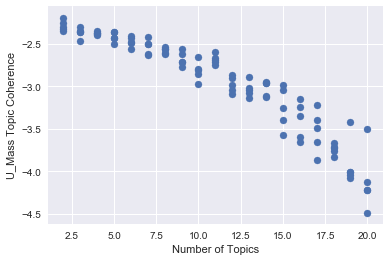

In [44]:
topics_for_plotting_highres=topic_numbers_highres
for i in range(4):
    topics_for_plotting_highres = np.append(topics_for_plotting_highres,topic_numbers_highres)
    
plt.scatter(x=topics_for_plotting_highres,y=u_mass_coherences_test_highres.reshape(95))
plt.xlabel('Number of Topics')
plt.ylabel('U_Mass Topic Coherence')

Text(0,0.5,'Log Perplexity Scores')

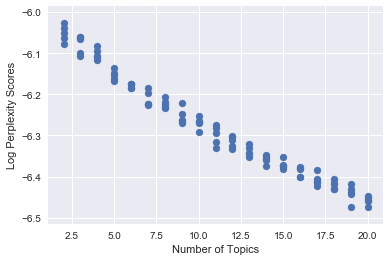

In [45]:
plt.scatter(x=topics_for_plotting_highres,y=log_perplexity_scores_highres.reshape(95))
plt.xlabel('Number of Topics')
plt.ylabel('Log Perplexity Scores')